In [1]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import tflearn
import ipdb as pdb
import time

for k in range(5):
    
    tf.reset_default_graph()
    
    print('---------' + str(k) + '------------')
    
    MAX_EPISODE = 2000
    MAX_EPISODE_LEN = 200

    NUM_T = 1
    NUM_R = 4
    SIGMA2 = 1e-9

    t_factor = 0.8
    noise_sigma = 0.12

    config = {'state_dim':3, 'action_dim':2};
    train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                    'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                    'random_seed':int(time.clock()*1000%1000), 'noise_sigma':noise_sigma, 'sigma2':SIGMA2}
    
    IS_TRAIN = False
#     rate = 3.0
    res_path = 't_M_08_nB/'
    model_path = 'model_M_08_nB/my_train_model_'+str(k)+'-2000'
    meta_path = model_path+'.meta'
    init_path = ''
    init_seqCnt = 40
    
    user_config = [{'id':'1', 'model':'AR', 'num_r':NUM_R, 'rate':1.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000},
                   {'id':'2', 'model':'AR', 'num_r':NUM_R, 'rate':2.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000},
                   {'id':'3', 'model':'AR', 'num_r':NUM_R, 'rate':3.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000}]
    
    if not os.path.exists(res_path):
        os.mkdir(res_path) 
    
    print(user_config)
    # 0. initialize the session object
    sess = tf.Session() 

    # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
    # sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) 

    # 1. include all user in the system according to the user_config
    user_list = [];
    for info in user_config:
        info.update(config)
        info['model_path'] = model_path + '_' + info['id']
        info['meta_path'] = info['model_path']+'.meta'
        info['init_path'] = init_path
        info['init_seqCnt'] = init_seqCnt
        user_list.append(MecTermRL(sess, info, train_config))
        print('Initialization OK!----> user ' + info['id'])

    # 2. create the simulation env
    env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)

    sess.run(tf.global_variables_initializer())
    
    tflearn.config.is_training(is_training=IS_TRAIN, session=sess)

    env.init_target_network()

    res_r = []
    res_p = []
    res_b = []
    res_o = []
    res_d = []
    # 3. start to explore for each episode
    for i in range(MAX_EPISODE):

        cur_init_ds_ep = env.reset()

        cur_r_ep = np.zeros(len(user_list))
        cur_p_ep = np.zeros(len(user_list))
        cur_op_ep = np.zeros(len(user_list))
        cur_ts_ep = np.zeros(len(user_list))
        cur_ps_ep = np.zeros(len(user_list))
        cur_rs_ep = np.zeros(len(user_list))
        cur_ds_ep = np.zeros(len(user_list))
        cur_ch_ep = np.zeros(len(user_list))
        cur_of_ep = np.zeros(len(user_list))

        for j in range(MAX_EPISODE_LEN):

            # first try to transmit from current state
            [cur_r, done, cur_p, cur_op, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()

            cur_r_ep += cur_r
            cur_p_ep += cur_p
            cur_op_ep += cur_op
            cur_ts_ep += cur_ts
            cur_ps_ep += cur_ps
            cur_rs_ep += cur_rs
            cur_ds_ep += cur_ds
            cur_ch_ep += cur_ch
            cur_of_ep += cur_of


            if done:
                res_r.append(cur_r_ep/MAX_EPISODE_LEN)
                res_p.append(cur_p_ep/MAX_EPISODE_LEN)
                res_b.append(cur_ds_ep/MAX_EPISODE_LEN)
                res_o.append(cur_of_ep/MAX_EPISODE_LEN)
                res_d.append(cur_ds)
                print('%d:r:%s,p:%s,op:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s,rbuf:%s' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_op_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep, cur_ds))

    name = res_path+'test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
    np.savez(name, res_r, res_p, res_b, res_o, res_d)
    
    tflearn.config.is_training(is_training=False, session=sess)
    #Create a saver object which will save all the variables
    saver = tf.train.Saver() 
    saver.save(sess, model_path)

    sess.close()

curses is not supported on this machine (please install/reinstall curses for an optimal experience)
---------0------------
[{'id': '1', 'model': 'AR', 'num_r': 4, 'rate': 1.0, 'dis': 100, 'action_bound': 2, 'data_buf_size': 100, 't_factor': 0.8, 'penalty': 1000}, {'id': '2', 'model': 'AR', 'num_r': 4, 'rate': 2.0, 'dis': 100, 'action_bound': 2, 'data_buf_size': 100, 't_factor': 0.8, 'penalty': 1000}, {'id': '3', 'model': 'AR', 'num_r': 4, 'rate': 3.0, 'dis': 100, 'action_bound': 2, 'data_buf_size': 100, 't_factor': 0.8, 'penalty': 1000}]
Initialization OK!----> user 1
Initialization OK!----> user 2
Initialization OK!----> user 3
0:r:[-14.53687815 -13.90320236 -26.50461864],p:[0.897802   1.12231758 1.0724006 ],op:[0.89583935 0.29169795 0.        ],tr:[1.16778539 0.97765647 0.68210761],pr:[1.96240952 1.45395906 1.18582453],rev:[0.875 1.945 3.035],dbuf:[ 0.93873675 12.95539081 89.62706924],ch:[3.86235155 3.14552382 3.19912907],ibuf:[2.0, 25.0, 33.5],rbuf:[  1.06151962  79.29010824 266.913

22:r:[-24.60828011 -45.01983261 -51.53200142],p:[0.01428418 0.00327055 0.06750288],op:[0. 0. 0.],tr:[0.         0.00740281 0.        ],pr:[0.20241192 0.         0.77617454],rev:[1.05  1.995 3.07 ],dbuf:[122.4700334  224.96834091 254.95989201],ch:[4.31689035 4.22378965 5.40735625],ibuf:[22.0, 21.0, 20.5],rbuf:[191.51761697 418.51943764 479.26509228]
23:r:[-25.99424239 -40.656      -44.30577148],p:[0.01374018 0.         0.16928842],op:[0. 0. 0.],tr:[0. 0. 0.],pr:[0.19445054 0.         1.09720439],rev:[1.11  1.915 3.175],dbuf:[129.4216048  203.28       214.75732062],ch:[4.51119093 3.46492742 4.08601357],ibuf:[24.0, 15.5, 9.5],rbuf:[207.10989103 398.5        425.05912273]
24:r:[-22.36623618 -50.967      -46.84809907],p:[0.01138229 0.         0.06875592],op:[0. 0. 0.],tr:[0. 0. 0.],pr:[0.19306795 0.         0.56661411],rev:[0.94  2.105 3.04 ],dbuf:[111.37588935 254.835      231.49025871],ch:[3.48504584 4.58089037 3.92055526],ibuf:[33.0, 40.0, 2.5],rbuf:[182.38640961 461.         497.1771774

45:r:[ -3.8543143  -42.09646549 -47.75933379],p:[0.19228972 0.03011694 0.0780606 ],op:[0.01539532 0.         0.        ],tr:[0.31713598 0.00235493 0.        ],pr:[0.8556983  0.33465083 0.73818929],rev:[1.055 1.935 2.915],dbuf:[ 10.96416978 209.2776499  235.67424507],ch:[4.16407369 3.83200615 3.81124481],ibuf:[5.0, 27.5, 13.5],rbuf:[  0.         347.09884713 448.86214145]
46:r:[ -3.31028879 -22.62577878 -35.8993296 ],p:[0.28062178 0.0664296  0.42159135],op:[0.04860547 0.         0.        ],tr:[0.49131026 0.         0.3663174 ],pr:[1.08295236 0.78288956 1.27483483],rev:[1.13  1.82  2.865],dbuf:[  3.3823539  110.4717097  162.63299408],ch:[4.84103958 4.33356039 4.01453791],ibuf:[27.5, 5.0, 22.5],rbuf:[  2.         212.42208867 267.26955526]
47:r:[ -4.87384799 -31.05840087 -41.67243115],p:[0.23159273 0.03898322 0.23303844],op:[0.03449535 0.         0.        ],tr:[0.31759032 0.         0.41286428],pr:[0.97951923 0.44262013 0.78078122],rev:[0.96  2.065 3.235],dbuf:[ 13.72571692 153.73267538

69:r:[-19.02167623 -39.102      -54.92085471],p:[0.25124231 0.         0.38560942],op:[0. 0. 0.],tr:[0.5266032  0.         0.82280008],pr:[0.07103608 0.         0.018352  ],rev:[0.945 1.88  2.96 ],dbuf:[ 85.05868866 195.51       259.17989674],ch:[4.19743639 4.15745373 4.03925996],ibuf:[40.0, 2.0, 30.5],rbuf:[109.47214316 378.         454.26958397]
70:r:[ -3.83188254 -42.627      -42.85407444],p:[0.31954483 0.         0.51398918],op:[0.00666942 0.         0.        ],tr:[0.77799516 0.         0.96671555],pr:[0.39000595 0.         0.39366207],rev:[0.935 2.03  3.18 ],dbuf:[  6.11084286 213.135      193.7108051 ],ch:[4.15462544 3.93810411 3.85832498],ibuf:[18.0, 2.0, 20.0],rbuf:[  0.         408.         383.92447513]
71:r:[ -2.38761122 -45.87083333 -28.65340767],p:[0.17127759 0.00360988 0.58430989],op:[0.05317941 0.         0.        ],tr:[0.1857887  0.01290038 0.89340839],pr:[1.06351359 0.         0.87622135],rev:[0.865 1.925 2.715],dbuf:[  2.95977611 229.20977131 119.89464292],ch:[4.743

92:r:[-12.23541894 -33.92061356 -40.9773834 ],p:[0.39819641 0.02476045 0.13032786],op:[0.         0.00075458 0.        ],tr:[7.74637011e-01 7.35207631e-03 9.17354580e-05],pr:[0.06158268 0.19550704 0.99589587],rev:[0.995 2.005 3.03 ],dbuf:[ 45.24923809 168.58246658 199.67380248],ch:[3.73688137 4.3913909  4.11984553],ibuf:[42.0, 0.5, 4.0],rbuf:[ 73.7560614  361.52854191 410.80247914]
93:r:[-18.8282888  -42.478      -61.49558592],p:[0.0963017  0.         0.02104173],op:[0. 0. 0.],tr:[1.11947869e-01 0.00000000e+00 9.25246267e-05],pr:[0.36241573 0.         0.23128235],rev:[0.985 2.065 3.26 ],dbuf:[ 90.28937601 212.39       306.63626023],ch:[3.52690568 4.31894594 4.62135893],ibuf:[14.5, 7.0, 21.5],rbuf:[116.62727958 420.         627.2250259 ]
94:r:[ -1.83687878 -38.196635   -58.70353603],p:[0.1209655  0.13669722 0.07780764],op:[0.00709536 0.         0.        ],tr:[0.16826522 0.27390045 0.10042342],pr:[0.74351791 0.         0.46016631],rev:[0.87  1.87  2.965],dbuf:[  4.06195935 185.5152861  

114:r:[-10.44341918 -41.41194277 -55.61442462],p:[0.25483513 0.05638825 0.25084331],op:[0.00523194 0.         0.        ],tr:[0.60462223 0.13697712 0.50297944],pr:[0.23288542 0.15620629 0.        ],rev:[1.11  2.025 2.89 ],dbuf:[ 41.81441326 204.80418386 268.0383906 ],ch:[4.33057901 4.37088018 3.78990737],ibuf:[22.5, 28.0, 43.5],rbuf:[ 99.61820867 374.36331843 520.90411172]
115:r:[-18.21898737 -42.6059267  -54.45283971],p:[0.26641469 0.06769258 0.20806857],op:[0. 0. 0.],tr:[0.48895858 0.19963909 0.51855439],pr:[0. 0. 0.],rev:[1.    2.095 2.905],dbuf:[ 80.43834943 210.3219301  263.94145575],ch:[3.6802909  5.32718904 4.01098368],ibuf:[31.5, 16.0, 38.0],rbuf:[133.70828472 395.07218187 515.28912111]
116:r:[-19.17806996 -38.76684353 -64.15511328],p:[0.18053464 0.02013514 0.12265504],op:[0. 0. 0.],tr:[0.31152593 0.03463802 0.17388491],pr:[0. 0. 0.],rev:[1.01 1.98 3.1 ],dbuf:[ 88.66896434 193.028812   315.86936485],ch:[3.42053223 3.20840102 2.76459881],ibuf:[15.5, 0.0, 22.5],rbuf:[155.19481458

137:r:[-16.46890922 -10.93377549 -37.90578207],p:[0.02116872 0.89989121 1.53765593],op:[0.        0.3796026 0.       ],tr:[0.         0.40578907 1.72851575],pr:[0.33677695 2.06634453 0.        ],rev:[0.94  1.93  2.945],dbuf:[ 81.49779748   3.48912491 128.0226733 ],ch:[3.61486207 3.9081756  4.11908866],ibuf:[43.5, 7.5, 37.5],rbuf:[164.14460968   2.77918069 280.79684948]
138:r:[-27.70304364 -12.82907293 -49.81640562],p:[5.10132400e-05 8.50784378e-01 1.89713186e-01],op:[0.        0.0052741 0.       ],tr:[0.         0.06654368 0.48758694],pr:[0.00216889 1.8773986  0.        ],rev:[1.085 2.17  2.92 ],dbuf:[138.51317766  29.90302564 241.49350064],ch:[4.6039124  3.92386959 3.96743472],ibuf:[23.5, 22.5, 4.0],rbuf:[240.06622189  69.28956339 491.91310927]
139:r:[-25.352      -10.94804691 -58.1625698 ],p:[0.         0.72367228 0.06501884],op:[0. 0. 0.],tr:[0.         0.09011124 0.14139427],pr:[0.         1.74568191 0.01991394],rev:[1.03  1.885 3.1  ],dbuf:[126.76        25.79334328 288.21209522],

160:r:[-22.9701357  -16.30217442 -15.39230657],p:[0.00910105 0.49778839 1.45251606],op:[0.         0.         0.11395115],tr:[0.         0.04687312 1.05342566],pr:[0.16235291 1.54223202 1.97118286],rev:[1.07  2.115 2.98 ],dbuf:[114.48663646  61.59933643  14.30284446],ch:[4.7394439  5.72094126 3.79082342],ibuf:[9.0, 14.0, 5.5],rbuf:[190.52941727 119.17897172  41.72059221]
161:r:[-14.09539931 -20.130017   -18.09377656],p:[0.01571093 0.58905266 1.59931565],op:[0. 0. 0.],tr:[1.15555654e-04 2.92291572e-01 7.87932883e-01],pr:[0.24158892 1.5660352  2.06707472],rev:[0.95 2.1  2.92],dbuf:[69.84855942 77.08797841 26.49625673],ch:[3.22253338 4.07092249 5.51362349],ibuf:[11.0, 32.5, 19.0],rbuf:[152.6591045   80.83464606  31.9984789 ]
162:r:[-26.4641993   -9.2403947  -24.72695441],p:[0.0435431  0.72829504 2.07312179],op:[0.        0.0457962 0.       ],tr:[0.04638018 0.3015847  0.41342687],pr:[0.23896348 1.69928257 2.46908958],rev:[1.07  2.1   2.965],dbuf:[130.57927239  15.23832414  40.70990061],ch:

183:r:[-21.349      -11.728225   -45.11726035],p:[0.         0.46360977 0.14491223],op:[0. 0. 0.],tr:[0.         0.6587106  0.16936818],pr:[0.         1.21608292 0.52148035],rev:[1.02  1.945 2.99 ],dbuf:[106.745       40.09673407 219.78981274],ch:[4.23173029 5.64901577 4.19660115],ibuf:[5.5, 47.5, 10.5],rbuf:[209.5         61.54129596 470.33029517]
184:r:[-19.532      -16.5203239  -57.45554589],p:[0.         0.47665512 0.19885993],op:[0. 0. 0.],tr:[0.         0.41326454 0.48042409],pr:[0.         1.07090846 0.        ],rev:[0.97 1.98 3.04],dbuf:[ 97.66        63.53541487 279.32333242],ch:[3.86987879 4.53601482 4.11239089],ibuf:[5.0, 17.5, 24.0],rbuf:[199.         116.66539997 535.91518156]
185:r:[-27.337      -26.29122241 -58.00228524],p:[0.         0.7522083  0.31874813],op:[0. 0. 0.],tr:[0.         0.38431824 0.53185344],pr:[0.         1.15706542 0.        ],rev:[0.995 1.995 2.905],dbuf:[136.685      101.36778    277.26150104],ch:[5.00774542 3.05180529 2.90909681],ibuf:[45.5, 27.5, 3

206:r:[ -5.98625425 -17.89225157 -20.92214848],p:[0.35265006 0.7978484  2.16964762],op:[0.19899333 0.         0.        ],tr:[0.         0.02516935 1.5511005 ],pr:[1.63410234 1.83980015 1.55619216],rev:[0.975 1.91  3.   ],dbuf:[ 7.8655356  57.54732165 17.82483767],ch:[3.94662264 3.19468195 2.96041021],ibuf:[38.0, 42.5, 35.0],rbuf:[ 4.05050843 51.50609935 13.54146864]
207:r:[ -3.07355609  -9.82093009 -18.76568472],p:[0.21793781 0.68378901 1.8230129 ],op:[0.09685581 0.         0.        ],tr:[0.        0.        1.2876911],pr:[1.3560714  1.75500639 1.74100562],rev:[0.96  1.815 2.995],dbuf:[ 2.77603565 21.75309    20.90790761],ch:[3.93990323 4.51182156 3.48702337],ibuf:[13.0, 23.5, 31.0],rbuf:[ 0.         35.49872199 24.2606574 ]
208:r:[ -5.128101    -9.53129726 -20.24279142],p:[0.18977997 0.83895629 1.87594265],op:[0.01463217 0.06456177 0.00823405],tr:[0.         0.1196566  0.92643312],pr:[1.16368455 1.90590379 2.05899379],rev:[0.925 1.92  3.115],dbuf:[17.46401921 11.51576403 25.84688933

229:r:[ -4.81889242 -18.42856059 -27.76530945],p:[0.42611396 0.60967582 1.9999166 ],op:[0.00961866 0.         0.        ],tr:[1.03479759 0.23687776 0.90969004],pr:[0.40640469 1.62434137 1.92244747],rev:[0.91  2.165 2.865],dbuf:[ 6.66515728 67.75577033 58.8298833 ],ch:[5.30448681 4.56251434 4.11641769],ibuf:[32.0, 22.0, 49.0],rbuf:[ 0.74600822 82.75617405 55.57249834]
230:r:[-10.51348484 -17.66952979 -27.21227166],p:[0.31147734 0.68466615 2.01516862],op:[0. 0. 0.],tr:[0.71861803 0.18564458 0.92059214],pr:[0.         1.7109887  1.87314502],rev:[0.93  1.965 3.03 ],dbuf:[40.10833077 60.9610029  55.45461347],ch:[4.68083579 4.34763878 3.44019237],ibuf:[16.5, 46.0, 5.0],rbuf:[58.77639411 59.67334306 52.25256725]
231:r:[-24.9971365  -11.25583519 -29.40905776],p:[0.03724308 0.95509988 1.9370995 ],op:[0.        0.0744386 0.       ],tr:[0.05018851 0.31860002 0.9355711 ],pr:[0.12940319 1.91894656 1.90699755],rev:[1.045 1.905 2.995],dbuf:[123.49595909  15.09763676  69.56130871],ch:[3.94983014 3.768

252:r:[-14.48211015  -7.91088903 -43.64444278],p:[0.29196083 0.66335524 1.66251876],op:[0.        0.0322602 0.       ],tr:[0.57783998 0.24460884 1.35918794],pr:[0.31605908 1.66095287 0.96598562],rev:[1.01  1.885 3.02 ],dbuf:[ 60.73211766  11.72982736 151.72146351],ch:[3.43279846 4.87050765 4.59102101],ibuf:[45.5, 12.0, 41.5],rbuf:[ 68.72018913  24.25230923 180.4652884 ]
253:r:[-23.8500185  -11.61826416 -46.36082502],p:[0.18562081 0.94759976 1.82368451],op:[0. 0. 0.],tr:[0.35481167 0.01171227 1.21437478],pr:[0.0037457  1.92724311 1.04146016],rev:[1.04 1.98 2.94],dbuf:[111.82526016  20.18733031 158.8567446 ],ch:[3.57206268 3.43421837 4.41267418],ibuf:[37.5, 18.0, 41.5],rbuf:[173.78852503  26.20892392 178.33301258]
254:r:[-20.87817041  -8.81422277 -46.50478201],p:[0.12837693 0.72610276 1.78264828],op:[0.         0.02105183 0.        ],tr:[0.28494563 0.04390512 1.31598329],pr:[0.         1.78015437 1.04294981],rev:[0.92 1.85 3.03],dbuf:[ 99.25577478  14.18493023 161.21797893],ch:[3.4500900

275:r:[ -9.67078517 -16.80873114 -18.10163095],p:[0.09332648 1.21475787 2.00375087],op:[0.         0.         0.12992054],tr:[0.05144146 0.0384551  0.64988016],pr:[0.78030662 2.09061368 2.33712979],rev:[0.93 2.08 2.81],dbuf:[44.62086681 35.45334085  5.16129869],ch:[4.18283985 4.27197023 3.29240886],ibuf:[17.5, 40.5, 6.0],rbuf:[37.15038273 30.68624359  0.75405105]
276:r:[ -7.93292998 -13.54468422 -41.61396976],p:[0.25916877 0.78236878 1.34661352],op:[0.02154176 0.         0.        ],tr:[0.44503005 0.20544943 0.35250302],pr:[0.89779552 1.7700254  1.94995742],rev:[0.97  2.    3.175],dbuf:[ 28.43622892  36.42866984 154.20530794],ch:[4.06641914 3.99662903 4.16919721],ibuf:[46.5, 30.0, 34.5],rbuf:[  0.50628707  34.90503497 209.00791194]
277:r:[ -3.0019988  -17.77310542 -31.78813182],p:[0.20318335 1.08536002 1.93838787],op:[0.0758493 0.        0.       ],tr:[0.04088389 0.         0.25810677],pr:[1.27339399 2.02775744 2.43195439],rev:[0.985 2.095 3.055],dbuf:[ 3.84868783 45.45112645 81.405144

298:r:[-20.422      -10.20654234 -26.13066837],p:[0.         0.69291701 1.98894734],op:[0.         0.00334419 0.        ],tr:[0.         0.19926277 0.03012274],pr:[0.         1.68064287 2.51152582],rev:[0.995 2.025 2.985],dbuf:[102.11        23.18226355  51.09544813],ch:[4.16916206 3.57489455 5.30117213],ibuf:[3.0, 4.0, 8.0],rbuf:[202.          33.91752107  96.67028719]
299:r:[-20.12604138 -12.93255335 -27.50621049],p:[0.0354306  0.88199813 1.98252285],op:[0. 0. 0.],tr:[0. 0. 0.],pr:[0.39461821 1.89081448 2.51199228],rev:[1.08  1.885 2.895],dbuf:[99.21298297 29.38284168 58.23013844],ch:[4.4600566  3.86140611 4.04665167],ibuf:[7.0, 30.5, 7.0],rbuf:[144.07635725  29.33710334  83.60154378]
300:r:[-22.99971127 -15.22911122 -26.59614022],p:[0.0121136  1.09676228 1.99694688],op:[0. 0. 0.],tr:[0. 0. 0.],pr:[0.2241493  2.02950229 2.51853908],rev:[1.075 1.99  2.915],dbuf:[114.5140125   32.27506493  53.10282591],ch:[4.06021098 3.34540713 3.82671024],ibuf:[8.0, 42.5, 17.5],rbuf:[178.17014023  34.

321:r:[ -3.40641863 -14.03247626 -25.49778456],p:[0.1269541  1.39751823 1.73725492],op:[0.0031456 0.        0.       ],tr:[0.00757108 1.57106323 0.        ],pr:[0.86547279 0.60679989 2.40393717],rev:[1.055 1.95  2.88 ],dbuf:[11.82810526 14.26165191 57.99872589],ch:[4.15369061 4.28263927 3.93992751],ibuf:[1.0, 46.0, 21.0],rbuf:[ 40.46794645   3.4523053  116.21256552]
322:r:[ -6.74389769 -12.77455743 -33.83244959],p:[0.08789232 1.25875255 1.53705012],op:[0. 0. 0.],tr:[9.19254744e-02 1.40707328e+00 1.73929914e-04],pr:[0.63384484 0.88380413 2.30645313],rev:[1.005 2.09  2.995],dbuf:[ 30.20379568  13.52268512 107.68024319],ch:[3.46717574 4.09961365 5.15209613],ibuf:[8.0, 48.0, 45.5],rbuf:[ 63.84593624  16.25397471 183.17458859]
323:r:[-16.66146084 -12.75387426 -36.47005662],p:[0.39115395 1.0612116  1.44273345],op:[0. 0. 0.],tr:[6.25638143e-01 8.29695328e-01 8.53551992e-05],pr:[0.64169017 1.20636394 2.25973296],rev:[1.05  1.99  2.895],dbuf:[ 67.66114634  21.32090736 124.64094507],ch:[3.475840

344:r:[-26.77090414 -16.91789988 -28.073949  ],p:[0.12249449 0.81088407 2.02252222],op:[0. 0. 0.],tr:[0.34600334 0.00109838 0.28550655],pr:[0.         1.77275015 2.46659376],rev:[1.02  1.895 2.775],dbuf:[128.954741    52.1541367   59.46885624],ch:[4.3679443  4.87964002 3.54424446],ibuf:[47.5, 29.0, 38.0],rbuf:[182.29933234  53.23029281  42.57993807]
345:r:[ -9.80702052 -10.49106166 -19.32379566],p:[0.25023479 1.02587025 2.09877881],op:[0.         0.1963157  0.00564273],tr:[0.56232256 1.07689667 0.74192315],pr:[0.         1.48421063 2.30024783],rev:[0.915 2.005 2.865],dbuf:[39.02571099  3.56787048 12.44211678],ch:[4.27563729 3.69302994 3.44892774],ibuf:[0.5, 2.0, 37.5],rbuf:[76.58114026 11.68576202  5.98445506]
346:r:[-11.51088651 -19.46995706 -20.68883882],p:[0.24143574 1.0699411  2.12290692],op:[0. 0. 0.],tr:[0.64417947 0.00510423 0.57776525],pr:[0.         1.9753373  2.43989009],rev:[1.06 2.07 2.93],dbuf:[47.89700288 54.55214137 18.52791745],ch:[4.3187256  3.32842312 3.38827538],ibuf

367:r:[ -4.26004663 -10.62215453 -29.48865121],p:[0.18964511 0.90675153 1.89915124],op:[0.05712022 0.         0.        ],tr:[0.30251042 0.18073085 0.00089025],pr:[0.86739592 1.88095957 2.47608224],rev:[0.9   2.02  2.915],dbuf:[11.42961987 16.8407113  71.47720631],ch:[4.78973987 3.90437084 3.6912901 ],ibuf:[2.5, 27.0, 32.5],rbuf:[  3.          18.66191758 120.10550273]
368:r:[ -3.97629745 -11.40036699 -16.82456585],p:[0.31061701 0.67453195 1.92372431],op:[0.09354129 0.00129012 0.00140926],tr:[0.33462393 0.01259711 0.49877264],pr:[1.2324181  1.7160764  2.26091579],rev:[0.93  2.055 2.755],dbuf:[ 3.71515527 29.96895225  7.11748631],ch:[3.4246473  4.45785331 3.52974073],ibuf:[28.0, 2.5, 16.0],rbuf:[ 2.37338481 68.66293594 15.34243918]
369:r:[ -3.01438872 -21.16785297 -26.2753008 ],p:[0.21629581 0.74632054 1.81126586],op:[0.03703905 0.         0.        ],tr:[0.20498998 0.         0.0030762 ],pr:[1.09655452 1.69035733 2.43658289],rev:[1.005 2.075 2.92 ],dbuf:[ 4.93854908 75.98644324 58.9258

390:r:[-10.89790208 -18.46248929 -15.90668732],p:[0.4111638  0.80324687 1.84748748],op:[0.         0.         0.00369476],tr:[0.96947216 0.         1.13535985],pr:[0.         1.8206609  1.87064013],rev:[0.95  2.055 3.025],dbuf:[38.04295823 60.18257182  5.48614701],ch:[4.67080728 3.6380141  3.90763188],ibuf:[41.0, 35.5, 0.0],rbuf:[37.10556736 82.3678205   6.03616895]
391:r:[ -9.11916371 -12.9953154  -16.71902505],p:[0.43179037 1.11437335 1.86213245],op:[0.         0.12107108 0.01201752],tr:[0.79970152 0.134365   1.21744028],pr:[0.         2.09653819 1.91074123],rev:[0.965 1.93  2.935],dbuf:[28.32420383 15.55879968  8.62912625],ch:[3.82813603 2.53503925 4.52895483],ibuf:[13.5, 30.0, 43.0],rbuf:[46.55969635  2.32520721  9.43980668]
392:r:[-14.58061192 -12.29730913 -16.99444926],p:[0.35635705 1.07411037 1.97684805],op:[0.         0.38199901 0.01264541],tr:[0.62153786 0.53358169 0.82587913],pr:[0.         2.09591848 2.19893839],rev:[0.965 2.025 2.96 ],dbuf:[58.64877757  3.24217065  5.392507

413:r:[-17.61460953 -10.78995785 -16.42698939],p:[0.04528124 0.99277422 1.92085028],op:[0.         0.24930167 0.00247359],tr:[0.00341344 0.91341418 1.40703242],pr:[0.51280424 1.78772133 1.65264958],rev:[0.97 2.01 2.96],dbuf:[86.26179792  4.26675345  5.2019922 ],ch:[4.45621169 3.48583205 3.62593371],ibuf:[30.5, 23.0, 20.0],rbuf:[121.2564642    2.           0.81989193]
414:r:[-19.36574919 -10.70583507 -15.60053176],p:[0.0303906  0.91250144 1.81689061],op:[0.         0.29935905 0.00088408],tr:[0.03947498 1.2574406  1.53758131],pr:[0.24602011 1.66706311 1.56737359],rev:[0.91  1.945 2.995],dbuf:[95.6131218   5.05475567  5.2916712 ],ch:[4.74419784 5.24595965 4.36019615],ibuf:[48.0, 48.0, 28.0],rbuf:[172.90098269   1.04300735   6.29866627]
415:r:[-17.22736578 -11.24937187 -18.30933718],p:[0.04321826 0.97348617 2.12604808],op:[0.         0.33741944 0.02416304],tr:[0.         0.69973587 1.53266596],pr:[0.55971082 1.92154513 1.67996243],rev:[1.015 1.84  3.14 ],dbuf:[84.40809848  3.81063509  5.53

436:r:[ -2.58588916 -10.90026956 -20.77722314],p:[0.19461829 1.07827858 2.41981282],op:[0.02192328 0.15609133 0.03690615],tr:[0.         0.52366404 1.52505915],pr:[1.19225274 1.92076986 1.65949628],rev:[1.07  2.005 2.92 ],dbuf:[4.26778308 5.12655159 5.61735707],ch:[4.21684949 3.92282683 3.4680972 ],ibuf:[8.0, 42.5, 28.5],rbuf:[0.99545267 3.75082579 8.45273412]
437:r:[ -3.47036814 -10.68938473 -20.33063281],p:[0.19583469 0.94789943 2.38258181],op:[0.00372095 0.30660504 0.01440257],tr:[0.         0.63549524 1.79878619],pr:[1.14075509 1.94262769 1.51353396],rev:[1.01  1.925 3.055],dbuf:[9.3696152  3.26674468 5.77378888],ch:[4.12109384 3.90227015 4.03547847],ibuf:[24.0, 23.0, 37.0],rbuf:[2.24767078 0.         1.        ]
438:r:[-26.91125518  -9.73531312 -17.33987644],p:[1.53671241e-03 8.83752809e-01 2.00000205e+00],op:[0.         0.26581269 0.05553103],tr:[0.         0.80078963 1.65481816],pr:[0.0504916  1.78645655 1.60324534],rev:[0.935 2.035 2.99 ],dbuf:[134.49480739   2.69394547   4.478

459:r:[ -4.58524996  -9.07524389 -19.57077069],p:[0.46008767 0.95824792 2.19414817],op:[0.0263991  0.02252398 0.1126    ],tr:[0.96475632 0.66607968 1.57031234],pr:[0.63530038 1.53026947 1.80048838],rev:[0.93  1.92  2.915],dbuf:[3.4667789  6.14534362 5.5839267 ],ch:[5.42073613 3.38054011 4.24829719],ibuf:[11.0, 43.5, 40.0],rbuf:[0.38853413 4.17029024 6.64726426]
460:r:[ -5.17914446  -7.71668815 -21.10923453],p:[0.45763674 0.81785705 2.3348541 ],op:[0.0336188  0.05438595 0.13625912],tr:[0.73087554 0.47520903 1.65901901],pr:[0.84025751 1.64038458 1.87070829],rev:[1.11  1.96  3.065],dbuf:[6.24550072 3.6937208  6.70164386],ch:[4.05660682 3.42021576 4.22088114],ibuf:[18.5, 9.5, 40.0],rbuf:[4.27291217 5.48609967 1.74108497]
461:r:[ -4.23351708  -8.28335252 -21.27008706],p:[0.39028011 0.88980575 2.50892735],op:[0.07541155 0.00209665 0.014508  ],tr:[0.6127378  0.82057894 1.64735138],pr:[1.06255172 1.31538445 1.70749508],rev:[1.08 1.97 3.19],dbuf:[2.53991872 5.74066666 5.4130213 ],ch:[3.42657624

482:r:[ -4.36630414 -11.3649932  -22.26912535],p:[0.09739334 1.11230221 2.61902784],op:[0.06480763 0.21881647 0.00742873],tr:[4.60752429e-04 5.91465020e-01 1.76634797e+00],pr:[0.84317985 1.93367867 1.46209335],rev:[0.915 2.025 3.17 ],dbuf:[15.34348192  3.58021912  6.28736404],ch:[3.59868149 2.89367708 3.50529529],ibuf:[8.0, 25.5, 5.0],rbuf:[74.96859086  4.81092283  5.45417014]
483:r:[-19.63142179  -9.86385221 -21.67328498],p:[0.04414172 1.02974805 2.54077806],op:[0.         0.10859051 0.05185819],tr:[0.         0.61346285 1.60579437],pr:[0.52095174 1.78667519 1.67951501],rev:[1.035 2.03  3.025],dbuf:[96.39144025  3.7857186   4.66097469],ch:[4.57042534 3.30070136 4.21588602],ibuf:[41.0, 26.5, 15.0],rbuf:[143.80965187   2.43934521   3.        ]
484:r:[-27.734      -12.72666532 -55.53209015],p:[0.         1.26653527 0.07301883],op:[0.        0.2450013 0.       ],tr:[0.         1.24381318 0.02803265],pr:[0.         1.77481857 0.65536422],rev:[1.015 2.045 3.055],dbuf:[138.67         3.17186

504:r:[-18.58300629  -9.22427355 -17.35351815],p:[0.12681419 1.02916881 2.0571876 ],op:[0.         0.00069431 0.00850008],tr:[0.29436749 1.13550782 1.61122487],pr:[0.         1.05118555 1.24735534],rev:[0.93 2.01 2.83],dbuf:[87.84246389  4.92684317  4.14008359],ch:[3.70282514 3.9153678  3.92954974],ibuf:[25.5, 30.5, 4.0],rbuf:[152.62650108   5.39977317   6.92373999]
505:r:[-21.87040733  -8.91318824 -18.44851954],p:[0.07068758 1.00168659 2.14979122],op:[0.         0.00011049 0.00785853],tr:[0.20431994 1.13971912 1.71451431],pr:[0.         1.02252308 1.5069177 ],rev:[0.98  2.115 3.055],dbuf:[106.52453331   4.49405838   5.93660784],ch:[4.30555823 3.80468526 4.31494782],ibuf:[29.0, 9.0, 33.5],rbuf:[184.13601266   4.9058183    7.77067448]
506:r:[-23.25690893 -10.09281164 -17.78711169],p:[0.19387928 1.14772045 2.09600475],op:[0.         0.01571161 0.0043945 ],tr:[0.38513661 1.17191208 1.47822253],pr:[0.         1.20630466 1.34750583],rev:[1.015 2.18  2.73 ],dbuf:[108.52937335   3.92677589   

527:r:[ -3.53438235  -7.94459873 -29.28756204],p:[0.26734958 0.8997205  2.71015422],op:[0.08848452 0.01212998 0.80519822],tr:[0.56036277 1.191275   2.1533741 ],pr:[1.02374083 0.98070293 2.31074426],rev:[0.925 1.91  3.005],dbuf:[3.43854767 3.24897465 5.82371257],ch:[5.10819354 4.27343459 3.92502014],ibuf:[16.0, 10.5, 32.0],rbuf:[3.         2.46292134 4.        ]
528:r:[ -4.52408176  -8.66519796 -31.73935864],p:[0.33268926 0.93859022 2.89222655],op:[0.14725714 0.07758158 0.93121086],tr:[0.50076536 1.32070606 2.05936464],pr:[1.22012077 1.06769387 2.43940322],rev:[0.985 1.84  3.04 ],dbuf:[3.42255254 2.67911813 5.75929645],ch:[4.53474415 4.16525402 4.17114239],ibuf:[21.0, 16.0, 40.0],rbuf:[8.48060973 1.         1.        ]
529:r:[ -4.01145898  -9.1312682  -32.12558359],p:[0.24417    1.00968309 2.69437545],op:[0.08567903 0.02920346 1.23384295],tr:[0.35256284 0.95472858 2.26978558],pr:[1.06378705 1.41103595 2.48825741],rev:[1.035 2.085 3.06 ],dbuf:[6.86333403 4.10087888 3.49918204],ch:[4.9177

550:r:[ -6.65949431 -10.48718151 -22.30922105],p:[0.55377227 1.10617095 2.57017088],op:[0.00750663 0.12921089 0.        ],tr:[1.08505831 1.14094073 1.74028341],pr:[0.34105165 1.52264659 1.35242067],rev:[1.015 2.045 2.865],dbuf:[10.84631576  3.02063389  8.73927008],ch:[4.77955444 4.1085587  4.25634202],ibuf:[8.5, 11.5, 48.5],rbuf:[5.16587245 2.15016067 2.95918291]
551:r:[ -8.95439505  -9.49206209 -18.84327437],p:[0.73162534 1.02256841 2.22467592],op:[0.         0.08890963 0.00024771],tr:[1.06758705 1.42009787 1.83416643],pr:[0.1156976  1.30271738 1.17161094],rev:[1.025 2.11  2.935],dbuf:[15.50696171  3.00118856  5.2194266 ],ch:[3.38471082 4.93265535 3.7898644 ],ibuf:[39.5, 15.0, 24.5],rbuf:[18.80445317  4.73579945 10.7592174 ]
552:r:[-12.15385889 -10.84010887 -18.7849477 ],p:[0.4947363  1.19524475 2.21398384],op:[0.         0.05571364 0.00020408],tr:[0.96441774 0.97329333 2.08434997],pr:[0.         1.58428291 1.17195768],rev:[1.01  2.305 3.18 ],dbuf:[40.97984264  4.16220875  5.35722177]

573:r:[-12.42541635 -11.32838903 -17.86259581],p:[0.17553555 1.30826643 2.02739096],op:[0.         0.04399991 0.09811052],tr:[0.39526225 1.46349626 1.39609329],pr:[0.00454954 0.91787899 1.74423162],rev:[1.045 1.89  2.86 ],dbuf:[55.10565965  2.55129167  4.29291997],ch:[4.0222386  3.50916832 3.8160202 ],ibuf:[2.0, 0.5, 10.0],rbuf:[131.48582806   1.19846964  14.53019807]
574:r:[-25.23       -11.73781256 -16.60291153],p:[0.         1.31231671 1.92534567],op:[0.         0.090807   0.05741697],tr:[0.         1.29177679 1.60419686],pr:[0.         1.27004297 1.5319898 ],rev:[0.985 2.01  2.89 ],dbuf:[126.15         2.56411469   3.70405194],ch:[5.25244083 3.736482   4.15999109],ibuf:[26.0, 9.5, 2.5],rbuf:[223.   1.   3.]
575:r:[-19.39312507 -12.9206826  -18.11547861],p:[0.04844741 1.45962226 2.05375397],op:[0.         0.06798206 0.12228916],tr:[0.         1.8129329  1.62294467],pr:[0.48430757 0.95398907 1.58515188],rev:[1.045 1.885 2.83 ],dbuf:[95.02772893  3.49924028  3.53566777],ch:[3.57574041

596:r:[-20.14       -13.02242981 -18.21399615],p:[0.         1.42248609 2.13980889],op:[0.         0.14368702 0.02588136],tr:[0.         1.97332043 1.84128672],pr:[0.         1.17120942 1.44627403],rev:[0.95 1.89 3.06],dbuf:[100.7          2.46522461   4.4423708 ],ch:[5.24271111 5.13148386 3.66660281],ibuf:[3.5, 28.0, 13.5],rbuf:[193.5          4.           4.75717257]
597:r:[-22.17418028 -11.86135121 -19.32992432],p:[0.02088973 1.31851556 2.21113138],op:[0.         0.0621162  0.03323765],tr:[0.05525892 1.44298031 1.82771478],pr:[0.         1.18465669 1.43141142],rev:[1.025 1.975 2.885],dbuf:[110.03531241   4.08148569   6.87486068],ch:[4.47250414 3.48989623 4.53527747],ibuf:[4.0, 35.5, 41.5],rbuf:[197.94821659   3.70183903   2.63699745]
598:r:[-22.15397342 -11.58311944 -20.17736391],p:[0.03412394 1.19427534 2.32314188],op:[0.         0.19395482 0.06769433],tr:[0.08183377 1.11567892 2.03653293],pr:[0.         1.56050989 1.53174947],rev:[1.075 1.95  3.055],dbuf:[109.4049096    2.38639068

618:r:[ -3.64779838 -13.32949424 -19.29780077],p:[0.26761844 1.38775579 2.2731495 ],op:[0.14542529 0.19151369 0.02469675],tr:[0.2556069  1.39562547 1.87725326],pr:[1.34651459 1.56982312 1.44228467],rev:[0.995 1.98  3.17 ],dbuf:[1.71724289 3.4766922  4.57515373],ch:[3.8570012  4.2011229  4.65702144],ibuf:[7.0, 34.5, 13.5],rbuf:[3.24908293 1.         4.83034757]
619:r:[ -6.00906869 -11.86677047 -21.15799501],p:[0.19965009 1.16204196 2.462675  ],op:[0.00097283 0.26633406 0.01844071],tr:[0.11039583 1.55649522 1.7918623 ],pr:[1.06456916 1.50099316 1.40229783],rev:[0.955 2.    2.92 ],dbuf:[22.02042672  2.19881151  6.54534659],ch:[3.93876573 3.76060789 3.63484672],ibuf:[42.0, 0.5, 37.5],rbuf:[0. 5. 0.]
620:r:[ -4.21600037 -12.62412448 -20.10834601],p:[0.24265369 1.25374525 2.375863  ],op:[0.00079896 0.2645879  0.02763047],tr:[0.36289543 1.23357496 1.87332186],pr:[0.82217407 1.6342253  1.40169109],rev:[1.035 1.95  2.99 ],dbuf:[11.34189579  2.38729635  4.40199145],ch:[3.94190811 3.16532199 3.46

641:r:[-16.34531531 -11.94689221 -20.90595908],p:[0.05809921 1.33577616 2.40921393],op:[0.         0.03818346 0.06393404],tr:[0.08178118 1.4627985  0.99180926],pr:[0.3035183  1.11840213 2.36406325],rev:[0.935 1.95  3.13 ],dbuf:[79.40260832  4.77607621  5.6038766 ],ch:[3.13480521 3.91174208 3.89291648],ibuf:[14.5, 45.5, 36.0],rbuf:[124.44010409   2.           5.0903975 ]
642:r:[-13.83064798 -10.00017188 -20.59733921],p:[0.12564486 1.0866371  2.32293813],op:[0.         0.09984881 0.13229734],tr:[0.14395046 1.34866852 0.93764292],pr:[0.62991377 1.27668231 2.33735468],rev:[1.1   1.92  2.995],dbuf:[64.12744543  2.54142295  4.77727734],ch:[4.42834196 4.77953205 3.57081749],ibuf:[8.0, 13.5, 33.5],rbuf:[73.22715448  4.78386429  3.        ]
643:r:[ -8.0224466  -10.60208816 -21.91174204],p:[0.13185896 1.12327553 2.44299597],op:[0.         0.13336327 0.16976935],tr:[0.05308173 1.09066548 1.13936499],pr:[0.95707953 1.40718511 2.33758575],rev:[1.035 1.905 3.24 ],dbuf:[34.83787444  2.74488879  5.048

663:r:[-17.88675913 -13.16523777 -19.58945391],p:[0.05388758 1.12825965 2.17350219],op:[0.         0.45852264 0.18030534],tr:[0.         0.94666612 0.92404337],pr:[0.65349808 1.93270672 2.40530678],rev:[1.075 2.02  3.135],dbuf:[87.27829245  2.35489707  3.79496812],ch:[5.90736615 3.72560873 4.44678709],ibuf:[46.5, 6.5, 12.5],rbuf:[130.80038405   3.           3.79338232]
664:r:[ -6.28165155 -12.20989299 -20.930949  ],p:[0.13125525 0.94940303 2.34866466],op:[0.         0.52509455 0.12567723],tr:[0.00369974 1.22755199 1.03230415],pr:[1.00723311 1.82064991 2.36111332],rev:[0.89 1.95 3.07],dbuf:[26.15804792  2.06956171  5.68106929],ch:[3.45431483 4.65800425 4.65496399],ibuf:[36.0, 2.0, 39.0],rbuf:[11.81343111  3.          6.40982856]
665:r:[ -2.06718918 -12.15703636 -20.06960218],p:[0.1315516  1.15424646 2.21447335],op:[0.0125371  0.28701222 0.19660821],tr:[0.01769893 1.3836161  0.82796582],pr:[0.99168936 1.59437228 2.40217446],rev:[0.935 1.86  2.985],dbuf:[4.57239786 3.13483453 3.90474826],

686:r:[-14.59519197 -10.46316966 -20.89215817],p:[0.53727735 0.89872341 2.19760503],op:[0.         0.351929   0.31514109],tr:[0.77333022 0.73605412 1.12616864],pr:[0.         1.85736794 2.33039798],rev:[1.115 1.99  3.08 ],dbuf:[51.48486579  2.28975177  3.95094614],ch:[3.37173779 5.17194728 3.68359182],ibuf:[3.5, 8.0, 4.5],rbuf:[71.83395583  5.60901421  7.63701242]
687:r:[-13.27949758 -12.20059694 -19.6051744 ],p:[0.30465885 1.15850139 2.0048146 ],op:[0.         0.2778586  0.35234463],tr:[0.43221929 0.91630927 1.1265986 ],pr:[0.         1.81082457 2.29586618],rev:[0.955 2.005 2.955],dbuf:[54.2111339   3.54858501  3.73950279],ch:[2.51658755 3.82048843 4.7696946 ],ibuf:[8.5, 39.5, 14.5],rbuf:[113.05614164   1.           4.        ]
688:r:[-25.74183174  -9.79755661 -16.53810381],p:[0.19142027 0.92837922 1.83023955],op:[0.         0.23713202 0.14609446],tr:[0.35527686 0.8547319  0.99183732],pr:[0.03454402 1.66541711 2.16104131],rev:[1.135 2.005 2.855],dbuf:[121.052348     2.36733355   3.637

709:r:[ -9.26261745 -17.18623651 -20.75713267],p:[0.62185265 1.51063749 2.31952144],op:[0.         0.55881406 0.16862329],tr:[1.10066631 0.87881475 1.04382703],pr:[0.         2.16547999 2.21494441],rev:[0.94  2.255 3.   ],dbuf:[21.43898133  3.15312086  4.25987429],ch:[4.50812148 3.31698984 3.11271495],ibuf:[29.5, 27.5, 16.0],rbuf:[14.00226844  0.44747831  2.78753519]
710:r:[-11.81723658 -13.97965635 -22.01783466],p:[0.56003091 1.20561461 2.48743593],op:[0.         0.45225616 0.13018457],tr:[0.97285612 0.67694465 1.15079969],pr:[0.         2.06291033 2.13972957],rev:[0.925 1.99  3.055],dbuf:[36.68494651  3.58345091  5.38435325],ch:[3.57482364 3.99146474 2.7369012 ],ibuf:[32.0, 35.5, 19.5],rbuf:[22.4287753   1.          3.11646519]
711:r:[-20.49369189 -11.12223391 -15.99200272],p:[0.25992662 1.14016546 1.87377473],op:[0.         0.15283051 0.01811565],tr:[0.55085684 0.58587511 0.9722737 ],pr:[0.         1.91390834 1.99040277],rev:[1.045 2.03  2.83 ],dbuf:[92.07139465  3.8913309   4.28439

732:r:[-18.87100635  -8.91671172 -18.88053368],p:[0.03103836 0.93882118 2.05779077],op:[0.         0.10105349 0.20418603],tr:[0.00592746 0.43974459 0.84914188],pr:[0.37209512 1.77361973 2.34548854],rev:[0.995 1.94  2.955],dbuf:[93.11349717  2.98857184  3.92359657],ch:[4.1776111  4.02071739 4.31993745],ibuf:[12.0, 20.0, 4.0],rbuf:[135.39548362   4.34086519   3.65442754]
733:r:[-10.55690428  -8.52983415 -20.57368707],p:[0.0713298  0.93994575 2.24244806],op:[0.         0.04907075 0.20302188],tr:[8.75519856e-04 6.06023204e-01 9.86070401e-01],pr:[0.76214111 1.67545173 2.37318   ],rev:[0.955 2.14  2.965],dbuf:[49.93132924  3.08851089  5.04963791],ch:[3.61653192 5.29763624 4.89742323],ibuf:[33.0, 12.0, 40.5],rbuf:[71.39667383  2.48158935  4.43601262]
734:r:[-21.011055    -9.58234545 -19.49468238],p:[0.04812722 1.0252905  2.22033837],op:[0.         0.08116209 0.10726648],tr:[0.         0.51948719 1.04541815],pr:[0.6447357  1.64216081 2.22486074],rev:[1.185 1.84  3.05 ],dbuf:[103.1301863    3.6

755:r:[-13.188059   -13.32194736 -22.01042398],p:[0.0366886  1.28277484 2.53086925],op:[0.         0.29835308 0.00271243],tr:[0.06735516 0.50739722 1.09379266],pr:[0.32767039 2.10893531 2.30944017],rev:[0.94  2.09  3.195],dbuf:[64.47275092  3.36461976  8.70885252],ch:[5.57018718 3.62299469 4.22527008],ibuf:[8.5, 36.5, 46.5],rbuf:[117.49489053   2.45676349   5.65453037]
756:r:[-21.04989877 -10.42113193 -16.21735727],p:[0.02757684 0.96995813 1.91250104],op:[0.         0.27314396 0.00515341],tr:[0.06264821 0.48648459 0.65543398],pr:[0.         1.89268673 2.24379057],rev:[1.07  1.855 2.86 ],dbuf:[104.1464203    2.38157605   4.38060827],ch:[3.99163883 3.83605043 5.2642481 ],ibuf:[1.0, 11.5, 9.5],rbuf:[202.47035885   1.           3.15098184]
757:r:[-18.77931278 -11.76150079 -19.25824198],p:[0.17664709 1.21054718 2.27017464],op:[0.         0.13872139 0.01409085],tr:[0.47016299 0.76106165 0.77761208],pr:[0.06773205 1.81084647 2.24699577],rev:[1.02 2.08 2.98],dbuf:[86.8306802   4.83676114  4.92

777:r:[-11.35893938 -12.12376197 -23.22086213],p:[0.22560508 1.17718779 2.64327689],op:[0.         0.24279159 0.08545387],tr:[0.18012084 0.5192552  0.87135167],pr:[0.84169234 1.93543445 2.33420449],rev:[1.05  1.93  3.025],dbuf:[47.77049364  3.81963463  6.95508027],ch:[3.41381733 3.40042553 3.14142139],ibuf:[8.5, 40.0, 22.5],rbuf:[14.13736298  0.          8.88920029]
778:r:[ -3.45244328 -11.74608966 -20.29171861],p:[0.18564771 1.19494204 2.29563256],op:[0.05237079 0.18090908 0.12080196],tr:[0.32935992 0.63693419 0.90375462],pr:[0.76908491 1.85957156 2.32385348],rev:[0.985 2.195 2.99 ],dbuf:[7.74147644 3.6964038  4.80121211],ch:[4.89078335 4.24688747 3.40316003],ibuf:[9.5, 14.5, 19.0],rbuf:[41.48048028  4.8710736   2.14376144]
779:r:[-14.18438915 -11.24146036 -18.00589682],p:[0.20120271 1.10764169 2.10461122],op:[0.         0.20642157 0.04249869],tr:[0.16486921 0.60609608 0.9576116 ],pr:[0.89628077 1.87060821 2.15643505],rev:[1.095 1.98  3.05 ],dbuf:[62.87383746  3.64477162  4.14508787],

800:r:[-21.09181394 -12.72391548 -24.44178051],p:[0.0029285  1.00568691 2.41140737],op:[0.         0.51760706 0.45977971],tr:[0.         0.99820464 1.93472641],pr:[0.06466467 1.90326954 2.12817935],rev:[1.115 1.865 3.07 ],dbuf:[105.34192981   2.68781873   7.36141944],ch:[4.77036417 3.80972851 3.84950545],ibuf:[5.0, 29.0, 48.5],rbuf:[215.06706645   2.           6.83825883]
801:r:[-23.0455659  -12.93535039 -20.86879599],p:[3.72976857e-04 1.02896278e+00 1.89844574e+00],op:[0.         0.53673946 0.6249612 ],tr:[0.         0.90994388 1.53431542],pr:[0.01229031 1.82960688 2.23754101],rev:[0.99  1.85  3.005],dbuf:[115.21291041   2.04866233   3.40770235],ch:[4.69932951 2.74241456 4.45304113],ibuf:[8.5, 2.5, 2.5],rbuf:[204.04193809   2.           3.        ]
802:r:[-20.52388232 -13.48064359 -21.13578277],p:[0.02990748 1.13155612 2.191191  ],op:[0.         0.47924166 0.32634922],tr:[0.01517427 1.23401904 1.43518383],pr:[0.37258951 1.76092918 2.15773505],rev:[1.005 1.955 2.87 ],dbuf:[101.42311223

823:r:[-25.44448402 -13.74651326 -22.01764721],p:[0.10739822 1.05442673 2.48554607],op:[0.         0.60536984 0.15741671],tr:[0.34679885 0.51329853 1.07747907],pr:[0.         2.13447553 2.21404231],rev:[1.11  1.955 3.06 ],dbuf:[122.92649138   2.3407034    4.36972476],ch:[5.23520857 4.38762235 2.58795587],ibuf:[32.5, 18.5, 6.5],rbuf:[185.14022976   6.46229891   6.        ]
824:r:[-23.83599435 -12.78393758 -20.19924065],p:[0.18451699 1.08575094 2.25720558],op:[0.         0.45180466 0.0955007 ],tr:[0.3206114  0.56678159 1.45443821],pr:[0.         2.0406958  1.94450964],rev:[1.12  2.055 3.02 ],dbuf:[111.79929235   2.41746417   6.88795225],ch:[3.7546551  3.54256878 4.07849792],ibuf:[37.5, 8.5, 43.0],rbuf:[197.37772069   2.32459168   5.61034623]
825:r:[-18.70561788 -11.80144261 -19.55710316],p:[0.14141568 1.04609253 2.16945543],op:[0.         0.36914792 0.16729115],tr:[0.19413029 0.60262378 1.50371962],pr:[0.09344027 1.9430008  1.92137419],rev:[0.955 1.965 2.945],dbuf:[87.87146217  2.3975952

846:r:[ -7.22108314  -9.60052708 -19.60252592],p:[0.46957183 0.97428707 2.31305442],op:[0.31362496 0.16101474 0.03710854],tr:[0.55032476 0.59200508 1.7574873 ],pr:[1.64065741 1.68459819 1.43770625],rev:[1.055 1.95  3.055],dbuf:[4.7775442  2.59056268 4.00611125],ch:[4.56604842 4.38488685 4.12323936],ibuf:[39.5, 6.0, 8.5],rbuf:[5.94265751 0.1319268  4.61124638]
847:r:[ -5.1755178  -11.33336457 -18.97391315],p:[0.31832761 1.1815148  2.23853632],op:[0.29179244 0.06311546 0.03981777],tr:[0.36679082 0.81946022 1.66009305],pr:[1.54974699 1.6098914  1.34479344],rev:[0.935 2.075 2.855],dbuf:[1.47278695 6.88161235 3.73540197],ch:[4.13323909 5.37023231 3.52797679],ibuf:[12.0, 48.0, 7.5],rbuf:[0.         4.15428954 5.65735666]
848:r:[ -4.55642673 -10.68796839 -18.61803063],p:[0.36962318 1.03631836 2.17549832],op:[0.10991196 0.16559298 0.02141203],tr:[0.28640768 0.780081   1.90659263],pr:[1.34827811 1.67553678 1.26907042],rev:[1.03  1.955 2.945],dbuf:[3.6007282  5.3633885  5.21373929],ch:[3.1269710

869:r:[-24.4152832  -11.0186068  -20.21961485],p:[0.09643516 1.21449708 2.29191619],op:[0.         0.05148265 0.15053201],tr:[0.21015346 0.66469804 1.69271614],pr:[0.03397703 1.63546816 1.68259408],rev:[1.05  2.095 2.88 ],dbuf:[118.21900941   4.45384475   3.40014628],ch:[3.45487083 2.77423681 3.19235599],ibuf:[20.0, 25.0, 2.5],rbuf:[181.17390358   5.35986897   2.        ]
870:r:[ -9.67174512  -9.81483586 -22.10687956],p:[0.13608481 1.04314384 2.42569293],op:[0.         0.07533686 0.17323838],tr:[0.30101857 0.57928279 2.10381987],pr:[0.32155188 1.64625426 1.80593044],rev:[0.845 1.895 3.1  ],dbuf:[42.91533333  4.3349511   6.57714556],ch:[3.94065519 3.86277905 4.3510517 ],ibuf:[10.5, 35.5, 43.0],rbuf:[54.98591068  3.23013327  7.12049783]
871:r:[-10.34170052 -12.21484565 -19.30951597],p:[0.32634239 1.27673737 2.28812359],op:[0.02626418 0.1349871  0.01655711],tr:[0.62008529 0.84689545 1.78755361],pr:[0.69672153 1.70669391 1.31942629],rev:[0.97  2.13  2.965],dbuf:[37.60424013  4.60524934  4.

892:r:[ -9.84972544 -15.79629255 -18.81157557],p:[0.12710497 1.45469675 2.16698006],op:[0.         0.40278869 0.06936208],tr:[0.06175249 0.6557038  1.88892894],pr:[0.89010603 2.12269697 1.52394391],rev:[0.995 2.105 2.98 ],dbuf:[44.16442846  4.68204524  4.6041926 ],ch:[4.28723932 3.31058012 4.72992245],ibuf:[37.5, 42.5, 31.0],rbuf:[46.12829501  3.          4.        ]
893:r:[-10.29330851 -11.37748499 -21.29788972],p:[0.18280996 1.05024171 2.43557741],op:[0.         0.31262484 0.04708457],tr:[0.02252489 0.59684846 1.78452755],pr:[1.09671153 1.92962692 1.65556874],rev:[1.01  2.055 3.055],dbuf:[44.15414419  2.37276269  7.18296958],ch:[3.20357149 3.6163989  4.26785825],ibuf:[42.5, 3.0, 47.0],rbuf:[20.65271512  0.          1.        ]
894:r:[ -6.3598181  -14.67384772 -21.04437254],p:[0.1021201  1.25098444 2.41466284],op:[0.         0.50230601 0.11272585],tr:[0.05042654 0.7105772  1.48247433],pr:[0.71548744 2.05249848 1.73929603],rev:[0.925 2.025 2.81 ],dbuf:[27.71428644  3.23762049  4.126315

915:r:[ -9.08460551  -9.94676042 -17.6483757 ],p:[0.22380848 1.05923569 2.07707884],op:[0.         0.07023131 0.02761054],tr:[0.18088186 0.71818097 1.54452929],pr:[0.98289283 1.52414456 1.52269821],rev:[1.105 1.87  2.905],dbuf:[36.4706885   4.55512217  4.05430322],ch:[2.84597335 3.71514149 4.30952283],ibuf:[47.5, 40.5, 14.0],rbuf:[35.74506132  1.          2.73577125]
916:r:[-10.0031239   -9.2368646  -18.50826943],p:[0.24147502 0.99679769 2.19917205],op:[0.         0.08252877 0.00039023],tr:[0.00879997 0.62079014 1.53433839],pr:[1.2165223  1.6594894  1.35233311],rev:[1.02  2.045 2.915],dbuf:[40.35661863  3.01126466  4.55885589],ch:[3.30205677 4.51099151 3.36509451],ibuf:[47.0, 12.5, 0.0],rbuf:[5.93554662 2.         6.04681665]
917:r:[ -3.23000678  -9.4842093  -18.63824918],p:[0.21523527 1.02604312 2.19420784],op:[0.03067596 0.08260176 0.0157741 ],tr:[0.         0.56075664 1.42293813],pr:[1.24859957 1.6778684  1.687939  ],rev:[1.005 2.015 3.065],dbuf:[6.3135847  3.07525142 4.79196831],ch

938:r:[ -5.74607053  -9.70588009 -21.81549311],p:[0.3668392  0.92532494 2.21494371],op:[0.16978646 0.2264604  0.42405044],tr:[0.65893101 0.72777652 2.02045083],pr:[1.33018134 1.68873944 1.96700594],rev:[0.88 1.95 3.05],dbuf:[7.26532613 2.45798696 3.51769979],ch:[4.22847321 3.92910032 4.65979617],ibuf:[34.0, 19.0, 7.5],rbuf:[1.02130865e-02 2.00000000e+00 1.03118745e+01]
939:r:[ -3.60719327 -10.48572115 -23.61613888],p:[0.30976361 0.89906458 2.53339024],op:[0.04175805 0.35592049 0.33117796],tr:[0.43478237 0.5091551  1.88333869],pr:[1.02226465 1.90187929 1.95861088],rev:[0.98  1.935 3.085],dbuf:[3.97509999 2.22920296 3.49796651],ch:[3.95015514 4.76542599 4.1608515 ],ibuf:[25.0, 6.5, 5.5],rbuf:[1. 1. 0.]
940:r:[ -3.86967898 -11.84433757 -21.29916562],p:[0.22651133 0.93099436 2.41652819],op:[0.08367528 0.49657715 0.13808456],tr:[0.12392226 0.82918201 1.81303807],pr:[1.25051911 1.86048784 1.73121884],rev:[1.04  1.84  3.125],dbuf:[6.94093029 2.11882723 4.31131801],ch:[3.22081432 3.59682808 4.

961:r:[-23.7263315  -13.13553966 -23.77489841],p:[0.03285573 1.00562802 2.42901743],op:[0.         0.57782113 0.37723101],tr:[0.08909556 0.79980013 1.59092918],pr:[0.         1.99495995 2.18984314],rev:[1.02 2.02 3.13],dbuf:[117.31742837   2.33973252   6.62455473],ch:[3.85075448 3.72770873 3.24737128],ibuf:[26.0, 13.5, 47.5],rbuf:[212.18088711   3.           7.01426869]
962:r:[-24.73061238 -12.33238512 -23.82154384],p:[0.04550925 0.97584365 2.46958151],op:[0.         0.50868676 0.37388837],tr:[0.15643915 0.91729366 1.29133815],pr:[0.         1.88906835 2.25856378],rev:[1.04 1.97 2.97],dbuf:[121.83269175   2.28070933   5.36892376],ch:[5.20566629 4.07400486 3.37733652],ibuf:[29.0, 13.0, 33.5],rbuf:[205.71216978   0.           7.01458191]
963:r:[-25.85595332 -13.53822915 -21.5197038 ],p:[0.06490529 1.17944325 2.16551241],op:[0.         0.44095697 0.40868148],tr:[0.13434315 1.14060884 1.30280742],pr:[0.         1.84050754 2.22898769],rev:[1.015 2.135 2.97 ],dbuf:[126.68355498   2.87513673 

984:r:[-24.12703767  -9.28737022 -21.02900196],p:[0.04933246 1.02765027 2.45440165],op:[0.         0.05303482 0.02313898],tr:[0.         1.03019628 1.61780981],pr:[0.50100397 1.2290943  1.60316894],rev:[1.065 2.09  3.1  ],dbuf:[118.66189011   3.20944762   6.04338467],ch:[3.40181894 4.44738102 3.34785209],ibuf:[49.0, 14.5, 13.0],rbuf:[161.79920616   2.6092573    2.44681605]
985:r:[ -2.4352374   -8.5573002  -19.72920759],p:[0.16999493 0.96622668 2.30421632],op:[0.05668515 0.02211797 0.026947  ],tr:[0.         0.86058567 1.94932016],pr:[1.21068791 1.15057001 1.20859211],rev:[0.935 1.91  2.995],dbuf:[3.10898388 3.25271503 5.39950505],ch:[3.79471041 4.38509563 4.50406472],ibuf:[12.5, 11.0, 19.0],rbuf:[3.93817415 4.         2.4683475 ]
986:r:[ -7.49840592 -12.47571391 -21.72311308],p:[0.13547174 1.40385017 2.56977325],op:[0.         0.0454246  0.01334577],tr:[0.00271415 1.23847033 1.76889602],pr:[0.98105052 1.0769034  1.43450524],rev:[1.05 2.08 3.06],dbuf:[32.07316005  4.40757872  5.29080455

1007:r:[-20.18439391 -10.60848295 -21.64562202],p:[0.11546425 1.01408629 2.02687392],op:[0.         0.24769843 0.58582027],tr:[0.31859457 0.61670079 1.50550689],pr:[0.         1.820095   2.19914743],rev:[0.96  2.045 2.935],dbuf:[96.30339965  2.57102634  3.7203423 ],ch:[4.43674107 3.46259505 3.94212332],ibuf:[25.5, 3.5, 8.0],rbuf:[1.53781086e+02 5.91330569e-02 3.51714539e+00]
1008:r:[-10.54645925 -11.35525536 -23.4709176 ],p:[0.2941076  1.19075021 2.34491571],op:[0.         0.15168471 0.44718262],tr:[0.5292365  0.62636009 1.43733548],pr:[0.22284978 1.81539665 2.25813165],rev:[0.995 2.165 3.015],dbuf:[40.96799241  3.07887993  5.67065478],ch:[3.42989539 2.47482154 3.66742701],ibuf:[5.5, 7.0, 37.5],rbuf:[54.08274568  1.00347601  1.        ]
1009:r:[ -5.81321311 -10.73322526 -27.80474387],p:[0.42070944 1.09624341 2.51549478],op:[0.10487106 0.14273679 0.77794044],tr:[0.67735908 0.88327544 1.61466255],pr:[1.1599878  1.63859497 2.41279566],rev:[1.105 2.02  2.94 ],dbuf:[8.04284545 4.10691822 7.

1030:r:[-13.82785038 -10.47574033 -22.38426831],p:[0.06234945 1.09230139 2.35337579],op:[0.         0.12811542 0.29493394],tr:[0.01563949 0.78338478 1.33034558],pr:[0.66683882 1.66422173 2.26628341],rev:[0.895 2.095 3.09 ],dbuf:[66.64527403  3.56202901  5.98895206],ch:[4.75432006 3.73540352 3.90061044],ibuf:[34.5, 26.5, 40.5],rbuf:[77.00433935  3.11022999  3.74223584]
1031:r:[ -3.95543727 -12.0398278  -21.80182906],p:[0.13762481 1.22470093 2.11709424],op:[0.00369908 0.15835737 0.47164104],tr:[0.19296737 0.86672994 1.50900933],pr:[0.7831378  1.70011941 2.22073944],rev:[0.915 2.065 2.995],dbuf:[14.12423086  4.87680708  5.45973403],ch:[4.19690257 3.687209   4.1580617 ],ibuf:[17.0, 46.0, 40.5],rbuf:[14.19023152  0.          2.        ]
1032:r:[-20.83910805 -12.50208801 -24.31324609],p:[0.22887496 1.12428888 2.45538044],op:[0.         0.34604227 0.46392063],tr:[0.47519418 0.94548716 1.47786152],pr:[0.05553683 1.77841481 2.28368392],rev:[1.085 2.055 3.15 ],dbuf:[95.04054169  3.69719409  4.79

1053:r:[-30.24454773 -12.84822255 -23.26199501],p:[9.15819511e-04 1.28541414e+00 2.65033984e+00],op:[0.         0.22409721 0.10753528],tr:[0.00247191 1.44159081 1.6914455 ],pr:[0.         1.54602922 1.9921652 ],rev:[1.05  1.845 3.18 ],dbuf:[151.18610586   3.86065872   5.99497046],ch:[4.76643471 4.92910582 3.7459612 ],ibuf:[43.5, 43.0, 45.0],rbuf:[253.00561746   3.15784917   0.        ]
1054:r:[-26.402      -11.09656123 -19.17992964],p:[0.         1.24914482 2.17572373],op:[0.         0.04514869 0.09533852],tr:[0.         1.12534155 1.51847306],pr:[0.         1.38398738 1.80415506],rev:[0.95  2.095 2.875],dbuf:[132.01         3.71106603   5.0571583 ],ch:[3.4882189  3.41535168 3.48862224],ibuf:[32.0, 33.0, 37.0],rbuf:[222.           2.98104569   3.51302048]
1055:r:[-25.943      -11.88859681 -15.07350202],p:[0.         1.22764473 1.69020752],op:[0.         0.19028119 0.114724  ],tr:[0.         1.42492163 1.48220932],pr:[0.         1.46962768 1.62601996],rev:[1.025 1.8   2.78 ],dbuf:[129.7

1075:r:[-17.83458451 -12.00412885 -22.90012724],p:[0.0198969  1.25164026 2.66298348],op:[0.         0.16818878 0.01147356],tr:[0.05983205 1.24729993 1.7386216 ],pr:[0.         1.53526591 1.61680079],rev:[0.99 2.   3.08],dbuf:[88.37704659  3.22748258  7.52235439],ch:[3.66329512 3.29466476 3.60586882],ibuf:[4.0, 28.0, 41.0],rbuf:[190.03358984   1.           3.41050236]
1076:r:[-26.13212435 -12.9036993  -19.75870942],p:[0.00348521 1.37068761 2.33085808],op:[0.         0.16770252 0.02082013],tr:[0.         1.37578353 1.91877934],pr:[0.07470602 1.51479384 1.30364422],rev:[1.075 2.01  2.955],dbuf:[130.52121347   2.98289133   4.72641868],ch:[4.24355321 3.7030499  4.13577984],ibuf:[27.5, 24.0, 32.0],rbuf:[227.55879523   1.           2.08447303]
1077:r:[ -9.88162543 -11.018046   -23.43446773],p:[0.08423173 1.11326793 2.7175267 ],op:[0.         0.21030982 0.07512251],tr:[0.         1.25072758 1.68809141],pr:[0.83753142 1.47886387 1.88663842],rev:[0.95 1.91 3.21],dbuf:[46.03885813  2.14711987  5.

1098:r:[-13.50650876 -11.54008314 -19.47403569],p:[0.04715183 1.04694942 2.13974549],op:[0.         0.32201806 0.16687351],tr:[0.00179355 0.7710139  1.63214001],pr:[0.44797852 1.88132326 1.85335132],rev:[1.    2.145 2.87 ],dbuf:[65.64647079  2.9417163   5.10541856],ch:[4.15420376 4.05225872 4.1634281 ],ibuf:[10.5, 17.0, 36.5],rbuf:[120.54558573   2.2253206    3.82971005]
1099:r:[ -9.55592729 -13.13837917 -18.75095864],p:[0.24768361 1.12609049 1.97257407],op:[0.06530338 0.42825624 0.28473393],tr:[0.41453078 0.81198937 1.52698826],pr:[0.95070423 1.92642274 1.94001704],rev:[0.985 2.01  2.88 ],dbuf:[35.26015663  3.51802655  3.46247321],ch:[4.88435645 3.86315382 4.09700084],ibuf:[25.0, 35.0, 9.5],rbuf:[0.275616 0.       6.      ]
1100:r:[ -4.154041   -13.41465947 -16.95437011],p:[0.28657839 0.9077154  1.98711246],op:[0.09688705 0.71726326 0.02797603],tr:[0.29076587 0.88472215 1.72525519],pr:[1.31164849 2.01835787 1.44544661],rev:[1.09  1.935 3.   ],dbuf:[5.43158708 2.07415126 4.16831106],ch

1121:r:[-16.25112365 -13.73163708 -23.76608181],p:[0.08539797 1.37150657 2.71667533],op:[0.         0.24649806 0.10505195],tr:[0.21585869 1.82064873 1.87628665],pr:[0.17714579 1.57380135 1.6312465 ],rev:[1.025 2.05  3.05 ],dbuf:[77.83969959  3.93800032  5.9613178 ],ch:[4.4381061  5.99818504 3.49937081],ibuf:[5.5, 45.0, 39.5],rbuf:[131.89910401   2.           2.        ]
1122:r:[ -8.31535708 -13.56414915 -23.11713216],p:[0.13113908 1.4134254  2.6945836 ],op:[0.         0.22595809 0.07602974],tr:[0.11033002 1.95928798 1.75763083],pr:[0.73124023 1.41332817 1.64059111],rev:[0.95  2.075 3.15 ],dbuf:[36.33122222  2.24540614  4.76112698],ch:[4.41807407 5.37199377 3.30279399],ibuf:[13.5, 2.5, 23.0],rbuf:[35.18594944  4.          5.7767927 ]
1123:r:[ -5.18923275 -14.99253804 -20.1650784 ],p:[0.29659353 1.6236961  2.31790084],op:[0.13635588 0.13170845 0.11353688],tr:[0.11990166 1.41484371 1.95907965],pr:[1.44676676 1.42555749 1.35192676],rev:[1.005 1.925 3.   ],dbuf:[8.62818757 4.74650811 3.5678

1144:r:[ -4.18222973 -17.90433787 -17.65306877],p:[0.42721123 1.81575651 1.86629777],op:[0.05444723 0.35988991 0.25055421],tr:[0.67226661 1.896327   1.7233808 ],pr:[0.92427484 1.6697564  1.80328802],rev:[0.965 2.075 3.   ],dbuf:[1.64481046 2.49583237 3.59126473],ch:[3.53947184 4.0739069  4.6708833 ],ibuf:[13.5, 17.5, 5.5],rbuf:[1.         1.         6.86907523]
1145:r:[-18.51538556 -13.6555799  -22.03366453],p:[0.21440695 1.32679998 2.43675432],op:[0.         0.27755436 0.19183086],tr:[0.4965404  1.15701206 1.4406514 ],pr:[0.15026823 1.75188014 1.97756434],rev:[0.96  1.905 2.99 ],dbuf:[84.00064985  4.1037259   5.02491564],ch:[4.77165675 3.49525561 3.11133102],ibuf:[43.5, 48.0, 20.0],rbuf:[106.13827501   2.66410379   6.09091774]
1146:r:[-11.85765783 -13.1693004  -23.65640714],p:[0.13174442 1.19129099 2.56995677],op:[0.         0.35857151 0.26046862],tr:[0.20946434 1.0042209  2.12186262],pr:[0.50056885 1.83279647 1.94179237],rev:[1.135 1.94  3.17 ],dbuf:[54.01851245  3.85200207  5.065020

1167:r:[-19.8126007  -10.11509564 -19.82284805],p:[0.18608594 1.17220514 2.29226395],op:[0.         0.00227284 0.08630942],tr:[0.41556153 0.73389467 1.72230969],pr:[0.01727421 1.25737676 1.58730748],rev:[0.995 1.925 2.95 ],dbuf:[91.61956572  3.59635911  3.97130546],ch:[3.91365984 3.48998135 3.82603825],ibuf:[22.0, 15.0, 12.5],rbuf:[134.43285337   2.89679017   3.79422853]
1168:r:[-15.54726999 -10.88683525 -60.34858924],p:[0.28242521 1.23153937 0.32845441],op:[0.         0.00641939 0.        ],tr:[0.81035685 1.00522588 0.64898294],pr:[0.         1.40552603 0.00306909],rev:[1.035 2.185 3.015],dbuf:[ 66.43934143   4.91582594 288.60476967],ch:[5.48132821 4.16856996 3.67450261],ibuf:[33.5, 42.5, 45.0],rbuf:[ 78.4286302    0.99650287 517.58959467]
1169:r:[-19.45331792 -11.73730541 -19.44805051],p:[0.26105657 1.31795993 2.29848738],op:[0.         0.00390853 0.04009718],tr:[0.42316775 0.70023997 1.80309548],pr:[0.         1.43985541 1.19399072],rev:[0.92  1.935 2.85 ],dbuf:[86.82432697  5.81178

1189:r:[ -4.55601852 -11.55752854 -22.31237838],p:[0.30211402 1.18303749 2.53480355],op:[0.06893518 0.17371182 0.14430435],tr:[0.00192466 0.96991776 1.54541583],pr:[1.4333088  1.64487001 1.95175394],rev:[1.14  1.905 3.19 ],dbuf:[7.93812485 3.51767035 4.39757582],ch:[4.06730901 4.11814619 3.61961931],ibuf:[21.0, 39.5, 5.5],rbuf:[1.94725227 1.         3.21821211]
1190:r:[ -3.50748307  -9.96331996 -20.2186616 ],p:[0.25639804 1.06530471 2.32237213],op:[0.10810204 0.12624634 0.02804512],tr:[0.06581148 0.82007471 1.51038968],pr:[1.38819019 1.48179354 1.70882106],rev:[1.045 1.795 3.06 ],dbuf:[2.9574119  2.15455782 7.07661767],ch:[3.20547016 3.04002636 4.65253084],ibuf:[15.0, 2.0, 26.0],rbuf:[0. 2. 4.]
1191:r:[ -4.1170347  -10.55065661 -21.33060033],p:[0.37416714 1.20366766 2.27940473],op:[0.04344347 0.02447846 0.25175578],tr:[0.56829607 0.77182602 1.64258088],pr:[0.91507987 1.45198035 1.94843773],rev:[0.975 1.985 2.975],dbuf:[3.88074885 3.62743835 5.4065814 ],ch:[4.21163131 3.57865317 3.76441

1212:r:[-19.57464734 -10.77015341 -18.75003096],p:[0.11605146 1.21668563 2.08482785],op:[0.         0.03221173 0.11548697],tr:[0.24233452 1.21898099 1.17788425],pr:[0.14977931 1.28278957 2.07261859],rev:[1.095 2.07  2.95 ],dbuf:[93.23117825  3.89487285  5.73756177],ch:[3.44065693 4.24098115 3.59478   ],ibuf:[23.5, 47.5, 36.0],rbuf:[164.07723505   1.           1.        ]
1213:r:[ -9.46224972 -11.12843019 -16.82501017],p:[0.2127284  1.25155994 1.84570295],op:[0.         0.04530917 0.14365751],tr:[0.36299538 0.93192542 1.1531477 ],pr:[0.61387143 1.48352928 1.94143222],rev:[0.97 2.1  2.8 ],dbuf:[38.80211241  3.76738669  4.55063261],ch:[4.3483052  5.40656455 4.94021779],ibuf:[43.0, 36.0, 38.5],rbuf:[41.62663938  3.80877323  9.42674995]
1214:r:[ -4.44296819  -8.29606462 -19.14144142],p:[0.31611375 0.94934771 2.12703896],op:[0.11672144 0.03293413 0.12727294],tr:[0.52159121 1.23963434 1.55160949],pr:[1.17945558 0.9693044  1.92156937],rev:[0.92  1.885 3.21 ],dbuf:[4.90143332 2.18904926 5.53473

1235:r:[ -4.42322302 -11.55576663 -17.34142929],p:[0.25911096 1.3135212  1.95577611],op:[0.20416037 0.         0.04498825],tr:[0.         1.27940993 1.00915978],pr:[1.54328906 0.8149918  2.12622303],rev:[0.945 1.905 2.865],dbuf:[3.58526195 5.23798495 6.67657195],ch:[3.08024718 4.36238633 5.079146  ],ibuf:[24.5, 41.5, 49.0],rbuf:[2.         3.61965299 6.08741985]
1236:r:[ -4.95518547 -13.06354514 -20.59828323],p:[0.29491668 1.50559453 2.22248385],op:[0.09756238 0.         0.24657246],tr:[0.01095661 1.07983947 0.90373074],pr:[1.45349437 1.22177767 2.27599425],rev:[0.945 2.15  2.91 ],dbuf:[9.07676504 5.09394436 4.22916391],ch:[4.13376441 3.63021523 3.16483493],ibuf:[45.5, 35.0, 13.0],rbuf:[2.        4.6765717 5.       ]
1237:r:[ -5.55171195 -12.14240646 -19.43908522],p:[0.32437575 1.39759781 2.10792192],op:[1.64356851e-02 5.42495029e-05 2.13114006e-01],tr:[0.44013175 1.07431484 1.14529198],pr:[1.06446377 1.07626479 2.15500003],rev:[1.08  2.025 2.945],dbuf:[14.12610245  4.80594982  4.35398

1258:r:[-24.083       -9.66069566 -20.79979464],p:[0.         1.07865072 2.24046283],op:[0.         0.05188563 0.24533275],tr:[0.         0.80926238 1.29608192],pr:[0.         1.45548043 2.12992436],rev:[0.835 1.94  3.135],dbuf:[120.415        3.08202432   4.56714966],ch:[4.85675117 3.43440706 3.22037405],ibuf:[37.5, 30.0, 13.0],rbuf:[204.5          0.           5.62560259]
1259:r:[-23.56986063  -9.58669595 -20.31858384],p:[0.01059471 1.04831334 2.13139796],op:[0.         0.09375276 0.3043401 ],tr:[0.07659538 1.10938421 1.36631671],pr:[0.         1.35587293 2.16896516],rev:[1.03  1.935 3.2  ],dbuf:[117.42551465   2.25083558   4.16339657],ch:[5.48792306 4.08971003 4.59786328],ibuf:[20.5, 6.5, 6.0],rbuf:[211.18092392   1.40788618   1.08462723]
1260:r:[-26.66741262 -11.96429686 -20.46356735],p:[0.01538441 1.35872797 2.16269713],op:[0.         0.04523009 0.28108612],tr:[0.03792119 1.16902475 1.19957888],pr:[0.03438605 1.32272816 2.16786343],rev:[1.02  1.985 2.995],dbuf:[132.72168689   3.66

1281:r:[-30.70543405  -9.80239102 -19.62344993],p:[2.02682789 1.1124195  2.01698634],op:[1.74460489 0.04896039 0.35308799],tr:[2.00201391 1.22792845 0.74186628],pr:[2.49013709 1.20621679 2.39558972],rev:[1.06  2.    2.805],dbuf:[2.66985932 2.55675976 3.31427625],ch:[4.26398714 4.61976562 4.51682295],ibuf:[47.0, 23.5, 8.0],rbuf:[0. 3. 2.]
1282:r:[-30.9261043  -12.97148323 -22.92968431],p:[1.91872871 1.47974414 2.49822121],op:[1.91336264 0.03771439 0.21768821],tr:[2.12032226 1.22850634 0.99212763],pr:[2.5198421  1.20045856 2.41175322],rev:[0.925 2.025 2.99 ],dbuf:[1.34686782 4.15907508 6.01204479],ch:[4.64558289 3.67899862 3.73741948],ibuf:[32.5, 40.0, 45.5],rbuf:[1.         2.60735108 1.37659779]
1283:r:[-30.61243879 -10.89899165 -20.87226906],p:[1.91764277 1.27820034 2.28048702],op:[1.87144124 0.00398531 0.23829049],tr:[2.30816632 1.5775945  0.84219784],pr:[2.51803023 0.67736317 2.37270043],rev:[0.89  2.075 2.96 ],dbuf:[1.49883361 3.20753229 3.61024496],ch:[5.36925972 4.82773365 3.1561

1304:r:[ -5.47356643  -9.40622603 -17.78102708],p:[0.30994557 1.05604401 2.09746495],op:[0.33421415 0.00753206 0.00294175],tr:[0.01564315 0.9973078  0.76433281],pr:[1.70061932 1.07716845 2.23012388],rev:[0.985 1.95  2.995],dbuf:[1.60144344 4.48808743 4.88886749],ch:[3.89172632 3.98655279 4.98668581],ibuf:[12.0, 9.0, 6.5],rbuf:[0.         5.97328132 8.        ]
1305:r:[ -7.07751651  -9.0709416  -19.51083684],p:[0.4009208  1.00871702 2.30826848],op:[0.41511846 0.00444348 0.01806145],tr:[0.0944136  0.95660891 0.87860358],pr:[1.7685859  1.23614308 2.25350366],rev:[0.865 2.1   3.065],dbuf:[2.74601181 4.82828775 4.5009867 ],ch:[4.66645352 4.33261155 4.28866113],ibuf:[41.0, 14.5, 10.5],rbuf:[3.25933651 1.         5.11045926]
1306:r:[ -5.64358366 -10.29130112 -18.07658294],p:[0.30376103 1.13113316 2.0208879 ],op:[0.36761894 0.02256858 0.13785258],tr:[0.0398329  0.83033705 1.24145508],pr:[1.72958402 1.48785782 2.19038123],rev:[0.98  2.115 3.195],dbuf:[1.36271931 5.30843597 4.03329536],ch:[3.742

1327:r:[-10.73547645 -28.84718962 -18.34545405],p:[1.01137685 0.11489685 2.1151949 ],op:[0.         0.         0.05466033],tr:[1.10715228e+00 7.09797153e-04 7.63018137e-01],pr:[0.         0.86056002 2.24707887],rev:[1.085 1.795 2.855],dbuf:[ 13.22230839 139.64007413   4.93306126],ch:[3.43344406 2.99026347 4.70500928],ibuf:[17.5, 33.0, 24.0],rbuf:[ 13.06954415 219.74603635   4.87473346]
1328:r:[ -7.07838065  -8.72355594 -15.90201721],p:[0.63749692 0.91834746 1.85906257],op:[0.         0.00036586 0.01547941],tr:[0.99530807 0.71595598 0.91308088],pr:[0.         1.39110806 2.06849141],rev:[0.92 2.02 2.96],dbuf:[9.89202635 6.86924659 4.52840687],ch:[4.315007   4.63625021 5.47500233],ibuf:[24.0, 23.0, 6.0],rbuf:[8.93838643 5.7751007  6.02907603]
1329:r:[ -6.93247344 -33.11092841 -17.27626291],p:[0.60197392 0.12345986 2.03458517],op:[0. 0. 0.],tr:[0.90472934 0.00313831 0.91016578],pr:[0.         0.962512   2.08478855],rev:[0.965 2.235 2.99 ],dbuf:[ 10.58341041 160.61624744   4.99790762],ch:[3

1350:r:[ -4.58781762 -25.4036072  -46.18417568],p:[0.3222428  0.48125091 0.32900024],op:[0.13362148 0.         0.        ],tr:[0.         0.81639618 0.04197254],pr:[1.51642085 0.         1.31988555],rev:[0.955 1.875 3.17 ],dbuf:[  4.70451703 107.7679996  217.76086875],ch:[3.98330838 3.95613995 3.29883403],ibuf:[41.5, 23.0, 29.0],rbuf:[  1.         234.7207637  390.62838103]
1351:r:[ -3.60821089 -39.62846289 -35.82072731],p:[0.25473152 0.12077966 0.32745928],op:[0.02803689 0.         0.00884316],tr:[0.         0.23385317 0.24969127],pr:[1.23752889e+00 1.18940536e-03 5.65600319e-01],rev:[0.92  2.015 2.945],dbuf:[  6.73031783 193.31112812 165.65153901],ch:[4.31123579 3.83745604 4.20518336],ibuf:[44.0, 29.5, 3.0],rbuf:[  5.09849399 385.49148484 434.77541879]
1352:r:[ -2.69894959  -9.50293267 -43.57356979],p:[0.14106181 1.03397325 0.25817801],op:[0. 0. 0.],tr:[0.        1.1843933 0.       ],pr:[0.94972922 0.76437026 1.25730499],rev:[0.89  1.915 2.81 ],dbuf:[  7.85227539   6.15573348 207.540

1373:r:[ -2.83712885 -28.14384525 -63.28422942],p:[0.21055798 0.26902112 0.05909083],op:[0.0091387 0.        0.       ],tr:[0.17184947 0.03276109 0.12511138],pr:[0.98707907 1.20723464 0.02269441],rev:[1.05  1.87  2.955],dbuf:[  5.39777687 129.95838144 314.05751401],ch:[3.65565328 4.16773348 3.71432013],ibuf:[13.0, 48.5, 24.5],rbuf:[  5.96505829 174.50085551 585.93884372]
1374:r:[ -3.13290308  -8.87707146 -40.14504085],p:[0.1364956  0.96212082 0.62676931],op:[0. 0. 0.],tr:[1.31427817e-05 6.49702262e-01 6.33870854e-01],pr:[0.94153092 1.57648132 0.14342669],rev:[0.935 2.2   2.82 ],dbuf:[ 10.20469158   5.90052438 175.65443176],ch:[4.71706277 4.32919064 3.78369955],ibuf:[8.0, 7.5, 5.5],rbuf:[  6.69118653   2.26328429 414.04049047]
1375:r:[ -5.28895411 -26.03245536 -60.19495478],p:[0.27809884 0.29814002 0.27050898],op:[0. 0. 0.],tr:[0.02638942 0.         0.45888441],pr:[1.15144515 1.33439981 0.35897594],rev:[0.98  2.005 3.06 ],dbuf:[ 15.32081677 118.23667614 290.1544147 ],ch:[3.54063649 4.59

1396:r:[ -4.30610298 -11.31528753 -63.05165257],p:[0.18746091 1.09159654 0.07457797],op:[0. 0. 0.],tr:[0.         1.2394334  0.14081465],pr:[1.09000077 0.81440729 0.        ],rev:[1.035 1.915 3.055],dbuf:[ 14.03207861  12.91257605 312.27514385],ch:[5.18003552 4.38419311 2.70505052],ibuf:[23.5, 34.5, 30.0],rbuf:[ 12.49984604   6.7318621  612.8370699 ]
1397:r:[ -2.97530197 -10.30077743 -49.48068744],p:[0.14711388 1.12074976 0.18730216],op:[0. 0. 0.],tr:[0.         1.26579215 0.15443202],pr:[0.96278284 0.89704459 0.14425289],rev:[0.95  2.125 2.695],dbuf:[  8.99195484   6.67389681 239.91135098],ch:[3.96918476 3.91709271 4.2995889 ],ibuf:[12.0, 13.5, 14.0],rbuf:[  9.44343126   5.93265145 493.2630179 ]
1398:r:[ -5.34342567 -38.18667156 -42.0139385 ],p:[0.27352321 0.25900975 0.58142595],op:[0. 0. 0.],tr:[0.02664861 0.50106162 0.46834492],pr:[1.15868241 0.01909748 0.2323403 ],rev:[1.    1.85  2.885],dbuf:[ 15.77620014 180.57296784 186.81265435],ch:[3.33736703 3.14541865 3.07919845],ibuf:[46.0,

1419:r:[ -2.88187826  -9.45632244 -61.7652457 ],p:[0.16302582 0.99814294 0.17585007],op:[0.         0.00202184 0.        ],tr:[0.         0.98362394 0.37353062],pr:[0.98447967 1.32144904 0.        ],rev:[0.995 2.175 3.015],dbuf:[  7.88835865   7.27502097 301.79222558],ch:[5.20414234 3.61353849 3.90527335],ibuf:[5.5, 26.0, 34.5],rbuf:[  7.60406628   2.         562.79387668]
1420:r:[ -2.50682465  -9.40650971 -35.60995125],p:[0.16948039 1.02644591 0.70184692],op:[0.03321899 0.         0.        ],tr:[0.         1.53147884 0.99803589],pr:[1.14342416 0.73409158 0.04451791],rev:[0.89  2.145 2.77 ],dbuf:[  4.42614817   5.97471228 149.97587932],ch:[4.54465915 4.54942739 4.41966092],ibuf:[21.5, 30.0, 19.0],rbuf:[  1.           5.88591589 364.48923951]
1421:r:[ -2.47112728 -31.52906442 -37.23816855],p:[0.18310262 0.14885403 0.73481217],op:[0.03375163 0.         0.        ],tr:[0.         0.27483745 0.88666206],pr:[1.17335641 0.38452878 0.19087825],rev:[1.02  1.88  2.995],dbuf:[  3.68146618 151.6

1442:r:[ -5.54615457 -28.66106127 -70.4802966 ],p:[0.24390144 0.13803001 0.00053678],op:[0. 0. 0.],tr:[0.4282012  0.19821769 0.00201123],pr:[0.71062326 0.62307055 0.00182201],rev:[0.98 1.89 3.17],dbuf:[ 17.97471534 137.78410608 352.38001161],ch:[5.03956531 4.10908184 3.39069477],ibuf:[41.5, 48.0, 40.0],rbuf:[  9.73510664 261.74235157 673.23335147]
1443:r:[ -3.84315655  -8.3372299  -27.51978447],p:[0.17884457 0.87540055 1.09622526],op:[0. 0. 0.],tr:[0.18422727 1.2925552  0.94033111],pr:[0.85310653 0.73915611 0.48224126],rev:[1.04  1.945 3.02 ],dbuf:[12.06199985  6.67012732 93.74991184],ch:[5.03970909 4.8521832  4.21870527],ibuf:[7.0, 22.5, 5.0],rbuf:[  7.53324043   5.15773848 324.48552545]
1444:r:[ -3.72378017 -11.13743239 -20.35272516],p:[0.20215049 1.2247478  1.47337892],op:[0. 0. 0.],tr:[3.54442753e-05 1.13936717e+00 1.29181041e+00],pr:[1.08810808 0.85797746 0.63942224],rev:[0.98  2.03  2.895],dbuf:[10.53288126  6.69724978 42.82846882],ch:[3.70320868 3.61668284 5.04239368],ibuf:[29.0

1465:r:[ -3.32659216 -11.68787595 -61.00869861],p:[0.19420732 1.31512771 0.16289833],op:[0.0004424 0.        0.       ],tr:[0.         1.30904567 0.32763725],pr:[1.10863367 0.75276196 0.03496128],rev:[0.995 2.06  3.065],dbuf:[  8.84697177   5.83427154 298.52755975],ch:[3.43370572 3.97589249 3.48761108],ibuf:[27.5, 4.5, 37.0],rbuf:[  5.34264513   4.13847258 577.48029395]
1466:r:[ -4.41785091  -9.03517288 -48.4590542 ],p:[0.22066848 0.99885036 0.51575161],op:[0.         0.00063093 0.        ],tr:[0.         1.01626785 0.32877901],pr:[1.13489692 0.98731969 0.1822091 ],rev:[1.03  1.985 3.025],dbuf:[ 13.26251517   5.1966126  221.66520646],ch:[3.2129281  3.22965663 3.37276281],ibuf:[34.5, 5.5, 9.0],rbuf:[ 13.52061571   3.41557533 511.8023778 ]
1467:r:[ -4.80345714  -6.96299888 -60.37322297],p:[0.14799951 0.75805863 0.14782377],op:[0.         0.01383195 0.        ],tr:[0.         0.97558575 0.20426051],pr:[1.00763057 1.1161659  0.0223031 ],rev:[0.965 2.005 3.075],dbuf:[ 18.09730533   3.939371

1488:r:[ -3.2271515  -10.88673923 -27.23184116],p:[0.22452476 1.22948741 1.4726554 ],op:[0.10974361 0.         0.        ],tr:[0.00186197 1.41299101 0.84932447],pr:[1.38025158 0.78815496 0.82138681],rev:[0.965 2.105 3.035],dbuf:[ 2.76502273  5.25419991 77.25298998],ch:[3.51859081 4.44914175 4.54407818],ibuf:[16.0, 24.0, 10.5],rbuf:[  2.37605824   6.20653103 283.35774404]
1489:r:[ -2.7038713  -36.16736526 -61.80102772],p:[0.22003067 0.43972254 0.15462239],op:[0.03545112 0.         0.        ],tr:[0.07959448 0.79201659 0.35553022],pr:[1.18224339 0.01104002 0.        ],rev:[1.075 2.1   2.895],dbuf:[  3.30008463 163.24792454 302.82024281],ch:[2.68631427 4.14069856 4.2175564 ],ibuf:[8.0, 30.5, 41.0],rbuf:[  3.77560694 289.88867769 548.89395557]
1490:r:[ -2.74946843 -10.30271852 -21.32197925],p:[0.18863743 1.14842576 2.47433176],op:[0.00308549 0.         0.        ],tr:[0.10961056 1.27835237 1.6765897 ],pr:[0.92717818 0.62666159 1.27262571],rev:[0.865 1.875 2.94 ],dbuf:[6.07842571 5.57656222

1510:r:[ -6.8567213  -10.23889797 -43.69685485],p:[0.37691436 1.12321129 0.18975355],op:[0.43141236 0.         0.        ],tr:[0.3685493  1.17470215 0.0094878 ],pr:[1.73748795 0.90227898 1.13437895],rev:[0.91  1.995 2.975],dbuf:[  1.95053789   6.26603811 210.89413207],ch:[4.50577243 4.33683256 3.77323062],ibuf:[28.5, 20.0, 30.0],rbuf:[  1.           3.60377364 396.22664945]
1511:r:[ -7.03007805 -10.04484141 -26.85759696],p:[0.42091676 1.11392867 0.85914018],op:[0.4194039 0.        0.       ],tr:[0.50891966 1.45326459 0.31507768],pr:[1.72309186 0.73841057 1.50943404],rev:[1.03  2.195 3.02 ],dbuf:[ 1.53756393  5.66706041 99.92237758],ch:[4.4868188  4.90997324 4.37253399],ibuf:[15.5, 3.5, 13.0],rbuf:[  1.           4.16496876 252.09765558]
1512:r:[ -6.75042536  -9.0428846  -20.87010396],p:[0.46865492 0.99873935 2.45491848],op:[0.33860789 0.         0.00539384],tr:[0.58278917 1.14862206 1.00553531],pr:[1.58786554 0.84880221 2.19578169],rev:[1.015 1.995 3.2  ],dbuf:[1.46161447 5.26484887 5.

1533:r:[ -3.46692178 -11.41020483 -41.17339374],p:[0.27158387 1.31449395 0.84947478],op:[0.03684186 0.         0.        ],tr:[0.         0.712768   0.33799315],pr:[1.29680181 1.42042015 1.80321569],rev:[1.    2.115 3.37 ],dbuf:[  4.99757948   4.47126616 171.88797737],ch:[3.99024657 3.29817478 4.53528649],ibuf:[32.0, 9.0, 42.0],rbuf:[  0.           5.36236927 287.75823219]
1534:r:[ -4.12865569 -10.69652946 -29.76323718],p:[0.30685912 1.23294181 0.9865068 ],op:[0.12792367 0.00168943 0.        ],tr:[0.         0.70118756 0.13958195],pr:[1.50760554 1.42209793 1.94521804],rev:[1.07 2.11 2.92],dbuf:[  3.25196685   4.09739773 109.35591391],ch:[5.64665367 3.49791337 3.17769984],ibuf:[20.5, 5.5, 23.5],rbuf:[  3.           3.0709079  190.54000073]
1535:r:[ -5.38910893 -10.3499862  -20.28985802],p:[0.41068529 1.19132375 2.35868207],op:[0.16724345 0.00062673 0.04716112],tr:[0.26485509 0.66171957 0.92406268],pr:[1.51591091 1.38474308 2.31107532],rev:[1.03 1.98 3.11],dbuf:[3.82839522 4.07191172 5.2

1555:r:[ -6.02772691 -52.857      -47.73797884],p:[0.32494659 0.         0.18893968],op:[0. 0. 0.],tr:[0.47650695 0.         0.        ],pr:[0.71223535 0.         1.1240185 ],rev:[1.015 2.185 3.17 ],dbuf:[ 17.14077081 264.285      231.13230693],ch:[3.83157512 3.55388203 3.48475635],ibuf:[40.5, 45.0, 23.5],rbuf:[  5.75154138 482.         432.6962996 ]
1556:r:[ -4.7296456  -33.49755097 -63.83811172],p:[0.34450102 0.07414591 0.02273099],op:[0. 0. 0.],tr:[0.26414999 0.         0.        ],pr:[0.89800566 0.69320788 0.40789212],rev:[0.985 1.91  3.275],dbuf:[  9.86818723 164.52191834 318.28131904],ch:[3.98672498 4.51816393 4.22676535],ibuf:[45.0, 34.0, 34.0],rbuf:[  9.56887003 277.35842339 607.42157641]
1557:r:[ -3.25763162 -10.04539918 -68.41328917],p:[0.24139673 1.13214844 0.02023975],op:[0. 0. 0.],tr:[0.24891017 0.4454268  0.        ],pr:[0.73775191 1.61235027 0.26904607],rev:[0.885 2.035 3.185],dbuf:[  6.6322887    4.94105828 341.25685595],ch:[3.86267469 3.78916096 3.76623234],ibuf:[26.0,

1577:r:[ -5.03205846 -34.66689335 -44.95868988],p:[0.28266621 0.43485494 0.19732397],op:[0.26957765 0.         0.        ],tr:[0.         0.70530284 0.        ],pr:[1.62544382 0.0880332  1.15283868],rev:[0.835 2.025 3.065],dbuf:[  3.07053802 155.94026931 216.90049055],ch:[4.03509585 3.19390531 4.70823437],ibuf:[30.5, 31.5, 36.0],rbuf:[  1.56116514 277.83279153 418.43226316]
1578:r:[ -4.26741279 -27.49266581 -58.25759243],p:[0.26631263 0.45122297 0.02023387],op:[0.21912025 0.         0.        ],tr:[0.         0.94942969 0.01481641],pr:[1.5661829  0.23879501 0.19811594],rev:[0.985 2.195 2.96 ],dbuf:[  1.91974883 119.41441018 290.47860738],ch:[4.56358877 4.81437992 4.81690708],ibuf:[12.5, 37.5, 24.0],rbuf:[  2.         238.85505909 573.41353101]
1579:r:[ -4.30796601 -13.03217103 -58.47055599],p:[0.3055767  1.52905162 0.09064446],op:[1.29691590e-01 2.05561423e-05 0.00000000e+00],tr:[0.         1.16733338 0.        ],pr:[1.485894   0.94902462 0.85613438],rev:[0.975 2.105 3.275],dbuf:[  4.1

1600:r:[-17.46222758 -46.58529161 -19.55905542],p:[0.34081338 0.033949   2.30882722],op:[0. 0. 0.],tr:[0.66122356 0.088369   1.16451776],pr:[0.         0.01825879 1.91413608],rev:[0.875 1.925 3.03 ],dbuf:[ 73.67860284 231.56849798   5.44218839],ch:[3.87860759 4.09165496 3.84794622],ibuf:[48.0, 42.5, 15.5],rbuf:[ 90.75528807 406.17444209   5.7692313 ]
1601:r:[ -4.0535405   -7.93079874 -53.69372318],p:[0.35962067 0.89294285 0.04322074],op:[0.         0.00436333 0.        ],tr:[0.61918776 1.04957861 0.        ],pr:[0.54788284 1.04233041 0.50917979],rev:[1.1   2.    2.955],dbuf:[  5.8828759    3.76174662 266.73978627],ch:[4.10299797 4.27687348 4.05211706],ibuf:[15.0, 11.0, 29.0],rbuf:[  5.60103103   4.         518.16404143]
1602:r:[-14.64648861  -8.451959   -19.12108034],p:[0.32120958 0.90975859 2.25201249],op:[0.         0.01388547 0.        ],tr:[0.73839734 0.86296161 1.17860379],pr:[0.         1.306469   1.87731933],rev:[0.92  1.895 3.08 ],dbuf:[60.38405999  5.31403266  5.52490224],ch:[

1623:r:[-20.40004858  -9.90501451 -19.49598659],p:[0.78571123 1.12422756 2.14860478],op:[0.00000000e+00 1.26802837e-04 1.85109537e-01],tr:[0.67444308 1.30265769 1.63611824],pr:[0.10976631 0.72121372 1.9152561 ],rev:[0.945 1.93  2.945],dbuf:[70.57179379  4.55089793  4.13136042],ch:[2.91811887 3.54973796 4.00213408],ibuf:[45.5, 18.0, 23.0],rbuf:[77.65812177  6.06139736  1.39681745]
1624:r:[ -3.82075598 -10.57752287 -42.20482755],p:[0.2023802  1.20635356 0.35497629],op:[0. 0. 0.],tr:[0.         1.35885911 0.        ],pr:[1.10488169 0.54507485 1.39571859],rev:[1.015 1.815 2.995],dbuf:[ 11.00857187   4.63347215 196.82508617],ch:[4.58464635 3.81957478 4.53320554],ibuf:[23.5, 16.0, 36.5],rbuf:[  5.52366164   3.17978432 356.35628289]
1625:r:[ -3.75882946 -30.83266314 -18.41430075],p:[0.24414258 0.36631792 2.17840766],op:[0.01765943 0.         0.01044575],tr:[0.         0.81265631 1.33091774],pr:[1.21241695 0.         1.66446334],rev:[0.98 1.91 2.92],dbuf:[  8.32206699 139.51059886   4.51736736

1646:r:[ -7.16415678 -22.37443024 -21.23892628],p:[0.61885511 0.36641383 2.5208985 ],op:[0.2045803 0.        0.       ],tr:[0.59605856 0.04301462 1.96304298],pr:[1.46923006 1.39678715 1.11548259],rev:[1.045 1.975 3.075],dbuf:[ 2.88336729 97.21559807  5.35869135],ch:[3.47066104 3.64084869 4.54427142],ibuf:[33.5, 46.0, 6.0],rbuf:[  0.         153.03964638   5.29488515]
1647:r:[ -6.2028647  -10.39308868 -23.09072421],p:[0.53553819 1.07877512 2.73354138],op:[0.20571435 0.04887814 0.        ],tr:[0.73875302 0.54214825 1.52983564],pr:[1.36768423 1.78462199 1.40122558],rev:[1.01 2.07 2.91],dbuf:[1.36422196 6.85931288 6.11196575],ch:[3.97480816 3.65374189 3.25675676],ibuf:[10.0, 34.5, 4.5],rbuf:[1.         2.23282606 0.28775649]
1648:r:[ -7.06527344  -8.48224109 -21.60427017],p:[0.64126529 0.87147115 2.56172746],op:[0.1312071  0.10962301 0.        ],tr:[0.82174681 0.43957093 1.89094126],pr:[1.24378378 1.77571541 1.19255895],rev:[0.96  1.99  3.035],dbuf:[4.42747157 3.16743873 5.55225236],ch:[3.

1669:r:[ -2.91274275  -9.89003418 -22.57419065],p:[0.20462942 1.05002437 2.62567534],op:[0.00623149 0.00258422 0.        ],tr:[0.         0.66321982 1.93695359],pr:[1.14610174 1.67858159 1.3626417 ],rev:[1.115 2.29  3.215],dbuf:[6.1292774  7.34582751 7.84393975],ch:[4.08283257 4.23151173 4.20725642],ibuf:[8.0, 18.5, 26.0],rbuf:[8.48418563 9.50461104 9.08094081]
1670:r:[ -2.79855914  -7.92867693 -19.85871067],p:[0.19135427 0.86039802 2.33043602],op:[9.25197539e-03 8.70209854e-05 0.00000000e+00],tr:[0.         0.8450784  2.06604512],pr:[1.11671984 1.20431627 0.99951813],rev:[1.03  2.005 2.97 ],dbuf:[5.96854573 5.22398319 6.07611243],ch:[4.47590005 3.88589232 4.02838383],ibuf:[11.5, 10.0, 26.0],rbuf:[2.         1.21850005 8.07933602]
1671:r:[ -3.6321524   -7.63811056 -74.86205315],p:[2.75735663e-01 8.17156743e-01 9.66419232e-05],op:[0.08046746 0.00753182 0.        ],tr:[0.00000000e+00 6.12575448e-01 2.16850344e-04],pr:[1.40326347 1.4476545  0.        ],rev:[1.015 2.03  3.23 ],dbuf:[  3.91

1692:r:[ -4.47862171  -9.53556681 -22.76488269],p:[0.16648023 1.03898126 2.65459945],op:[0.         0.         0.00018843],tr:[0.03473163 1.05018889 1.9792603 ],pr:[1.00847162 1.10075651 1.25076946],rev:[1.    2.175 3.2  ],dbuf:[15.73389933  6.11858349  7.63289825],ch:[3.343067   4.07541954 4.29278554],ibuf:[25.0, 8.5, 7.0],rbuf:[16.35934864 13.31091963  7.68606002]
1693:r:[-24.2127857   -8.90859234 -41.71871252],p:[0.7184592  0.91604356 0.3694803 ],op:[0. 0. 0.],tr:[0.63754037 0.84393122 0.66483805],pr:[0.08172646 1.25120462 0.83960495],rev:[1.01  1.945 2.925],dbuf:[ 92.3255606    7.90121922 193.8143506 ],ch:[3.31376532 3.24290242 4.62827447],ibuf:[47.0, 33.5, 47.5],rbuf:[105.14663322   3.4728311  331.61140163]
1694:r:[ -3.21628789  -6.81851263 -15.36915298],p:[0.16067437 0.70063985 1.75179322],op:[0.         0.00014434 0.06302989],tr:[0.01094658 0.53887699 1.93722442],pr:[1.043974   1.39265835 1.39465392],rev:[0.985 1.815 3.05 ],dbuf:[9.65446471 6.06119562 4.25284046],ch:[4.27261511 

1715:r:[ -5.60843122  -8.41002034 -22.43950827],p:[0.36011695 0.90254906 2.60809967],op:[0.10597958 0.00067883 0.        ],tr:[4.36394846e-04 1.20833195e+00 2.03680304e+00],pr:[1.53888717 0.98414816 1.20866164],rev:[1.03  2.165 3.145],dbuf:[9.39829517 5.92098615 7.87355458],ch:[4.32586089 4.74758853 4.21488365],ibuf:[44.0, 9.5, 29.0],rbuf:[4.79331884 5.36755124 8.90706555]
1716:r:[ -3.80175142 -23.92705472 -16.98555344],p:[0.28855222 0.28467036 1.95019099],op:[0.02814852 0.         0.00166582],tr:[0.18541983 0.46095584 1.56449237],pr:[1.12970012 0.58259121 1.3333595 ],rev:[0.96  1.91  2.755],dbuf:[  6.34072744 108.24845909   6.85349478],ch:[4.0434542  3.18664464 3.93557466],ibuf:[43.0, 37.0, 30.5],rbuf:[  1.44058949 210.2905895    4.77353493]
1717:r:[ -3.19432086  -9.11064797 -17.52611061],p:[0.220935   1.01510149 2.02426374],op:[0.         0.00027496 0.04174424],tr:[0.14444747 1.21270526 1.79627532],pr:[0.93697312 0.941277   1.50752762],rev:[0.945 2.065 3.085],dbuf:[7.13420441 4.93818

1738:r:[ -3.20105222 -42.74404521 -62.18770048],p:[0.14994533 0.08147585 0.05573989],op:[0. 0. 0.],tr:[0.00113126 0.20553268 0.        ],pr:[1.00176518 0.         0.42668224],rev:[0.99  1.9   2.925],dbuf:[ 10.00744799 210.46119191 308.70890677],ch:[4.00075701 4.13573958 4.8401191 ],ibuf:[10.5, 48.5, 39.5],rbuf:[  7.9207125  387.39346344 539.16355223]
1739:r:[-14.69697924  -9.45743461 -51.52990724],p:[0.2423006  0.93314708 0.14615043],op:[0. 0. 0.],tr:[0.28593115 0.91218555 0.01683666],pr:[0.68390655 1.24446943 0.97728659],rev:[1.075 2.    3.145],dbuf:[ 63.79287215   9.96128979 251.803519  ],ch:[4.12952848 3.2894928  3.28136771],ibuf:[45.0, 39.0, 36.0],rbuf:[ 66.0324605    7.66900304 466.1753495 ]
1740:r:[ -4.17332069 -36.51447512 -17.43821436],p:[0.33616199 0.08433795 2.00273189],op:[0.00037363 0.         0.00254592],tr:[0.69388575 0.13624618 1.7317549 ],pr:[0.49333829 0.54484046 1.19525544],rev:[1.035 1.835 2.955],dbuf:[  7.40517864 179.1988578    6.97995928],ch:[4.46461509 5.09499391

1761:r:[ -8.57900812 -32.75034163 -18.91090902],p:[0.7604421  0.25117584 2.19896212],op:[0.21404402 0.         0.00260314],tr:[1.10238765 0.39390417 1.62971422],pr:[1.41206511 0.62419594 1.62889596],rev:[1.165 1.99  3.185],dbuf:[  3.9155957  153.70467466   6.4919344 ],ch:[3.60406378 2.86951178 4.0363207 ],ibuf:[43.0, 44.5, 18.0],rbuf:[  4.         238.87997785   5.33294516]
1762:r:[ -5.34107098 -11.08209994 -58.8788758 ],p:[0.48742773 1.20927565 0.05320642],op:[0.05197054 0.00352948 0.        ],tr:[0.86729191 1.24819197 0.01003511],pr:[0.87809138 1.15553359 0.41960295],rev:[1.17  2.22  3.005],dbuf:[  5.12942408   6.89829421 292.26612226],ch:[4.95979473 3.58818158 3.8104278 ],ibuf:[42.0, 30.5, 34.5],rbuf:[  1.           2.87158421 549.5723868 ]
1763:r:[ -3.95195723  -9.95902735 -19.90924776],p:[0.27977272 1.08329615 2.29378397],op:[0. 0. 0.],tr:[0.32623289 1.14567878 1.45256326],pr:[0.81750515 0.93895518 1.672917  ],rev:[1.175 2.035 3.04 ],dbuf:[8.56887745 6.46329056 7.79487988],ch:[3.6

1784:r:[ -2.76357308  -7.40938365 -66.07029307],p:[0.19627126 0.73877069 0.0256844 ],op:[0.00664296 0.00242697 0.        ],tr:[0.25306337 0.5425069  0.00371854],pr:[0.79657675 1.45002548 0.04225393],rev:[0.885 1.925 2.98 ],dbuf:[  5.70129651   7.39901193 329.32408948],ch:[3.45216905 3.33567671 4.68771661],ibuf:[19.5, 21.0, 34.5],rbuf:[  1.68135991   9.50289855 621.30550607]
1785:r:[ -4.18983336 -50.50796258 -20.16782642],p:[0.36899857 0.00927758 2.34059708],op:[0.11031106 0.         0.        ],tr:[0.56849912 0.01659977 2.0176386 ],pr:[1.18145026 0.03529999 1.05705276],rev:[0.915 2.055 3.065],dbuf:[  1.77678162 252.16870953   7.21524906],ch:[3.42361189 3.87830062 3.96846808],ibuf:[17.0, 45.5, 13.5],rbuf:[  0.         446.12004871  11.73642659]
1786:r:[ -3.18219957 -46.44657393 -20.80033605],p:[0.32454081 0.04915365 2.42352309],op:[0.03853762 0.         0.        ],tr:[0.82482303 0.13034398 1.69597637],pr:[0.64089752 0.00627227 1.31631283],rev:[0.845 1.87  2.95 ],dbuf:[  1.38786047 230.

1807:r:[ -3.17857019  -6.63054445 -53.48662527],p:[0.16223757 0.58950532 0.30468885],op:[0. 0. 0.],tr:[0.07749921 0.73194957 0.48322283],pr:[0.89475203 1.30753122 0.15506454],rev:[0.905 1.955 3.035],dbuf:[  9.40334804   9.57250934 255.24557227],ch:[3.07702118 5.4310385  4.52856937],ibuf:[19.0, 20.5, 37.5],rbuf:[  5.54975349   3.60384303 516.84252464]
1808:r:[ -3.55081292 -10.80996557 -23.26392579],p:[0.22026646 0.97380017 2.70107387],op:[0.03493752 0.         0.        ],tr:[2.83183151e-04 3.45125322e-01 1.77202384e+00],pr:[1.24329078 1.72886785 1.40421335],rev:[0.945 2.06  3.145],dbuf:[ 7.54590512 15.09782124  8.27667417],ch:[4.56282238 3.30489914 4.107906  ],ibuf:[30.5, 16.5, 18.5],rbuf:[ 1.02731625 13.70136511 12.25256133]
1809:r:[ -3.43510286 -12.51548627 -20.69143669],p:[0.21797149 1.10648219 2.39084329],op:[0.         0.         0.02432774],tr:[0.         0.25348087 1.78502328],pr:[1.17135436 1.87551615 1.61052425],rev:[1.165 2.02  3.14 ],dbuf:[ 8.45665452 18.3181436   6.85034198

1830:r:[ -3.51497382  -7.7058898  -16.18892141],p:[0.11442312 0.78342195 1.7982149 ],op:[0.         0.01016962 0.04627329],tr:[0.         0.88386868 1.39528756],pr:[0.92978965 1.24380422 1.85456024],rev:[0.965 1.895 2.945],dbuf:[12.99794432  6.78578613  7.16507909],ch:[4.30376075 4.77023724 4.88368299],ibuf:[16.0, 36.5, 46.5],rbuf:[23.0420697  1.         7.2571372]
1831:r:[-13.24891504  -8.49046289 -20.84121217],p:[0.09390406 0.90284722 2.42462879],op:[0.         0.01310082 0.02491441],tr:[0.         1.0098692  1.05642732],pr:[0.78284569 1.31590171 2.02976353],rev:[1.05  2.045 2.98 ],dbuf:[62.48841288  5.81439302  6.22433306],ch:[4.49005815 4.21743751 3.23032946],ibuf:[30.0, 32.0, 9.0],rbuf:[83.43086202  3.09136006  1.91170469]
1832:r:[ -3.90170172  -7.68269539 -33.10025016],p:[0.1682538  0.79125706 2.05327886],op:[0.        0.0001366 0.       ],tr:[0.         0.86541513 0.14167151],pr:[1.05571573 1.2165059  2.5198421 ],rev:[0.94  1.985 3.11 ],dbuf:[12.77835652  6.75773046 83.37009646]

1853:r:[ -2.8680328  -12.2191174  -21.34278205],p:[0.17330144 1.07898247 2.50742581],op:[0.         0.         0.00031428],tr:[0.16532401 0.32788512 1.98469473],pr:[0.80207203 1.88904328 1.23664582],rev:[0.98 2.11 3.14],dbuf:[ 7.40810632 17.93628812  6.40430671],ch:[2.98335503 4.35447281 4.14840348],ibuf:[1.0, 37.0, 19.5],rbuf:[ 3.52079098 15.61431967  3.37500946]
1854:r:[ -3.10760343  -8.57656712 -17.07997189],p:[0.25414398 0.78043532 1.98016495],op:[0.03533557 0.         0.0049545 ],tr:[0.11639623 0.80068299 1.91549958],pr:[1.25543356 1.27366594 1.16977435],rev:[1.135 2.09  2.92 ],dbuf:[ 3.95883544 11.66542287  5.99508148],ch:[4.24123661 4.76608877 4.9910118 ],ibuf:[8.5, 15.5, 34.5],rbuf:[ 2.81561116 18.63021334  4.10323452]
1855:r:[ -2.11634694 -10.31653147 -20.72933626],p:[0.1724403  0.81074883 2.43407911],op:[0.00966713 0.         0.00011212],tr:[0.22062134 0.50563889 1.85483705],pr:[0.84473408 1.40628759 1.24212816],rev:[0.895 1.955 3.095],dbuf:[ 3.29743763 19.15270419  6.2790324

1876:r:[ -4.60563603 -10.09252118 -22.36049161],p:[0.40049445 1.07852373 2.56745819],op:[0.         0.04959545 0.        ],tr:[0.86280952 1.25691651 1.58876496],pr:[0.3590511  1.34526222 1.52706998],rev:[1.025 2.015 2.94 ],dbuf:[7.00840211 5.33783881 9.10413061],ch:[5.50579489 4.58543841 3.8855627 ],ibuf:[33.5, 47.5, 39.5],rbuf:[6.02254862 2.862855   4.3330113 ]
1877:r:[ -4.76305084 -10.361851   -17.93740457],p:[0.32113453 1.12405895 2.09227977],op:[0.         0.03094836 0.        ],tr:[0.57649988 1.26480755 1.55730394],pr:[0.56813323 1.29947484 1.38344168],rev:[1.06 1.92 2.87],dbuf:[10.96987317  5.60896254  5.99583205],ch:[3.95419247 4.21504623 4.48169708],ibuf:[31.0, 45.0, 19.5],rbuf:[14.07337682  3.4707229   5.35087689]
1878:r:[ -4.4402989   -8.28682436 -16.50212907],p:[0.29006118 0.87825494 1.92814488],op:[0.         0.03760832 0.00565413],tr:[0.71294495 1.26854674 1.57560036],pr:[0.17768829 1.18114842 1.62862929],rev:[0.94  1.885 3.13 ],dbuf:[10.59904743  4.79959166  5.15868495],c

1899:r:[ -4.27681854 -11.48975864 -18.02210385],p:[0.28072847 1.14073558 2.13848391],op:[0.21666255 0.04325626 0.00684028],tr:[0.00198931 0.58495019 1.67200464],pr:[1.57840034 1.82692597 1.20147259],rev:[0.995 2.09  2.765],dbuf:[ 1.48845192 10.08911959  4.29755168],ch:[4.05726831 3.48419018 4.10393255],ibuf:[6.5, 47.0, 22.5],rbuf:[1.36088042 2.91871448 2.64317444]
1900:r:[ -4.38194516 -10.10667829 -16.87692129],p:[0.28401294 1.01984138 2.0007396 ],op:[0.22433721 0.08365204 0.00380363],tr:[0.         0.88933794 1.6166148 ],pr:[1.59032285 1.71013611 1.30606393],rev:[1.02  2.165 2.925],dbuf:[1.57571969 6.39365485 4.2028773 ],ch:[4.29212625 3.90566997 4.60054423],ibuf:[9.5, 41.5, 2.0],rbuf:[1.         1.         3.61969623]
1901:r:[ -4.42350186  -9.0482936  -19.53674826],p:[0.32076311 0.9089668  2.25313951],op:[0.14082047 0.04537739 0.02506364],tr:[0.         0.71290186 1.75968272],pr:[1.52262629 1.68762173 1.65058612],rev:[0.96  2.13  3.175],dbuf:[3.65416601 7.06770057 6.55561553],ch:[3.6

1922:r:[ -3.91504909 -11.78965324 -20.16499631],p:[0.29308723 0.97420473 2.39985099],op:[0.10473324 0.         0.00042646],tr:[0.0399414  0.56029215 1.68406675],pr:[1.42270742 1.50451331 1.31932158],rev:[0.92  2.005 2.95 ],dbuf:[ 3.66242672 19.98007713  4.81388347],ch:[3.36682093 3.55418613 3.94059039],ibuf:[34.0, 27.0, 13.0],rbuf:[ 2.0398748  15.03890691  2.37608651]
1923:r:[ -4.2965508  -12.9588475  -21.34321872],p:[0.31262131 1.14743743 2.52565957],op:[0.01878438 0.         0.01777231],tr:[0.06062365 0.56261567 1.63510289],pr:[1.19542141 1.71246925 1.50089722],rev:[0.96 2.13 3.05],dbuf:[ 8.22652667 18.89674044  4.97881843],ch:[4.51159001 2.7553086  3.93963881],ibuf:[41.0, 37.5, 14.0],rbuf:[5.98739144 8.48301514 3.95372811]
1924:r:[ -2.74834761  -7.98934607 -22.53644071],p:[0.17560929 0.83271125 2.69188879],op:[0.00087    0.00883257 0.00377264],tr:[0.00954974 1.01535637 1.56821298],pr:[1.05733002 1.20960776 1.63270347],rev:[0.94  2.025 3.12 ],dbuf:[6.68256629 6.28497741 4.85574647],c

1945:r:[ -3.97745534  -9.04853988 -19.06863642],p:[0.32250432 0.69203359 2.24382267],op:[0.08480255 0.         0.03156295],tr:[0.         0.37062976 1.66896237],pr:[1.43919589 1.51834887 1.49531978],rev:[1.02  2.005 3.075],dbuf:[ 3.59500169 17.56135587  4.32775713],ch:[4.33679651 3.91352399 4.40856829],ibuf:[25.5, 0.0, 9.0],rbuf:[ 1.         23.20427371 11.89303081]
1946:r:[ -2.32287659 -10.53246319 -21.06022456],p:[0.18665149 0.81222325 2.44485917],op:[0.04194845 0.         0.07829901],tr:[0.         0.38107439 1.48579216],pr:[1.1651759  1.60151896 1.83253154],rev:[0.89  2.005 3.   ],dbuf:[ 2.47038543 20.17338577  4.37479541],ch:[4.36771208 4.09844607 3.06798746],ibuf:[14.5, 17.0, 18.0],rbuf:[ 4.61094207 21.48133032  2.22474067]
1947:r:[ -4.0970107   -9.78227013 -17.33770016],p:[0.3227442  0.75855915 1.89544646],op:[0.03448539 0.         0.18528615],tr:[0.32792909 0.71780852 1.89839653],pr:[1.10710093 1.21689758 1.66630095],rev:[0.89  1.935 2.955],dbuf:[ 6.19587014 18.56898464  3.4591

1968:r:[ -4.83160503  -8.94491003 -22.06714258],p:[0.25101463 0.75815723 2.58048912],op:[0.         0.         0.02924058],tr:[0.31502635 0.40957381 1.44505174],pr:[0.78883276 1.61025081 1.848265  ],rev:[1.    1.89  3.055],dbuf:[14.11743987 14.39826093  5.94652507],ch:[3.77075314 3.90922109 3.59307415],ibuf:[36.0, 36.5, 31.5],rbuf:[15.228178   10.53507543  4.70798209]
1969:r:[ -6.34581544  -6.48412438 -16.48900052],p:[0.146369   0.58576388 1.83670344],op:[0.         0.00210737 0.13728579],tr:[0.12400632 0.57463869 1.60664352],pr:[0.90579018 1.30787355 1.64739575],rev:[0.975 1.765 2.91 ],dbuf:[25.87431735  8.90577222  3.48543331],ch:[4.31944238 3.5623845  4.35178293],ibuf:[31.5, 23.0, 2.0],rbuf:[20.54069998  2.33686816  4.        ]
1970:r:[ -4.8366404   -6.09218145 -15.05341914],p:[0.16267268 0.56405909 1.69934515],op:[0.         0.00172623 0.10038771],tr:[0.21235131 1.00238528 1.62179404],pr:[0.72556653 0.94605958 1.5283029 ],rev:[0.96  1.975 2.875],dbuf:[17.67629476  7.82949455  3.277

1991:r:[ -4.99880483  -8.56010935 -23.65520637],p:[0.20609765 0.68897609 2.32133063],op:[0. 0. 0.],tr:[0.03701539 0.4267741  0.75319324],pr:[1.13955379 1.55000014 2.36530112],rev:[1.1   2.055 3.12 ],dbuf:[16.75011812 15.24150327 25.42280674],ch:[5.28179605 4.85993629 3.81877233],ibuf:[21.5, 4.0, 22.0],rbuf:[ 6.18616425 19.64515344 22.30112812]
1992:r:[ -4.42069022 -12.59849746 -21.30389913],p:[0.20808824 1.06867245 2.12422847],op:[0. 0. 0.],tr:[0.03875762 0.56615722 0.59855863],pr:[1.10869902 1.70968583 2.26730938],rev:[1.085 2.13  2.97 ],dbuf:[13.77992152 20.24558932 21.55035683],ch:[3.70319916 3.90574407 3.63187183],ibuf:[30.5, 45.0, 2.0],rbuf:[18.00867182 15.83138899 22.82639851]
1993:r:[ -2.62625506  -9.49416697 -23.68514126],p:[0.1223723  0.88430236 2.39743091],op:[0.         0.01801874 0.        ],tr:[0.         0.7872518  0.82846178],pr:[0.93619015 1.5173928  2.21290445],rev:[1.    2.025 3.11 ],dbuf:[ 8.23638348 11.3779906  22.52846972],ch:[3.68133192 4.56344776 3.42330368],ibuf

11:r:[-22.55062941 -14.82143857 -30.41278548],p:[0.06321743 0.38913716 0.33789804],op:[0.         0.         0.00168403],tr:[0.18413413 0.43818865 0.12976596],pr:[0.         1.20491866 1.2967768 ],rev:[0.955 1.885 2.92 ],dbuf:[110.22444987  58.54170654 138.48064477],ch:[4.58489794 4.05439547 4.37105418],ibuf:[30.0, 41.5, 1.0],rbuf:[184.17317304  89.87853887 300.36629692]
12:r:[-14.49666462 -17.46713012 -52.53130464],p:[0.09959058 0.34231797 0.10952893],op:[0. 0. 0.],tr:[0.15254054 0.22623996 0.22088303],pr:[0.44096682 1.23615989 0.24412499],rev:[0.91  1.86  2.835],dbuf:[ 68.49969985  73.6429317  258.27536621],ch:[4.14382777 3.64093671 4.36493197],ibuf:[21.0, 40.5, 38.0],rbuf:[ 84.29852796 120.02003077 511.99839557]
13:r:[ -6.74564744 -24.7618866  -59.26975832],p:[0.23163335 0.14373359 0.12782636],op:[0.02353209 0.         0.        ],tr:[0.38995637 0.22909184 0.30590699],pr:[0.83462663 0.708922   0.        ],rev:[0.85  1.795 3.215],dbuf:[ 23.52161953 118.06008956 291.2357373 ],ch:[4.72

34:r:[-24.20284452 -28.36845175 -38.19976103],p:[0.01222439 0.06491538 0.18567308],op:[0. 0. 0.],tr:[0.02053894 0.0139408  0.14426663],pr:[0.         0.71464399 0.95286851],rev:[0.92  2.04  2.935],dbuf:[120.52524686 139.24564375 183.57188211],ch:[4.0435652  4.06146495 3.53307827],ibuf:[30.0, 22.0, 5.5],rbuf:[209.89221155 284.283042   373.07297158]
35:r:[-25.67109938 -37.66095405 -45.38256498],p:[0.00023675 0.05876577 0.16461678],op:[0. 0. 0.],tr:[0.         0.         0.19156906],pr:[0.01184987 0.65626056 0.64321036],rev:[0.94 2.08 2.91],dbuf:[128.3460269  185.9541395  220.32815365],ch:[3.46588537 3.00012687 3.96462745],ibuf:[30.5, 37.5, 25.0],rbuf:[216.13002533 322.24788892 440.04411621]
36:r:[-24.13274686 -31.2161273  -61.42963866],p:[0.00290133 0.04773789 0.07032842],op:[0. 0. 0.],tr:[0.00545581 0.00506767 0.21922277],pr:[0.03332694 0.56905198 0.07506754],rev:[0.985 1.99  2.965],dbuf:[120.54768128 154.17112096 304.33505664],ch:[4.16816362 4.73541195 4.01734689],ibuf:[21.0, 7.0, 48.5

57:r:[ -4.69636698 -37.07440917 -21.8331938 ],p:[0.29629002 0.03335009 0.61650623],op:[0.22541822 0.         0.        ],tr:[0.22040576 0.         0.7513763 ],pr:[1.49118675 0.48394027 1.27267465],rev:[0.88  2.155 2.94 ],dbuf:[  2.61350558 184.03804223  84.50571962],ch:[3.22791389 3.74178632 3.73791041],ibuf:[25.5, 9.5, 7.0],rbuf:[  1.         343.71194594 190.18980901]
58:r:[ -5.76740138 -44.22930688 -26.4333896 ],p:[0.39805191 0.01869867 0.56462925],op:[0.2855819 0.        0.       ],tr:[0.51050436 0.01187121 1.01698902],pr:[1.54047822 0.23915193 1.21029017],rev:[1.05  1.915 2.87 ],dbuf:[  1.49165478 220.39858757 109.5817778 ],ch:[3.74102499 3.27217828 5.48924586],ibuf:[14.0, 48.0, 47.0],rbuf:[  0.         380.79537243 175.54416318]
59:r:[ -7.94114973 -43.87582683 -43.07711863],p:[0.54469411 0.05372993 0.3876946 ],op:[0.36565569 0.         0.        ],tr:[0.67831015 0.03435799 0.38795186],pr:[1.62891567 0.46611659 1.11548059],rev:[0.97  1.98  2.945],dbuf:[  3.29175651 217.22993712 19

80:r:[ -5.85577231 -39.43917013 -55.83262228],p:[0.46715466 0.01716525 0.05497498],op:[0.23043901 0.         0.        ],tr:[0.63822108 0.         0.        ],pr:[1.38308405 0.33366941 0.64262751],rev:[1.015 2.04  2.99 ],dbuf:[  1.37511514 196.50924052 276.96411222],ch:[3.70984195 3.43897966 4.45592868],ibuf:[0.0, 19.5, 48.0],rbuf:[  0.         360.7661177  517.47449794]
81:r:[ -4.68787847 -43.582      -55.652     ],p:[0.28373113 0.         0.        ],op:[0.27172612 0.         0.        ],tr:[0.52199888 0.         0.        ],pr:[1.47635754 0.         0.        ],rev:[0.995 1.91  2.83 ],dbuf:[  1.22110241 217.91       278.26      ],ch:[5.42726291 3.90023247 4.15531999],ibuf:[2.0, 29.5, 2.0],rbuf:[  1.71772454 411.5        568.        ]
82:r:[ -3.47131962 -48.61619373 -65.819     ],p:[0.25505035 0.0006181  0.        ],op:[0.10232221 0.         0.        ],tr:[0.00349989 0.         0.        ],pr:[1.41421599 0.02128092 0.        ],rev:[1.045 2.03  3.21 ],dbuf:[  3.0616957  243.05624457 

103:r:[ -4.54949942 -47.0094727  -39.65943236],p:[0.1977732  0.00662064 1.03700899],op:[0.00719525 0.         0.00064674],tr:[0.4074979  0.02607204 0.13659142],pr:[0.68215611 0.         1.66780577],rev:[1.07  2.025 3.075],dbuf:[ 14.54875887 234.78253775 156.79093258],ch:[4.87715817 4.32004051 4.04415259],ibuf:[14.5, 24.0, 1.5],rbuf:[ 30.46497168 423.78559157 256.01208096]
104:r:[ -4.28948874 -37.84413125 -35.87357999],p:[0.26830336 0.04160639 0.89211697],op:[0.04921896 0.         0.        ],tr:[0.24039422 0.00300965 0.12864443],pr:[1.07609744 0.44970796 1.69624337],rev:[0.955 2.055 3.05 ],dbuf:[  8.74655066 187.55640053 143.68322094],ch:[2.78631019 4.15339668 4.47267635],ibuf:[25.5, 10.5, 13.0],rbuf:[  0.         330.95647769 258.02244009]
105:r:[ -3.44814422 -27.52410214 -42.92073491],p:[0.280376   0.07884538 0.98717223],op:[0.09494029 0.         0.        ],tr:[0.40071572 0.06901231 0.01043905],pr:[1.13897601 0.64206809 1.70910563],rev:[0.995 2.03  2.865],dbuf:[  2.2280691  134.4666

126:r:[ -4.3765037  -17.18129924 -36.22973591],p:[0.39841146 0.37616367 0.50740628],op:[0.02739431 0.         0.        ],tr:[2.50458882e-04 1.64855005e-01 7.13656274e-01],pr:[1.34968737 1.25107816 0.79013177],rev:[0.985 1.83  2.915],dbuf:[  4.85028748  70.85994934 160.85242846],ch:[4.54408379 3.42914984 3.17144946],ibuf:[47.0, 21.5, 1.0],rbuf:[  3.98504961 104.31336687 283.55615145]
127:r:[ -2.09790547 -21.75292447 -42.20823334],p:[0.17529997 0.39771624 0.33787158],op:[0.04245495 0.         0.        ],tr:[0.00873099 0.06708018 0.56429967],pr:[1.1721219  1.29028373 0.57830969],rev:[0.95 2.05 2.96],dbuf:[  1.77933066  92.85597271 197.5263033 ],ch:[3.24096958 5.21535891 3.72680252],ibuf:[1.5, 8.0, 32.0],rbuf:[  3.81488691 146.52721731 395.47812977]
128:r:[ -3.70345598 -25.76588695 -60.58334096],p:[0.31623976 0.41375698 0.10692432],op:[0.03907986 0.         0.        ],tr:[0.00412319 0.00055923 0.21801021],pr:[1.33135534 1.4133859  0.12762815],rev:[0.97  2.165 3.3  ],dbuf:[  4.30449529 1

148:r:[ -4.83477747 -10.43780519 -46.12651197],p:[0.40134942 0.80014723 1.15312088],op:[0.10689181 0.02496469 0.        ],tr:[0.37476352 0.         0.27488698],pr:[1.21974101 1.87494599 1.58262767],rev:[0.96 2.04 2.96],dbuf:[  3.84423825  19.18454901 184.50772471],ch:[3.38267911 3.94347812 4.11729487],ibuf:[29.0, 3.0, 40.5],rbuf:[  2.          43.57819329 260.99706973]
149:r:[ -6.39497267 -13.28222156 -37.2869834 ],p:[0.44648996 0.84171518 1.99947666],op:[0.26849304 0.         0.        ],tr:[0.14111895 0.         2.24292742],pr:[1.72191706 1.88119187 0.00676848],rev:[1.075 2.09  3.01 ],dbuf:[  3.3755434   32.74250075 106.45585082],ch:[4.19432587 4.29796942 5.36852261],ibuf:[28.0, 12.0, 19.5],rbuf:[  3.48866058  53.76162549 171.56081944]
150:r:[ -5.55258981 -16.13278297 -26.72637562],p:[0.36035267 0.79967142 2.05693495],op:[2.68243506e-01 0.00000000e+00 2.62350173e-04],tr:[0.13146535 0.         2.05773851],pr:[1.65052995 1.85476475 0.63987878],rev:[0.93  1.9   3.065],dbuf:[ 2.619102   

171:r:[ -3.5978717  -10.98489657 -63.79237371],p:[0.24982693 0.70189644 0.58748614],op:[0.0095445 0.        0.       ],tr:[0.08874237 0.77815929 0.53896095],pr:[1.11151536 1.35816116 0.29672253],rev:[0.95  2.045 2.965],dbuf:[  7.61450142  26.84862514 295.46242306],ch:[4.17502441 3.77584846 3.24273194],ibuf:[36.0, 46.5, 30.5],rbuf:[  2.61621104  28.23590874 456.36330328]
172:r:[ -2.42846408 -14.92169207 -65.96779181],p:[0.21282503 0.58262347 0.3971967 ],op:[0.0120291 0.        0.       ],tr:[0.         0.39119728 0.45316474],pr:[1.17364292 1.44544182 0.07470842],rev:[1.055 1.86  3.065],dbuf:[  3.14815532  51.30352168 313.9510912 ],ch:[5.13122331 3.80470218 3.7248424 ],ibuf:[7.5, 46.5, 42.0],rbuf:[  1.98707306  51.17218066 549.42536748]
173:r:[ -2.39327705 -16.3928791  -47.51148738],p:[0.19703324 0.58350823 0.16489209],op:[0.04727521 0.         0.        ],tr:[0.00092917 0.62618787 0.11080863],pr:[1.22357544 1.23440356 0.87235547],rev:[0.965 2.085 2.78 ],dbuf:[  2.19404722  58.62406641 2

193:r:[ -2.47665913 -16.01377708 -39.27986134],p:[0.20798176 0.61771743 0.33282212],op:[0.04522849 0.         0.        ],tr:[0.         0.61171578 0.5190741 ],pr:[1.24809252 1.34645405 0.53617121],rev:[1.01 1.98 2.91],dbuf:[  2.25488573  55.36018803 183.08642193],ch:[4.64057032 4.59758516 3.80202816],ibuf:[5.5, 49.0, 19.5],rbuf:[  3.6211578   53.3660343  390.45093817]
194:r:[ -4.30698421 -13.80864168 -51.32383324],p:[0.31071572 0.56236212 0.39489724],op:[0.14815294 0.         0.        ],tr:[0.08800391 0.44861539 0.73365363],pr:[1.50587539 1.42036669 0.        ],rev:[1.025 1.93  3.105],dbuf:[  3.18017454  46.54872369 240.8232765 ],ch:[4.44769105 4.06777482 4.11983205],ibuf:[19.5, 48.0, 7.0],rbuf:[  1.          60.20358359 481.26927389]
195:r:[ -2.12174309 -18.87107597 -53.32089661],p:[0.16905671 0.97318301 0.36329523],op:[0.02435081 0.         0.        ],tr:[0.         0.19155947 0.79842476],pr:[1.09879774 1.88731255 0.01334962],rev:[0.9   2.165 2.905],dbuf:[  2.87241445  55.42805928

215:r:[ -6.32196021 -16.48806839 -53.5550697 ],p:[0.72567949 0.75637694 0.02046645],op:[0. 0. 0.],tr:[1.09295437 0.35932939 0.        ],pr:[0.12337124 1.6188646  0.3661396 ],rev:[1.02  2.095 2.905],dbuf:[  2.58262161  52.18526452 266.95669065],ch:[3.6508678  3.57471475 4.64661757],ibuf:[1.0, 28.0, 6.5],rbuf:[  1.10187371  51.3612015  514.27207938]
216:r:[ -6.07266905 -12.18454316 -67.88      ],p:[0.65993182 0.59250699 0.        ],op:[0. 0. 0.],tr:[1.15661097 0.28202082 0.        ],pr:[0.27510174 1.53908003 0.        ],rev:[1.06  2.025 3.025],dbuf:[  3.96607252  37.22243617 339.4       ],ch:[4.41913633 3.33327484 3.53974586],ibuf:[15.5, 15.5, 29.0],rbuf:[  5.59210226  56.27983016 634.        ]
217:r:[ -4.05766447 -18.64180596 -67.339     ],p:[0.44031304 0.74100995 0.        ],op:[0.00036038 0.         0.        ],tr:[0.80670886 0.02207099 0.        ],pr:[0.22022293 1.76166638 0.        ],rev:[0.925 1.995 3.02 ],dbuf:[  2.66138551  63.56863165 336.695     ],ch:[4.01061833 4.27312445 3.23

238:r:[ -3.37787952 -17.77618062 -30.02206218],p:[0.29425237 0.72468127 1.84456822],op:[0.03812123 0.         0.        ],tr:[0.         0.00851645 1.84526629],pr:[1.33845485 1.74838492 0.82886569],rev:[0.985 2.15  2.74 ],dbuf:[ 3.59445351 59.89365217 76.3275821 ],ch:[3.36628631 4.00128041 3.19578284],ibuf:[32.0, 9.0, 23.5],rbuf:[ 1.80952749 87.61972714 36.67360443]
239:r:[ -3.55855457 -20.48392231 -21.49250217],p:[0.31339517 0.89839389 1.90941425],op:[0.01170474 0.         0.00460591],tr:[0.         0.11722981 1.98385548],pr:[1.33331419 1.82516774 1.03229316],rev:[1.15  2.2   2.925],dbuf:[ 4.78877631 66.4838558  30.90170446],ch:[3.3803369  4.2739504  4.10099938],ibuf:[27.0, 22.0, 39.5],rbuf:[ 4.48740577 73.52049052 27.92267912]
240:r:[ -2.53765725 -19.02392026 -27.07867693],p:[0.21569081 0.753659   1.72067323],op:[0.03592938 0.         0.        ],tr:[0.00705006 0.05276097 1.79291797],pr:[1.18141994 1.75871344 0.74355175],rev:[0.9   2.055 3.035],dbuf:[ 2.62347881 64.97324135 66.566455

261:r:[ -3.36559895 -14.16937384 -22.00763895],p:[0.27473856 0.6197231  1.94945034],op:[0.10029307 0.         0.0105242 ],tr:[0.         0.03459975 2.02506709],pr:[1.42380377 1.68272299 0.79562447],rev:[1.03  1.885 2.995],dbuf:[ 1.8267298  46.05794533 31.63921339],ch:[3.13621546 3.67246751 4.21126888],ibuf:[9.5, 33.5, 7.0],rbuf:[ 1.         67.03545156 54.75233338]
262:r:[ -4.60781679 -13.0237914  -39.3788957 ],p:[0.3622222  0.60728689 1.95128602],op:[0.10064603 0.         0.        ],tr:[0.01472206 0.01908621 1.9583116 ],pr:[1.51705386 1.67214941 0.56407761],rev:[1.085 1.92  3.235],dbuf:[  4.52435489  40.82748157 118.84303754],ch:[3.49317359 4.60125329 3.41248506],ibuf:[27.5, 10.5, 19.5],rbuf:[  0.92723659  56.25287554 162.02215796]
263:r:[ -2.84167176 -13.14660345 -31.87448465],p:[0.22513158 0.7080578  2.09308658],op:[0.08569371 0.         0.        ],tr:[0.17585207 0.19301456 1.72172945],pr:[1.18543451 1.71227329 0.87561563],rev:[0.995 1.775 3.21 ],dbuf:[ 1.77534723 37.41070534 75.6

284:r:[ -3.36719085 -11.84491805 -25.23921388],p:[0.28877944 0.80435662 2.42954733],op:[0.06371782 0.         0.        ],tr:[0.30566447 0.         0.40518808],pr:[1.18289816 1.85718824 2.51067185],rev:[0.97  1.865 2.945],dbuf:[ 2.73606399 27.05032554 29.01417631],ch:[3.89272444 4.1248464  3.59136356],ibuf:[12.5, 20.0, 23.0],rbuf:[ 0.         21.56235236 28.82801361]
285:r:[ -3.60722776 -10.96996638 -24.58200219],p:[0.30824632 0.79632179 2.33202027],op:[0.01174459 0.         0.        ],tr:[0.0674863  0.         0.63020955],pr:[1.20005337 1.8499304  2.44632042],rev:[1.015 1.87  3.03 ],dbuf:[ 5.23650265 22.9969602  29.62919997],ch:[3.83918295 3.03476051 4.24883749],ibuf:[43.5, 32.5, 34.0],rbuf:[ 8.96257571 36.51392076 24.69400544]
286:r:[ -2.50094461 -15.45649345 -20.77295679],p:[0.15454585 0.81246503 1.99919392],op:[0.         0.         0.01352217],tr:[0.00377032 0.         0.21204651],pr:[1.03468224 1.86430704 2.45451245],rev:[1.    1.96  2.775],dbuf:[ 6.32288909 44.78386626 23.35614

307:r:[ -3.0147203   -9.20542866 -20.93838944],p:[0.23456622 0.76589492 1.95203351],op:[0.09709417 0.00218816 0.08681669],tr:[0.         0.53646146 0.52359516],pr:[1.37791195 1.56702105 2.42816521],rev:[1.025 1.96  3.02 ],dbuf:[ 1.80718615 15.3038198  23.13793916],ch:[5.90334416 3.96193611 3.40083573],ibuf:[7.5, 34.0, 13.0],rbuf:[ 0.          9.47145221 44.24970655]
308:r:[ -4.78262225 -15.5138064  -21.51949419],p:[0.35524683 0.95934389 2.14763366],op:[0.09724577 0.         0.        ],tr:[1.42836003e-04 5.79648848e-02 4.22992271e-01],pr:[1.4913209  1.95480755 2.49563534],rev:[0.955 2.02  2.965],dbuf:[ 5.81340737 39.19527643 21.69212438],ch:[4.12716036 3.90090787 3.22662167],ibuf:[41.0, 44.5, 33.0],rbuf:[ 0.         45.9455139  42.27447714]
309:r:[ -4.89985017 -16.40415264 -28.39697762],p:[0.3517798  0.99602818 1.95361318],op:[0.15718065 0.         0.        ],tr:[0.19757019 0.00159798 0.37369108],pr:[1.50048031 1.99255157 2.43259537],rev:[0.975 2.04  3.025],dbuf:[ 4.14083284 42.179636

330:r:[ -3.61976601 -18.5249949  -23.84745497],p:[0.25479667 1.056454   2.32961136],op:[0.         0.         0.00336054],tr:[0.18200613 0.00901327 0.53484196],pr:[0.89323815 2.03393138 2.5198421 ],rev:[1.025 2.105 2.865],dbuf:[ 7.90696341 50.36681432 25.91839869],ch:[3.565205   4.21914156 3.72715635],ibuf:[17.5, 47.5, 40.0],rbuf:[ 7.45114357 59.9110691   2.36389832]
331:r:[ -3.73772032 -10.90832627 -21.88605247],p:[0.25127699 0.89220936 2.10544569],op:[0.         0.         0.32576104],tr:[1.88373289e-01 2.21769277e-04 7.85529061e-01],pr:[0.86037368 1.90725864 2.5198421 ],rev:[0.95 1.99 2.86],dbuf:[ 8.63752184 18.85325707 12.18199315],ch:[4.07700605 3.8457634  3.49656626],ibuf:[27.0, 8.5, 30.0],rbuf:[ 7.25060619 25.00391879  0.88559194]
332:r:[ -5.11180426 -17.6057441  -23.35021877],p:[0.36718553 1.1834072  2.31430229],op:[0.01837295 0.         0.12305063],tr:[0.37048831 0.04397213 0.81202182],pr:[1.06031031 2.10138967 2.51981941],rev:[0.99 2.2  3.13],dbuf:[10.13668175 40.69243245 19.

353:r:[ -4.49433612 -16.68215634 -31.16940293],p:[0.40122291 0.94018788 1.79645175],op:[0. 0. 0.],tr:[0.56461506 0.         0.01683993],pr:[0.51210354 1.95577756 2.42208397],rev:[1.015 2.04  2.965],dbuf:[ 6.42276412 45.80326665 83.98894451],ch:[3.76664769 3.18981848 3.29756222],ibuf:[14.0, 38.5, 29.5],rbuf:[  5.20062689  55.34448844 134.71522097]
354:r:[ -3.35796624 -12.38105064 -34.05724226],p:[0.25927628 1.00653361 1.83367546],op:[0. 0. 0.],tr:[0.51514348 0.         0.14614292],pr:[0.4830627  1.98910311 2.40430464],rev:[1.01 2.08 2.96],dbuf:[ 6.4187799  21.64390864 96.93919289],ch:[4.77907274 4.07840717 3.70417994],ibuf:[7.0, 7.0, 45.0],rbuf:[  9.35876533  25.17937811 126.91048747]
355:r:[ -5.5730154  -12.5652573  -32.52032064],p:[0.28463827 1.08351488 1.85347191],op:[0. 0. 0.],tr:[0.122502 0.       0.      ],pr:[1.09891894 2.03071847 2.45646811],rev:[1.055 1.97  2.97 ],dbuf:[16.4795461  19.4856915  88.46272674],ch:[2.60688528 4.9515307  3.80740409],ibuf:[41.5, 27.5, 34.5],rbuf:[  8.

376:r:[ -5.20606153  -8.54939344 -36.46444905],p:[0.52553091 0.8302859  2.0823477 ],op:[0.02839235 0.01002063 0.        ],tr:[0.73296366 0.8662456  0.12069435],pr:[0.85104972 1.32971228 2.5198421 ],rev:[1.07  2.055 2.98 ],dbuf:[ 3.87337731  9.13470595 99.0283374 ],ch:[3.4847029  4.51292882 4.80422123],ibuf:[26.5, 26.0, 44.0],rbuf:[  3.08184468   4.0210521  111.89271004]
377:r:[ -5.17610133 -10.92906146 -24.86917379],p:[0.53004627 0.94411786 2.        ],op:[0.00178217 0.         0.        ],tr:[0.91902221 0.7955619  0.        ],pr:[0.28606238 1.47991664 2.5198421 ],rev:[1.065 2.105 2.835],dbuf:[ 4.60736895 16.880593   44.34586897],ch:[3.75380692 3.39881909 3.32667679],ibuf:[1.0, 42.5, 14.5],rbuf:[ 1.          8.40429257 77.53158004]
378:r:[ -4.87490637  -7.77319747 -30.90017379],p:[0.37775423 0.6871587  2.        ],op:[0. 0. 0.],tr:[0.58435791 0.70683301 0.        ],pr:[0.65961341 1.40787399 2.5198421 ],rev:[1.055 2.04  2.92 ],dbuf:[ 9.26436271 11.37963941 74.50086897],ch:[5.32833656 4.

399:r:[ -3.44134656 -23.07008743 -19.22896316],p:[0.17126687 0.52421166 1.96977325],op:[0.         0.         0.17264481],tr:[0.         0.00940412 0.43801254],pr:[0.98904825 1.46136294 2.51577574],rev:[0.995 1.985 2.78 ],dbuf:[10.35605817 94.38197054 10.44809325],ch:[4.7877057  4.31054196 4.71639755],ibuf:[12.0, 27.5, 16.5],rbuf:[ 13.19035079 130.34658664  13.83078135]
400:r:[ -7.66008656 -29.68187507 -29.24522877],p:[0.25956592 0.7772422  1.94469487],op:[0. 0. 0.],tr:[0.0047639  0.17955673 0.23035412],pr:[1.12864694 1.51008032 2.4421997 ],rev:[1.07 2.1  2.94],dbuf:[ 27.91779587 117.31968744  68.43834904],ch:[4.71158412 3.34827456 3.93392776],ibuf:[33.5, 44.0, 40.0],rbuf:[ 20.81783224 126.07258895  93.4892374 ]
401:r:[ -6.57794362 -17.22840209 -23.12862661],p:[0.1835874  0.43480314 1.77010281],op:[0. 0. 0.],tr:[0.0415157  0.15360372 0.13858247],pr:[0.9282476  1.3277593  2.38848798],rev:[1.015 2.025 2.855],dbuf:[25.54622214 68.74988482 44.83902082],ch:[4.26259157 3.68990255 3.62722588]

422:r:[ -3.50767651  -9.04456272 -33.09869905],p:[0.23644137 0.75268142 1.93858775],op:[0. 0. 0.],tr:[0.00514297 0.68553656 0.01379202],pr:[1.10451744 1.44614949 2.49010867],rev:[1.    1.985 3.205],dbuf:[ 8.08072767 15.11555685 87.94998516],ch:[3.82763367 4.32142186 3.80407945],ibuf:[28.0, 42.0, 15.0],rbuf:[  6.06791833  12.6627901  155.21986167]
423:r:[ -3.19746972  -7.70078545 -33.0939361 ],p:[0.18204131 0.67851066 2.03502464],op:[0. 0. 0.],tr:[0.         0.43827377 0.08551522],pr:[1.01885449 1.53017301 2.5198421 ],rev:[1.075 1.9   3.06 ],dbuf:[ 8.70569618 11.36350081 84.06869475],ch:[4.01431949 3.80989818 3.81702548],ibuf:[1.0, 18.0, 44.5],rbuf:[ 12.22910138   4.31064435 135.42853644]
424:r:[ -2.94428204  -8.66059294 -31.21094753],p:[0.17271103 0.73801371 2.06136806],op:[0.         0.00040647 0.        ],tr:[0.         0.55827767 0.22747969],pr:[0.91836304 1.42999931 2.4961028 ],rev:[0.96 2.02 3.02],dbuf:[ 7.81296916 13.76615734 73.60001525],ch:[5.14050528 5.00468177 3.71394965],ibu

445:r:[ -2.8478138  -21.52851436 -28.87306498],p:[0.15065878 0.51623838 2.00777449],op:[0. 0. 0.],tr:[0.         0.50409506 0.02043414],pr:[0.95261531 1.12623094 2.5198421 ],rev:[1.01 2.01 2.95],dbuf:[ 8.21271787 86.99303673 64.05434536],ch:[3.9049925  4.29535861 5.53063616],ibuf:[11.0, 32.0, 24.5],rbuf:[ 22.47693808 107.93480072 106.44475256]
446:r:[ -3.34900893 -20.54130883 -31.51717379],p:[0.18104086 0.50457678 2.        ],op:[0. 0. 0.],tr:[0.         0.59698765 0.        ],pr:[0.97001486 0.83926821 2.5198421 ],rev:[0.99  1.89  2.885],dbuf:[ 9.50341022 82.52347304 77.58586897],ch:[3.72381994 4.81232176 4.83907823],ibuf:[0.0, 20.5, 37.5],rbuf:[  3.99702759 111.24882748 110.53158004]
447:r:[ -4.29741343 -25.99564707 -29.87159362],p:[0.2561665  0.7608957  2.02047668],op:[0. 0. 0.],tr:[0.         0.73145409 0.05332624],pr:[1.104093   1.08597175 2.5198421 ],rev:[0.95  2.075 3.07 ],dbuf:[11.24040704 99.54240731 68.53890092],ch:[5.21305553 3.22890423 4.20900232],ibuf:[39.5, 49.0, 13.0],rbu

468:r:[ -3.70509863  -7.73957954 -21.03951388],p:[0.23782346 0.70637161 2.09046492],op:[0.         0.         0.02120462],tr:[0.01729199 0.43444128 0.20309595],pr:[1.01184912 1.48635178 2.5198421 ],rev:[0.855 1.915 2.95 ],dbuf:[ 9.01255465 10.4430333  20.73078767],ch:[4.82648852 3.65308196 3.14020105],ibuf:[39.5, 16.5, 13.5],rbuf:[ 4.67177772 15.34138866 61.364042  ]
469:r:[ -3.90188085  -7.82090897 -34.73756166],p:[0.17195422 0.7300846  2.16833787],op:[0.         0.00063606 0.        ],tr:[0.09230944 0.32884909 0.24903543],pr:[0.87260809 1.65049258 2.5198421 ],rev:[0.91 2.01 3.14],dbuf:[12.63123532  9.87571854 86.95429343],ch:[4.14184738 4.42969346 4.01398476],ibuf:[28.0, 1.5, 36.5],rbuf:[ 17.01649286   8.52283301 110.72449382]
470:r:[ -4.30418516  -6.36594443 -32.94098841],p:[0.20320443 0.64044983 2.07135942],op:[0.         0.03477973 0.        ],tr:[0.01187696 0.59274822 0.16255171],pr:[1.09527453 1.46560612 2.5198421 ],rev:[1.035 1.8   3.06 ],dbuf:[13.39274876  4.82053964 81.850565

491:r:[ -2.77166964 -25.67563373 -29.60543364],p:[0.21205421 0.97032382 1.99102028],op:[0. 0. 0.],tr:[0.1290113 0.9858251 0.       ],pr:[0.83139215 0.76212675 2.51602987],rev:[0.97  1.975 3.025],dbuf:[ 5.37617985 89.56521565 68.38635718],ch:[4.41328596 3.73997751 3.95739941],ibuf:[1.0, 49.0, 10.0],rbuf:[  2.91930956  94.40963044 111.79402516]
492:r:[ -5.8793514   -8.26159104 -25.72317379],p:[0.28860586 0.70672716 2.        ],op:[0. 0. 0.],tr:[0.2510171 0.6712311 0.       ],pr:[0.96461029 1.34402542 2.5198421 ],rev:[1.09 2.   2.97],dbuf:[17.85252272 13.03886895 48.61586897],ch:[4.04934896 3.86429321 2.82758661],ibuf:[48.5, 24.0, 5.5],rbuf:[23.37452278 20.94869544 95.53158004]
493:r:[ -5.58461548 -20.90885746 -35.38105423],p:[0.24475913 0.75518118 2.02460844],op:[0. 0. 0.],tr:[0.01735906 1.20651394 0.05952022],pr:[1.09222836 0.67059478 2.51869405],rev:[0.995 1.985 3.125],dbuf:[18.13271214 74.33704023 95.92093338],ch:[3.40237513 3.88947411 3.51367083],ibuf:[38.5, 48.5, 42.5],rbuf:[ 15.582

514:r:[ -5.31979193  -7.07828342 -31.62117379],p:[0.40332231 0.66951063 2.        ],op:[0.         0.00018401 0.        ],tr:[0.58253541 0.7236352  0.        ],pr:[0.48033144 1.2695366  2.5198421 ],rev:[0.95 1.99 3.03],dbuf:[10.46606723  8.6036318  78.10586897],ch:[3.29299899 3.48018172 4.29989855],ibuf:[40.0, 8.0, 18.5],rbuf:[ 19.05839031   7.6025075  120.53158004]
515:r:[ -5.49238578 -24.25413867 -26.90500669],p:[0.34037568 0.85308128 1.99959596],op:[0. 0. 0.],tr:[0.52360976 1.1975105  0.        ],pr:[0.41671401 0.51091507 2.51967152],rev:[0.945 2.135 2.935],dbuf:[13.84690186 87.14744224 54.54119525],ch:[3.74591769 3.47941886 2.92087911],ibuf:[4.0, 46.5, 23.5],rbuf:[  6.06772943 131.81488684 106.56569502]
516:r:[ -6.09385401 -23.90761047 -26.32446585],p:[0.30041743 0.75590151 1.98332765],op:[0. 0. 0.],tr:[0.36480294 0.86676335 0.01945981],pr:[0.74760719 0.82353991 2.50897528],rev:[0.945 1.965 3.055],dbuf:[18.4525728  89.30199188 52.28922308],ch:[4.13567362 3.87483076 3.95930026],ibuf

537:r:[ -3.75842698 -10.89970673 -21.62161398],p:[0.25998487 1.24055181 2.16403834],op:[0.1686645  0.00509076 0.06752299],tr:[0.         1.86205543 0.51420091],pr:[1.50199497 0.83444211 2.51903727],rev:[1.03  2.24  2.875],dbuf:[ 1.64616028  4.67283115 18.84561704],ch:[3.43090037 5.68295598 3.84337323],ibuf:[6.5, 14.0, 27.0],rbuf:[2.         5.74091715 5.82637375]
538:r:[ -4.20754833 -10.93634373 -27.59933551],p:[0.28555311 1.17174369 2.07582281],op:[0.20185586 0.0754888  0.        ],tr:[0.09286371 1.40216253 0.19671747],pr:[1.51206877 1.28127236 2.5198421 ],rev:[0.935 1.86  2.85 ],dbuf:[ 1.54138286  4.79241898 54.96376497],ch:[3.39281444 3.79808718 4.43430805],ibuf:[9.0, 36.0, 47.5],rbuf:[ 0.          2.         74.18808605]
539:r:[ -3.37764201  -9.77851782 -29.51536336],p:[0.27021145 1.00074146 2.04811152],op:[0.07831385 0.09680115 0.        ],tr:[0.0292368  1.37287122 0.13271477],pr:[1.35207026 1.41887963 2.5198421 ],rev:[1.    2.025 3.155],dbuf:[ 2.94719784  4.99088461 65.65235618],

560:r:[ -4.20610124 -18.00777229 -33.36337238],p:[0.32886535 0.51005587 2.03277664],op:[0.00125363 0.         0.        ],tr:[0.16689809 0.73471426 0.10486731],pr:[1.10736546 0.90838385 2.5198421 ],rev:[1.025 1.92  3.09 ],dbuf:[ 7.82574724 69.63662666 85.50579635],ch:[3.46965003 3.44928015 4.13112784],ibuf:[44.0, 40.0, 42.5],rbuf:[  1.44394185  95.38037923 135.55811829]
561:r:[ -4.25137494  -8.25839878 -27.83505343],p:[0.28807486 0.74250766 2.10233738],op:[0. 0. 0.],tr:[0.00386806 1.08404638 0.21975399],pr:[1.10600715 0.86260523 2.5198421 ],rev:[0.97  1.825 3.   ],dbuf:[ 9.73388034 11.59168753 55.08177201],ch:[4.37566263 4.35397109 3.51632887],ibuf:[34.5, 38.5, 25.5],rbuf:[ 6.52495787 23.72963582 77.58078196]
562:r:[ -6.2003441  -27.40606915 -23.01186529],p:[0.41394718 0.62254291 2.11089151],op:[0. 0. 0.],tr:[0.43544663 0.73319934 0.24324499],pr:[0.9060432  0.81655664 2.5198421 ],rev:[1.12  2.035 2.95 ],dbuf:[ 14.44383325 112.12862924  30.62366598],ch:[4.48215701 4.19642082 3.9696587 ]

583:r:[ -3.30301323 -20.41002964 -19.06515906],p:[0.28870703 0.49530385 1.90921893],op:[0.04369767 0.         0.09401873],tr:[0.00653529 0.44451487 0.6228396 ],pr:[1.34850704 1.29062473 2.39442047],rev:[1.12  2.14  2.925],dbuf:[ 3.21887782 82.23799429 15.19628876],ch:[3.84083329 3.80588482 4.86122613],ibuf:[18.0, 43.0, 22.0],rbuf:[  2.         123.97208111  21.39330502]
584:r:[ -4.79284032  -6.54069504 -18.66023796],p:[0.33120365 0.69464892 1.99647299],op:[0.12097162 0.00103718 0.13120074],tr:[0.00608034 1.05127809 0.58361945],pr:[1.51937384 0.93446118 2.49097346],rev:[1.11  1.945 2.97 ],dbuf:[5.87719063 4.87603133 8.194241  ],ch:[4.22718592 4.35810693 5.67698789],ibuf:[25.0, 8.0, 2.0],rbuf:[ 4.91361955 10.72244785  0.74942634]
585:r:[ -6.19081981 -11.45762146 -23.78137948],p:[0.45382755 0.85317906 2.02895757],op:[0.23142713 0.00057406 0.        ],tr:[2.74045786e-04 1.07765878e+00 2.44758635e-01],pr:[1.7409225  1.24688002 2.46666292],rev:[1.08  2.13  2.835],dbuf:[ 3.54391202 23.1379824

606:r:[ -4.04333563  -8.65716535 -33.50209633],p:[0.29391124 0.87809165 1.58199799],op:[0.         0.03774849 0.        ],tr:[0.30744887 1.27535261 0.        ],pr:[0.70781226 1.25635082 2.33022427],rev:[0.94  2.08  3.105],dbuf:[  8.46022863   6.65222118 104.23056207],ch:[3.50897775 4.89655837 4.07143364],ibuf:[20.0, 34.0, 29.0],rbuf:[  4.9477734    4.         183.95514549]
607:r:[ -2.93615981  -8.63879285 -31.19525171],p:[0.22571577 0.82114398 1.52193879],op:[0.         0.08841293 0.        ],tr:[0.22868377 1.03030737 0.09284784],pr:[0.68550609 1.44115986 2.27660618],rev:[0.88  2.07  3.065],dbuf:[ 5.65216812  6.81168758 95.09870681],ch:[3.93994141 4.6361378  4.24773128],ibuf:[13.5, 38.0, 22.0],rbuf:[  6.66202667   7.0881859  161.1091968 ]
608:r:[ -3.44893941 -10.1462074  -36.69973965],p:[0.28434727 1.03557265 1.52889882],op:[0.         0.05772146 0.        ],tr:[0.2835356  0.84001315 0.0608729 ],pr:[0.89182869 1.58659842 2.28121616],rev:[1.09  2.115 3.035],dbuf:[  5.87080612   6.999272

629:r:[ -3.38032856  -9.56561254 -30.793493  ],p:[0.28519459 0.93089088 2.06761051],op:[0.00494389 0.05914819 0.        ],tr:[0.07278123 0.91525522 0.20032714],pr:[1.12859008 1.53480103 2.5198421 ],rev:[1.14  2.095 3.07 ],dbuf:[ 5.29610357  8.22649976 71.26304463],ch:[4.65585532 4.13214354 4.2697287 ],ibuf:[11.0, 37.0, 18.0],rbuf:[ 6.40461217  1.         87.96615304]
630:r:[ -3.48726497  -8.98345907 -27.09361103],p:[0.26525133 0.89782688 2.18383444],op:[0.00019706 0.09879316 0.        ],tr:[0.0014111  1.14719491 0.3333997 ],pr:[1.11854504 1.37875347 2.51968668],rev:[0.96 1.93 3.09],dbuf:[ 6.81838932  5.05249376 48.11467761],ch:[4.87342854 4.62795668 2.92503451],ibuf:[37.0, 24.5, 27.5],rbuf:[ 6.04309712  0.76760618 74.88272384]
631:r:[ -4.36312968 -10.22924508 -25.19846373],p:[0.33081849 0.85883862 2.0654081 ],op:[0.00446098 0.02298093 0.        ],tr:[0.         1.18753465 0.35747827],pr:[1.25225155 1.20909163 2.49112134],rev:[1.05  2.005 3.1  ],dbuf:[ 8.40446936 15.87344367 43.37599451

652:r:[ -2.87656711  -9.97232264 -29.3304182 ],p:[0.22231163 0.92179872 1.91678785],op:[0.03374467 0.         0.        ],tr:[0.0125993  1.45306782 0.        ],pr:[1.1971302  0.72724241 2.48431163],rev:[0.915 2.045 2.94 ],dbuf:[ 4.14058356 12.98966455 69.98057688],ch:[4.44851859 4.51198486 4.35876721],ibuf:[23.5, 30.5, 35.0],rbuf:[  0.8369133    5.56117462 126.13767375]
653:r:[ -2.91887899 -29.72881069 -28.97389807],p:[0.24435165 0.38730829 1.87340678],op:[0.01729969 0.         0.        ],tr:[0.01527857 0.7770339  0.        ],pr:[1.19184816 0.3095527  2.46515056],rev:[0.99 2.01 2.88],dbuf:[  4.12834111 133.1517217   69.93321928],ch:[4.05537219 3.97334875 4.9648905 ],ibuf:[25.5, 35.5, 27.5],rbuf:[  2.26062738 220.1826808  110.46988877]
654:r:[ -3.90431877 -24.16550924 -32.94672929],p:[0.30893133 0.45416806 1.76364527],op:[0.0505159 0.        0.       ],tr:[0.11965495 0.84134269 0.        ],pr:[1.31635526 0.46345815 2.41628792],rev:[1.015 1.975 3.03 ],dbuf:[  5.14370465 102.6608239   94

675:r:[ -3.18050815 -11.47814604 -25.28763397],p:[0.27442951 1.112775   1.98908741],op:[0.00064398 0.11498618 0.00789063],tr:[0.32597751 1.06578749 0.        ],pr:[0.75434981 1.54760824 2.51856429],rev:[0.935 1.94  2.965],dbuf:[ 4.89960102  8.2802831  46.55904827],ch:[3.20191399 3.18491263 4.197004  ],ibuf:[26.0, 49.0, 1.5],rbuf:[ 4.22663672  1.         91.80698402]
676:r:[ -2.6236585  -10.96310792 -25.31652205],p:[0.20752721 1.06912312 1.88217774],op:[0.         0.18731919 0.        ],tr:[0.13567067 1.240418   0.25076213],pr:[0.82306934 1.54814694 2.42744161],rev:[0.95  1.955 2.85 ],dbuf:[ 4.8172039   4.5578474  51.29550079],ch:[5.65532025 4.16231338 4.10642473],ibuf:[6.0, 39.0, 21.5],rbuf:[ 4.25199809  3.61097361 55.85925282]
677:r:[ -3.81386052 -10.60987735 -31.50441402],p:[0.20820616 1.14224721 1.54998478],op:[0.         0.06361731 0.        ],tr:[0.07487491 1.47044635 0.16590538],pr:[1.0488835  1.2910055  2.27963128],rev:[1.095 2.215 3.125],dbuf:[10.74105607  4.81480625 95.5226790

698:r:[ -2.38181492  -9.76234264 -21.31777466],p:[0.18427332 0.90040148 2.17649647],op:[0.         0.10968856 0.29307094],tr:[0.0809489  1.16023012 0.9016729 ],pr:[0.93906964 1.39740857 2.51662527],rev:[1.    1.875 3.17 ],dbuf:[4.53814196 8.40811149 7.8061771 ],ch:[3.81669359 4.05328703 3.79735476],ibuf:[6.5, 45.5, 7.0],rbuf:[ 2.49629135  0.         10.82885482]
699:r:[ -3.5666766   -6.24457711 -20.30299779],p:[0.19622278 0.65771646 2.03668667],op:[0.         0.04509019 0.3492518 ],tr:[0.15555506 0.71726783 0.68118865],pr:[0.89932817 1.35942875 2.51968794],rev:[1.02  1.86  2.865],dbuf:[9.98447197 3.11061969 6.07745003],ch:[3.67111626 4.14485638 3.68380914],ibuf:[11.5, 7.5, 5.5],rbuf:[4.82676275 2.         6.        ]
700:r:[ -3.56217113  -8.10613661 -20.41454425],p:[0.27771051 0.6663134  2.15698293],op:[0.         0.00852505 0.09685832],tr:[0.19093744 0.53277607 0.63564917],pr:[0.94529107 1.56390941 2.48750844],rev:[0.975 1.995 3.105],dbuf:[ 6.70243538 13.53714516 11.91907141],ch:[5.22

721:r:[ -3.50625277  -9.43453957 -29.82795027],p:[0.32617804 0.9888825  2.09600134],op:[0.03096269 0.09578594 0.        ],tr:[0.42667348 1.15515584 0.38380219],pr:[0.90682302 1.49229835 2.49724757],rev:[0.935 2.2   3.055],dbuf:[ 3.2456348   3.78596042 65.29969784],ch:[3.2056602  4.06014085 4.12312496],ibuf:[29.0, 20.5, 34.0],rbuf:[ 2.04885949  3.         68.79004863]
722:r:[ -4.54721915  -7.32321512 -28.33634241],p:[0.38021198 0.76895158 2.03244117],op:[0.15375361 0.07493091 0.        ],tr:[0.51578516 0.95700586 0.52171679],pr:[1.32731493 1.31028813 2.45855401],rev:[1.02  1.9   3.065],dbuf:[ 1.37747215  2.86077592 60.38406539],ch:[3.36833537 3.52351591 4.80888919],ibuf:[6.0, 9.0, 40.0],rbuf:[ 1.          3.         56.94584003]
723:r:[ -4.00381406  -9.80364922 -24.34060391],p:[0.34206614 0.9404366  2.22307537],op:[0.11704523 0.09715145 0.        ],tr:[0.37934398 0.96099121 0.49322465],pr:[1.28600441 1.45558372 2.51486408],rev:[1.025 1.85  3.07 ],dbuf:[ 1.65461545  7.51472426 32.7800045

744:r:[ -5.73451979  -7.21654741 -20.94335404],p:[0.32117505 0.75387965 2.00872952],op:[0.         0.02989144 0.13458792],tr:[0.4375018  0.95941036 0.79808146],pr:[0.75168798 1.16681631 2.39850739],rev:[1.    1.835 2.885],dbuf:[15.82559678  4.73189325 18.9840725 ],ch:[4.77510701 4.1666885  4.33961538],ibuf:[45.0, 24.5, 44.5],rbuf:[7.16204466 3.44700825 7.12642207]
745:r:[ -4.6081155   -7.54382389 -23.1376178 ],p:[0.23084559 0.77123874 1.94372972],op:[0.         0.01391807 0.        ],tr:[0.37839797 0.66507263 0.46847683],pr:[0.67283865 1.43408728 2.39920742],rev:[1.03  2.055 2.82 ],dbuf:[13.80675402  6.31284686 37.93890007],ch:[5.13883662 3.14356538 4.01333094],ibuf:[33.5, 5.0, 42.0],rbuf:[29.25267734  6.42470194 32.46315019]
746:r:[ -6.29398808  -9.26554633 -35.00080419],p:[0.22279915 0.74826593 1.98293472],op:[0.         0.03075543 0.        ],tr:[0.13923278 0.90667118 0.14069562],pr:[0.92933934 1.39715693 2.48463015],rev:[0.94  1.985 3.305],dbuf:[22.55797434 15.16687706 95.68663211]

767:r:[ -4.06069098  -8.25770551 -25.21350666],p:[0.31743052 0.72397676 1.9768392 ],op:[0.02843468 0.         0.05309658],tr:[0.03635862 1.07461516 0.09926992],pr:[1.32761271 0.76212594 2.5198421 ],rev:[0.98  1.96  3.065],dbuf:[ 6.46884719 12.32945713 44.87010226],ch:[4.31245587 3.65334918 4.42984591],ibuf:[49.0, 13.0, 0.5],rbuf:[  1.67778028  37.65177984 100.86318608]
768:r:[ -5.06925379  -5.98102283 -31.69321363],p:[0.4015287  0.60750019 1.92740048],op:[0.00796942 0.00425456 0.        ],tr:[0.         0.7012412  0.01754144],pr:[1.42001939 1.23984229 2.48612061],rev:[1.215 1.95  2.845],dbuf:[ 8.9663441   5.43492419 81.37004907],ch:[3.65526772 3.95710942 3.27463293],ibuf:[38.0, 0.0, 47.0],rbuf:[  4.97197394   5.13490842 115.26759012]
769:r:[ -2.64761788 -12.70614537 -34.12645731],p:[0.20257295 0.69681044 1.97074872],op:[0.02709639 0.         0.        ],tr:[0.01348664 0.22774333 0.00084032],pr:[1.18102928 1.66661073 2.50717994],rev:[0.915 2.075 2.98 ],dbuf:[ 4.05131555 35.65830924 91.8

789:r:[ -3.50971771  -8.93384465 -27.65955961],p:[0.33453403 0.93168843 1.98043468],op:[0.04409586 0.11960536 0.        ],tr:[0.40803328 1.2107752  0.02608312],pr:[1.02526069 1.29242017 2.50788816],rev:[0.935 1.815 2.965],dbuf:[ 2.40339331  2.6174714  59.08041105],ch:[3.80346024 3.73402909 4.19773096],ibuf:[34.5, 2.5, 16.0],rbuf:[  3.50212971   9.00749001 102.20574462]
790:r:[ -3.67127738 -11.77200151 -31.2116718 ],p:[0.34676443 1.21476197 2.02554259],op:[0.04567619 0.0231202  0.        ],tr:[0.42264246 1.18325341 0.09711908],pr:[1.02174345 1.27279721 2.51651571],rev:[0.91  2.115 3.06 ],dbuf:[ 2.65876198  9.34472081 75.03665532],ch:[3.41004391 3.09320841 3.36770288],ibuf:[27.5, 39.5, 41.0],rbuf:[  1.           5.66368282 130.2730422 ]
791:r:[ -2.89681259  -9.37319387 -28.38786432],p:[0.2780563  0.98275118 2.1154879 ],op:[0.0369832  0.07167266 0.        ],tr:[0.29446697 1.24439272 0.19068865],pr:[1.03678557 1.28340653 2.51821502],rev:[1.035 1.875 2.915],dbuf:[ 1.88248306  4.68901607 57.

812:r:[ -7.31951991 -10.83352454 -23.92918569],p:[0.54326917 1.05356844 1.83237092],op:[0.         0.21873219 0.        ],tr:[0.75654977 1.00524781 0.32600715],pr:[0.20983975 1.72692811 2.39957507],rev:[0.96  2.235 2.915],dbuf:[14.86683268  3.27559757 46.35109179],ch:[4.19642179 3.60408571 4.86859079],ibuf:[15.0, 3.5, 20.0],rbuf:[13.72209618  5.         57.88355652]
813:r:[ -5.27469006  -9.49751713 -24.6546978 ],p:[0.3449957  0.95730489 1.99958781],op:[0.         0.12239555 0.        ],tr:[0.5559292  0.97148319 0.19014345],pr:[0.28891201 1.48861815 2.47478572],rev:[0.935 1.88  2.865],dbuf:[12.57362225  4.29956798 43.28997671],ch:[6.02454796 3.57338073 3.62200093],ibuf:[1.0, 19.5, 35.5],rbuf:[19.03175744  1.         75.51416553]
814:r:[ -6.94465265 -11.9615223  -31.48746053],p:[0.51131488 1.24965361 1.83591207],op:[0.         0.15212671 0.        ],tr:[0.62281732 1.38680439 0.08782191],pr:[0.22879339 1.46596506 2.43285714],rev:[0.835 2.08  3.145],dbuf:[14.2706679   3.7363987  84.0008197

835:r:[ -6.36052056  -8.95825036 -28.87694485],p:[0.42465385 0.82016833 1.90421331],op:[0.         0.00048252 0.        ],tr:[0.69071903 1.12860364 0.29090756],pr:[0.40812529 1.05455909 2.42132691],rev:[1.075 1.98  2.895],dbuf:[14.81644893 11.96521795 68.21619176],ch:[5.43152566 4.29084487 3.64584184],ibuf:[27.5, 42.0, 45.0],rbuf:[22.73113523  4.77064979 81.55310542]
836:r:[ -5.08115305 -11.5449668  -18.98007503],p:[0.3269061  0.84579246 2.04661523],op:[0.00446803 0.         0.13130116],tr:[0.46734155 1.05498242 0.61290106],pr:[0.5388053  1.094654   2.48928098],rev:[0.97  2.005 2.945],dbuf:[12.1508     23.89313546  7.78371948],ch:[3.86787445 3.8942062  4.61492248],ibuf:[2.0, 39.0, 14.5],rbuf:[ 3.94161103 10.07271705  4.86609712]
837:r:[ -1.87231778  -7.07157929 -28.92748933],p:[0.14420695 0.70470073 2.12659603],op:[0.0031018 0.0001879 0.       ],tr:[0.10226898 1.02614967 0.30981318],pr:[0.89587199 1.01997308 2.5195335 ],rev:[0.965 2.025 3.08 ],dbuf:[ 3.46923903  7.16235125 59.57360563]

858:r:[ -5.1875314   -7.83577044 -29.35640419],p:[0.45414832 0.75261523 2.086451  ],op:[0.00033163 0.00252044 0.        ],tr:[0.63912978 0.94063807 0.21765285],pr:[0.53014852 1.03598993 2.5068851 ],rev:[0.995 1.78  3.155],dbuf:[ 7.75845886  8.97342547 63.32398097],ch:[3.584535   4.13995028 3.72062333],ibuf:[35.5, 38.0, 22.0],rbuf:[  3.16301429   3.2342628  108.09241013]
859:r:[ -5.07819067  -9.04000627 -27.14951762],p:[0.44953541 0.81760473 2.05389944],op:[0.         0.01144744 0.        ],tr:[0.86427536 0.94292378 0.16029128],pr:[0.27809226 1.39767524 2.51896184],rev:[0.965 2.175 2.995],dbuf:[ 7.40953697 12.03794434 53.59161038],ch:[4.3892765  4.39003705 3.46628214],ibuf:[36.0, 43.0, 30.5],rbuf:[ 4.40427024 18.40758229 93.64937604]
860:r:[ -7.44732531  -6.50608052 -27.32379256],p:[0.43663217 0.66705093 2.04165797],op:[0.         0.00290933 0.        ],tr:[0.87099055 1.02414377 0.21507278],pr:[0.12609345 0.85097127 2.48152025],rev:[0.94  1.835 3.02 ],dbuf:[19.77133979  5.73199223 54.95

881:r:[ -2.66708046  -7.91055328 -23.97881082],p:[0.25084695 0.83729205 1.846016  ],op:[0.02919153 0.00064261 0.        ],tr:[0.37819401 1.41103312 0.3659486 ],pr:[0.90306403 0.70778205 2.39229688],rev:[0.995 2.075 2.98 ],dbuf:[ 2.13386325  6.03537995 46.05341389],ch:[4.0838675  5.18398862 4.1176251 ],ibuf:[7.0, 4.5, 26.5],rbuf:[ 3.50665666  0.53017958 70.8509035 ]
882:r:[ -3.31023818  -8.85978777 -34.52432161],p:[0.24443505 0.95437988 1.66707237],op:[0.1354019  0.01489801 0.        ],tr:[0.26146262 1.18479298 0.0036708 ],pr:[1.30257362 0.92598023 2.37018314],rev:[0.94  1.86  2.985],dbuf:[  1.35771282   5.52782304 105.93871324],ch:[4.11377698 4.07352732 4.10771699],ibuf:[5.0, 14.5, 36.5],rbuf:[  0.           3.58531472 158.72921145]
883:r:[ -3.94176245 -10.64215913 -26.61031117],p:[0.26802521 1.08655719 1.75551773],op:[0.17512201 0.         0.        ],tr:[0.092083   1.73212254 0.01204512],pr:[1.46481947 0.56784903 2.40796654],rev:[1.   1.99 2.99],dbuf:[ 1.98292348  9.74850789 62.83084

904:r:[ -3.95881555  -7.0917658  -32.70524294],p:[0.35066222 0.63427718 1.93233577],op:[0.03328109 0.00102784 0.        ],tr:[0.29568313 0.98840677 0.00422557],pr:[1.1286205  1.00554641 2.49057735],rev:[1.035 1.95  2.95 ],dbuf:[ 4.43634523 10.04662842 86.23278382],ch:[3.24608589 4.39172461 3.77985292],ibuf:[42.0, 11.5, 37.5],rbuf:[  1.49244486   4.48471313 128.53941633]
905:r:[ -2.35827125  -7.94658275 -29.98896213],p:[0.19936932 0.76129506 1.82904666],op:[0.00325049 0.00014049 0.        ],tr:[0.25283651 0.97612019 0.        ],pr:[0.79784949 1.09280738 2.44581172],rev:[0.915 2.03  2.915],dbuf:[ 3.68656399  9.27549207 76.78294413],ch:[4.38745528 3.37380561 3.21800864],ibuf:[21.5, 10.5, 32.5],rbuf:[  3.41411171   3.2839096  126.33765544]
906:r:[ -3.5626349  -11.1997262  -30.10710003],p:[0.33055956 0.75629628 1.87610342],op:[0.07255808 0.         0.        ],tr:[0.3574225  0.70824314 0.        ],pr:[1.08083509 1.21192989 2.46653555],rev:[0.97  2.205 2.805],dbuf:[ 1.68846882 25.74677993 75

927:r:[ -3.21382044 -22.79054072 -27.14160537],p:[0.25162091 0.23820451 1.84623158],op:[0.00330322 0.         0.        ],tr:[0.21978182 0.27987682 0.23691227],pr:[0.94503711 0.85473094 2.40100644],rev:[0.92 2.1  2.88],dbuf:[  5.87213677 104.42452337  61.85876353],ch:[5.16206349 4.41098468 3.48481565],ibuf:[43.5, 33.0, 41.5],rbuf:[  1.92300897 226.07844954  89.91625711]
928:r:[ -2.62674417 -27.04260406 -32.1056584 ],p:[0.21590245 0.24893479 1.75046953],op:[0.02224433 0.         0.00836421],tr:[0.04975824 0.20033669 0.00862844],pr:[1.17587723 0.90638763 2.41285067],rev:[1.025 2.06  3.135],dbuf:[  3.60784969 125.25562848  90.17494218],ch:[3.51729323 3.203614   3.44989374],ibuf:[16.0, 13.5, 3.0],rbuf:[  0.         204.15513557 147.82090947]
929:r:[ -2.45870793  -8.54131591 -35.2115788 ],p:[0.1807083  0.4744123  1.63060231],op:[0.08019703 0.         0.        ],tr:[0.01791611 0.54081365 0.03853101],pr:[1.25422839 1.24821415 2.34455642],rev:[0.875 1.9   2.965],dbuf:[  1.85732651  23.7300877

950:r:[ -6.23992382  -9.06539748 -27.18629116],p:[0.38597173 0.88643573 1.90666007],op:[0.         0.06133729 0.        ],tr:[0.75468909 0.96471933 0.        ],pr:[0.17442185 1.4743707  2.47914187],rev:[0.98  2.095 2.945],dbuf:[15.76075001  7.41606672 59.66505294],ch:[3.99622651 4.22064038 4.81206117],ibuf:[11.5, 29.5, 17.5],rbuf:[ 21.67781303   2.17919079 110.67162591]
951:r:[ -9.14774564  -7.08392125 -28.65791512],p:[0.59949662 0.66666355 1.80518779],op:[0.         0.06927334 0.        ],tr:[0.95682818 0.82226148 0.        ],pr:[0.17462072 1.37544774 2.43425582],rev:[0.98 1.8  2.85],dbuf:[21.75886349  5.98213058 71.08206408],ch:[3.19064006 4.50979031 3.81020374],ibuf:[43.5, 29.0, 23.0],rbuf:[1.32102198e+01 4.43457138e-02 1.06148837e+02]
952:r:[-13.07430408  -7.17100427 -34.26948973],p:[0.86688726 0.66508795 1.98496081],op:[0.         0.00125925 0.        ],tr:[1.17696911 0.81050165 0.        ],pr:[0.02288719 1.19971256 2.51346945],rev:[1.03  1.925 3.08 ],dbuf:[30.69603009  9.20113316

973:r:[ -2.14370962 -12.12295897 -37.79168577],p:[0.17628288 1.22296987 1.98326384],op:[0.00866261 0.         0.        ],tr:[0.09833304 1.42329703 0.06055199],pr:[0.98504348 0.62634104 2.50401097],rev:[1.05  2.075 3.335],dbuf:[  3.32072848  11.69599996 109.6278754 ],ch:[3.77101149 3.39575688 3.63402127],ibuf:[0.5, 2.5, 29.0],rbuf:[  5.67063257  12.57650985 183.08740858]
974:r:[ -2.64934013 -11.71690967 -27.13717577],p:[0.20825931 0.88262314 1.94118101],op:[0.00076308 0.         0.        ],tr:[0.33551776 1.06748015 0.        ],pr:[0.65428598 0.92655127 2.49482024],rev:[0.97  2.125 3.075],dbuf:[ 4.88580525 23.27962285 58.03863851],ch:[4.03354376 3.497214   3.52533938],ibuf:[11.0, 0.5, 7.0],rbuf:[  7.82247129  27.82507432 123.03595219]
975:r:[ -6.18964222  -8.90443076 -25.41231253],p:[0.49896261 0.7866513  1.94815387],op:[0.         0.00284671 0.        ],tr:[0.78178734 1.45870373 0.        ],pr:[0.47512762 0.66827613 2.49772642],rev:[1.075 2.015 2.87 ],dbuf:[10.98970655 12.94223304 49.

996:r:[ -3.07093944  -7.78831389 -30.73834289],p:[0.27100636 0.821737   1.93731657],op:[0.02425515 0.05048043 0.        ],tr:[0.35353929 1.08453335 0.        ],pr:[0.81782258 1.22503403 2.4930426 ],rev:[1.03  2.055 3.135],dbuf:[ 3.54423668  4.05287213 76.19905165],ch:[3.99101418 4.08100082 4.80497871],ibuf:[10.0, 4.0, 16.5],rbuf:[  6.60884534   3.         144.89147979]
997:r:[ -3.58170617  -8.40753195 -27.5346337 ],p:[0.34262596 0.84410623 1.99410812],op:[0.00247116 0.0233067  0.        ],tr:[0.5089799  1.18746695 0.        ],pr:[0.65415066 1.04619555 2.51735428],rev:[1.04  1.99  3.075],dbuf:[ 4.10464578  7.34114272 57.90884386],ch:[3.59828281 4.12857323 3.38578623],ibuf:[20.5, 4.0, 13.0],rbuf:[  1.           2.         124.52914383]
998:r:[ -3.24933617 -10.56943632 -36.94017379],p:[0.27612756 1.02594756 2.        ],op:[0.02339096 0.00239449 0.        ],tr:[0.13037579 1.14484442 0.        ],pr:[1.19257974 1.28824673 2.5198421 ],rev:[1.105 2.185 2.905],dbuf:[  4.26594014  11.71349981 10

1019:r:[ -7.50672976  -8.12829767 -20.44746211],p:[0.60908834 0.73587499 1.88285959],op:[0.         0.         0.52710963],tr:[0.98678864 1.13161315 0.73993058],pr:[0.09838295 0.87901107 2.5198421 ],rev:[0.96 2.08 2.72],dbuf:[13.17011536 11.20648869  5.83854197],ch:[4.19285813 4.18186296 3.54720152],ibuf:[39.0, 6.5, 24.0],rbuf:[14.82464836 20.37515703 10.01711748]
1020:r:[ -6.79028987  -9.11828802 -21.78951504],p:[0.52116049 0.55660954 2.09210969],op:[0.         0.         0.35537126],tr:[0.86203485 0.87447467 0.87994542],pr:[0.18525156 0.88781349 2.51368057],rev:[1.035 2.03  2.89 ],dbuf:[13.10502969 23.3270586  11.0483372 ],ch:[3.15211111 3.99751948 3.56316099],ibuf:[15.0, 5.0, 42.0],rbuf:[12.54271869 58.54236645 10.42797603]
1021:r:[ -3.91698587 -31.21895777 -18.53619437],p:[0.33751262 0.20653642 1.85626702],op:[0.02912477 0.         0.31141496],tr:[0.66084959 0.32088922 0.7710514 ],pr:[0.57715135 0.46616358 2.4547943 ],rev:[0.955 2.18  2.91 ],dbuf:[  4.91943381 147.833332     5.9736

1042:r:[-11.78388605  -8.17366361 -33.08811973],p:[0.81513161 0.78062416 2.2329291 ],op:[0.         0.01653977 0.        ],tr:[1.16005641 0.75186106 0.41903278],pr:[0.00456262 1.27092985 2.5186034 ],rev:[1.05  1.925 3.065],dbuf:[26.3141657   8.98176095 76.12343452],ch:[4.56538809 2.74018516 3.6607416 ],ibuf:[28.0, 12.5, 46.5],rbuf:[ 5.07619537  8.46190489 71.97276379]
1043:r:[ -8.32923573 -10.3084336  -24.72732565],p:[0.69297804 0.75920115 2.14296912],op:[0.         0.01375389 0.01311603],tr:[1.04693056 0.70914432 0.40117594],pr:[0.         1.46199942 2.50889142],rev:[1.015 1.905 3.07 ],dbuf:[13.92705701 20.62396661 37.39322237],ch:[3.18927435 3.3808501  3.71277644],ibuf:[23.5, 45.5, 5.0],rbuf:[17.1138882   2.         38.53048987]
1044:r:[ -5.80715689  -7.74712042 -27.28484624],p:[0.51632102 0.82325346 2.17916078],op:[0.         0.04672141 0.        ],tr:[0.91216518 0.96177548 0.43779627],pr:[0.         1.34300932 2.51973757],rev:[0.925 2.08  2.995],dbuf:[ 8.38294347  3.93660738 49.257

1065:r:[ -3.44850629  -7.01903202 -29.89132547],p:[0.24787851 0.73022969 1.9704695 ],op:[0.12581033 0.04312384 0.        ],tr:[0.07773948 0.9750388  0.        ],pr:[1.3808551  1.22572085 2.50715825],rev:[0.93  1.805 3.03 ],dbuf:[ 2.29497803  4.16101896 70.63784726],ch:[3.72910847 4.14102382 3.30109295],ibuf:[26.0, 39.5, 6.0],rbuf:[  3.59533111   2.92897004 110.56835054]
1066:r:[ -3.61979628  -9.21286072 -28.47217379],p:[0.2728262 0.834082  2.       ],op:[0.10750087 0.01562685 0.        ],tr:[0.0828068  0.94156844 0.        ],pr:[1.39660824 1.31396964 2.5198421 ],rev:[1.02  2.015 2.73 ],dbuf:[ 2.88589875 12.07594976 62.36086897],ch:[4.32637479 3.42761886 3.46197075],ibuf:[25.0, 46.5, 37.5],rbuf:[7.35895710e-02 1.27711017e+01 7.95315800e+01]
1067:r:[ -3.03262461  -7.11624867 -28.77295099],p:[0.25949776 0.66509348 1.96911852],op:[0.01586135 0.01314997 0.        ],tr:[0.18113623 0.80322325 0.        ],pr:[1.07783709 1.3342732  2.50670635],rev:[1.005 2.12  3.2  ],dbuf:[ 4.14875867  8.451505

1088:r:[ -7.80554257 -13.9029802  -39.50556025],p:[0.50546859 0.74013486 1.99993445],op:[0. 0. 0.],tr:[0.67345815 0.72080188 0.        ],pr:[0.28480981 1.4723172  2.51981455],rev:[1.015 2.14  3.07 ],dbuf:[ 18.80896942  39.90950651 117.53042328],ch:[3.24089191 3.63026477 4.72330991],ibuf:[8.0, 38.0, 45.0],rbuf:[ 19.34640723  27.37618417 155.03709088]
1089:r:[ -5.39622877  -8.06333189 -27.63417379],p:[0.29455808 0.80094883 2.        ],op:[0.         0.00094328 0.        ],tr:[0.46048675 0.89068787 0.        ],pr:[0.61235998 1.12071981 2.5198421 ],rev:[0.995 1.965 2.91 ],dbuf:[15.1988207   8.24097514 58.17086897],ch:[3.37509016 3.20325196 4.44939218],ibuf:[24.0, 10.0, 11.0],rbuf:[ 8.43065521  3.6641012  89.03158004]
1090:r:[ -2.96395059  -8.66256384 -24.81848609],p:[0.23037547 0.86089285 1.97319256],op:[0.00950151 0.00230571 0.02680744],tr:[0.34994863 0.94732272 0.        ],pr:[0.7930791  1.22559896 2.5198421 ],rev:[0.98  2.09  2.845],dbuf:[ 5.22467396  8.78487721 44.09243046],ch:[3.94582

1111:r:[ -8.01459287 -14.95485274 -26.76105254],p:[0.52841638 0.56788497 1.90697426],op:[0. 0. 0.],tr:[0.90647547 0.81697087 0.3720449 ],pr:[0.35756511 1.11720048 2.40217785],rev:[1.16  2.005 3.025],dbuf:[18.936309   52.05886506 57.52629237],ch:[3.52042251 3.74570104 3.99204753],ibuf:[34.5, 34.0, 23.0],rbuf:[13.69188521 48.16572999 73.15544979]
1112:r:[ -3.67323326 -11.08535756 -25.93472655],p:[0.23883158 0.69407755 1.82663382],op:[0.         0.         0.01764899],tr:[0.34293642 1.05244718 0.04433207],pr:[0.69319772 1.05756863 2.44282325],rev:[1.065 2.125 2.95 ],dbuf:[ 8.81290304 27.66368596 55.90232052],ch:[3.46078626 4.25789715 3.19925807],ibuf:[8.5, 30.5, 7.5],rbuf:[ 14.27317183  33.49683844 102.1397883 ]
1113:r:[ -5.49753121  -9.38153893 -33.97885611],p:[0.39427824 0.80926757 1.99508192],op:[0. 0. 0.],tr:[0.7336851  1.23081565 0.        ],pr:[0.44361939 0.70862673 2.51776497],rev:[1.005 1.965 3.14 ],dbuf:[11.71652657 14.53699188 90.09100375],ch:[5.2153001  4.0455129  4.44083058],i

1134:r:[ -2.85768813 -12.89311649 -31.61093005],p:[0.19674893 0.49472163 1.99417201],op:[0.00944491 0.         0.        ],tr:[0.30903229 0.59299577 0.1248179 ],pr:[0.6859212  1.06830769 2.49422377],rev:[0.92  2.035 3.005],dbuf:[ 6.04068686 44.67671738 78.28776987],ch:[4.2298007  3.65282548 4.14242267],ibuf:[11.0, 12.5, 29.5],rbuf:[  8.53703465  87.23930759 106.69166678]
1135:r:[ -4.39451952  -7.3157682  -23.40414419],p:[0.35703841 0.65079359 1.89884473],op:[0.         0.00028031 0.00353332],tr:[0.84523456 0.810995   0.33819677],pr:[0.08825572 1.23430461 2.42338553],rev:[0.935 1.955 3.005],dbuf:[ 7.69106116 10.53588478 40.92559863],ch:[5.01240436 3.49659542 3.67481999],ibuf:[6.5, 21.5, 2.5],rbuf:[ 6.80194332  3.76992484 51.55899586]
1136:r:[ -3.78011301 -11.31457989 -26.14698198],p:[0.2872519  0.41399388 1.88625938],op:[0.00070061 0.         0.        ],tr:[0.38097964 0.5979333  0.47499121],pr:[0.78155413 0.9105697  2.38383384],rev:[1.065 2.035 2.81 ],dbuf:[ 7.3824647  40.01314416 55.2

1157:r:[ -4.00024585  -6.85121679 -25.45030062],p:[0.32875042 0.69029938 2.07496102],op:[0.03841251 0.00334018 0.        ],tr:[0.31835986 0.85987681 0.63071822],pr:[1.04992782 1.35025359 2.43167527],rev:[0.89  2.065 3.15 ],dbuf:[ 5.3147122   6.51050177 44.2530622 ],ch:[4.10630042 5.39793933 4.03474097],ibuf:[48.0, 33.5, 41.5],rbuf:[ 2.          6.60395967 59.02130176]
1158:r:[ -3.58358071  -6.11614784 -18.9943866 ],p:[0.29841443 0.64167382 2.02186884],op:[0.03813555 0.04616306 0.05945954],tr:[0.14756363 0.71351358 0.87806763],pr:[1.19049174 1.37364858 2.36569033],rev:[0.995 1.935 3.125],dbuf:[ 4.45590432  3.06726398 11.71879784],ch:[2.83883716 4.73577254 4.33535422],ibuf:[34.5, 1.0, 16.0],rbuf:[3.35592382 1.69486293 5.        ]
1159:r:[ -3.18410947  -7.2574296  -18.28960015],p:[0.25090934 0.72862503 1.91438838],op:[0.10966537 0.10600643 0.17664692],tr:[0.34017718 0.97242734 0.80700792],pr:[1.19826821 1.39136451 2.37864311],rev:[0.98  2.015 3.045],dbuf:[1.49755894 2.9018898  7.80658908]

1180:r:[ -2.23106253  -7.81953872 -33.99282473],p:[0.18142719 0.82612566 1.71155221],op:[0.00161592 0.03251382 0.        ],tr:[0.31535443 1.22269084 0.        ],pr:[0.67208002 1.14941571 2.39185524],rev:[0.925 2.08  2.98 ],dbuf:[  3.83358833   4.75211427 101.50203508],ch:[4.36414137 4.06469874 5.16550451],ibuf:[10.0, 19.0, 38.5],rbuf:[  2.38956334   3.         156.12895207]
1181:r:[ -5.7739357   -8.38462066 -34.245332  ],p:[0.47215995 0.78171603 1.77704686],op:[0.         0.00885609 0.        ],tr:[0.82042694 1.04116863 0.        ],pr:[0.23291275 1.10274519 2.42236532],rev:[0.88  1.855 2.985],dbuf:[  9.98328057  10.30021816 100.14478576],ch:[4.05651679 3.95858238 4.17213705],ibuf:[46.0, 47.5, 43.0],rbuf:[ 12.6848331    5.19020995 155.52693599]
1182:r:[ -5.38424478  -7.91079645 -29.11130149],p:[0.53331075 0.78040464 1.70598049],op:[0.         0.04568421 0.        ],tr:[0.94778117 1.24686447 0.        ],pr:[0.         1.17051484 2.38884288],rev:[0.86 2.02 3.09],dbuf:[ 5.58879384  6.51042

1202:r:[ -3.88355159 -34.73887603 -32.60617379],p:[0.20579986 0.42175899 2.        ],op:[0.00080443 0.         0.        ],tr:[0.46030069 0.80654325 0.        ],pr:[0.40670239 0.26385033 2.5198421 ],rev:[0.915 2.095 3.005],dbuf:[ 11.15358621 156.82402051  83.03086897],ch:[4.00976627 3.92222513 4.44063876],ibuf:[9.0, 48.5, 34.5],rbuf:[ 20.59734686 253.42128434 131.53158004]
1203:r:[ -9.02268698 -19.82988204 -33.57917379],p:[0.44161256 0.70683913 2.        ],op:[0. 0. 0.],tr:[0.76462411 1.02860965 0.        ],pr:[0.2843966 0.9443464 2.5198421],rev:[0.915 2.145 3.15 ],dbuf:[27.44893247 70.87584517 87.89586897],ch:[3.27022748 3.83464565 4.02278169],ibuf:[37.5, 41.0, 28.5],rbuf:[ 10.69585769  75.40878918 154.53158004]
1204:r:[ -5.96680185  -9.05746782 -32.34151953],p:[0.47369091 0.93669258 1.98      ],op:[0.         0.02911458 0.02      ],tr:[1.02092875 1.21535638 0.        ],pr:[0.11224575 1.13618301 2.5198421 ],rev:[1.025 2.085 3.14 ],dbuf:[10.88637275  6.65505275 81.70759764],ch:[4.68986

1224:r:[ -3.71231301  -8.90246849 -27.28446865],p:[0.27438954 0.8982063  2.09559619],op:[0.06936379 0.14031937 0.        ],tr:[0.17183401 1.16874168 0.25664549],pr:[1.28349562 1.35804987 2.51776956],rev:[0.945 1.84  3.125],dbuf:[ 4.81143188  2.97131558 52.59849571],ch:[3.45346677 3.96111182 4.18199612],ibuf:[47.5, 19.0, 23.5],rbuf:[ 3.          2.78129642 93.6169903 ]
1225:r:[ -2.42804475 -12.05452387 -20.09360382],p:[0.19084528 1.00427842 2.11816405],op:[0.01265588 0.0433606  0.14388499],tr:[0.10471452 0.78439037 0.59430292],pr:[1.06728896 1.63781931 2.51926629],rev:[1.005 2.1   3.05 ],dbuf:[ 4.00017739 18.36705848  9.98605736],ch:[3.64623762 3.62815397 4.92726008],ibuf:[21.5, 47.5, 4.5],rbuf:[ 3.75339148  2.34753309 18.77402068]
1226:r:[ -3.25471499  -8.31382107 -26.59357599],p:[0.2672617  0.79821056 2.12061414],op:[0.06335431 0.03282214 0.        ],tr:[0.13755993 0.80980224 0.26683443],pr:[1.23368813 1.4819606  2.5198421 ],rev:[0.895 2.015 2.95 ],dbuf:[ 3.04893439  8.32779739 48.143

1246:r:[ -3.66805327  -8.46810678 -30.48444312],p:[0.31882668 0.72358242 2.00256587],op:[4.93301885e-04 9.76686296e-05 0.00000000e+00],tr:[0.4832854  0.90673646 0.00790597],pr:[0.69014894 1.07307904 2.5198421 ],rev:[1.03  1.945 3.085],dbuf:[ 5.567467   13.39333022 72.31958088],ch:[5.45366171 3.65051174 4.69486797],ibuf:[32.0, 23.0, 9.0],rbuf:[  4.57516958  16.3239372  120.45038529]
1247:r:[ -5.57341803 -10.67825588 -33.06742776],p:[0.47409429 0.63536226 2.0061215 ],op:[0. 0. 0.],tr:[0.83141703 0.78688687 0.05012686],pr:[0.3702808  1.12612288 2.51721256],rev:[1.065 2.09  2.93 ],dbuf:[ 8.90331859 27.97678886 85.09227882],ch:[4.46275005 3.25120801 4.13376641],ibuf:[34.5, 5.0, 44.0],rbuf:[  7.16043457  40.3980486  116.53211616]
1248:r:[ -5.66243478 -11.96119778 -19.58166144],p:[0.43471117 0.64142256 2.07487104],op:[0.         0.         0.12015267],tr:[0.7148621  1.1126883  0.48540364],pr:[0.37942146 0.89289881 2.49663688],rev:[0.9   1.955 2.84 ],dbuf:[10.92372713 34.14908663 10.10735863],

1269:r:[ -5.84221508 -14.19820591 -31.72313351],p:[0.35883828 0.48399727 1.97927016],op:[0. 0. 0.],tr:[0.67497654 0.76024539 0.        ],pr:[0.28790872 1.03501448 2.51107653],rev:[0.925 1.99  2.99 ],dbuf:[14.85754434 51.63113858 79.44486133],ch:[3.5247412  4.40858834 3.19586643],ibuf:[18.5, 26.5, 32.5],rbuf:[ 10.92294895  65.44802607 128.28469492]
1270:r:[ -4.5551324   -8.82339861 -36.90949461],p:[0.34888849 0.64126018 1.99978318],op:[0. 0. 0.],tr:[0.70841649 0.87056931 0.00145242],pr:[0.25576991 1.16041333 2.51953812],rev:[1.01  2.045 3.115],dbuf:[  8.82012235  18.46658604 104.55614583],ch:[4.1664467  3.55100989 3.88117473],ibuf:[1.5, 20.5, 34.5],rbuf:[ 10.66272132  23.30347336 153.30189093]
1271:r:[ -5.08180822 -10.48477664 -33.7382019 ],p:[0.45894437 0.59830026 2.03158807],op:[0. 0. 0.],tr:[0.93171387 0.73312632 0.0609712 ],pr:[0.06614861 1.19629533 2.51965021],rev:[0.915 2.12  2.995],dbuf:[ 7.05126641 28.49187272 87.42748675],ch:[5.00104487 4.04425374 3.23761723],ibuf:[17.0, 5.5, 4

1292:r:[ -4.95146371  -7.29774118 -24.74988859],p:[0.3604333  0.72286192 2.10242323],op:[0.17065625 0.00915277 0.        ],tr:[0.1734116  1.19299245 0.21700295],pr:[1.5073965  0.95424675 2.5198421 ],rev:[1.02  1.935 3.015],dbuf:[ 3.51373658  7.20811842 39.65251361],ch:[4.06646701 4.57321845 3.40932842],ibuf:[42.0, 27.5, 12.0],rbuf:[ 0.          3.17174431 67.63098923]
1293:r:[ -5.08519599  -7.73175425 -27.74795438],p:[0.37281989 0.66569229 2.00781225],op:[0.13844085 0.00156442 0.        ],tr:[0.07317198 1.01467482 0.02671426],pr:[1.52496189 1.03125684 2.5198421 ],rev:[0.985 1.93  2.915],dbuf:[ 4.97555021 11.96850316 58.42728173],ch:[3.3846491  4.99468293 4.33601425],ibuf:[47.0, 23.0, 9.0],rbuf:[ 1.38705049  1.41339243 82.68872864]
1294:r:[ -2.50154057  -9.08928397 -28.29324276],p:[0.20113046 0.87995276 2.02077862],op:[0.06264143 0.         0.        ],tr:[0.00396731 1.2870827  0.03769693],pr:[1.25924096 0.91451499 2.5198421 ],rev:[0.995 2.065 3.08 ],dbuf:[ 1.95682718 10.24830933 60.635

1315:r:[ -2.63830182  -7.57310873 -31.72917354],p:[0.21103027 0.76376859 1.9005073 ],op:[0.05685147 0.00674934 0.        ],tr:[0.02485133 0.55570173 0.0153033 ],pr:[1.26536259 1.54516701 2.47462915],rev:[1.005 2.03  2.94 ],dbuf:[ 2.47623963  7.04482643 82.62557574],ch:[4.33159353 4.20858816 2.85737292],ibuf:[14.5, 12.5, 36.5],rbuf:[  2.57412938   3.         126.51351036]
1316:r:[ -4.131824    -9.03668029 -27.8361721 ],p:[0.30248148 0.88532163 1.97024374],op:[0.11760142 0.00315745 0.        ],tr:[0.08536575 0.80973503 0.2010375 ],pr:[1.44038545 1.40869299 2.47979147],rev:[0.965 2.06  3.215],dbuf:[ 3.85580411  9.64423821 60.37111096],ch:[3.5820917  3.54613283 4.94976951],ibuf:[41.0, 33.5, 3.0],rbuf:[  1.           3.90817271 109.83420579]
1317:r:[ -2.80783372  -7.67240656 -27.32058199],p:[0.21482319 0.77274373 2.00088783],op:[0.05396781 0.0025398  0.        ],tr:[0.09360271 0.62438838 0.0080867 ],pr:[1.20976109 1.50077119 2.51891633],rev:[0.955 1.995 3.005],dbuf:[ 3.28752856  7.3506918  

1338:r:[ -6.2007133   -6.64159065 -28.59385215],p:[0.43627268 0.6352219  2.02147807],op:[0.00059325 0.         0.        ],tr:[0.61990903 0.91799901 0.06337145],pr:[0.60263591 0.98456798 2.5198421 ],rev:[1.05  1.905 2.8  ],dbuf:[13.52892936  7.79907708 62.11013794],ch:[3.64829733 5.20048733 4.16271024],ibuf:[45.0, 6.0, 36.0],rbuf:[13.94709203  6.48660159 79.35729003]
1339:r:[ -5.31848423 -12.06844866 -27.73640337],p:[0.47832198 0.91369394 2.09785582],op:[0. 0. 0.],tr:[0.77769894 1.0004768  0.22848571],pr:[0.44912115 1.42507239 2.51982753],rev:[1.045 2.19  3.28 ],dbuf:[ 7.45954188 23.79448571 54.76778416],ch:[4.03484856 4.25785119 3.89176077],ibuf:[37.0, 48.5, 11.5],rbuf:[  1.71812482   1.39016182 117.83735152]
1340:r:[ -2.61954666  -6.74090999 -28.21251945],p:[0.24892532 0.66549122 2.0075364 ],op:[0.03671988 0.00118137 0.        ],tr:[0.26171666 0.52774898 0.0249394 ],pr:[0.96726254 1.48179467 2.5198421 ],rev:[0.855 1.94  3.025],dbuf:[ 1.67192552  7.03764639 60.76114135],ch:[3.02125593

1361:r:[ -3.53493818 -30.44244708 -21.94961122],p:[0.26767579 0.21802352 1.82014157],op:[0.00416656 0.         0.        ],tr:[0.3554653  0.41295819 0.37972282],pr:[0.94271979 0.17364552 2.38785234],rev:[1.075 1.94  3.1  ],dbuf:[  6.80099674 143.49129445  36.94239321],ch:[4.04218673 3.28652181 4.88130972],ibuf:[45.5, 16.0, 15.5],rbuf:[  6.90651235 286.67925825  81.98496818]
1362:r:[ -3.74200692 -27.04049491 -31.6268593 ],p:[0.34200867 0.34585797 1.71910787],op:[0.00841462 0.         0.        ],tr:[0.46447824 0.83510053 0.14645146],pr:[0.86158501 0.09359931 2.3613711 ],rev:[1.02 2.03 3.09],dbuf:[  4.69310325 121.36815554  89.36998162],ch:[3.18689076 4.71854802 3.59075559],ibuf:[38.5, 21.0, 25.5],rbuf:[  3.32817913 241.26003151 141.93548872]
1363:r:[ -2.70283321 -31.54423392 -32.02821188],p:[0.25382913 0.24825904 1.932437  ],op:[0.00061251 0.         0.        ],tr:[0.60048182 0.36681373 0.27351039],pr:[0.4841024  0.48825614 2.43969874],rev:[0.96  2.045 3.21 ],dbuf:[  3.33650052 147.790

1384:r:[ -3.79298915  -8.15289105 -32.82173529],p:[0.29959722 0.80671797 1.98736853],op:[0.12403091 0.         0.        ],tr:[0.00267864 1.14165234 0.02533712],pr:[1.49709537 0.94152765 2.50796626],rev:[1.12  1.98  3.015],dbuf:[ 2.01982042  8.49573659 84.61393527],ch:[5.52858439 4.60591222 3.7998611 ],ibuf:[7.5, 26.0, 42.5],rbuf:[  1.48503596   5.36400268 138.83932332]
1385:r:[ -3.58740722 -10.6778377  -29.83652802],p:[0.2596172  0.95943352 1.98525111],op:[0.14153762 0.00209052 0.        ],tr:[0.01499461 0.90851381 0.        ],pr:[1.46396669 1.35145254 2.51358916],rev:[1.055 2.05  2.885],dbuf:[ 1.8908432  14.92822665 69.77259549],ch:[5.01345835 3.47111249 3.52027432],ibuf:[6.5, 44.5, 36.5],rbuf:[  1.           5.17820846 110.78216762]
1386:r:[ -3.66166488  -7.3806084  -30.09717379],p:[0.30811554 0.76021172 2.        ],op:[0.00780529 0.0036825  0.        ],tr:[0.34421474 0.84028735 0.        ],pr:[0.99470066 1.29870116 2.5198421 ],rev:[1.055 2.035 2.88 ],dbuf:[ 5.67149141  6.34727311 7

1407:r:[ -6.53660029  -6.59707886 -26.74787822],p:[0.67613823 0.57405193 1.90351098],op:[0.        0.        0.0148039],tr:[0.99257995 1.03687288 0.03925379],pr:[0.19200419 0.9728402  2.47835596],rev:[1.08  2.045 3.03 ],dbuf:[ 5.63747228 10.02331707 57.00679579],ch:[3.90912342 5.45291239 3.90144064],ibuf:[15.0, 6.5, 10.0],rbuf:[  2.04918329  13.5573855  114.73423126]
1408:r:[ -8.00341038 -19.37925036 -24.0243072 ],p:[0.63985833 0.27667289 1.96830554],op:[0. 0. 0.],tr:[1.03973149 0.20961161 0.27457257],pr:[0.02765174 1.13484728 2.45216735],rev:[0.915 2.005 2.865],dbuf:[14.42271853 85.8293362  41.38931429],ch:[4.19231022 3.83087938 3.73025542],ibuf:[31.0, 24.5, 17.5],rbuf:[  0.52335522 156.60822179  45.15201589]
1409:r:[ -6.16276212 -31.34877974 -29.83011417],p:[0.40288454 0.16712585 1.95864872],op:[0. 0. 0.],tr:[0.72816443 0.35174565 0.02441037],pr:[0.12585859 0.32051886 2.49791373],rev:[1.05  2.065 3.075],dbuf:[ 14.69842891 150.05886464  70.80462202],ch:[3.14254296 3.69232436 4.0911769

1430:r:[-10.40043261  -7.87681361 -30.7310702 ],p:[0.47169973 0.75294974 1.90328212],op:[0.         0.00377193 0.        ],tr:[0.63073044 0.42721727 0.        ],pr:[0.6336758  1.58014937 2.47819147],rev:[1.08  1.985 3.1  ],dbuf:[33.13417375  9.11520106 77.52406608],ch:[3.23302397 3.59243828 3.63546195],ibuf:[47.5, 15.5, 12.5],rbuf:[ 10.61875068  12.69112478 136.86170541]
1431:r:[ -5.29116941  -8.19555923 -37.3758911 ],p:[0.40129472 0.73703136 1.96333513],op:[4.00826499e-05 0.00000000e+00 0.00000000e+00],tr:[0.85754368 0.8909085  0.        ],pr:[0.4748669  1.31164383 2.50421065],rev:[1.095 2.145 3.12 ],dbuf:[ 10.40245508  11.49654163 108.34605019],ch:[4.68203482 4.12633497 4.85331605],ibuf:[45.5, 17.0, 38.0],rbuf:[  3.45867899   5.48953516 161.15787088]
1432:r:[ -3.64307433 -10.31468288 -21.74386582],p:[0.37446182 0.81843064 1.90803548],op:[0.02159336 0.0031027  0.01621979],tr:[0.44121094 0.88649745 0.        ],pr:[0.92911928 1.36972347 2.48716511],rev:[1.025 2.09  2.815],dbuf:[ 2.37316

1453:r:[ -2.78222003  -8.68495664 -35.11379186],p:[0.1548855  0.86227161 1.97604061],op:[0.01176648 0.00083587 0.        ],tr:[0.09408299 0.73721838 0.        ],pr:[0.94070631 1.34074213 2.50962961],rev:[0.925 2.05  3.295],dbuf:[ 7.24502083  8.90048414 96.52733499],ch:[4.30366886 3.70286291 4.23916809],ibuf:[6.0, 11.0, 10.5],rbuf:[  0.           5.90402341 167.57407886]
1454:r:[ -1.89667122  -9.243761   -30.30935223],p:[0.14419965 0.82523483 1.98749635],op:[0.051373 0.       0.      ],tr:[0.00150275 0.46783673 0.        ],pr:[1.15173497 1.58659363 2.51452313],rev:[0.875 1.905 2.865],dbuf:[ 1.66045018 13.20941169 72.04690702],ch:[4.37183229 3.23257306 4.89226451],ibuf:[0.0, 38.0, 33.5],rbuf:[  1.20352447   8.11392746 103.59537343]
1455:r:[ -3.72560712  -7.87998232 -28.50630927],p:[0.27172195 0.80935916 1.98298782],op:[0.06587792 0.         0.        ],tr:[0.0639816  0.37353306 0.        ],pr:[1.30937703 1.63705396 2.51261692],rev:[0.935 2.03  2.81 ],dbuf:[ 5.12404064  7.02554538 63.2120

1476:r:[ -3.76427951  -9.11633646 -18.47774964],p:[0.36989569 0.79398967 1.92739588],op:[0.04045486 0.         0.00816792],tr:[0.5362406  1.16960035 0.10957472],pr:[0.94664481 1.07774105 2.46889059],rev:[0.92  2.08  2.735],dbuf:[ 2.40737544 13.82209536 14.96619647],ch:[3.67226409 4.53595477 3.96547511],ibuf:[17.5, 39.5, 6.5],rbuf:[ 2.          6.03172071 38.77645025]
1477:r:[ -5.10526878  -9.25253629 -30.39349365],p:[0.53682889 0.82721004 1.88286737],op:[0.04419745 0.00019979 0.        ],tr:[0.94033306 0.93099941 0.        ],pr:[0.86935391 1.19344131 2.46935983],rev:[0.915 1.97  2.765],dbuf:[ 2.28529013 13.16628828 76.65277352],ch:[4.38402514 3.94551504 4.10566997],ibuf:[33.0, 40.5, 41.0],rbuf:[  0.           9.7420056  100.12803316]
1478:r:[ -5.59532799  -7.67197667 -29.4419181 ],p:[0.55627934 0.75071961 1.96269891],op:[0.09610333 0.         0.        ],tr:[0.72738136 1.23033092 0.07307711],pr:[1.10297086 0.96503407 2.48944228],rev:[1.065 2.045 3.005],dbuf:[ 1.88133306  8.33109895 68.

1499:r:[ -2.91558701  -8.89284865 -29.51294753],p:[0.25262022 0.48396875 1.27625283],op:[0.03443061 0.00049928 0.        ],tr:[0.10875075 0.45283087 0.0125535 ],pr:[1.221538   1.24875481 2.16557992],rev:[1.035 2.055 2.96 ],dbuf:[ 3.09590183 25.08552174 96.51462462],ch:[3.63194444 3.59314021 3.44988924],ibuf:[22.5, 2.5, 18.0],rbuf:[  1.          73.90804546 174.3733156 ]
1500:r:[ -4.32535091 -18.19453046 -28.21889866],p:[0.33146696 0.44970435 1.36819661],op:[0.0577618 0.        0.       ],tr:[0.15158094 0.21023945 0.02321743],pr:[1.32766286 1.43352266 2.21521642],rev:[1.03  2.085 2.97 ],dbuf:[ 6.0576043  72.98447832 86.36662903],ch:[3.2872565  3.60652749 5.00721398],ibuf:[48.5, 33.0, 13.0],rbuf:[  0.         121.24757896 159.31322977]
1501:r:[ -3.20767314  -7.42537255 -19.73894487],p:[0.24039899 0.67429743 1.4520541 ],op:[0.09885424 0.         0.03820527],tr:[0.08781745 0.72659884 0.        ],pr:[1.33749291 1.2999379  2.28390843],rev:[1.025 2.02  2.785],dbuf:[ 2.46823657 10.15496547 39.

1522:r:[ -3.7969663  -38.55280907 -24.21615784],p:[0.3003574  0.15481808 2.28431636],op:[0.00141536 0.         0.03602339],tr:[0.37266932 0.31638061 0.50608032],pr:[0.810957  0.        2.5198421],rev:[1.105 1.985 3.145],dbuf:[  6.91392094 186.57132212  28.26719899],ch:[3.6770174  3.39975811 2.83422758],ibuf:[21.0, 35.5, 29.5],rbuf:[  7.05945098 369.22387804  59.39867268]
1523:r:[ -3.60564571 -33.98206851 -21.12426895],p:[0.24878013 0.26490105 1.86354697],op:[0.00165473 0.         0.60413804],tr:[0.32420985 0.62284482 1.04835039],pr:[0.81522664 0.21379026 2.5198421 ],rev:[0.89  2.185 2.925],dbuf:[  8.01083408 159.31430055   6.91394405],ch:[5.31082562 4.14923309 4.99338069],ibuf:[47.0, 41.0, 3.0],rbuf:[  3.79533289 310.67298373   5.957754  ]
1524:r:[ -5.28335815  -8.48904385 -24.36567819],p:[0.42512924 0.71453936 2.32860362],op:[0.14430259 0.         0.26744488],tr:[0.50444079 0.78556542 1.03267959],pr:[1.2947685  1.25327778 2.5198421 ],rev:[0.99  2.015 3.125],dbuf:[ 3.63951769 13.863644

1545:r:[ -3.08894134  -8.23836003 -28.70547632],p:[0.21449305 0.87007075 2.01363871],op:[0.00502936 0.00145687 0.        ],tr:[0.09323453 0.95732172 0.02726868],pr:[1.10079625 1.02462087 2.5198421 ],rev:[1.045 1.95  2.845],dbuf:[ 6.66381065  6.33069564 62.98183304],ch:[3.38447303 3.24856227 3.46125194],ibuf:[28.5, 5.5, 29.0],rbuf:[ 4.72613619  3.0035366  88.57784322]
1546:r:[ -1.99691035  -7.61753855 -37.75035607],p:[0.14414735 0.80572562 1.99989234],op:[0.06135741 0.00961137 0.        ],tr:[0.01636393 0.83405041 0.        ],pr:[1.16321496 1.3040379  2.51979684],rev:[0.825 2.015 3.17 ],dbuf:[  1.76436148   5.47421312 108.75608659],ch:[4.86337523 3.69326821 3.87601601],ibuf:[9.0, 16.0, 36.0],rbuf:[  0.           4.52750087 166.04063251]
1547:r:[ -2.48959063  -7.28996554 -34.75651983],p:[0.18666091 0.73806522 1.86608673],op:[0.00479615 0.00225388 0.        ],tr:[2.37097101e-01 5.51658503e-01 1.25292123e-04],pr:[0.92263006 1.38661166 2.46196685],rev:[1.14  1.95  3.075],dbuf:[ 4.78967079  

1568:r:[ -4.93596804  -8.68204501 -41.81985702],p:[0.4127766  0.75909269 1.59692571],op:[0. 0. 0.],tr:[0.79943387 0.57435531 0.        ],pr:[0.27768067 1.47725376 2.33717338],rev:[0.96  1.985 3.315],dbuf:[  8.16877614  13.04651726 145.22225674],ch:[4.95744524 4.03890611 3.66145764],ibuf:[25.0, 25.0, 32.5],rbuf:[  1.63261158  11.6781858  228.06532315]
1569:r:[ -4.05360641  -8.06431413 -32.05826019],p:[0.39108643 0.74581576 1.6352323 ],op:[0.00033203 0.         0.        ],tr:[0.78314408 0.56228588 0.08076974],pr:[0.4130167  1.48719441 2.34515506],rev:[0.945 2.045 2.985],dbuf:[ 4.61129358 10.48894013 94.8820091 ],ch:[4.23694833 3.53374669 4.50679447],ibuf:[45.0, 10.5, 24.5],rbuf:[  5.47349354   9.60394136 136.31504161]
1570:r:[ -5.82210823  -7.89403236 -29.74261506],p:[0.50320141 0.72088501 1.79695543],op:[0. 0. 0.],tr:[0.70722483 0.68789099 0.18167378],pr:[0.52204127 1.43811169 2.40692749],rev:[1.075 1.99  2.995],dbuf:[ 8.98248471 10.63476149 76.83485796],ch:[3.62559744 5.22444028 4.807

1591:r:[ -4.75619186 -26.3833021  -23.30654923],p:[0.39208194 0.46014785 2.06371882],op:[0.16875191 0.         0.        ],tr:[0.68324594 1.06472532 0.210138  ],pr:[1.28016613 0.22172835 2.51640072],rev:[0.945 2.155 2.85 ],dbuf:[  1.34760525 113.5105964   33.98399346],ch:[3.84561445 4.4759281  4.93030936],ibuf:[10.5, 30.5, 24.0],rbuf:[  0.41943482 204.20926524  48.69225435]
1592:r:[ -5.54602784 -23.60340585 -33.57087077],p:[0.4704404  0.25970986 1.99117066],op:[0.00198963 0.         0.        ],tr:[0.80585986 0.5366692  0.        ],pr:[0.43328578 0.38269835 2.51610311],rev:[1.025 2.005 3.075],dbuf:[  8.83293826 107.62863492  88.20752725],ch:[3.63067935 4.19580843 3.92297934],ibuf:[44.5, 20.0, 39.5],rbuf:[  7.68643008 237.12648954 151.27937884]
1593:r:[ -8.10092667 -35.58457357 -34.20762772],p:[0.6168011  0.10775078 2.05233225],op:[0. 0. 0.],tr:[0.97835482 0.20203679 0.21557014],pr:[0.         0.32310724 2.51652732],rev:[0.95  2.145 3.17 ],dbuf:[ 15.83258925 173.61283658  88.94484871],c

1614:r:[ -3.79524096  -7.43963457 -28.09953173],p:[0.36562908 0.73969249 2.04089889],op:[0.0606999 0.        0.       ],tr:[0.51315531 0.81855216 0.11188978],pr:[1.06201493 1.2902007  2.5198421 ],rev:[1.   2.02 2.88],dbuf:[ 1.92304546  7.61047343 58.86170321],ch:[3.38873507 3.90400882 3.92015227],ibuf:[13.5, 26.5, 30.5],rbuf:[4.85569373e-02 8.74942814e+00 8.01536232e+01]
1615:r:[ -2.53524082  -9.73154121 -31.56715765],p:[0.24267739 0.91852509 2.0065936 ],op:[0.00491121 0.00331982 0.        ],tr:[0.48276428 0.90289178 0.0206869 ],pr:[0.5782523  1.26276297 2.5198421 ],rev:[0.96  2.045 3.26 ],dbuf:[ 2.77266015 11.78390939 77.5720443 ],ch:[4.79892151 3.44770519 3.69492943],ibuf:[5.0, 23.5, 10.0],rbuf:[  4.75849164   6.12064106 153.89420026]
1616:r:[ -5.90023109  -9.8749676  -34.54941318],p:[0.43889519 1.00605266 2.00130929],op:[0.         0.00334899 0.        ],tr:[0.67253326 0.74404948 0.00262027],pr:[0.39488026 1.5002145  2.5198421 ],rev:[1.01  2.085 3.09 ],dbuf:[11.94534775  8.99877206 

1637:r:[ -7.29290911  -7.5340295  -28.8408112 ],p:[0.60420392 0.75787027 1.76218915],op:[0. 0. 0.],tr:[1.15736899 0.70070131 0.2066913 ],pr:[0.02014879 1.36177762 2.36206737],rev:[1.    2.03  3.085],dbuf:[12.29638874  7.35533662 73.71648983],ch:[5.17681107 4.11235546 3.12292909],ibuf:[39.5, 11.0, 34.5],rbuf:[  3.99644433   4.50421467 137.74826584]
1638:r:[ -6.96504711  -9.33544306 -32.18312875],p:[0.59787185 0.86088482 1.8568463 ],op:[0.        0.0585899 0.       ],tr:[1.09595737 0.54828037 0.13202998],pr:[0.         1.68805183 2.42715051],rev:[1.045 1.895 3.025],dbuf:[10.91036148  9.89822668 86.64179171],ch:[4.6393708  4.28418457 3.71340996],ibuf:[22.0, 37.5, 31.5],rbuf:[ 12.80687264   4.79681494 124.66390188]
1639:r:[-10.56311276 -10.688229   -26.49341159],p:[0.85854977 1.10461977 1.93336436],op:[0.         0.04028268 0.02672861],tr:[1.18844895 0.56498143 0.09410154],pr:[0.         1.82133988 2.49438007],rev:[1.09 2.13 3.12],dbuf:[18.47357295  7.64504666 54.06333928],ch:[3.57753163 3

1660:r:[ -8.4620991  -10.22074563 -34.41721749],p:[0.54182936 0.98503455 2.00569583],op:[0. 0. 0.],tr:[0.9631636  1.25770202 0.01278321],pr:[0.01339709 0.82053066 2.5198421 ],rev:[0.825 2.025 3.035],dbuf:[20.63732118 11.70234618 91.85825442],ch:[3.75321755 3.80285183 3.52089254],ibuf:[46.0, 16.0, 36.5],rbuf:[ 15.68786319   5.35346259 136.97493854]
1661:r:[ -6.83258587  -8.71605803 -28.52269383],p:[0.47896828 0.86073435 1.976393  ],op:[0. 0. 0.],tr:[1.09335339 1.39909785 0.0957743 ],pr:[0.0036231  0.72335772 2.49940434],rev:[1.06  2.03  3.075],dbuf:[15.00419825  9.15091597 63.55774897],ch:[4.54544329 4.31199144 4.4140366 ],ibuf:[20.0, 26.0, 20.0],rbuf:[ 12.60470194   8.43083677 115.96427271]
1662:r:[ -5.23582651 -15.57655281 -29.74767638],p:[0.37504681 0.76146703 1.92197726],op:[0. 0. 0.],tr:[0.75340362 1.06386248 0.05511077],pr:[0.43546291 0.18758323 2.47196137],rev:[1.02  1.985 2.89 ],dbuf:[11.17726004 47.42408285 71.85929156],ch:[4.52127489 3.32440001 3.14108232],ibuf:[37.0, 5.0, 34.

1683:r:[ -7.37379493  -9.80745828 -25.7929966 ],p:[0.56032859 0.92054792 2.00796084],op:[0. 0. 0.],tr:[1.03663703 1.23642392 0.35158544],pr:[0.08708657 0.88135236 2.47283109],rev:[0.92  2.025 3.07 ],dbuf:[14.45583123 12.21537449 48.64654933],ch:[4.94000343 3.9563052  5.56918978],ibuf:[46.5, 32.5, 24.5],rbuf:[ 5.75528043 13.94474381 73.6166958 ]
1684:r:[ -5.30416839  -8.44205692 -28.65737167],p:[0.44047851 0.74078462 1.88521677],op:[0. 0. 0.],tr:[0.88478367 0.81606567 0.00949035],pr:[0.22378919 1.16457161 2.4689072 ],rev:[1.05 1.97 2.86],dbuf:[ 8.9017014  12.57889996 67.87818746],ch:[4.4484796  3.31808354 4.84288626],ibuf:[25.5, 8.0, 28.0],rbuf:[ 13.78542859   5.87254489 104.32049071]
1685:r:[ -3.24067946  -8.34554101 -28.42665819],p:[0.24457051 0.79360204 1.86802077],op:[0.         0.00292369 0.        ],tr:[0.4690603  0.99276268 0.11950603],pr:[0.4244754  1.277632   2.44540037],rev:[0.79  2.085 3.035],dbuf:[ 6.42057685  9.8666757  67.41246004],ch:[3.62677393 4.49978066 3.46626217],ibu

1706:r:[ -3.94916088  -9.31682642 -23.50878407],p:[0.32643851 0.96488329 2.00063348],op:[0.06670758 0.02078718 0.        ],tr:[0.36885938 0.94780527 0.66087377],pr:[1.17942504 1.33257133 2.40068675],rev:[1.025 2.04  3.06 ],dbuf:[ 4.0199608   7.15731354 37.51858099],ch:[5.20695319 3.91260844 5.76410012],ibuf:[40.0, 19.0, 30.5],rbuf:[ 1.          4.94415231 30.18789513]
1707:r:[ -4.74637925  -9.711135   -22.8745151 ],p:[0.35392104 1.00833308 1.90152223],op:[0.1498171  0.00224926 0.06177129],tr:[0.29948885 1.25387116 0.45790641],pr:[1.40695397 0.97216696 2.4204883 ],rev:[0.975 2.015 3.185],dbuf:[ 3.58237075  8.13238159 35.84083484],ch:[4.03189431 3.88455722 4.19327442],ibuf:[48.5, 39.0, 14.5],rbuf:[ 1.79727835  7.22626347 84.7944341 ]
1708:r:[ -6.08485461  -8.99766054 -24.98573615],p:[0.41585543 0.9780055  1.65141561],op:[0.29151681 0.01293776 0.        ],tr:[0.39171889 1.00868006 0.22859544],pr:[1.60384633 1.1512526  2.32556213],rev:[1.035 2.025 2.965],dbuf:[ 2.12938357  5.35057249 58.87

1729:r:[ -4.1795641  -12.55081029 -28.03502984],p:[0.33507608 0.80430846 1.95365412],op:[0.       0.       0.014375],tr:[0.41993907 0.63619706 0.        ],pr:[0.78485155 1.48165697 2.50616445],rev:[1.005 1.94  3.06 ],dbuf:[ 7.49477721 30.58171284 61.45398459],ch:[3.32064796 4.06216749 4.73539209],ibuf:[43.5, 41.5, 2.0],rbuf:[  3.54187559   5.92919464 114.80679333]
1730:r:[ -4.50093045  -7.73011635 -32.33426463],p:[0.33407649 0.60958278 1.80409391],op:[0. 0. 0.],tr:[0.50943163 0.87823482 0.        ],pr:[0.65592024 0.96732848 2.43458392],rev:[0.985 1.975 3.055],dbuf:[ 9.14159284 14.26727064 89.50756665],ch:[3.11247835 3.42299829 4.15385748],ibuf:[39.0, 2.0, 37.0],rbuf:[  2.92962743  27.88734111 161.08321586]
1731:r:[ -2.30692859 -10.08228857 -26.34327125],p:[0.18959341 0.56147915 1.59507067],op:[0.01232083 0.         0.        ],tr:[0.1048615  0.89260265 0.        ],pr:[1.01237988 0.76571089 2.33638305],rev:[0.98  1.93  2.885],dbuf:[ 3.45807317 27.95227703 67.91352932],ch:[3.91014548 5.3

1751:r:[ -3.05374893 -17.61996622 -28.60540702],p:[0.25265994 1.01622149 1.93493859],op:[0.00084292 0.         0.        ],tr:[0.36477849 0.40732491 0.        ],pr:[0.69611345 1.82239307 2.49199274],rev:[0.91  2.075 2.96 ],dbuf:[ 5.12863024 47.45097159 65.62949163],ch:[3.77813997 3.58184035 3.13937917],ibuf:[34.0, 48.0, 17.0],rbuf:[  5.00560682  17.05640293 110.6014514 ]
1752:r:[ -4.12668113  -9.15448782 -30.39117693],p:[0.32801671 0.81750191 1.99005032],op:[0. 0. 0.],tr:[6.72497519e-01 1.02085481e+00 3.52545210e-05],pr:[0.431521   1.10834469 2.51562975],rev:[0.995 1.985 2.87 ],dbuf:[ 7.51273721 13.07236251 72.35387185],ch:[4.96189799 3.25682543 4.31834754],ibuf:[31.5, 47.0, 25.5],rbuf:[ 9.6962963  18.16010186 96.36699888]
1753:r:[-10.2457076   -8.77147428 -25.21029702],p:[0.38637013 0.78501378 1.92349646],op:[0.        0.        0.0962715],tr:[0.71867154 1.37102799 0.07628358],pr:[0.40728343 0.7442442  2.5198421 ],rev:[1.11  2.02  2.855],dbuf:[35.77373261 12.45682026 45.2607667 ],ch:[

1774:r:[ -6.76639456 -11.69121394 -30.37613194],p:[0.59251521 0.72542431 2.07070265],op:[0.1821388 0.        0.       ],tr:[0.85306892 1.00261215 0.19985389],pr:[1.35979352 0.79812804 2.5198421 ],rev:[1.075 1.94  3.34 ],dbuf:[ 2.84581217 29.43909713 69.05255369],ch:[4.05316233 3.82624275 3.46887458],ibuf:[32.5, 4.5, 12.5],rbuf:[  0.          32.35196168 136.56080213]
1775:r:[ -4.36572963 -13.38154706 -33.76802514],p:[0.42436335 0.94416865 2.0923746 ],op:[0.04838715 0.         0.        ],tr:[0.68244458 1.25250562 0.16728449],pr:[1.02157431 0.75261046 2.5198421 ],rev:[1.155 2.045 3.055],dbuf:[ 2.91862816 29.14098935 85.14514182],ch:[4.12505423 4.34113508 2.78313196],ibuf:[26.0, 33.0, 43.5],rbuf:[  5.14866489  40.97678485 117.07468126]
1776:r:[ -2.50915296 -13.00154399 -35.98826635],p:[0.22633285 0.89873257 2.00012666],op:[0.01308265 0.         0.        ],tr:[2.94935145e-01 1.30177638e+00 1.64445024e-04],pr:[0.8382564  0.65099999 2.5198421 ],rev:[1.    2.085 3.12 ],dbuf:[ 2.96914459 29.

1797:r:[ -3.52319895 -11.22105312 -18.46285824],p:[0.32257438 0.92046036 2.00909778],op:[0.001461   0.         0.06742232],tr:[0.52402017 1.20897358 0.7459268 ],pr:[0.50420979 0.87421889 2.39640406],rev:[0.94  2.135 3.15 ],dbuf:[ 4.65457969 19.28685117  9.25348728],ch:[4.50448208 3.84221591 4.0956842 ],ibuf:[15.0, 1.5, 8.5],rbuf:[ 2.99990959 11.86150565 21.25135997]
1798:r:[ -3.94788373 -13.0379734  -19.11312938],p:[0.36591767 0.90847118 1.93481097],op:[0.00591534 0.         0.10352184],tr:[0.51749984 1.0989508  0.61057392],pr:[0.8510766  1.08331799 2.38630769],rev:[1.08 2.08 2.83],dbuf:[ 4.86609838 28.85101997 14.03233442],ch:[3.91401101 3.13121987 3.72975776],ibuf:[40.5, 42.0, 26.0],rbuf:[ 1.80960597 21.54624178 14.33029087]
1799:r:[ -4.06696512 -11.70581257 -19.57111504],p:[0.37462264 0.84329754 1.75144025],op:[3.22584785e-04 0.00000000e+00 5.03113314e-01],tr:[0.60647446 0.98724495 0.92365451],pr:[0.35432969 1.11945673 2.4432114 ],rev:[0.945 2.025 2.91 ],dbuf:[ 5.33701641 24.7971612

1820:r:[ -2.98280988  -8.62319611 -30.71094977],p:[0.24316098 0.63639089 1.97260421],op:[0.00783721 0.         0.        ],tr:[0.18920025 0.66853592 0.        ],pr:[1.05508607 1.29235041 2.50823072],rev:[1.09  1.965 3.175],dbuf:[ 4.87412188 17.66034508 74.65058055],ch:[3.52433186 3.78312628 4.02554587],ibuf:[28.5, 17.0, 12.5],rbuf:[  9.876824    17.82273357 145.85385572]
1821:r:[ -4.24994277  -9.41250887 -28.84417379],p:[0.30050421 0.68464943 2.        ],op:[0. 0. 0.],tr:[0.54856371 0.90838909 0.        ],pr:[0.67902126 1.17600361 2.5198421 ],rev:[1.05  2.12  2.875],dbuf:[ 9.2295454  19.67656711 64.22086897],ch:[4.41720059 3.92415581 3.35450254],ibuf:[39.5, 27.5, 27.0],rbuf:[ 3.98300578 34.62145875 98.03158004]
1822:r:[ -4.68647242 -13.28868713 -33.60397734],p:[0.33598095 0.81516859 2.00758864],op:[0. 0. 0.],tr:[0.65983724 0.61017255 0.02087587],pr:[0.53841699 1.50199902 2.5198421 ],rev:[1.02  2.08  2.955],dbuf:[ 9.99312422 33.83669206 87.71634123],ch:[3.82551598 3.30555819 3.41251544]

1844:r:[ -6.45937248 -11.98386217 -26.44893341],p:[0.56508427 0.83939278 2.02553315],op:[0. 0. 0.],tr:[0.9881393  1.01378582 0.40515678],pr:[0.         1.19617365 2.44954988],rev:[0.9  2.18 2.95],dbuf:[ 9.69349144 26.3435997  51.22334117],ch:[4.10673094 4.36157995 3.24792425],ibuf:[29.0, 27.0, 33.5],rbuf:[11.37213903 21.00810721 52.55866775]
1845:r:[ -9.07673417 -10.85149329 -27.86014839],p:[0.61745239 0.8153392  2.1636927 ],op:[0.         0.00059789 0.        ],tr:[0.93452426 0.65708902 0.58842934],pr:[0.         1.46475852 2.47234279],rev:[0.92  1.965 3.07 ],dbuf:[20.68557533 21.619983   52.75303409],ch:[3.2463575  3.55844106 4.00025826],ibuf:[26.0, 44.5, 45.5],rbuf:[23.09514802 13.4027911  47.34557383]
1846:r:[ -8.50709749  -6.62228479 -21.84132151],p:[0.53848228 0.54017526 1.98144146],op:[0. 0. 0.],tr:[1.08900097 0.56250598 0.46555031],pr:[0.03002636 1.22729906 2.448537  ],rev:[1.065 1.87  3.125],dbuf:[20.99619627 11.50441362 29.94894929],ch:[4.83265085 4.17548297 5.38605613],ibuf:

1867:r:[ -3.49024295  -8.75067205 -30.31833182],p:[0.26745766 0.78766357 1.99206523],op:[0.07946576 0.         0.        ],tr:[0.09520919 0.51055891 0.        ],pr:[1.31612972 1.56120741 2.51648303],rev:[0.915 1.97  2.915],dbuf:[ 3.57427807 12.24681765 71.90904989],ch:[3.82396688 3.39986628 3.27948103],ibuf:[38.5, 26.5, 37.5],rbuf:[  0.39927793   6.14673775 117.20339492]
1868:r:[ -3.15478166  -7.51408145 -28.55765273],p:[0.24906454 0.6189937  1.98913282],op:[0.03428703 0.         0.01072107],tr:[0.10569753 0.66484671 0.        ],pr:[1.15589122 1.27331034 2.5197806 ],rev:[0.95  1.94  3.145],dbuf:[ 4.43984518 12.81065909 62.79410822],ch:[3.70346471 4.99462344 3.02850432],ibuf:[30.5, 11.5, 2.5],rbuf:[  3.90318325  11.86858956 128.67559269]
1869:r:[ -2.41739885 -10.60908688 -23.66117379],p:[0.17951008 0.64702396 2.        ],op:[0.0028711 0.        0.       ],tr:[0.16306791 0.99191897 0.        ],pr:[0.87506456 0.94573452 2.5198421 ],rev:[0.945 1.965 2.77 ],dbuf:[ 4.79174715 27.16447614 38.

1890:r:[ -8.15437653 -13.97259025 -32.8198659 ],p:[0.67354352 1.00336657 1.74765444],op:[0. 0. 0.],tr:[1.11098381 1.14711357 0.12695047],pr:[0.         0.94381533 2.38316033],rev:[0.975 2.1   3.035],dbuf:[13.83014164 29.72828862 94.19315179],ch:[3.69447326 3.63428497 3.88481079],ibuf:[48.5, 36.5, 48.0],rbuf:[ 21.30323858  38.31421939 152.97783999]
1891:r:[-13.22323135  -9.39924821 -25.60406419],p:[0.65113126 0.68584236 1.87618563],op:[0. 0. 0.],tr:[0.95047436 1.00227783 0.22172964],pr:[1.99200779e-03 1.02245896e+00 2.40898213e+00],rev:[1.115 1.96  3.055],dbuf:[40.07090647 19.56254666 52.97289583],ch:[3.21029182 4.66546941 2.9869307 ],ibuf:[20.0, 34.0, 8.0],rbuf:[52.50672728 21.0526425  92.85764702]
1892:r:[ -7.78513233  -8.68885055 -21.00029532],p:[0.60432517 0.66859091 2.08343582],op:[0.         0.         0.34023213],tr:[1.19710809 0.84642864 0.76974727],pr:[0.0088033  1.24717811 2.51524205],rev:[1.01  2.055 2.87 ],dbuf:[14.75265483 16.70061624  8.0547585 ],ch:[4.96024592 4.05709547 

1913:r:[ -4.1072385  -13.75276527 -32.80687601],p:[0.32783098 0.85757118 1.50093028],op:[0.01808917 0.         0.        ],tr:[0.303106   0.74864772 0.        ],pr:[1.05432979 1.40490268 2.28930556],rev:[1.01  1.995 3.06 ],dbuf:[  6.69938618  34.46097915 103.99716873],ch:[3.59806494 3.0077932  4.89687798],ibuf:[46.5, 43.5, 32.0],rbuf:[  0.          11.78992046 186.13888866]
1914:r:[ -3.23835977 -10.15058612 -31.86814953],p:[0.26797182 0.74944876 1.45788904],op:[0.05523365 0.         0.        ],tr:[0.2413329  0.91543865 0.00491926],pr:[1.16814665 1.10830623 2.26621323],rev:[0.93  1.95  3.195],dbuf:[  3.26357996  20.77498016 101.02518611],ch:[4.78138134 3.47708759 3.48441997],ibuf:[41.0, 26.5, 7.5],rbuf:[  1.72008465  11.75102278 192.27350191]
1915:r:[ -3.44157625  -8.85377553 -38.20867244],p:[0.29292737 0.76126103 1.55218347],op:[0.04070301 0.01227538 0.        ],tr:[0.11450778 0.94094693 0.08910579],pr:[1.25886438 1.32863894 2.29516825],rev:[1.05  1.975 3.11 ],dbuf:[  3.86266581  13.3

1936:r:[ -3.39223274 -16.13411527 -35.59959251],p:[0.23874803 0.99638465 1.99959829],op:[0.00033006 0.         0.        ],tr:[0.31287446 1.00547281 0.        ],pr:[0.6913901  1.05126036 2.51967296],rev:[0.85 2.01 3.08],dbuf:[ 7.39804    40.8151903  98.01403073],ch:[2.93346104 3.71686468 3.59125919],ibuf:[34.0, 47.0, 42.5],rbuf:[  4.77824966  37.65336657 154.56540851]
1937:r:[ -3.33838522 -12.58972122 -31.66677898],p:[0.28749656 0.81297911 1.99743716],op:[0.03720343 0.         0.        ],tr:[0.31601185 1.01624166 0.        ],pr:[1.07565789 1.10352676 2.51876074],rev:[1.025 1.945 3.155],dbuf:[ 3.70392662 30.42944183 78.43640857],ch:[3.58153858 4.28129877 3.31813851],ibuf:[33.5, 43.0, 15.5],rbuf:[  2.           8.04631515 142.74785167]
1938:r:[ -4.37527403  -6.62983129 -42.9440766 ],p:[0.32454142 0.62007267 1.89524438],op:[0.16252675 0.00408188 0.        ],tr:[0.28437259 0.74572928 0.        ],pr:[1.44116245 1.35127539 2.47488586],rev:[1.025 2.06  3.13 ],dbuf:[  2.39364332   8.18297443 

1959:r:[ -3.58274137 -22.07267695 -22.57400152],p:[0.31680521 1.26371928 2.19426183],op:[0.00293109 0.         0.        ],tr:[0.47813981 1.29339523 0.5668677 ],pr:[0.73316086 0.63431305 2.48981666],rev:[1.09  2.1   2.925],dbuf:[ 5.12425486 59.81461355 25.09953421],ch:[4.15729472 4.22064899 4.25986713],ibuf:[18.5, 29.5, 39.0],rbuf:[ 3.22692301 63.95834359 12.66312797]
1960:r:[ -2.59745917 -19.4953567  -27.1924302 ],p:[0.21122535 1.03848255 1.85690411],op:[0.00147905 0.         0.        ],tr:[0.21731295 0.93753371 0.18380527],pr:[0.88324186 0.9379782  2.43278596],rev:[0.945 1.94  2.925],dbuf:[ 4.4791197  55.93748149 61.68598651],ch:[3.87025456 3.07134413 3.68651534],ibuf:[35.0, 46.0, 45.0],rbuf:[  7.27462587  58.89761776 106.68175334]
1961:r:[ -4.17414452 -17.97597007 -36.55990891],p:[0.26258485 0.71942663 1.7610131 ],op:[0. 0. 0.],tr:[0.37182534 0.80257308 0.00114952],pr:[0.85365683 0.70894091 2.41425518],rev:[1.08  1.885 3.265],dbuf:[ 10.3673286   61.10278531 112.35902038],ch:[3.4066

1982:r:[ -5.44202946 -13.0368961  -32.29907891],p:[0.3122722  0.89443825 1.8235967 ],op:[0. 0. 0.],tr:[0.5766193  0.97749843 0.        ],pr:[0.42231989 1.31896338 2.44314159],rev:[0.98  2.16  2.805],dbuf:[14.71925931 29.40695043 88.55152641],ch:[3.72797824 3.40892134 5.20781054],ibuf:[19.5, 41.5, 48.0],rbuf:[ 15.71216161  14.20763766 120.37168119]
1983:r:[ -6.1399068   -9.51249437 -29.31760807],p:[0.37972941 0.7278962  1.76582752],op:[0. 0. 0.],tr:[0.78564889 1.15781791 0.04770595],pr:[0.25196036 0.94850656 2.40991462],rev:[1.015 2.13  3.125],dbuf:[15.51035756 18.44662366 75.95493957],ch:[4.19605838 4.23119417 4.25203285],ibuf:[19.5, 11.5, 7.0],rbuf:[ 14.9781491   16.23510778 140.47588493]
1984:r:[ -3.40214475  -7.71070189 -31.19339235],p:[0.26426819 0.52996018 1.77181554],op:[0.00558577 0.         0.        ],tr:[0.32477244 0.64763913 0.02889873],pr:[0.78838695 1.06811647 2.41749923],rev:[0.94  1.715 3.02 ],dbuf:[ 6.21656516 17.35510236 85.09434018],ch:[3.82650443 4.46518464 3.3313464

2:r:[-21.94182704 -24.13917219 -32.52744264],p:[0.17600938 0.23039094 0.48491015],op:[0. 0. 0.],tr:[0.32973932 0.12991835 0.51332234],pr:[0.01638797 1.0190489  1.3122409 ],rev:[1.03 1.94 3.03],dbuf:[102.66875993 111.48022326 143.24080719],ch:[3.12546642 4.36940403 4.2242386 ],ibuf:[39.5, 46.0, 29.5],rbuf:[176.27454359 204.20654926 270.38735194]
3:r:[ -4.13958084 -37.57778969 -43.21244978],p:[0.24015298 0.07771031 0.37716642],op:[0.03097988 0.         0.        ],tr:[0.49132945 0.12304482 0.61105008],pr:[0.68977661 0.51578642 1.07161197],rev:[0.87 2.06 3.03],dbuf:[  9.85259001 184.78053606 200.97559224],ch:[3.81920482 4.17422574 4.24108676],ibuf:[18.0, 43.5, 41.5],rbuf:[  1.         327.73375235 310.96758818]
4:r:[ -4.13274304 -26.07652928 -35.45938691],p:[0.33592184 0.14314846 0.49349699],op:[0.07479132 0.         0.        ],tr:[0.54792923 0.42060949 0.3371067 ],pr:[1.09188745 0.36761277 1.4332236 ],rev:[0.945 2.1   3.005],dbuf:[  4.23518886 124.65670811 157.55705478],ch:[3.35040979 5

25:r:[-18.10963546 -22.68309436 -51.92402385],p:[0.30782591 0.23245285 0.25497037],op:[0. 0. 0.],tr:[0.54681693 0.27600641 0.52749914],pr:[0.         0.98688559 0.44761712],rev:[0.97 2.01 3.13],dbuf:[ 78.23514092 104.11735793 249.42130447],ch:[3.13701579 3.97475192 4.79249574],ibuf:[38.5, 28.5, 26.5],rbuf:[123.13661339 177.92160098 457.47674846]
26:r:[-10.35319229 -20.07981853 -44.1871615 ],p:[0.42405327 0.32256942 0.18922326],op:[0. 0. 0.],tr:[0.85783507 0.6398957  0.16005406],pr:[0.         0.87201217 0.80728125],rev:[0.905 1.975 2.885],dbuf:[ 34.80383067  87.49631571 213.3668772 ],ch:[3.90094937 4.50894782 3.89859329],ibuf:[30.0, 33.0, 35.5],rbuf:[ 39.43298534 125.61842517 419.03293886]
27:r:[-11.25228972 -21.77822543 -67.20719854],p:[0.37277601 0.40347208 0.07989114],op:[0. 0. 0.],tr:[0.67596843 0.5550332  0.1519757 ],pr:[0.10524352 0.7959276  0.02972381],rev:[1.035 1.95  3.135],dbuf:[ 41.35040834  92.75224377 332.84034699],ch:[3.97778054 3.67714576 3.43746645],ibuf:[6.0, 25.5, 37.

49:r:[ -7.61353842 -41.49710604 -48.52370517],p:[0.54774567 0.17044491 0.24424066],op:[0.17074391 0.         0.        ],tr:[0.81807885 0.42347291 0.54651053],pr:[1.25863212 0.         0.37926848],rev:[0.895 2.115 2.9  ],dbuf:[  9.32810905 200.66773385 232.84889924],ch:[3.56853265 4.51265711 4.67815436],ibuf:[48.0, 9.5, 31.5],rbuf:[  0.         347.80541791 426.34419885]
50:r:[ -6.60695137 -35.80164765 -36.64117504],p:[0.54229349 0.13059371 0.26358401],op:[0.25300641 0.         0.        ],tr:[0.79574609 0.2628839  0.31489575],pr:[1.39275297 0.00145594 1.03628943],rev:[0.975 1.85  2.905],dbuf:[  1.22276096 173.78449003 172.6625147 ],ch:[3.46317791 3.376743   4.44124603],ibuf:[5.0, 20.0, 15.0],rbuf:[  7.48544422 337.13203316 325.76296454]
51:r:[ -6.09026361 -36.76199911 -39.22680145],p:[0.4960056  0.10044706 0.30167779],op:[6.60203571e-02 0.00000000e+00 9.36825778e-05],tr:[0.66157741 0.21689289 0.37716114],pr:[1.12239951 0.         1.02930353],rev:[1.075 1.925 3.14 ],dbuf:[  7.97027986 

72:r:[-19.35010984 -13.08409027 -36.07966219],p:[0.04457904 0.46395866 0.34131996],op:[0.         0.00151723 0.        ],tr:[0.00929329 0.2116337  0.54476105],pr:[0.42978849 1.41625674 0.74114176],rev:[1.125 1.965 2.96 ],dbuf:[ 94.96738779  46.80141597 166.74551244],ch:[3.19156775 3.35280255 3.78296557],ibuf:[40.0, 0.5, 5.0],rbuf:[177.18364503  68.78856719 339.81943967]
73:r:[-19.67233986 -14.50427004 -46.0639238 ],p:[0.0947049  0.21806216 0.35336794],op:[0. 0. 0.],tr:[0.27786566 0.28732538 0.68469505],pr:[0.02484127 0.62097185 0.65917613],rev:[0.995 1.875 3.145],dbuf:[ 94.57350344  63.79886399 216.18490154],ch:[4.76402742 3.88746253 4.49992324],ibuf:[14.0, 5.0, 42.5],rbuf:[152.45861318 198.34055342 402.7257638 ]
74:r:[ -6.87004483 -34.2190315  -53.86231358],p:[0.28768496 0.04471217 0.19885808],op:[0. 0. 0.],tr:[0.39083316 0.11489168 0.45962073],pr:[0.58184919 0.         0.02144849],rev:[0.945 1.85  2.97 ],dbuf:[ 22.84282568 169.30667075 261.35724484],ch:[3.53988151 4.48060936 3.917596

96:r:[-19.00043989  -7.68467839 -36.60634692],p:[0.15425699 0.70366731 0.27607983],op:[0.         0.06697224 0.00239043],tr:[0.26608783 0.47609272 0.42770736],pr:[0.09438998 1.6180396  0.66524769],rev:[1.03  1.965 2.94 ],dbuf:[ 88.83191981   7.59780981 171.89292426],ch:[3.24531108 4.00690916 4.28466134],ibuf:[27.5, 9.5, 1.0],rbuf:[161.40443725  16.77552097 371.83170304]
97:r:[-11.20517869 -10.08953297 -62.78090063],p:[0.1932572  0.56541273 0.03368804],op:[0. 0. 0.],tr:[0.39174549 0.66417374 0.08831075],pr:[0.35412946 1.34708761 0.02264002],rev:[1.    1.885 2.805],dbuf:[ 48.29560547  27.8311558  312.55698173],ch:[3.81797272 5.65401556 3.89716229],ibuf:[20.5, 40.0, 48.0],rbuf:[ 71.32500954  14.74773059 586.80984675]
98:r:[ -6.74165094 -21.33289291 -67.72655644],p:[0.37399974 0.51850396 0.02712926],op:[0.00151522 0.         0.        ],tr:[0.05300748 0.5973482  0.15322366],pr:[1.11578574 1.09136169 0.        ],rev:[0.94  2.025 2.965],dbuf:[ 18.68765628  85.9243061  337.54761163],ch:[4.942

119:r:[ -8.053502   -16.952925   -34.74227975],p:[0.1222052  0.19800302 2.00736909],op:[0.         0.00230854 0.        ],tr:[0.         0.32587447 0.01197257],pr:[0.9425791  0.83748573 2.5198421 ],rev:[1.02  1.945 3.065],dbuf:[35.37930206 76.75216286 93.41663531],ch:[4.33578119 4.0243791  4.41725483],ibuf:[29.5, 5.5, 37.0],rbuf:[ 44.98418022 166.99027984 143.63706583]
120:r:[ -8.45847192 -30.9263361  -29.08744065],p:[0.19403245 0.08642641 2.02185779],op:[0. 0. 0.],tr:[0.         0.00295807 0.06412464],pr:[1.1323131  0.71225773 2.5198421 ],rev:[1.035 1.865 3.095],dbuf:[ 34.53106152 151.17462413  64.56289168],ch:[4.03630558 6.00759862 3.92051867],ibuf:[38.0, 15.0, 13.5],rbuf:[ 18.53738083 244.95683892 115.70665241]
121:r:[ -3.66376695 -28.56142726 -36.25831313],p:[0.21658816 0.17429647 0.68498652],op:[0.00339162 0.         0.        ],tr:[0.         0.01382136 0.01474755],pr:[1.18883702 1.0686966  1.71321232],rev:[1.03  1.905 3.095],dbuf:[  9.51964387 135.83527743 153.89210499],ch:[3.30

142:r:[ -2.24042213 -39.742      -41.13472024],p:[0.13698987 0.         0.35589437],op:[0.0151261 0.        0.       ],tr:[0. 0. 0.],pr:[1.04482783 0.         1.41305505],rev:[0.925 1.97  3.1  ],dbuf:[  5.117472   198.71       191.43782632],ch:[4.17966741 3.97196967 4.22083399],ibuf:[10.0, 2.0, 23.0],rbuf:[  1.        396.        360.3889899]
143:r:[ -2.29716979 -38.73242819 -50.484848  ],p:[0.18509206 0.02672854 0.26102396],op:[0.02854779 0.         0.        ],tr:[0.         0.05680519 0.        ],pr:[1.15933581 0.         1.26209486],rev:[0.95 1.91 3.17],dbuf:[  2.9402549  192.59299932 241.98328172],ch:[4.62680192 4.23250149 4.46066862],ibuf:[12.0, 2.0, 48.0],rbuf:[  0.         372.63896268 429.58102836]
144:r:[ -2.5286282  -47.76851185 -52.74248191],p:[0.16806866 0.00588654 0.03723454],op:[0.02884602 0.         0.        ],tr:[0.         0.00894682 0.        ],pr:[1.14043706 0.         0.32779009],rev:[0.94  1.985 2.91 ],dbuf:[  4.76655357 238.60709761 262.22302786],ch:[3.78600476 

165:r:[ -6.76658238 -36.05595872 -54.80096139],p:[0.51317353 0.08665556 0.31781929],op:[0.17881826 0.         0.        ],tr:[0.45191926 0.11254909 0.72899416],pr:[1.48066269 0.5810199  0.        ],rev:[0.97  2.185 3.1  ],dbuf:[  6.15324032 176.81357099 261.29203542],ch:[3.26847363 3.52671441 4.56250055],ibuf:[42.0, 29.5, 23.0],rbuf:[  1.         327.78620099 497.20116742]
166:r:[ -5.74614368 -36.39214557 -46.52238075],p:[0.40717769 0.17641458 0.2775692 ],op:[0.27821294 0.         0.        ],tr:[0.61093847 0.49327856 0.70324775],pr:[1.4932318  0.52563253 0.        ],rev:[1.    2.1   2.865],dbuf:[  1.31509328 174.90414457 221.50913554],ch:[3.72468254 5.28444943 4.52427032],ibuf:[10.0, 47.5, 10.0],rbuf:[  0.         263.717781   442.35044917]
167:r:[ -8.39442159 -14.35046571 -47.87321981],p:[0.47029645 0.37182908 0.27837082],op:[0.55419131 0.         0.        ],tr:[0.72119863 0.33705596 0.62368692],pr:[1.74906278 1.23163722 0.        ],rev:[0.92  1.985 2.82 ],dbuf:[  0.9925978   56.879

187:r:[ -3.62370166 -13.21032531 -41.1960427 ],p:[0.24802892 0.35907875 0.21034498],op:[0.14312134 0.00084905 0.        ],tr:[0.         0.19229638 0.04456297],pr:[1.45728915 1.27504031 0.93974019],rev:[0.985 1.925 2.825],dbuf:[  2.47249781  51.65451461 197.56641413],ch:[3.37961767 4.35357233 4.0576051 ],ibuf:[10.0, 1.0, 41.0],rbuf:[  1.          92.8724016  409.13936807]
188:r:[ -3.91664341 -22.27343758 -47.48284039],p:[0.28252969 0.25139037 0.08899676],op:[0.11013892 0.         0.        ],tr:[0.00049075 0.44582793 0.11942506],pr:[1.4543257  0.82093554 0.55976807],rev:[1.005 1.855 3.015],dbuf:[  3.87647275 101.31157297 233.85433173],ch:[4.67557015 4.45011101 4.00414304],ibuf:[29.0, 45.5, 12.5],rbuf:[  3.35838018 163.14730668 479.66137544]
189:r:[ -3.28064406 -41.67582992 -59.59150965],p:[0.14814795 0.00424631 0.05957505],op:[0.01878524 0.         0.        ],tr:[0.00026134 0.01202698 0.        ],pr:[0.96657303 0.02150128 0.58014329],rev:[0.955 1.92  2.985],dbuf:[  9.72589272 208.2092

210:r:[ -4.96098095 -21.82968233 -49.45828587],p:[0.48532934 0.28080174 0.42947268],op:[0. 0. 0.],tr:[0.88784539 0.4993038  0.73547475],pr:[0.18419014 0.66834466 0.50603822],rev:[1.01  2.075 3.01 ],dbuf:[  5.39173131  97.91634189 230.11252223],ch:[4.12383092 3.78120751 4.01991983],ibuf:[2.0, 17.5, 23.5],rbuf:[  3.7274568  198.97030746 377.19740594]
211:r:[ -4.56888015 -32.05713937 -31.30951699],p:[0.33510307 0.22115019 0.81518629],op:[0.00014684 0.         0.        ],tr:[0.51344357 0.45186511 0.69849264],pr:[0.65782672 0.17256852 1.37319049],rev:[0.99 1.93 2.95],dbuf:[  9.43440418 151.4396892  123.94013348],ch:[3.77420011 4.24742823 3.13794595],ibuf:[36.0, 28.0, 37.5],rbuf:[ 10.29701253 289.11327436 213.16337345]
212:r:[ -5.46160676 -25.31615889 -25.01375542],p:[0.2956522  0.23539815 0.48713721],op:[0.00066514 0.         0.        ],tr:[0.34939985 0.48771227 0.5395911 ],pr:[0.82046639 0.30102721 1.22891653],rev:[0.925 2.09  2.865],dbuf:[ 15.45534034 117.16486831 105.58328883],ch:[3.29

233:r:[ -4.70779498 -37.31539133 -67.33      ],p:[0.21248333 0.21301773 0.        ],op:[0.01685789 0.         0.        ],tr:[0.22220746 0.53664787 0.        ],pr:[0.8729484 0.        0.       ],rev:[1.015 1.98  2.96 ],dbuf:[ 14.36532616 178.05624734 336.65      ],ch:[3.81143376 4.41004984 3.49418112],ibuf:[0.0, 42.0, 37.0],rbuf:[  2.14213807 330.67042638 629.        ]
234:r:[ -4.59719279 -39.54279645 -64.462     ],p:[0.28515605 0.05689819 0.        ],op:[0.02308262 0.         0.        ],tr:[0.21260425 0.12555811 0.        ],pr:[1.18635481 0.         0.        ],rev:[1.    2.085 2.94 ],dbuf:[ 10.65641715 195.4380546  322.31      ],ch:[3.68961976 3.24097618 4.78127587],ibuf:[48.0, 9.0, 39.0],rbuf:[  1.75261987 400.88837778 627.        ]
235:r:[ -3.8556879  -38.55537358 -60.602     ],p:[0.16693455 0.17510808 0.        ],op:[0.00621624 0.         0.        ],tr:[0.01131762 0.40922555 0.        ],pr:[1.0677248 0.        0.       ],rev:[1.    1.935 3.02 ],dbuf:[ 12.35240782 185.77254486 30

256:r:[ -4.76954548 -37.75111836 -66.94267887],p:[0.20171735 0.03111588 0.07026189],op:[0. 0. 0.],tr:[0.02388562 0.02988961 0.15630028],pr:[1.13768689 0.31105861 0.20669947],rev:[1.02  2.085 3.15 ],dbuf:[ 15.77903332 187.51095678 331.90291868],ch:[2.63231237 4.6140434  4.15028517],ibuf:[34.5, 46.0, 38.5],rbuf:[  6.18549776 394.81035784 595.9000494 ]
257:r:[ -2.34414744 -41.87677808 -48.09464244],p:[0.21235857 0.22090796 0.07895618],op:[0.01408191 0.         0.        ],tr:[0.30315943 0.3736422  0.        ],pr:[0.86265473 0.00110121 0.83712023],rev:[1.    2.005 3.1  ],dbuf:[  2.66311812 200.54757184 237.31496514],ch:[4.22269503 2.9329159  2.97790941],ibuf:[1.0, 36.5, 18.5],rbuf:[  2.         362.55131924 471.07595313]
258:r:[ -3.15264222 -43.65146811 -57.74774134],p:[0.27965019 0.19897036 0.09144696],op:[0.05817355 0.         0.        ],tr:[0.28034536 0.35080065 0.0113413 ],pr:[1.12985859 0.19280575 0.68677825],rev:[1.025 2.165 2.9  ],dbuf:[  2.25026146 210.29852612 285.08082831],ch:[3

279:r:[ -8.2893104   -8.99775344 -58.00756309],p:[0.63507311 0.71590877 0.03691488],op:[0.3744704 0.        0.       ],tr:[0.91147264 0.71151345 0.        ],pr:[1.55178295 1.49488716 0.47643818],rev:[0.995 2.1   3.015],dbuf:[  1.06481163  16.35241661 288.56122033],ch:[3.89003786 4.43541842 3.41123516],ibuf:[2.0, 34.0, 20.5],rbuf:[  3.          12.71987932 528.21236432]
280:r:[ -7.58332129 -10.34405068 -52.64040066],p:[0.5964788  0.55983616 0.14708071],op:[0.28868528 0.00678948 0.        ],tr:[0.85313488 0.99199783 0.        ],pr:[1.52274965 1.19832554 1.03010809],rev:[1.055 2.005 3.26 ],dbuf:[  2.51004332  29.05522798 257.31877481],ch:[3.77015576 4.91912614 2.95249318],ibuf:[39.5, 32.5, 19.5],rbuf:[  3.           6.47047752 465.47838261]
281:r:[ -4.35217171 -11.04972151 -49.16482008],p:[0.33700423 0.39127975 0.26946376],op:[0.18000562 0.         0.        ],tr:[0.51347097 0.70330465 0.        ],pr:[1.3057293  0.98082259 1.28832389],rev:[0.885 1.92  3.   ],dbuf:[  1.08046445  39.5974176

301:r:[ -5.14567071 -38.08294026 -50.48804662],p:[0.43121105 0.22888864 0.20108531],op:[0.10457388 0.         0.        ],tr:[0.14122679 0.52046433 0.48018874],pr:[1.45299921 0.         0.64859488],rev:[1.06  2.065 3.035],dbuf:[  4.29695621 181.25915589 244.39682064],ch:[4.62779673 4.03644661 5.62395785],ibuf:[46.5, 20.5, 47.5],rbuf:[  5.04405072 329.40713466 428.74327493]
302:r:[ -3.34885872 -37.35775087 -47.29238602],p:[0.20668403 0.21115635 0.37540645],op:[0.17661029 0.         0.        ],tr:[0.         0.44470795 0.66381952],pr:[1.44911333 0.00340417 0.31446823],rev:[0.905 2.095 2.935],dbuf:[  1.41252055 178.3425002  221.44567221],ch:[4.65795377 3.43525185 3.40952264],ibuf:[2.0, 3.0, 45.5],rbuf:[  4.         332.37757614 436.84245061]
303:r:[ -4.49813749 -30.71111891 -64.06470492],p:[0.36199574 0.21467386 0.22737765],op:[0.12925263 0.         0.        ],tr:[0.09477756 0.26002414 0.34855184],pr:[1.5004881  0.7503663  0.24677386],rev:[1.035 1.965 3.185],dbuf:[  2.84075261 144.96864

324:r:[-11.47860134 -35.82834723 -59.14831898],p:[0.82000258 0.12581678 0.01601557],op:[0. 0. 0.],tr:[0.99808599 0.33242072 0.031235  ],pr:[0.         0.02385517 0.        ],rev:[0.97  1.9   3.035],dbuf:[ 24.5929036  174.1090649  295.10097211],ch:[4.44081994 4.58145562 3.76613112],ibuf:[29.5, 8.0, 0.5],rbuf:[ 23.88280107 316.74482167 601.25299948]
325:r:[ -8.92658384 -35.18822135 -63.77981139],p:[0.60176477 0.20525141 0.2203054 ],op:[0. 0. 0.],tr:[0.68884825 0.29154275 0.32200031],pr:[0.39820472 0.43725142 0.07544232],rev:[0.93  1.94  3.085],dbuf:[ 20.56232851 167.73105042 310.08684077],ch:[3.57619386 3.6173678  2.97253317],ibuf:[40.0, 16.5, 25.0],rbuf:[  8.58940535 258.74116638 562.51147407]
326:r:[ -3.75347786 -32.61776846 -50.46072255],p:[0.2419045  0.06200156 0.32379093],op:[0.04163256 0.         0.        ],tr:[0.01060394 0.06097852 0.56986779],pr:[1.29546458 0.40909407 0.65850086],rev:[1.015 2.035 3.135],dbuf:[  7.42590696 160.60877996 239.35197564],ch:[3.63997594 5.06956125 4.56

346:r:[ -6.45021506 -16.05855356 -61.22127778],p:[0.2670453  0.52111604 0.03667278],op:[0. 0. 0.],tr:[0.23989946 0.59467711 0.10090511],pr:[0.61881725 1.34507723 0.00641383],rev:[0.925 2.035 2.96 ],dbuf:[ 21.56926328  59.44812615 304.63947786],ch:[3.27894956 4.69474397 3.7887502 ],ibuf:[7.5, 44.5, 11.5],rbuf:[ 20.75665844  63.549132   582.03621128]
347:r:[ -5.48811063 -16.63318993 -44.07259695],p:[0.21453832 0.51593699 0.13298882],op:[0. 0. 0.],tr:[0.09071426 0.40990119 0.09866873],pr:[1.02228999 1.3386427  0.86608931],rev:[1.055 1.925 2.85 ],dbuf:[ 18.85902034  62.52847005 215.04343208],ch:[2.87238739 3.35813168 3.91802487],ibuf:[20.5, 46.5, 14.5],rbuf:[  8.89914914  81.79122173 391.54839241]
348:r:[ -2.52824842 -13.3654066  -51.58902657],p:[0.20976374 0.49736941 0.09508272],op:[0.03930912 0.         0.        ],tr:[0.         0.33482558 0.21892761],pr:[1.24704939 1.4332318  0.2643328 ],rev:[1.08 2.03 3.09],dbuf:[  2.67832748  46.93225671 254.14182399],ch:[3.71353962 4.03857731 4.2286

369:r:[ -1.80732482 -38.705      -43.81615346],p:[0.13363959 0.         0.24345282],op:[0.0016465 0.        0.       ],tr:[0.         0.         0.00015257],pr:[0.99969659 0.         1.23388471],rev:[0.945 1.91  3.175],dbuf:[  3.62518018 193.525      209.34265459],ch:[3.11219052 4.10042446 4.19197908],ibuf:[8.5, 7.5, 10.0],rbuf:[  1.         389.5        398.19254413]
370:r:[ -3.32004071 -49.357      -43.22524367],p:[0.25244825 0.         0.19344341],op:[0.01923478 0.         0.        ],tr:[0.10843148 0.         0.        ],pr:[1.16512924 0.         0.9168995 ],rev:[0.945 1.96  3.06 ],dbuf:[  5.73288219 246.785      208.38848195],ch:[4.55636411 4.32604913 4.347713  ],ibuf:[45.5, 43.5, 29.5],rbuf:[  1.30886732 435.5        458.12009905]
371:r:[ -4.27733863 -39.35812107 -65.57251669],p:[0.21121541 0.03729205 0.00905007],op:[0.00019989 0.         0.        ],tr:[0.01495074 0.07954204 0.02679478],pr:[1.15789906 0.         0.        ],rev:[1.11 1.91 3.04],dbuf:[ 12.93008103 195.29892317 32

392:r:[ -3.27572026 -26.94557513 -58.4740501 ],p:[0.15459653 0.1302789  0.21705958],op:[0.002787 0.       0.      ],tr:[0.         0.19725412 0.28838162],pr:[1.06507551 0.61388115 0.57911183],rev:[1.045 2.025 2.965],dbuf:[ 10.08326005 129.51671956 283.68786711],ch:[4.19999421 4.12608069 3.70008408],ibuf:[1.5, 10.5, 43.5],rbuf:[  3.3603411  253.27294564 463.00131029]
393:r:[ -7.84300022 -47.86319911 -41.24296749],p:[0.35711904 0.07500798 0.48378743],op:[0. 0. 0.],tr:[0.2785771  0.20229667 0.57455692],pr:[0.67403728 0.08999465 1.04267049],rev:[0.91  2.125 2.965],dbuf:[ 24.9302395 236.3156765 186.8633402],ch:[3.81772286 4.39533714 3.31019711],ibuf:[38.0, 47.5, 45.5],rbuf:[ 29.47712422 414.04173679 315.05451758]
394:r:[ -7.9374418  -34.34425015 -27.02274309],p:[0.32578491 0.25648957 0.49658949],op:[0. 0. 0.],tr:[0.39583097 0.62968085 0.91463752],pr:[0.57574737 0.         0.87602679],rev:[1.04  1.985 2.83 ],dbuf:[ 26.65581257 161.46166799 115.2501357 ],ch:[4.15294011 4.14948173 4.41437401],

415:r:[ -3.65144497 -23.50864434 -37.80794769],p:[0.37242694 0.52616574 0.34136027],op:[0.03679033 0.         0.        ],tr:[0.55126183 0.78937983 0.00467078],pr:[0.91495436 0.82359681 1.39181314],rev:[0.92 2.05 2.91],dbuf:[  1.88853397  96.49659193 175.38532745],ch:[3.54145522 3.87595467 3.91923885],ibuf:[10.5, 38.0, 15.5],rbuf:[  4.58910167 125.40467099 318.2032147 ]
416:r:[ -8.79201159 -13.67311509 -35.37814232],p:[0.47778332 0.55787877 0.37295341],op:[0.00057239 0.         0.        ],tr:[0.57331859 0.80876423 0.        ],pr:[0.62704556 1.11451109 1.43639969],rev:[1.005 1.99  2.83 ],dbuf:[ 24.82582956  46.05042452 161.97257524],ch:[2.64808984 3.91737259 4.18694011],ibuf:[40.0, 43.0, 29.0],rbuf:[  3.20290263  56.34493501 307.72006162]
417:r:[ -4.09437765 -10.41180682 -46.63596482],p:[0.3627538  0.5597241  0.21540287],op:[0.02359925 0.         0.        ],tr:[0.59236151 0.84586339 0.        ],pr:[0.85120108 1.16597063 1.19006829],rev:[0.97  2.125 3.175],dbuf:[  5.01776592  29.670070

437:r:[ -4.95457596 -35.3205908  -37.28420191],p:[0.36107784 0.04131257 0.4150988 ],op:[0.21650552 0.         0.        ],tr:[0.35892703 0.07781434 0.13691387],pr:[1.46563201 0.30121331 1.39809401],rev:[1.02  1.995 2.85 ],dbuf:[  1.66954555 174.95045134 169.81705767],ch:[3.42887236 3.79849269 3.23977528],ibuf:[14.0, 2.5, 35.0],rbuf:[  1.         325.69446943 297.99842403]
438:r:[ -5.75362901 -48.1780931  -28.74520855],p:[0.4205329  0.09941456 0.58318589],op:[0.18865427 0.         0.00174647],tr:[0.43367502 0.20679035 0.58057715],pr:[1.45722269 0.03667912 1.38849046],rev:[0.97  2.025 3.12 ],dbuf:[  4.40065803 236.91388293 120.32874829],ch:[3.74946621 3.32879014 4.38510023],ibuf:[46.0, 45.0, 4.0],rbuf:[  1.         401.30610584 236.00884728]
439:r:[ -4.38297476 -33.35717215 -35.05225836],p:[0.37806957 0.04360727 0.44938534],op:[0.12473632 0.         0.        ],tr:[0.4073088  0.00840426 0.67469539],pr:[1.32173927 0.49017672 1.06344753],rev:[1.13  1.985 3.185],dbuf:[  1.80263788 165.04157

460:r:[ -5.8991594  -39.94081302 -38.21955046],p:[0.42412954 0.04076076 0.17839657],op:[0.2194094 0.        0.       ],tr:[0.05231891 0.00229332 0.02398018],pr:[1.66599556 0.45772534 1.08731464],rev:[1.02  1.98  2.825],dbuf:[  3.75423947 198.0736349  183.96188967],ch:[4.28410858 3.7463125  4.21323762],ibuf:[36.0, 39.5, 7.0],rbuf:[  2.         343.49626826 349.7410356 ]
461:r:[ -5.07376199 -51.997      -51.31288924],p:[0.28305831 0.         0.04258202],op:[0.314114 0.       0.      ],tr:[0. 0. 0.],pr:[1.68105159 0.         0.55448206],rev:[0.945 2.085 3.07 ],dbuf:[  1.4819175  259.985      254.86116556],ch:[4.35097804 3.29040633 4.35888426],ibuf:[10.5, 46.0, 8.0],rbuf:[  3.02344707 463.         511.10358867]
462:r:[ -5.74603084 -44.854      -62.70769067],p:[0.27115726 0.         0.000736  ],op:[0.41718535 0.         0.        ],tr:[0. 0. 0.],pr:[1.76235022 0.         0.02995868],rev:[0.935 2.125 2.935],dbuf:[  1.19644961 224.27       313.5090135 ],ch:[3.20644392 4.33892805 4.79656629],i

482:r:[ -3.74095399 -42.04817833 -43.40626514],p:[0.21183194 0.0357029  0.09962279],op:[0. 0. 0.],tr:[0.06785129 0.1298871  0.00089565],pr:[1.00476406 0.         0.64408524],rev:[1.005 1.98  2.905],dbuf:[ 10.23149221 208.81277569 213.04641395],ch:[3.93123262 4.78949043 4.12973065],ibuf:[38.5, 19.5, 8.5],rbuf:[ 24.97692916 389.52257924 460.50382178]
483:r:[-12.24308132 -36.08870127 -64.54320005],p:[0.63045468 0.07126927 0.00245248],op:[0. 0. 0.],tr:[0.70471539 0.06607831 0.        ],pr:[0.12467488 0.52510871 0.06891092],rev:[1.03  2.13  2.885],dbuf:[ 35.99721937 177.59273569 322.61790124],ch:[3.55502356 3.78033606 5.17152969],ibuf:[0.5, 20.0, 39.5],rbuf:[ 40.62194443 327.76259538 602.71781589]
484:r:[-10.42055852 -26.91574505 -62.81378388],p:[0.51411308 0.21714409 0.00109568],op:[0. 0. 0.],tr:[0.50445118 0.33864653 0.        ],pr:[0.41761778 0.55124619 0.03108046],rev:[1.02  2.06  3.115],dbuf:[ 31.53826932 125.89296181 314.02509216],ch:[3.92961173 3.34460791 3.75752681],ibuf:[5.5, 3.5, 

505:r:[ -4.41417556 -10.93326459 -66.836     ],p:[0.33913191 0.57223194 0.        ],op:[0.08156708 0.         0.        ],tr:[0.26413902 0.738786   0.        ],pr:[1.29872644 0.99724612 0.        ],rev:[1.08  1.85  3.085],dbuf:[  5.24291824  31.77704528 334.18      ],ch:[4.98304413 3.46159544 4.51364347],ibuf:[36.5, 29.0, 23.0],rbuf:[  3.36453063  51.7935751  640.        ]
506:r:[ -3.30742302 -10.94319486 -63.943     ],p:[0.27158153 0.46943808 0.        ],op:[0.0871164 0.        0.       ],tr:[0.16215646 0.61460176 0.        ],pr:[1.32079595 1.15691803 0.        ],rev:[1.045 2.1   2.935],dbuf:[  2.18919782  35.93845119 319.715     ],ch:[4.4561294  4.49640619 3.13652893],ibuf:[11.0, 7.0, 20.5],rbuf:[4.97359160e-01 7.26960401e+01 6.07500000e+02]
507:r:[ -4.83321022 -16.78165782 -61.664     ],p:[0.38901837 0.29455731 0.        ],op:[0.108393 0.       0.      ],tr:[0.27948885 0.39706265 0.        ],pr:[1.3813306 0.9263507 0.       ],rev:[0.985 1.945 3.005],dbuf:[  4.26959622  72.12599649 3

528:r:[ -2.94950004 -28.45127612 -45.85038427],p:[0.2277507  0.27620413 0.24890414],op:[0.09441835 0.         0.        ],tr:[0.         0.06918677 0.23663291],pr:[1.35794284 1.24831291 1.094034  ],rev:[1.04  2.205 3.18 ],dbuf:[  1.8607381  131.20821526 219.29575583],ch:[4.99728245 3.98688739 4.89563114],ibuf:[2.5, 48.0, 21.0],rbuf:[  0.         225.50006348 390.86661783]
529:r:[ -4.09633163 -22.64416449 -42.97301596],p:[0.33493228 0.28127253 0.11013566],op:[0.02815487 0.         0.        ],tr:[0.05564327 0.01621285 0.        ],pr:[1.32274112 1.29512256 0.83254103],rev:[1.05  1.975 3.06 ],dbuf:[  5.95817223 101.9699213  210.4596533 ],ch:[4.22778796 3.04627428 4.38673794],ibuf:[44.0, 39.0, 4.0],rbuf:[  3.72150743 171.73291906 449.49179461]
530:r:[ -1.87054689 -19.4862198  -58.00996354],p:[0.14693427 0.34429316 0.01344038],op:[0.01808399 0.         0.        ],tr:[0.         0.21003213 0.        ],pr:[1.05284417 1.27782484 0.23221452],rev:[0.92  2.015 3.015],dbuf:[  2.75200435  83.65937

550:r:[ -3.76033946 -31.33821118 -54.18101845],p:[0.33856477 0.08419674 0.38482738],op:[0.00040545 0.         0.        ],tr:[0.50761041 0.         0.94969611],pr:[0.61162552 0.81339832 0.        ],rev:[0.86  1.945 3.055],dbuf:[  5.2428882  153.3231863  255.51199694],ch:[4.14291659 4.21639736 4.98251622],ibuf:[47.5, 36.5, 39.5],rbuf:[  1.6440589  262.82033651 460.56077865]
551:r:[ -2.87716818 -20.37067621 -54.07281238],p:[0.21670677 0.22271369 0.35875183],op:[0.0010865 0.        0.       ],tr:[0.12558326 0.         0.80607227],pr:[0.90095482 1.18409259 0.        ],rev:[0.975 2.035 3.175],dbuf:[  5.67411011  92.94483328 256.01398859],ch:[5.32193389 4.18521609 4.65997645],ibuf:[27.5, 8.5, 25.0],rbuf:[ 18.46509314 178.68148155 498.78554577]
552:r:[ -8.78497378 -18.136217   -51.76893887],p:[0.70937459 0.31111952 0.58348252],op:[0. 0. 0.],tr:[0.87652988 0.         0.9978678 ],pr:[0.12531396 1.34760926 0.        ],rev:[1.055 1.965 3.015],dbuf:[ 15.54988542  78.23630404 235.50539363],ch:[4.60

573:r:[ -3.71041324 -26.36227774 -44.40115656],p:[0.34974358 0.40114822 0.29452556],op:[0.00570795 0.         0.        ],tr:[0.63870622 0.19701654 0.4571584 ],pr:[0.7155487  1.37451809 0.87075754],rev:[1.17  2.085 3.085],dbuf:[  4.33400482 115.76546002 210.22476035],ch:[4.64673416 3.56954654 4.39964741],ibuf:[19.0, 48.5, 36.0],rbuf:[  5.62688279 151.19307532 387.41681227]
574:r:[ -4.12954139 -16.72404341 -39.2643871 ],p:[0.37484252 0.3491984  0.20780951],op:[0.0362678 0.        0.       ],tr:[0.4644918  0.02305512 0.13230646],pr:[0.96550129 1.38069702 0.9255653 ],rev:[0.99 2.08 2.93],dbuf:[  4.20329446  69.65228106 188.00955521],ch:[4.34191589 3.72795836 4.803955  ],ibuf:[37.5, 21.0, 19.0],rbuf:[6.94296728e-03 1.56249572e+02 3.93425648e+02]
575:r:[ -5.18967966 -25.71337675 -48.02890894],p:[0.41561146 0.090457   0.22317879],op:[0.1749594 0.        0.       ],tr:[0.46794762 0.         0.38925068],pr:[1.42943353 0.68491614 0.39679676],rev:[1.03  2.125 3.1  ],dbuf:[  2.3255639  124.948603

595:r:[ -2.75771483 -49.504      -56.04529873],p:[0.24013379 0.         0.16241332],op:[0.02063135 0.         0.        ],tr:[0.        0.        0.4160312],pr:[1.25662143 0.         0.        ],rev:[1.11  2.075 3.13 ],dbuf:[  3.35796843 247.52       273.72996066],ch:[4.54157151 4.37384845 4.65137923],ibuf:[9.5, 33.5, 19.5],rbuf:[  1.23250699 448.5        562.29375916]
596:r:[ -2.81492344 -46.013      -60.55091924],p:[0.21473368 0.         0.108455  ],op:[0.07378912 0.         0.        ],tr:[0.         0.         0.26950179],pr:[1.29985913 0.         0.        ],rev:[0.895 2.175 3.03 ],dbuf:[  2.53370521 230.065      298.41639605],ch:[4.39445968 2.57881783 4.28207834],ibuf:[20.0, 13.0, 34.0],rbuf:[  0.         448.         586.09964268]
597:r:[ -2.7268695  -37.58363527 -66.07685456],p:[0.20555813 0.01431156 0.13498829],op:[0.0251643 0.        0.       ],tr:[0.         0.03254783 0.29735829],pr:[1.19131651 0.01595177 0.        ],rev:[1.02  1.84  2.995],dbuf:[  4.40545023 187.34571377 3

618:r:[ -2.66824395 -19.24127463 -33.77034559],p:[0.23452462 0.33109032 0.31088626],op:[0.04308953 0.         0.        ],tr:[0.2355776  0.         0.31485753],pr:[1.09039722 1.38225642 1.14765065],rev:[1.04  1.955 2.705],dbuf:[  2.23665359  82.96276052 156.41627769],ch:[3.94143326 4.64061283 4.85563259],ibuf:[2.5, 25.5, 23.0],rbuf:[  3.30464111 140.04871529 271.49836341]
619:r:[ -3.10798073 -18.09059537 -26.48112054],p:[0.26020712 0.36491616 0.36276923],op:[0.0502623  0.         0.00753118],tr:[0.16291035 0.         0.44410312],pr:[1.1957508  1.42829069 1.19997575],rev:[0.925 1.885 2.98 ],dbuf:[  3.12112681  75.85633057 117.59358629],ch:[4.15837507 3.4912923  4.85644822],ibuf:[38.0, 24.5, 3.0],rbuf:[  2.         115.84186277 278.57285179]
620:r:[ -4.20888661 -21.27415978 -43.92583727],p:[0.34769476 0.32913314 0.13403007],op:[0.01391489 0.         0.        ],tr:[0.14717518 0.00925207 0.07164708],pr:[1.19268243 1.36765756 0.90042863],rev:[1.155 1.995 2.97 ],dbuf:[  6.58004694  93.20547

641:r:[ -5.95916657 -43.27225799 -58.24764339],p:[3.22330925e-01 5.67109260e-02 1.98796540e-05],op:[0. 0. 0.],tr:[3.88534679e-01 1.05474905e-01 9.01448858e-05],pr:[0.50363348 0.19458764 0.        ],rev:[0.875 2.09  2.82 ],dbuf:[ 16.90259587 214.09285292 291.23742175],ch:[3.36584887 3.69438579 4.02226588],ibuf:[21.0, 39.5, 14.5],rbuf:[ 17.56636824 397.48749178 578.48197102]
642:r:[ -5.33438486 -22.50123304 -64.70978545],p:[0.36393944 0.0993287  0.03195493],op:[0.00159106 0.         0.        ],tr:[0.45358198 0.01829495 0.12707425],pr:[0.80808669 0.88430488 0.06702966],rev:[1.035 1.88  2.9  ],dbuf:[ 12.05070442 108.53301733 322.27073013],ch:[4.14453893 3.36786528 5.12367784],ibuf:[45.5, 3.0, 36.0],rbuf:[  4.22628362 198.48003509 577.17921833]
643:r:[ -2.47499021 -33.55282267 -51.27476075],p:[0.23738839 0.10659021 0.20617374],op:[0.01437764 0.         0.        ],tr:[0.35702234 0.30018062 0.46521276],pr:[0.81050479 0.0823593  0.29516598],rev:[0.885 1.865 2.99 ],dbuf:[  2.30430986 163.5005

664:r:[ -2.17070838 -18.46890993 -51.54958676],p:[0.1757155  0.2108158  0.21426991],op:[0.02610647 0.         0.        ],tr:[0.14995074 0.         0.54840971],pr:[1.05568813 1.18122611 0.41213578],rev:[0.975 2.065 3.085],dbuf:[  2.78066304  83.91191783 249.17713722],ch:[3.72974475 4.22294849 4.85683951],ibuf:[4.5, 3.5, 48.5],rbuf:[  1.         180.25477748 473.39090137]
665:r:[ -2.3175992  -23.13620857 -38.70357098],p:[0.18860359 0.24115236 0.17795995],op:[0.01434207 0.         0.        ],tr:[0.12121659 0.         0.26115534],pr:[1.03172229 1.23800181 0.80416656],rev:[1.01  2.08  3.015],dbuf:[  3.47016963 106.03494862 186.39945698],ch:[3.86377313 5.41038015 3.98475586],ibuf:[10.0, 5.5, 7.0],rbuf:[  4.23548267 173.89963797 396.93561895]
666:r:[ -3.85207013 -22.60571558 -45.86631233],p:[0.29280832 0.11910249 0.16757015],op:[0.00145477 0.         0.        ],tr:[0.26254957 0.         0.10969026],pr:[0.89253168 0.81086815 0.92890108],rev:[1.02 2.07 2.97],dbuf:[  7.489827   108.26447845 2

686:r:[ -5.72959926 -40.76622407 -22.67876083],p:[0.36600985 0.01894599 1.06579823],op:[0.30561447 0.         0.        ],tr:[0.41631249 0.06102514 0.74295021],pr:[1.61482657 0.         1.79319185],rev:[1.04  1.96  3.055],dbuf:[  1.78302331 203.07328091  70.76187478],ch:[4.43880106 4.7148594  3.84392862],ibuf:[9.0, 14.0, 32.0],rbuf:[  0.         393.7949721  135.77158822]
687:r:[ -6.11616673 -43.82624789 -32.74985392],p:[0.3841327  0.00114362 1.03145301],op:[0.34637072 0.         0.        ],tr:[0.28316131 0.00136186 0.55872558],pr:[1.67843669 0.         1.76638259],rev:[1.06  2.065 3.285],dbuf:[  1.36069653 219.0854948  122.49114932],ch:[3.46582579 3.96456353 3.4459288 ],ibuf:[8.5, 11.5, 19.0],rbuf:[  4.26731323 424.22762873 210.9783669 ]
688:r:[ -6.4003678  -51.23156821 -26.3421746 ],p:[3.80067235e-01 1.93595218e-04 1.12414309e+00],op:[0.37418802 0.         0.        ],tr:[1.04148194e-01 4.95877086e-04 6.51313066e-01],pr:[1.75866182 0.         1.7417685 ],rev:[0.965 2.095 2.775],dbuf

708:r:[ -3.61810914 -35.12168025 -34.09880166],p:[0.29782364 0.03586025 0.75490611],op:[0.00013742 0.         0.        ],tr:[0.31257859 0.0020121  0.        ],pr:[0.86879986 0.4195194  1.74235327],rev:[0.985 1.945 2.83 ],dbuf:[  6.1721036  174.17399105 140.297764  ],ch:[4.19487821 4.30225991 3.40543948],ibuf:[45.0, 37.5, 15.5],rbuf:[  6.15148163 342.19369952 233.02934552]
709:r:[ -6.01033492 -44.30801571 -35.56595556],p:[0.38238463 0.00512318 0.91381521],op:[0. 0. 0.],tr:[0.44652946 0.0163424  0.02250401],pr:[0.40682735 0.         1.89023576],rev:[0.89  2.005 2.93 ],dbuf:[ 14.75628948 221.33515117 141.27716924],ch:[3.76161833 4.69949788 3.79128396],ibuf:[3.0, 23.5, 17.0],rbuf:[ 10.32863677 421.23151916 220.45204544]
710:r:[ -4.76946126 -40.78344956 -24.66506222],p:[0.24418894 0.03793119 0.68730637],op:[0.         0.         0.00865196],tr:[0.20319034 0.11210392 0.11108986],pr:[0.75429503 0.         1.71297818],rev:[0.98 2.03 2.86],dbuf:[ 14.07974876 202.40000023  95.48697807],ch:[3.68

731:r:[ -3.49348325 -28.3711289  -51.36060209],p:[0.25297143 0.5118028  0.84601331],op:[0.01092421 0.         0.        ],tr:[1.38100119e-02 8.63011895e-01 2.57807854e-04],pr:[1.26066776 0.55362567 1.64202985],rev:[1.19  2.05  3.145],dbuf:[  6.91159056 121.38353265 222.96247789],ch:[3.58719521 4.53092137 3.97584664],ibuf:[10.0, 34.0, 44.0],rbuf:[  2.36613014 160.67248687 344.54246862]
732:r:[ -3.35855481 -13.97732612 -42.52667325],p:[0.25086871 0.60000978 0.8207383 ],op:[0.02635862 0.         0.        ],tr:[0.06090163 0.58563231 0.0063952 ],pr:[1.21495809 1.32769355 1.72852245],rev:[1.025 2.1   3.16 ],dbuf:[  5.70368074  45.88623962 179.80383431],ch:[3.90424679 3.56003421 4.14269892],ibuf:[23.5, 32.0, 13.5],rbuf:[  0.51530563  69.33482811 298.51647028]
733:r:[ -4.64327482 -18.52696846 -43.72312242],p:[0.39941402 0.37734637 0.92752216],op:[0.06831461 0.         0.        ],tr:[0.08513094 0.42609535 0.1914123 ],pr:[1.44981965 1.13534186 1.81477159],rev:[1.08  2.065 2.86 ],dbuf:[  4.5072

753:r:[ -3.04996309 -34.02370407 -27.97898199],p:[0.26186231 0.31956861 1.29931411],op:[0.01012646 0.         0.        ],tr:[0.25272961 0.73238978 1.31832869],pr:[0.93489344 0.04904296 1.32110671],rev:[0.955 1.925 3.15 ],dbuf:[  4.37026439 157.33577599  87.92234545],ch:[3.99809202 4.14868979 3.46352336],ibuf:[29.5, 39.5, 32.5],rbuf:[  3.68697386 268.21345114 134.61291915]
754:r:[ -3.99140097 -23.73175331 -28.4578706 ],p:[0.20953105 0.34787211 1.3365991 ],op:[0. 0. 0.],tr:[0.22968006 0.41690328 1.20773645],pr:[0.81678085 0.84838959 1.0348901 ],rev:[1.08  1.835 2.9  ],dbuf:[ 11.57576298 104.7438821   88.82538889],ch:[3.6290139  3.38310888 4.09409563],ibuf:[12.0, 36.0, 45.0],rbuf:[ 18.70781739 149.94142452 176.47469041]
755:r:[ -4.62998557 -21.04987977 -21.40491077],p:[0.28654959 0.28455815 0.47552988],op:[0.01982358 0.         0.        ],tr:[0.21084526 0.59535867 0.70205224],pr:[1.07523425 0.74874202 1.06916931],rev:[0.98 2.   2.92],dbuf:[10.89500097 93.86707277 88.00335881],ch:[3.7846

776:r:[ -4.61146483 -44.11577965 -54.36732003],p:[0.38857446 0.00122832 0.7593268 ],op:[0.12838833 0.         0.        ],tr:[0.4445125  0.00150362 0.        ],pr:[1.30507139 0.01516068 1.65151185],rev:[0.945 1.78  3.255],dbuf:[  2.3788126  220.52976529 241.46352796],ch:[4.10832373 4.1512888  4.26416547],ibuf:[30.0, 41.0, 46.5],rbuf:[  2.         393.66713882 367.19762953]
777:r:[ -4.78571752 -46.15702056 -40.65143027],p:[0.35836503 0.00745355 0.48628528],op:[0.20343476 0.         0.        ],tr:[0.44108752 0.         0.01243846],pr:[1.41757794 0.10929339 1.48107123],rev:[0.995 1.935 2.84 ],dbuf:[  1.45659602 230.48696078 183.80574006],ch:[4.49513409 4.77491787 3.29106813],ibuf:[13.0, 41.5, 42.5],rbuf:[  3.         406.64132204 311.79806233]
778:r:[ -5.02171698 -38.45458441 -19.45361042],p:[0.36442291 0.0081988  0.56630025],op:[0.23604304 0.         0.00106997],tr:[0.54682017 0.         0.56141239],pr:[1.42014848 0.13534895 1.1659158 ],rev:[0.925 2.015 2.645],dbuf:[  1.08994677 191.944

798:r:[ -3.44820512 -29.0170276  -44.50382863],p:[0.24181667 0.30084163 0.44238677],op:[0.15362352 0.         0.        ],tr:[0.12863858 0.70270224 0.08337103],pr:[1.39523628 0.31824317 1.2796489 ],rev:[0.99  1.955 2.915],dbuf:[  1.42341816 133.05147272 204.82367255],ch:[4.18695912 4.72007207 4.83089622],ibuf:[5.5, 35.0, 26.0],rbuf:[5.38703335e-04 2.21810918e+02 3.36396015e+02]
799:r:[ -5.6360604  -39.35678417 -38.32821018],p:[0.31851905 0.16994046 0.5039164 ],op:[0.35629076 0.         0.        ],tr:[0.25855815 0.32201213 0.36374172],pr:[1.6538818  0.16156084 1.06198794],rev:[0.97  2.015 2.975],dbuf:[  1.18790958 189.98630247 171.484395  ],ch:[3.82640539 3.05529747 4.53659176],ibuf:[2.5, 42.5, 7.0],rbuf:[  1.06085428 348.7854055  316.85406705]
800:r:[ -6.82316344 -34.9438693  -55.84151651],p:[0.49192681 0.16910012 0.65758613],op:[0.30996942 0.         0.        ],tr:[0.77777849 0.42228631 0.02215837],pr:[1.54850784 0.232155   1.44808886],rev:[0.955 2.025 3.195],dbuf:[  2.03996816 167.

820:r:[ -3.5389806  -19.04938842 -26.35776863],p:[0.29338309 0.25478604 0.92030656],op:[0.01447827 0.         0.        ],tr:[0.06529319 0.04920633 1.18262947],pr:[1.20195907 1.21676356 0.96436757],rev:[1.095 1.85  2.91 ],dbuf:[ 5.38044846 85.05550033 94.97658087],ch:[3.98582618 3.98319443 4.462203  ],ibuf:[29.5, 31.5, 19.5],rbuf:[ 10.34021027 148.30602019 172.10059118]
821:r:[ -3.27833612 -23.84956884 -35.41594983],p:[0.16543758 0.301338   1.43655386],op:[0. 0. 0.],tr:[0.07922088 0.21289891 1.36189413],pr:[0.91463598 1.13691733 0.85751331],rev:[1.035 1.91  3.   ],dbuf:[  9.77417733 107.1943242  119.61759471],ch:[4.07683797 3.75893838 3.6813998 ],ibuf:[4.5, 43.0, 10.0],rbuf:[ 12.7286279  155.03675173 166.11851166]
822:r:[ -3.34839303 -22.20311699 -21.30087139],p:[0.20906547 0.2409502  0.73000088],op:[0. 0. 0.],tr:[0.23250502 0.01861141 1.20088038],pr:[0.92749982 1.22695921 0.81841333],rev:[1.09  2.11  2.965],dbuf:[  8.3793463  101.37757712  77.30432174],ch:[5.35214452 4.3034397  5.0470

843:r:[ -9.78152618 -37.79077619 -49.60545926],p:[0.78240063 0.05901631 1.03887417],op:[0. 0. 0.],tr:[0.97645738 0.11671827 0.17969202],pr:[0.2669916  0.36943406 1.6067863 ],rev:[1.085 1.91  3.04 ],dbuf:[ 17.6116058  186.59322873 206.47232967],ch:[4.14076615 4.19651023 4.04709526],ibuf:[47.0, 39.5, 28.0],rbuf:[ 15.31020389 324.26953451 278.70433549]
844:r:[ -9.01886043 -30.01881017 -34.54700289],p:[0.68869144 0.05952137 0.80708046],op:[0. 0. 0.],tr:[0.85241881 0.         0.97119446],pr:[0.2368976  0.66890168 0.83522159],rev:[1.03  2.045 3.06 ],dbuf:[ 17.54664471 147.71319607 140.45179615],ch:[3.74224602 4.43284564 5.44699125],ibuf:[26.0, 22.0, 3.5],rbuf:[ 14.13671744 297.21966316 254.21679116]
845:r:[ -9.2340616  -40.5203395  -38.36013721],p:[0.75257174 0.00419802 0.90891776],op:[0. 0. 0.],tr:[0.86737172 0.         0.59388576],pr:[0.37640318 0.1119703  1.14262611],rev:[1.035 1.96  2.815],dbuf:[ 16.06743832 202.43377662 155.44397563],ch:[3.73982841 3.95995545 3.52064412],ibuf:[48.0, 24.

866:r:[ -3.34722576 -19.56366585 -46.30245761],p:[0.29191725 0.53323425 0.50118613],op:[0.03519899 0.         0.        ],tr:[0.1029818  0.93142342 0.3398825 ],pr:[1.24478962 0.78645524 1.06927329],rev:[0.97  2.065 3.08 ],dbuf:[  3.65147894  76.48895916 211.46484304],ch:[4.76694387 4.29904786 3.62176138],ibuf:[41.5, 43.0, 28.0],rbuf:[  2.43214256 112.4242673  362.16884197]
867:r:[ -4.37565255 -14.37034579 -46.8502938 ],p:[0.28207263 0.60735378 0.55754476],op:[0. 0. 0.],tr:[0.21199336 0.63131527 0.13625445],pr:[0.89787676 1.19717512 1.0563565 ],rev:[1.09  1.935 3.06 ],dbuf:[ 10.59535765  47.5575779  211.94967857],ch:[4.56284166 3.49196295 4.27149907],ibuf:[17.0, 34.5, 3.0],rbuf:[ 13.02597556  55.8019225  376.47780974]
868:r:[ -8.10713724 -16.33061636 -55.53698312],p:[0.5922315  0.57292053 0.53037873],op:[0. 0. 0.],tr:[0.8064265  0.54103797 0.2390233 ],pr:[0.23916788 1.28795562 1.02069407],rev:[1.03  1.905 3.155],dbuf:[ 16.84642632  58.73626052 256.46976631],ch:[4.83786688 3.79750391 4.5

889:r:[-11.63815712 -30.49099946 -61.83047177],p:[0.92325848 0.09462752 0.72207063],op:[0. 0. 0.],tr:[1.16928948 0.05213556 0.02061163],pr:[0.01131813 0.7051521  1.31438436],rev:[1.03  1.93  2.965],dbuf:[ 21.26044645 148.66989645 280.26953347],ch:[4.43868856 3.0991431  4.42633915],ibuf:[43.0, 13.5, 42.5],rbuf:[ 12.87847692 248.04246723 368.50080073]
890:r:[ -9.58131322 -26.93848235 -27.38365105],p:[0.79252598 0.18339742 0.50160834],op:[0. 0. 0.],tr:[1.07291005e+00 8.08598479e-04 6.86285398e-01],pr:[0.         1.11246051 0.95873791],rev:[0.94 1.98 2.94],dbuf:[ 16.20552699 127.35651506 116.85392181],ch:[4.76513776 3.12575958 4.21833863],ibuf:[44.0, 35.0, 18.0],rbuf:[ 17.41799067 208.34617892 276.99533822]
891:r:[ -9.69864169 -18.14818368 -24.89807444],p:[0.75944386 0.17641274 0.60170724],op:[0. 0. 0.],tr:[0.95962274 0.02014142 0.8664766 ],pr:[0.00142271 1.09288167 0.92277728],rev:[0.985 1.88  3.01 ],dbuf:[ 18.11545408  83.68440876 100.42208249],ch:[3.88405727 4.6233299  5.36328863],ibuf:

912:r:[ -6.62923609 -30.79476285 -53.35935107],p:[0.74404371 0.52092001 0.36899375],op:[0.00344966 0.         0.        ],tr:[1.13131097 1.02767003 0.        ],pr:[0.4490162  0.10314629 1.13267621],rev:[0.975 1.99  3.125],dbuf:[  3.24644563 133.13701373 252.03700524],ch:[3.9499513  4.42183793 3.02174766],ibuf:[34.5, 48.0, 20.0],rbuf:[  0.         219.836737   418.46475861]
913:r:[ -5.97465888 -36.51008559 -52.26973169],p:[0.66079613 0.33544015 0.35773336],op:[0.04521987 0.         0.        ],tr:[1.23027643 0.65269691 0.        ],pr:[0.75730963 0.1642537  1.15074394],rev:[1.06  2.015 2.945],dbuf:[  1.63265478 169.13282213 247.03932391],ch:[5.25987632 3.87331446 4.32847257],ibuf:[8.5, 42.5, 41.0],rbuf:[  0.         282.10987681 399.85121215]
914:r:[ -6.92321998 -40.15891193 -48.21768533],p:[0.72989317 0.09028887 0.31190183],op:[0.06446099 0.         0.        ],tr:[1.25461171 0.23314166 0.        ],pr:[0.85579956 0.13776884 1.25824059],rev:[0.9  1.85 3.12],dbuf:[  2.84193347 197.1830050

935:r:[ -9.05223477 -38.64239322 -30.55991385],p:[0.71576997 0.15563354 0.49565972],op:[0.         0.         0.00359456],tr:[0.91956375 0.3770217  0.        ],pr:[0.0046555  0.         1.53308544],rev:[0.98  2.015 2.945],dbuf:[ 16.63037513 186.98662454 132.82939785],ch:[3.88064645 4.63421306 4.81870681],ibuf:[6.5, 27.5, 1.5],rbuf:[ 17.65615    355.09565995 284.47358405]
936:r:[ -9.63530155 -41.50504569 -39.96655421],p:[0.72091072 0.05418579 0.2935747 ],op:[0. 0. 0.],tr:[0.89482599 0.07446868 0.        ],pr:[0.12318186 0.         1.24323336],rev:[0.955 1.925 2.95 ],dbuf:[ 19.34007879 205.35779684 188.08978321],ch:[3.85378318 2.42615291 3.23426884],ibuf:[28.5, 25.5, 14.0],rbuf:[ 15.89842836 395.60626476 355.35332723]
937:r:[-12.50793509 -45.47159156 -51.03733096],p:[0.9249855  0.0439031  0.38371431],op:[0. 0. 0.],tr:[0.93026567 0.07897571 0.        ],pr:[0.10072105 0.         1.09394059],rev:[1.1   1.945 3.01 ],dbuf:[ 25.54025565 225.60183387 239.83808223],ch:[3.18462518 3.42601895 3.85

958:r:[ -6.35266496 -44.20205604 -36.23239259],p:[5.27863926e-01 1.32260448e-04 8.13812055e-01],op:[0.18760906 0.         0.        ],tr:[0.54025688 0.         0.31782553],pr:[1.41140218 0.00604283 1.64873267],rev:[0.98  2.155 2.99 ],dbuf:[  3.14440515 221.00498979 148.60948075],ch:[3.19255842 4.31693301 4.30994222],ibuf:[33.5, 0.5, 13.5],rbuf:[  1.         430.29143428 218.18835904]
959:r:[ -6.50659262 -35.20141142 -45.00978206],p:[0.57549423 0.07234921 1.09935745],op:[0.14810251 0.         0.        ],tr:[0.74707119 0.12612841 0.07602699],pr:[1.32702823 0.14519252 1.8381736 ],rev:[1.08  1.97  3.105],dbuf:[  3.58909373 173.11308889 181.07461239],ch:[4.1933976  3.64946034 3.77743296],ibuf:[41.5, 5.0, 34.0],rbuf:[2.64921707e-01 3.44735814e+02 2.72159883e+02]
960:r:[ -4.42111212 -35.98025209 -44.14254855],p:[0.3856819  0.26256543 0.72922977],op:[0.12480515 0.         0.        ],tr:[0.47820749 0.42071972 0.11602282],pr:[1.13567617 0.         1.49978012],rev:[0.88  2.15  3.045],dbuf:[  1.

980:r:[ -3.17629264 -19.80669176 -64.34767143],p:[0.23864138 0.13927071 0.52876949],op:[0.00044993 0.         0.        ],tr:[0.30902795 0.         0.17763462],pr:[0.87205453 0.98679341 0.94136386],rev:[1.04  2.045 3.11 ],dbuf:[  6.3178107   93.46263035 300.58757768],ch:[4.36682111 3.45014482 4.37032162],ibuf:[28.0, 10.0, 47.5],rbuf:[4.38051051e-01 2.21641319e+02 4.45700303e+02]
981:r:[ -3.99489828 -30.50433258 -51.86215879],p:[0.27282421 0.15599069 0.57385895],op:[0.00280001 0.         0.        ],tr:[0.4593261  0.         0.16778811],pr:[0.51891538 0.91027733 1.01319747],rev:[0.98  2.025 2.795],dbuf:[  8.94952259 146.28203521 236.35643592],ch:[4.70717492 4.067947   3.61117368],ibuf:[3.5, 14.5, 41.5],rbuf:[  7.1087614  237.44453358 364.30288541]
982:r:[ -6.97210844 -25.26007206 -50.97955745],p:[0.49199131 0.34515208 0.60049888],op:[0. 0. 0.],tr:[0.85499457 0.         0.025449  ],pr:[0.12624233 1.39759486 1.29473436],rev:[0.99  2.08  2.925],dbuf:[ 15.18088968 112.49427717 230.87783216]

1002:r:[ -5.72421101 -28.46224886 -50.98781828],p:[0.43539725 0.28197443 0.22146465],op:[0.17036497 0.         0.00211934],tr:[0.43897838 0.         0.06570659],pr:[1.44963204 1.30550257 0.69595583],rev:[1.095 2.155 3.055],dbuf:[  4.39056613 131.03226695 245.99573182],ch:[3.76198516 3.95170934 2.98559571],ibuf:[32.5, 36.0, 0.5],rbuf:[  1.72512369 205.89948508 460.12523502]
1003:r:[ -2.12550433 -23.076983   -56.07742647],p:[0.19513812 0.14843604 0.34595527],op:[0.0338595 0.        0.       ],tr:[0.26125387 0.         0.        ],pr:[1.02415292 1.04569792 1.03441129],rev:[0.99  1.985 3.21 ],dbuf:[  1.46761689 109.4474735  266.54892166],ch:[4.5947257  2.60287139 3.61642622],ibuf:[1.5, 21.0, 17.5],rbuf:[  1.         208.86041574 452.61774193]
1004:r:[ -5.37985862 -26.147486   -39.85966409],p:[0.43795404 0.12408275 0.39938581],op:[0.15753274 0.         0.        ],tr:[3.50461328e-01 7.10730526e-05 0.00000000e+00],pr:[1.48607292 0.98195346 1.3234469 ],rev:[1.165 2.185 2.995],dbuf:[  3.079822

1025:r:[ -2.46317526 -25.85478907 -51.35062326],p:[0.19365319 0.21617584 0.24898636],op:[0.0388194 0.        0.       ],tr:[0.00238162 0.         0.        ],pr:[1.20882145 1.19694424 0.79246204],rev:[0.975 2.19  2.835],dbuf:[  3.01697248 120.62691172 246.79366175],ch:[3.2912568  4.78979587 4.92767713],ibuf:[8.5, 24.5, 8.5],rbuf:[  3.09872806 223.11115254 417.00759232]
1026:r:[ -3.49774645 -16.0870238  -53.28940302],p:[0.2701498  0.27586211 0.43385323],op:[0.09870715 0.         0.        ],tr:[0.06068672 0.         0.00010464],pr:[1.37140446 1.30009632 1.1249493 ],rev:[0.97  1.885 2.915],dbuf:[  2.73445415  69.4006345  249.09288604],ch:[3.85008638 3.60557825 3.91428836],ibuf:[25.0, 18.0, 25.0],rbuf:[  1.         134.98073585 382.98921307]
1027:r:[ -2.99291141 -20.39546115 -42.71273557],p:[0.20258175 0.38049351 0.35232697],op:[0.13022584 0.         0.        ],tr:[0.         0.22630629 0.00268359],pr:[1.37830357 1.31954294 1.22129934],rev:[0.94 2.01 2.97],dbuf:[  1.65225351  86.75756556

1047:r:[ -2.94010182 -37.1875041  -32.56124089],p:[0.24542527 0.00472394 0.50491816],op:[0.00425456 0.         0.        ],tr:[0.34435948 0.         0.60825618],pr:[0.74092082 0.09716166 1.14451726],rev:[0.93  1.725 3.05 ],dbuf:[  4.71331612 185.74856308 142.60947798],ch:[5.58479068 3.6409742  3.88804243],ibuf:[28.0, 30.0, 25.5],rbuf:[  3.50008947 355.56766857 284.94531198]
1048:r:[ -6.52009066 -34.71867326 -23.69972937],p:[0.48054505 0.12928923 0.70918976],op:[0. 0. 0.],tr:[0.71592443 0.31897131 1.11787203],pr:[0.11331364 0.07534877 1.08643662],rev:[0.915 1.93  3.155],dbuf:[ 13.37865119 168.42179715  90.13105663],ch:[4.01363683 4.31772179 5.38267266],ibuf:[0.0, 0.5, 15.5],rbuf:[ 17.15395491 307.6359839  205.63827013]
1049:r:[ -9.63345392 -32.61713003 -42.23713161],p:[0.77913371 0.16193983 0.63624673],op:[0. 0. 0.],tr:[1.17120499 0.43269572 1.07754389],pr:[0.04506906 0.11213772 0.70450566],rev:[1.075 1.97  3.32 ],dbuf:[ 17.00192129 156.60805699 185.73578891],ch:[4.77463192 4.33602558 3

1070:r:[ -2.83265144 -38.48017063 -46.28710575],p:[0.25057874 0.11500802 0.18275487],op:[0.01707561 0.         0.        ],tr:[0.14517695 0.20393681 0.        ],pr:[1.12294709 0.01233863 0.65984921],rev:[1.015 1.885 2.81 ],dbuf:[  3.45708331 187.80053248 224.12533392],ch:[3.2795836  2.88222065 5.1564091 ],ibuf:[34.0, 7.0, 4.5],rbuf:[  6.01250456 340.74491184 434.53015788]
1071:r:[ -3.32782433 -46.25776697 -57.56247889],p:[0.29249303 0.08102461 0.23243808],op:[0.04142299 0.         0.        ],tr:[0.19717354 0.103335   0.        ],pr:[1.14653699 0.         0.9384355 ],rev:[0.925 2.065 3.21 ],dbuf:[  3.28248097 228.04785065 278.51487115],ch:[4.22833661 3.20243206 3.28760636],ibuf:[37.5, 36.0, 29.5],rbuf:[  1.         428.33300097 483.81290008]
1072:r:[ -3.67607077 -42.25482437 -56.90095008],p:[3.16085635e-01 2.02133218e-04 2.01167303e-01],op:[0.03076589 0.         0.        ],tr:[0.15641754 0.00034763 0.        ],pr:[1.24732373 0.         0.84798099],rev:[1.065 2.1   2.845],dbuf:[  4.506

1093:r:[ -3.45783731 -33.83692306 -36.73887363],p:[0.26274253 0.14520996 0.39931027],op:[0.01786205 0.         0.        ],tr:[0.29566116 0.27611084 0.        ],pr:[0.94966779 0.42250108 1.44722707],rev:[1.02 1.96 2.92],dbuf:[  6.06500323 163.37621679 167.72195741],ch:[4.91315006 4.00841283 4.19509949],ibuf:[30.5, 17.5, 18.0],rbuf:[  0.        269.7776167 312.5545866]
1094:r:[ -3.5338376  -18.2796673  -37.55069564],p:[0.27050801 0.20201196 0.43724977],op:[0.0697232 0.        0.       ],tr:[0.0095442  0.11999362 0.23047347],pr:[1.37818922 1.07568757 1.39527863],rev:[1.04  1.855 2.95 ],dbuf:[  4.05993985  83.31785809 170.26348726],ch:[3.93970263 4.62162984 4.69816868],ibuf:[21.0, 11.0, 26.5],rbuf:[  3.93390843 142.86376151 291.34958024]
1095:r:[ -2.53275503 -28.03276153 -37.55989984],p:[0.20101649 0.10898892 0.34019726],op:[0.05492356 0.         0.        ],tr:[2.69493839e-03 7.23719665e-05 8.55559002e-02],pr:[1.26036541 0.93655574 1.31209116],rev:[0.995 1.99  2.92 ],dbuf:[  2.42617307 1

1116:r:[ -7.8936125  -45.22182893 -48.76555667],p:[0.52434151 0.02259978 0.89273345],op:[0. 0. 0.],tr:[0.80696215 0.06346853 0.08942606],pr:[0.37781534 0.         1.51369647],rev:[1.055 2.2   3.   ],dbuf:[ 18.49440204 225.20515326 208.11844545],ch:[3.95919642 4.46150969 4.18912037],ibuf:[47.0, 18.5, 7.0],rbuf:[ 21.04450109 445.80629378 286.37549271]
1117:r:[ -8.03205846 -47.17046226 -47.42137108],p:[0.64577913 0.00236945 0.67356009],op:[0. 0. 0.],tr:[0.83950193 0.0115867  0.54216907],pr:[0.38431736 0.         1.04339731],rev:[1.045 1.97  3.045],dbuf:[ 14.32912694 235.75753333 210.16445166],ch:[4.141978   4.96137249 3.4463442 ],ibuf:[42.0, 33.0, 34.0],rbuf:[  6.2361422  424.68265974 325.88672375]
1118:r:[ -7.94670854 -48.45585612 -49.38630653],p:[0.58496129 0.05307097 0.68362214],op:[0. 0. 0.],tr:[0.89442413 0.10595186 0.20437975],pr:[0.12781888 0.         1.25027994],rev:[0.91 2.2  3.12],dbuf:[ 16.33509093 240.15644192 219.58664708],ch:[4.79361349 3.50721401 3.50907165],ibuf:[44.0, 36.

1139:r:[ -4.45340292 -41.01443971 -57.63853621],p:[0.41602264 0.01376636 0.4002255 ],op:[0.08199567 0.         0.        ],tr:[6.60850853e-01 7.91640626e-05 0.00000000e+00],pr:[1.09932834 0.22677278 1.12779784],rev:[0.85 2.02 3.05],dbuf:[  2.34628229 204.52154432 272.18366124],ch:[4.90253084 4.55285583 4.31422272],ibuf:[47.0, 34.5, 40.0],rbuf:[  0.         393.12961123 424.44043122]
1140:r:[ -4.48622716 -47.32276085 -33.88480936],p:[0.42760383 0.00504368 0.31738268],op:[0.05479545 0.         0.        ],tr:[0.68973894 0.01887176 0.        ],pr:[1.02608091 0.         1.31211769],rev:[1.03 1.93 2.86],dbuf:[  3.13516493 236.41205703 156.72873964],ch:[3.9850988  3.15611342 4.63422164],ibuf:[39.5, 40.0, 12.5],rbuf:[  0.         422.22564706 322.07646213]
1141:r:[ -3.53698249 -50.03851033 -47.36728653],p:[0.25163344 0.00521415 0.3768393 ],op:[0.15957696 0.         0.        ],tr:[0.13898886 0.         0.03393264],pr:[1.38155795 0.10269547 1.4011245 ],rev:[0.925 2.015 3.075],dbuf:[  1.2364963

1162:r:[ -4.50703796 -33.06435554 -54.73295402],p:[0.3465002  0.03631535 0.33733904],op:[0.16264559 0.         0.        ],tr:[0.31194403 0.         0.        ],pr:[1.40376017 0.42758173 1.2110307 ],rev:[0.98  1.93  3.205],dbuf:[  2.16935808 163.86916365 260.17120855],ch:[3.66461702 3.72161397 3.07157366],ibuf:[31.5, 9.0, 40.0],rbuf:[  1.         309.48365311 438.79386082]
1163:r:[ -3.68767578 -26.09503469 -46.13247783],p:[0.30276457 0.10151989 0.41169821],op:[0.1045057 0.        0.       ],tr:[0.14282441 0.         0.        ],pr:[1.35734066 0.90753745 1.32150121],rev:[1.06  2.05  3.105],dbuf:[  2.14756804 126.4143778  214.19446073],ch:[3.4071934 3.7762997 4.8048096],ibuf:[9.0, 10.0, 20.0],rbuf:[  2.         238.49250946 376.69975819]
1164:r:[ -3.95621951 -28.47158539 -53.42465767],p:[0.36349975 0.13595785 0.25559684],op:[0.07206657 0.         0.        ],tr:[0.46705942 0.         0.        ],pr:[1.18149846 1.00869993 0.91448754],rev:[1.13 1.89 2.94],dbuf:[  2.35844483 136.91961294 25

1184:r:[ -4.14909098 -20.53291523 -66.21440463],p:[0.37647183 0.28484557 0.3383052 ],op:[0.0341678 0.        0.       ],tr:[3.47664672e-01 1.02352509e-01 1.27896519e-05],pr:[1.15268383 1.24436952 0.95579619],rev:[1.07  1.84  3.265],dbuf:[  4.31986951  91.27075328 317.53981522],ch:[3.4517196  4.71277413 3.9511454 ],ibuf:[43.5, 42.5, 42.5],rbuf:[  1.         141.15559516 504.33820363]
1185:r:[ -2.77054117 -17.98291021 -50.53660147],p:[0.23727422 0.26768006 0.19147319],op:[0.03683431 0.         0.        ],tr:[0.08814098 0.09271629 0.0033422 ],pr:[1.22493636 1.22985303 0.99856241],rev:[1.06  1.85  2.945],dbuf:[  2.88836467  79.20734882 245.02407986],ch:[4.65968161 3.56936712 3.97155637],ibuf:[12.5, 28.0, 36.0],rbuf:[  2.00263014 133.48613617 424.61907763]
1186:r:[ -4.4197407  -27.44748019 -56.25364985],p:[0.4070908  0.2827821  0.23470781],op:[0.06163772 0.         0.        ],tr:[4.46200583e-01 1.71649221e-01 4.36457984e-04],pr:[1.19548763 1.2114181  0.77258491],rev:[1.105 2.07  3.025],db

1207:r:[ -8.61020357 -26.45748922 -42.39537428],p:[0.54400213 0.26491839 0.68170571],op:[0. 0. 0.],tr:[0.98759931 0.61124539 0.08611791],pr:[0.02970284 0.44434108 1.70971094],rev:[1.035 2.095 3.295],dbuf:[ 21.29093246 121.69071057 184.70864304],ch:[4.90924263 4.40051791 3.30333037],ibuf:[20.0, 27.5, 27.0],rbuf:[ 23.53956955 235.382706   326.83422941]
1208:r:[ -8.38534473 -34.04652151 -36.05993626],p:[0.55863489 0.13886299 0.72944344],op:[0. 0. 0.],tr:[0.8778995 0.3751157 0.       ],pr:[0.03397202 0.17981833 1.7970005 ],rev:[1.005 1.87  3.   ],dbuf:[ 19.58132798 164.67808801 151.12194357],ch:[4.01671244 4.5096151  3.03088139],ibuf:[10.5, 48.5, 35.0],rbuf:[ 29.12569683 311.51319251 275.59990072]
1209:r:[-10.604021   -26.07973557 -38.43789316],p:[0.67177237 0.12271684 0.69001799],op:[0. 0. 0.],tr:[0.91085437 0.16549234 0.01841069],pr:[0.0421501  0.43982764 1.75638054],rev:[0.86  2.01  2.895],dbuf:[ 26.14921012 125.49000436 164.58874615],ch:[3.54680989 3.582457   2.96340181],ibuf:[37.5, 11

1230:r:[ -2.11018032 -29.21308414 -38.50424295],p:[0.16934859 0.20235293 0.31600213],op:[0.00901942 0.         0.        ],tr:[0.05708636 0.         0.10048677],pr:[1.06513948 1.16608793 1.21841704],rev:[1.01 2.06 2.99],dbuf:[  3.41618123 137.97130367 179.88112967],ch:[6.25495828 4.38628559 3.32845189],ibuf:[13.5, 41.5, 14.5],rbuf:[  3.93614077 220.28241323 348.71923631]
1231:r:[ -2.04758635 -21.51816537 -42.95947519],p:[0.14324927 0.26702252 0.19708036],op:[0.00285926 0.         0.        ],tr:[0.04344669 0.         0.00548952],pr:[0.96164253 1.27383798 0.80128366],rev:[0.925 2.21  2.875],dbuf:[  4.39359043  96.90992619 206.9141614 ],ch:[3.1518926  3.41983986 3.97225997],ibuf:[10.5, 5.0, 12.0],rbuf:[  1.67750384 192.23240381 425.64536287]
1232:r:[ -2.50346404 -18.48212137 -38.41424227],p:[0.19140135 0.17787438 0.26278134],op:[0.04136972 0.         0.        ],tr:[0.02134132 0.         0.        ],pr:[1.20718189 1.10313131 1.13000483],rev:[0.965 1.97  2.795],dbuf:[  3.2064774   85.2956

1252:r:[ -3.92672807 -39.5727633  -61.5434509 ],p:[0.33022199 0.04782015 0.08421486],op:[0.04487462 0.         0.        ],tr:[0.08336016 0.03326627 0.0019239 ],pr:[1.32342663 0.43121606 0.45457238],rev:[1.035 1.99  2.87 ],dbuf:[  4.62977629 195.95101052 304.34866017],ch:[3.72436509 4.35420736 4.23129696],ibuf:[38.5, 22.0, 45.0],rbuf:[  3.22047595 327.10353406 527.70074583]
1253:r:[ -2.82498893 -22.99054211 -50.70251706],p:[0.21538267 0.36511029 0.15124871],op:[0.06172702 0.         0.        ],tr:[0.0155179  0.24154755 0.07090177],pr:[1.28595568 1.27857181 0.72741801],rev:[0.995 2.28  2.805],dbuf:[  3.04055734 100.34829909 247.46263677],ch:[4.44687772 4.03555147 5.47550605],ibuf:[14.0, 4.5, 29.5],rbuf:[  3.5135386  156.47612785 430.83604494]
1254:r:[ -2.79320762  -7.69858887 -52.43037223],p:[0.2315     0.49018075 0.17682264],op:[0.06324055 0.         0.        ],tr:[0.02374569 0.28758092 0.        ],pr:[1.31367136 1.41363363 0.90187424],rev:[1.05  1.865 3.13 ],dbuf:[  2.17641608  18.8

1275:r:[ -3.97510631  -8.14384027 -50.02657907],p:[0.37675181 0.78032641 0.25398724],op:[0.04833731 0.12582305 0.        ],tr:[0.62393381 0.94499196 0.30263174],pr:[0.86074688 1.53187398 0.7066273 ],rev:[1.04  2.06  3.055],dbuf:[  2.87196665   4.47322303 239.97340572],ch:[3.67763284 4.30428783 4.65945481],ibuf:[27.5, 0.0, 23.5],rbuf:[  9.70991891   1.         432.64819256]
1276:r:[ -3.88472893 -10.12465272 -53.27184121],p:[0.35417768 0.72219925 0.31836909],op:[0.01156305 0.00803382 0.        ],tr:[0.49523054 0.83510371 0.51416209],pr:[0.7842964  1.3022974  0.62531738],rev:[0.99  1.93  3.155],dbuf:[  4.79401541  21.41394072 253.62444259],ch:[3.77526641 4.23771438 4.67402379],ibuf:[27.5, 38.5, 24.0],rbuf:[  1.83980916   6.43724856 427.10410502]
1277:r:[ -4.20826214 -11.07656589 -43.16766768],p:[0.39399597 0.83654424 0.38451243],op:[0.00888035 0.05659949 0.        ],tr:[0.46232037 0.81693469 0.33158193],pr:[0.86555258 1.54557608 1.22322499],rev:[0.965 2.055 3.22 ],dbuf:[  4.92625791  19.6

1298:r:[ -2.9102197  -40.41460654 -45.57211391],p:[0.24357172 0.13357261 0.32738736],op:[0.06992269 0.         0.        ],tr:[0.05398096 0.28470628 0.0067673 ],pr:[1.29732638 0.00130646 1.2394344 ],rev:[0.955 1.985 2.98 ],dbuf:[  2.01132191 196.73012839 214.76507504],ch:[3.34499836 3.85596223 5.09831796],ibuf:[21.0, 21.5, 23.0],rbuf:[2.79471312e-01 3.61297451e+02 3.69759660e+02]
1299:r:[ -3.47349293 -30.24928752 -36.38004987],p:[0.27274536 0.19921051 0.39077928],op:[0.05824861 0.         0.        ],tr:[0.06113547 0.45233289 0.0769617 ],pr:[1.33983771 0.00767911 1.35959137],rev:[1.045 1.785 3.06 ],dbuf:[  4.12770586 143.27801738 166.26907809],ch:[3.48435686 3.94845131 4.41398353],ibuf:[26.5, 0.0, 4.0],rbuf:[  1.         265.89336966 328.68938572]
1300:r:[ -2.70743689 -36.17302955 -34.8895753 ],p:[0.20446538 0.09798469 0.4065796 ],op:[0.08046414 0.         0.        ],tr:[0.00840388 0.29391583 0.06184549],pr:[1.30016785 0.02700381 1.42126552],rev:[0.965 1.725 2.98 ],dbuf:[  2.14000355 

1321:r:[ -3.14213807 -38.48006938 -40.69162404],p:[0.24907983 0.19820153 0.24241763],op:[0.08255582 0.         0.        ],tr:[0.0639898  0.24686614 0.03880195],pr:[1.321749   0.54317071 1.13717117],rev:[0.98 1.94 2.98],dbuf:[  2.44526438 184.47228557 193.76141516],ch:[4.32682709 3.50441397 3.51271518],ibuf:[21.0, 39.0, 9.5],rbuf:[  1.         268.99263098 370.30537578]
1322:r:[ -3.93506814 -22.69491951 -45.79678154],p:[0.32266776 0.41181804 0.19958896],op:[0.07703042 0.         0.        ],tr:[0.13258092 0.32833829 0.        ],pr:[1.34470004 1.29732505 0.90902831],rev:[0.975 2.22  2.855],dbuf:[  3.68741347  97.00187584 221.00034932],ch:[3.90124553 3.75536295 3.7779114 ],ibuf:[39.0, 29.5, 13.0],rbuf:[  1.75665622 148.36733216 402.1943378 ]
1323:r:[ -1.965635   -14.26392685 -64.3668848 ],p:[0.16441876 0.51438187 0.24778864],op:[0.02753003 0.         0.        ],tr:[0.01246883 0.28998169 0.00445251],pr:[1.13260396 1.4629188  0.91155488],rev:[0.965 2.02  3.195],dbuf:[  2.15022338  50.7443

1344:r:[ -3.36497395 -34.07018162 -43.53418609],p:[0.31222836 0.17246146 0.47749853],op:[0.06394876 0.         0.        ],tr:[0.43681756 0.41123088 0.        ],pr:[1.05914752 0.         1.53759372],rev:[0.99  2.02  3.135],dbuf:[  1.77778503 163.45244954 198.57098915],ch:[3.53288831 4.09529448 3.03997773],ibuf:[4.0, 1.0, 33.0],rbuf:[  7.70314218 322.75382444 352.48125652]
1345:r:[ -3.26817087 -41.59734021 -43.042871  ],p:[0.26892067 0.23231925 0.35829585],op:[0.09590086 0.         0.        ],tr:[0.32371031 0.44796078 0.        ],pr:[1.19404966 0.         1.40314172],rev:[0.99  1.96  2.895],dbuf:[  1.74799345 198.69393112 200.88252111],ch:[4.36193543 3.46700228 4.12892764],ibuf:[9.0, 46.0, 33.5],rbuf:[  4.24159369 348.40784308 331.87165539]
1346:r:[ -4.47807161 -37.92867889 -45.34708987],p:[0.34243753 0.10130178 0.39289525],op:[0.17833557 0.         0.        ],tr:[0.32028526 0.17512102 0.        ],pr:[1.39372535 0.19161065 1.39341466],rev:[1.005 2.095 3.145],dbuf:[  1.55943411 185.591

1366:r:[ -2.72017784 -24.42738604 -46.72156566],p:[0.23985161 0.35089783 0.40236457],op:[0.02658995 0.         0.        ],tr:[0.08206829 0.53577482 0.09297347],pr:[1.15810459 0.65807709 1.21271135],rev:[0.975 2.015 2.975],dbuf:[  2.94322678 108.10101696 217.51324544],ch:[3.57947679 3.62689683 3.59174059],ibuf:[22.5, 33.0, 29.0],rbuf:[  4.26019587 197.22961741 362.86303613]
1367:r:[ -4.45420967 -21.79668572 -40.32634565],p:[0.34420981 0.3608781  0.22455855],op:[0.00368179 0.         0.        ],tr:[0.36999822 0.58113573 0.00996824],pr:[0.97569402 0.56068789 1.13918009],rev:[1.12 2.14 2.66],dbuf:[  8.3553847   94.54830463 192.64938626],ch:[4.21307238 3.54821603 4.82579455],ibuf:[47.0, 9.5, 33.0],rbuf:[  6.33903904 209.13527562 335.17033445]
1368:r:[ -4.45682699 -33.6396353  -56.11757294],p:[0.3551141  0.14768378 0.31455489],op:[0.0672077 0.        0.       ],tr:[0.39736399 0.34314021 0.04097504],pr:[1.13877962 0.03471653 0.98968062],rev:[0.98  1.985 2.93 ],dbuf:[  5.39126291 162.2908252

1389:r:[-10.19340684 -19.52331009 -35.06549595],p:[0.83776567 0.27309855 0.65432825],op:[0. 0. 0.],tr:[1.08846345 0.16231557 0.81251969],pr:[0.11458964 1.14446029 1.03428532],rev:[1.115 1.95  3.145],dbuf:[ 17.45640759  86.69260863 149.15434992],ch:[4.18357943 3.9312286  4.17733551],ibuf:[24.0, 10.5, 10.0],rbuf:[  6.38938191 139.14482712 269.63899853]
1390:r:[ -6.81490725  -8.58664694 -47.14783104],p:[0.55950663 0.56615794 0.52579563],op:[0.         0.00115958 0.        ],tr:[0.95031023 0.3438559  0.67523029],pr:[0.         1.53184168 0.87062048],rev:[0.865 1.91  2.935],dbuf:[ 11.69427092  20.24053417 214.70733002],ch:[4.64555357 4.75746305 3.66838878],ibuf:[15.5, 3.0, 48.5],rbuf:[  1.65071248  10.35302032 326.32984425]
1391:r:[ -8.50991567 -16.38953735 -48.02501776],p:[0.78631207 0.47059288 0.59819094],op:[0. 0. 0.],tr:[1.06739792 0.0684738  0.69809876],pr:[0.0850073  1.51734073 0.87441505],rev:[0.99  1.935 3.26 ],dbuf:[ 11.0970954   63.12397151 216.19745104],ch:[3.30381298 3.58186404 

1412:r:[ -3.59817535 -21.67365867 -53.44104265],p:[0.27101636 0.31812241 0.37891514],op:[0.13653395 0.         0.        ],tr:[0.09295486 0.13224963 0.19466462],pr:[1.40365984 1.25628043 0.98771051],rev:[0.98  1.955 2.955],dbuf:[  1.68886454  95.64339679 252.04860779],ch:[3.43561799 3.28298009 3.84103948],ibuf:[19.0, 40.5, 40.5],rbuf:[  0.72727161 153.79398686 395.02497338]
1413:r:[ -3.74244521 -34.50939315 -54.07223318],p:[0.29100547 0.03751598 0.39584438],op:[0.10097 0.      0.     ],tr:[0.15716507 0.         0.17462048],pr:[1.31817937 0.41298376 1.02993665],rev:[0.875 2.155 3.095],dbuf:[  3.03320713 171.0463267  254.52739062],ch:[4.26878269 2.82928427 3.77757442],ibuf:[46.5, 2.5, 41.5],rbuf:[  2.         350.90324888 419.58857358]
1414:r:[ -3.75545301 -34.45049915 -52.61067027],p:[0.3202753  0.05919495 0.39753399],op:[0.06687195 0.         0.        ],tr:[0.12713782 0.         0.00680881],pr:[1.28593303 0.65502471 1.07716392],rev:[0.955 2.075 3.05 ],dbuf:[  3.29137518 169.88469783 2

1435:r:[ -5.75744543 -45.065      -50.99195761],p:[0.56340133 0.         0.31422851],op:[7.38401465e-05 0.00000000e+00 0.00000000e+00],tr:[0.8404231  0.         0.18150188],pr:[0.2115189  0.         0.86765909],rev:[0.95  2.005 3.06 ],dbuf:[  6.24822045 225.325      242.3906475 ],ch:[3.6889847  4.19338952 3.65961723],ibuf:[21.5, 19.5, 26.5],rbuf:[ 10.53576527 420.5        428.66780502]
1436:r:[ -6.23395037 -53.246      -47.81206545],p:[0.60981634 0.         0.38325483],op:[0.07027236 0.         0.        ],tr:[0.720449   0.         0.26507736],pr:[0.84599931 0.         1.06986326],rev:[0.955 2.2   3.005],dbuf:[  3.96620348 266.23       223.73013396],ch:[3.54132475 4.27350851 4.68674004],ibuf:[26.5, 44.5, 22.0],rbuf:[  0.         484.5        356.01187651]
1437:r:[ -7.63628192 -41.824      -18.28186936],p:[0.64940923 0.         0.95080902],op:[0.24404518 0.         0.        ],tr:[0.7495558  0.         0.75790676],pr:[1.492251   0.         1.59933246],rev:[1.08 2.01 2.99],dbuf:[  2.4432

1458:r:[ -3.9038698  -30.97903781 -30.33107882],p:[0.25769193 0.07293532 0.40946431],op:[0.0006709  0.         0.01029512],tr:[4.21238933e-01 7.02993308e-05 1.12014547e-01],pr:[0.46077319 0.54128431 1.32888568],rev:[0.98  2.02  2.855],dbuf:[  9.18483595 151.97777614 134.86501689],ch:[4.15341388 4.09228878 3.7678765 ],ibuf:[1.5, 20.5, 1.0],rbuf:[ 23.67250597 316.22907853 287.06241542]
1459:r:[ -6.94616797 -42.20265594 -51.99622261],p:[0.54637345 0.00822679 0.32427093],op:[0. 0. 0.],tr:[0.91893046 0.         0.        ],pr:[0.12256566 0.15723475 1.15328391],rev:[0.88  2.08  3.015],dbuf:[ 12.87590199 210.68420816 247.01027564],ch:[4.63654468 4.53141289 4.47016137],ibuf:[41.5, 19.5, 38.0],rbuf:[  9.20077701 404.05304928 410.34321779]
1460:r:[ -5.47583015 -40.692      -41.46276697],p:[0.40794838 0.         0.3896886 ],op:[0. 0. 0.],tr:[0.67276846 0.         0.10506653],pr:[0.26486533 0.         1.38111056],rev:[0.905 1.975 3.025],dbuf:[ 11.06121538 203.46       191.72629092],ch:[4.570131   

1480:r:[ -3.75634511 -44.54556666 -61.18559159],p:[0.28719482 0.01380627 0.30419682],op:[0.1043899 0.        0.       ],tr:[0.08674114 0.02590255 0.        ],pr:[1.36871089 0.         0.94475344],rev:[0.95  2.045 3.04 ],dbuf:[  3.11833667 222.17558269 293.76008527],ch:[3.65864254 3.643986   3.83210505],ibuf:[30.0, 17.5, 46.0],rbuf:[  2.11910586 421.31948968 465.04931126]
1481:r:[ -3.43259381 -46.38451709 -50.70160083],p:[0.26316564 0.02398394 0.21533895],op:[0.02629777 0.         0.        ],tr:[0.14127607 0.07479986 0.        ],pr:[1.13295567 0.00290999 0.84340065],rev:[1.025 1.935 2.97 ],dbuf:[  5.58443252 230.96322792 244.8944463 ],ch:[4.44314722 4.27789688 5.5232302 ],ibuf:[36.5, 43.5, 10.5],rbuf:[ 10.68574516 414.95802859 435.81987027]
1482:r:[ -4.555452   -45.18706598 -54.00904884],p:[0.27018887 0.03213546 0.23028985],op:[0. 0. 0.],tr:[0.29922968 0.02552367 0.        ],pr:[0.7948655  0.25120737 0.82497264],rev:[1.04  1.895 3.065],dbuf:[ 11.96970523 224.64991156 260.83365006],ch:[

1503:r:[ -4.83162027 -43.279      -50.54047543],p:[0.46933307 0.         0.40611392],op:[0.0347632 0.        0.       ],tr:[0.65583561 0.         0.0227703 ],pr:[0.96586895 0.         1.1822991 ],rev:[0.95  2.005 3.05 ],dbuf:[  3.99425043 216.395      236.45782025],ch:[3.47269024 2.56725068 3.42530812],ibuf:[48.5, 13.0, 27.0],rbuf:[  3.2981121  414.         395.98612049]
1504:r:[ -3.62890053 -43.20584532 -49.10987439],p:[0.35430347 0.02923517 0.27983401],op:[0.02071259 0.         0.        ],tr:[0.50909647 0.04449698 0.        ],pr:[0.95193734 0.16749484 1.24524017],rev:[0.95  2.01  3.235],dbuf:[  3.14386042 214.85981996 234.35601159],ch:[4.18038719 2.99752597 3.47356084],ibuf:[34.5, 21.0, 29.0],rbuf:[  2.         380.60163489 426.95196589]
1505:r:[ -5.79307844 -27.20098236 -55.29426319],p:[0.45702408 0.10160761 0.3021388 ],op:[0.20584899 0.         0.        ],tr:[0.54408031 0.06523224 0.        ],pr:[1.36341551 0.8249559  0.97237126],rev:[0.83  1.875 2.99 ],dbuf:[  2.45046931 131.940

1526:r:[ -3.39943582 -42.08481339 -31.49595011],p:[0.32571514 0.02049532 0.7185796 ],op:[0.03731244 0.         0.00511465],tr:[0.42540904 0.0061049  0.14115626],pr:[1.00771821 0.17147964 1.69202612],rev:[0.94  2.115 3.115],dbuf:[  2.47607584 209.60425405 128.53198028],ch:[4.28707508 4.24527795 3.25990129],ibuf:[31.0, 32.0, 0.0],rbuf:[  1.8072988  419.48309173 258.75361626]
1527:r:[ -3.21619387 -43.59990082 -21.93461639],p:[0.31409179 0.00450248 0.78323713],op:[0.00825778 0.         0.        ],tr:[0.33263658 0.00050126 0.45544366],pr:[0.85333891 0.06524981 1.63920206],rev:[0.975 1.915 2.93 ],dbuf:[  3.18698648 217.81940481  78.34359668],ch:[2.64222687 4.68152912 4.07446949],ibuf:[12.5, 37.0, 6.0],rbuf:[  1.00380505 406.84978708 173.07085512]
1528:r:[ -3.24710662 -37.68683131 -20.82694129],p:[0.29104791 0.02675698 0.92710009],op:[0.00124369 0.         0.02175974],tr:[0.37745    0.06049304 0.5741942 ],pr:[0.6993593  0.         1.64271966],rev:[0.915 1.96  2.95 ],dbuf:[  4.54386899 187.36

1548:r:[ -5.40998555 -38.0356211  -32.11157655],p:[0.39617368 0.32871961 0.40960669],op:[0.25170646 0.         0.02637339],tr:[0.49295349 0.74765179 0.40035997],pr:[1.458985   0.         0.69013463],rev:[0.95  2.035 2.88 ],dbuf:[  1.13472222 177.02932091 143.11867944],ch:[3.25395471 4.61172287 4.11511228],ibuf:[3.5, 46.5, 3.5],rbuf:[  1.         303.96964123 368.12325654]
1549:r:[ -4.64883831 -33.66659453 -51.23652217],p:[0.40200887 0.39717274 0.38237115],op:[0.14750219 0.         0.        ],tr:[0.55030607 0.66145146 0.30866904],pr:[1.26401784 0.         0.70518956],rev:[0.98 1.97 3.2 ],dbuf:[  1.26374916 152.44606294 240.88776485],ch:[3.66983147 3.27280429 3.13974239],ibuf:[5.0, 15.0, 8.5],rbuf:[  1.         276.70970776 445.72827862]
1550:r:[ -4.50225233 -36.16261081 -50.75085912],p:[0.46622574 0.29941561 0.328189  ],op:[0.06898962 0.         0.        ],tr:[0.94102626 0.55298022 0.04413564],pr:[0.9312755  0.         1.04797651],rev:[0.905 2.07  2.95 ],dbuf:[  1.10264742 168.8364295

1570:r:[ -3.0987261  -40.38919594 -46.14222569],p:[2.69470821e-01 1.91444865e-04 1.26695403e+00],op:[0.02618587 0.         0.        ],tr:[0.17559532 0.00039173 0.        ],pr:[1.0488206  0.         1.93152146],rev:[0.945 1.94  3.19 ],dbuf:[  3.66736288 201.93832192 180.03296738],ch:[3.97787432 5.25061181 3.77520631],ibuf:[33.0, 9.0, 17.0],rbuf:[  5.83553687 396.92165487 268.69570885]
1571:r:[ -4.4520846  -43.74654089 -37.31986813],p:[3.41892930e-01 5.32829070e-04 1.03673886e+00],op:[0. 0. 0.],tr:[0.38969626 0.         0.02771332],pr:[0.6619883  0.02558478 1.90764283],rev:[0.955 2.03  3.255],dbuf:[  8.58470582 218.71139128 145.12978625],ch:[3.71286167 5.1404053  3.84278489],ibuf:[25.5, 24.0, 6.0],rbuf:[  6.16308761 424.8830438  269.92877049]
1572:r:[ -4.61804609 -42.038      -33.43596735],p:[0.3449362  0.         1.18213287],op:[0. 0. 0.],tr:[0.32426306 0.         0.42754921],pr:[0.89385218 0.         1.84196815],rev:[1.07  1.965 3.08 ],dbuf:[  9.29278265 210.19       119.89452177],ch:

1593:r:[ -2.60872697 -40.36892195 -31.17875406],p:[0.18648134 0.00993126 1.07065793],op:[0.00163377 0.         0.00567787],tr:[0.09672734 0.         0.20916645],pr:[1.02125688 0.18119075 1.92731058],rev:[1.05  1.925 3.035],dbuf:[  5.51903037 201.44735931 112.8403385 ],ch:[4.12268688 2.95439769 3.81537564],ibuf:[16.5, 42.0, 3.0],rbuf:[  6.1644517  390.76185045 184.10879575]
1594:r:[ -2.64622395 -49.113      -37.12555485],p:[0.21372698 0.         1.10574527],op:[0.03024145 0.         0.        ],tr:[0.0519716  0.         0.41134561],pr:[1.21509119 0.         1.87319447],rev:[1.06  2.025 3.12 ],dbuf:[  3.47238264 245.565      141.39796353],ch:[4.58513606 4.17195775 4.2212245 ],ibuf:[13.5, 43.5, 34.0],rbuf:[  0.        448.5       201.0919841]
1595:r:[ -3.00530204 -45.042      -23.74532213],p:[0.23727626 0.         0.92581847],op:[0.05008657 0.         0.08516344],tr:[0.0735229  0.         0.74882129],pr:[1.26036523 0.         1.66001423],rev:[1.065 1.925 3.185],dbuf:[  3.53199701 225.21  

1616:r:[ -5.02922331 -21.70178453 -38.95350217],p:[0.3924919  0.36496872 0.90460035],op:[0.00125823 0.         0.        ],tr:[0.52945117 0.64004924 0.01560269],pr:[0.64985062 0.70076601 1.63432279],rev:[1.095 2.01  2.9  ],dbuf:[  9.39611134  93.91017387 158.58349679],ch:[4.83125752 3.789536   3.68352972],ibuf:[31.0, 36.5, 11.0],rbuf:[ 16.51151511 170.33694941 261.01490458]
1617:r:[-12.41203103 -27.64293128 -38.14033995],p:[0.73832833 0.22864913 1.0518005 ],op:[0. 0. 0.],tr:[1.05162269 0.38836331 0.        ],pr:[0.08045778 0.67505582 1.78250978],rev:[1.035 2.045 2.82 ],dbuf:[ 32.52702209 129.06869121 148.62967971],ch:[3.39776303 3.21279819 3.89874459],ibuf:[30.5, 26.0, 11.5],rbuf:[ 11.08390639 222.31617409 218.99804475]
1618:r:[-10.68306931 -19.21888932 -49.39202668],p:[0.54671707 0.43118062 0.90084973],op:[0. 0. 0.],tr:[0.91434524 0.48457468 0.        ],pr:[0.18678681 1.22684768 1.45179728],rev:[0.955 1.975 2.955],dbuf:[ 31.54666394  78.8472217  210.92614407],ch:[3.75984173 4.15524701

1639:r:[ -4.56467518 -25.87609454 -37.1590533 ],p:[0.39999329 0.15234719 0.58070472],op:[0.00185341 0.         0.        ],tr:[0.53387972 0.         0.33296319],pr:[0.63476911 1.05692201 1.47622542],rev:[0.935 1.92  3.025],dbuf:[  6.74950797 123.28658499 162.56707754],ch:[4.62647763 3.81864861 4.07469061],ibuf:[44.0, 41.0, 45.5],rbuf:[  5.22149151 213.6155977  288.66227774]
1640:r:[ -5.57518779 -24.75626871 -41.18469497],p:[0.42186156 0.22909214 0.69623087],op:[0.         0.         0.00433325],tr:[5.49940757e-01 6.90100289e-05 0.00000000e+00],pr:[0.42725267 1.20904084 1.42352417],rev:[0.865 2.16  2.97 ],dbuf:[ 11.0014766  114.61765811 177.90091015],ch:[3.15907887 4.00227101 3.81624798],ibuf:[28.5, 15.5, 0.0],rbuf:[  6.06131543 205.67802916 311.2019934 ]
1641:r:[ -4.99450965 -18.75141268 -42.63301141],p:[0.45298304 0.25562097 0.57898058],op:[0. 0. 0.],tr:[0.66766741 0.11496062 0.06423158],pr:[0.45744078 1.17346439 1.28409839],rev:[1.02  1.8   2.925],dbuf:[  6.85322664  83.53222446 190.

1662:r:[ -3.22237425 -38.80130694 -46.33763102],p:[0.31480511 0.06200817 0.70848086],op:[9.88360269e-05 0.00000000e+00 0.00000000e+00],tr:[0.73299078 0.         0.52284036],pr:[0.38265564 0.69007297 1.23270358],rev:[1.045 2.145 3.07 ],dbuf:[  3.51571357 191.52620787 203.34892072],ch:[4.69191276 3.81028379 4.63891115],ibuf:[11.5, 34.5, 30.5],rbuf:[ 10.42154916 325.48540698 293.39121123]
1663:r:[ -3.588524   -22.01798415 -36.55138602],p:[0.26885419 0.08434189 0.51606869],op:[0. 0. 0.],tr:[0.460037  0.        0.2277495],pr:[0.58958321 0.7826584  1.42416423],rev:[0.99 1.85 3.13],dbuf:[  7.1884523  106.71624512 162.11418251],ch:[3.69360457 4.52272384 4.10783289],ibuf:[18.0, 18.5, 13.5],rbuf:[  6.07595837 231.9683199  309.11725587]
1664:r:[ -2.9684623  -42.35209403 -44.01404292],p:[0.25913601 0.01012501 0.55211607],op:[0.02955899 0.         0.        ],tr:[0.30605705 0.         0.23116543],pr:[1.00717739 0.21539461 1.35216921],rev:[0.995 1.99  3.145],dbuf:[  3.29451169 211.35546977 197.98557

1684:r:[ -2.42020935 -19.59648596 -36.36231952],p:[0.20472087 0.42441932 0.56514985],op:[0.00342749 0.         0.        ],tr:[0.30313514 0.71805451 0.71502403],pr:[0.70884309 0.87396955 1.10264985],rev:[0.915 1.88  3.245],dbuf:[  3.77511259  81.0056572  159.20560357],ch:[3.59992917 3.69711244 4.00535902],ibuf:[9.0, 31.5, 26.0],rbuf:[  2.          89.0951872  311.46522355]
1685:r:[ -3.75565316 -13.06294517 -36.76772483],p:[0.30042451 0.31346642 0.95632398],op:[0.03706301 0.0018273  0.        ],tr:[0.16016179 0.46101164 0.61884937],pr:[1.22582558 0.94704581 1.33002493],rev:[1.04  1.915 2.9  ],dbuf:[  5.27876513  52.70297718 145.58566491],ch:[4.43488789 4.29541561 4.370527  ],ibuf:[39.5, 0.5, 26.0],rbuf:[  1.         103.58824615 216.2251383 ]
1686:r:[ -3.82706743 -13.27019435 -29.03775323],p:[0.28720567 0.39440685 0.86652312],op:[0.13361096 0.         0.02915634],tr:[0.12140183 0.2269272  0.43954454],pr:[1.40576616 1.31623474 1.5314234 ],rev:[0.965 2.035 2.975],dbuf:[  2.30267215  50.57

1706:r:[ -5.05864257 -42.18998475 -24.74083042],p:[0.36363625 0.08161048 1.02948183],op:[0.23307941 0.         0.0120738 ],tr:[0.37525818 0.08215054 0.41542297],pr:[1.45486339 0.46416276 1.81636608],rev:[0.935 2.135 3.09 ],dbuf:[  1.42458633 207.68550461  82.04192692],ch:[3.72359005 3.25550908 3.4357254 ],ibuf:[15.5, 49.0, 1.0],rbuf:[  2.         366.73734007 175.08163578]
1707:r:[ -4.02864862 -25.9671558  -37.11768072],p:[0.33450635 0.11705399 0.96829403],op:[0.08503812 0.         0.        ],tr:[0.17097847 0.16754109 0.33242044],pr:[1.38514278 0.62142875 1.76469405],rev:[1.035 1.88  3.16 ],dbuf:[  3.36146421 125.1536193  146.85664259],ch:[2.94999043 3.99344871 3.3116451 ],ibuf:[24.0, 12.0, 35.5],rbuf:[  2.2212956  230.20603129 248.07710284]
1708:r:[ -4.04476418 -25.15446999 -48.39604512],p:[0.39675833 0.44772948 0.89656959],op:[0.0190808 0.        0.       ],tr:[0.41281332 0.56110274 0.30237965],pr:[0.99467394 1.05412438 1.40415631],rev:[0.955 2.075 3.025],dbuf:[  3.59025589 107.8631

1729:r:[ -5.58270276 -10.00105897 -33.09243774],p:[0.35800589 0.78138239 0.65075823],op:[0.         0.09087993 0.        ],tr:[0.5284049  0.91926664 0.41526084],pr:[0.28657182 1.37299688 1.24092603],rev:[0.96 1.87 2.87],dbuf:[ 13.59327831  15.11480227 139.43185944],ch:[3.72380595 4.22061026 4.67302651],ibuf:[11.0, 35.0, 20.0],rbuf:[ 40.00465719   3.         262.76262648]
1730:r:[ -4.22599368  -8.51650631 -49.53867033],p:[0.35855016 0.76862864 1.15317168],op:[0.        0.2164585 0.       ],tr:[0.68666845 1.17068786 0.37735061],pr:[0.35731694 1.55244468 1.50728212],rev:[1.02  1.975 3.2  ],dbuf:[  6.78796183   3.179046   201.56648429],ch:[4.24577651 5.65441083 3.59099816],ibuf:[13.0, 16.5, 31.5],rbuf:[  8.20292043   7.86771996 294.57345291]
1731:r:[ -4.76556534 -11.79914251 -49.35755631],p:[0.37060195 0.77053225 1.06853033],op:[0. 0. 0.],tr:[0.32535567 0.58670909 0.35986708],pr:[0.71116428 1.5274994  1.50462891],rev:[1.045 2.165 3.31 ],dbuf:[  9.00374849  28.17442251 204.04656854],ch:[2.8

1752:r:[ -3.69455922 -37.30819705 -41.30874844],p:[0.30866885 0.20079737 0.71454012],op:[0. 0. 0.],tr:[0.22051615 0.36500012 0.52880093],pr:[1.04256605 0.38910251 1.20758266],rev:[1.15  1.985 2.785],dbuf:[  6.12604222 178.50909038 177.96213725],ch:[3.73017181 4.28550661 4.2294952 ],ibuf:[25.5, 36.0, 42.5],rbuf:[  2.88356005 282.17947551 252.22328055]
1753:r:[ -2.87703432 -16.55331356 -35.19069708],p:[0.25289117 0.34466872 0.71120152],op:[0.01030254 0.         0.        ],tr:[0.08059074 0.29498881 0.78297041],pr:[1.14048752 1.10981817 1.27900556],rev:[1.015 2.12  2.99 ],dbuf:[  3.85742297  68.97981883 147.50542476],ch:[3.15647228 3.11720092 3.80475234],ibuf:[25.5, 12.5, 47.5],rbuf:[  1.51327704 155.53860288 233.10480448]
1754:r:[ -3.08984302 -22.57697594 -17.73215877],p:[0.27485137 0.35987247 1.67837733],op:[0.00686346 0.         0.40942727],tr:[0.14197298 0.47802322 1.03848422],pr:[1.07536751 0.84005247 2.32018295],rev:[1.01  2.    2.805],dbuf:[ 4.18062161 98.48998097  5.14860973],ch:[

1774:r:[ -2.53134365 -10.85940358 -33.12104776],p:[0.21699892 0.4723154  0.84593877],op:[0.04164443 0.         0.        ],tr:[0.03227432 0.59603686 0.00506763],pr:[1.21760196 1.01564394 1.84053224],rev:[0.95  1.875 3.055],dbuf:[  2.31098423  35.40440184 131.76768782],ch:[3.5277516  3.36290153 3.84766365],ibuf:[18.0, 7.0, 16.0],rbuf:[  1.3413882   59.66383825 257.88002713]
1775:r:[ -3.3316755  -37.83761687 -39.42370715],p:[0.29601623 0.11057833 1.26160432],op:[0.02945366 0.         0.        ],tr:[0.13671138 0.2149044  0.02687614],pr:[1.19156904 0.02467356 2.06414692],rev:[1.    2.035 3.11 ],dbuf:[  3.63958178 184.76495136 146.65436279],ch:[3.23344896 3.92295113 3.26439223],ibuf:[33.0, 4.5, 30.0],rbuf:[  2.69146144 363.58440934 233.79538653]
1776:r:[ -2.0519033  -36.77964424 -42.64936526],p:[0.1853861  0.22949197 1.16530121],op:[0.01679571 0.         0.        ],tr:[0.12118092 0.51592498 0.        ],pr:[1.04478356 0.         1.94241156],rev:[1.015 1.89  2.98 ],dbuf:[  2.17224374 174.71

1796:r:[ -4.38720292 -40.741      -15.58639213],p:[0.37894453 0.         0.9182421 ],op:[0.         0.         0.02704896],tr:[0.5503894  0.         0.72784609],pr:[0.52862343 0.         1.47476141],rev:[1.015 1.77  2.835],dbuf:[  6.77823341 203.705       40.12031849],ch:[4.75541125 3.25684414 4.43388451],ibuf:[18.0, 27.5, 10.0],rbuf:[  5.19743526 381.5        144.35081554]
1797:r:[ -4.41162893 -45.74058451 -50.48916145],p:[3.55232817e-01 1.06596841e-04 1.00741466e+00],op:[0. 0. 0.],tr:[0.68865728 0.         0.1933328 ],pr:[0.37090805 0.00568223 1.46869814],rev:[0.875 1.935 2.92 ],dbuf:[  7.848832   228.69865866 212.14922096],ch:[4.72241774 3.78661769 3.56943549],ibuf:[41.0, 26.0, 47.5],rbuf:[  4.14588895 411.8635539  299.09381216]
1798:r:[ -2.91595898 -33.60987017 -22.11602726],p:[0.25166676 0.12818436 0.91732511],op:[0.0293114  0.         0.05610879],tr:[0.2088877  0.         0.47069427],pr:[1.08625459 0.83640724 1.59059562],rev:[0.98  2.095 2.935],dbuf:[  3.34066866 162.92197658  71

1819:r:[ -6.99575199 -31.9204436  -16.4352564 ],p:[0.47013018 0.06070583 1.34758515],op:[0.36701 0.      0.     ],tr:[0.75018155 0.12798613 1.32845523],pr:[1.59061523 0.39996647 1.6323224 ],rev:[0.985 1.925 3.005],dbuf:[  1.49315292 157.17398487  28.27287603],ch:[4.3892276  4.55268773 4.68205876],ibuf:[20.5, 2.0, 14.0],rbuf:[  0.         281.40948127  22.84447227]
1820:r:[ -6.07217693 -31.27320684 -21.93777996],p:[0.57107756 0.1797108  1.65364033],op:[0.14724517 0.         0.        ],tr:[0.76716798 0.19909136 1.64803798],pr:[1.25760266 0.86985308 1.20909746],rev:[1.065 1.96  2.915],dbuf:[  1.6279756  149.17760213  43.54328668],ch:[3.15052592 3.23180884 3.56396122],ibuf:[19.0, 40.0, 45.0],rbuf:[  0.         218.21111177  56.57291201]
1821:r:[ -5.22958891 -21.18702254 -43.76632771],p:[0.54629442 0.16375557 1.76247915],op:[0.06553428 0.         0.        ],tr:[0.87973713 0.18408315 1.61711186],pr:[0.98452256 0.87079491 0.51150449],rev:[1.03  1.79  3.055],dbuf:[  1.67479636  99.38488996 1

1841:r:[ -4.34678715 -26.35057512 -46.85160089],p:[0.43851766 0.14347074 1.41367875],op:[0.00967988 0.         0.        ],tr:[0.61898663 0.20649195 1.40972751],pr:[0.73925723 0.68534919 0.74626217],rev:[0.955 1.97  3.14 ],dbuf:[  3.80603424 126.01404609 177.71085433],ch:[4.14413787 3.34093953 4.52399   ],ibuf:[33.0, 20.0, 28.5],rbuf:[  3.88001533 235.63177268 225.3020628 ]
1842:r:[ -4.71674734 -34.52077859 -47.54817616],p:[0.43810415 0.06562057 1.44329627],op:[0.11692545 0.         0.        ],tr:[0.605525   0.12968294 1.578143  ],pr:[1.20037943 0.40280424 0.56103433],rev:[1.035 1.99  3.185],dbuf:[  1.38255279 169.97907022 180.00902987],ch:[3.7516417  4.66529058 5.22157094],ibuf:[4.0, 15.5, 29.0],rbuf:[  1.17092268 307.00256355 238.16453433]
1843:r:[ -4.80122441 -40.98771675 -42.81113509],p:[0.46730321 0.18781741 1.16359315],op:[0.07900034 0.         0.        ],tr:[0.74612282 0.34482359 1.05130726],pr:[1.09927909 0.00475748 0.58909051],rev:[1.03  1.895 2.76 ],dbuf:[  2.15398006 197.4

1863:r:[ -5.57889595 -13.05531468 -35.20573057],p:[0.29485114 0.60725017 1.46225036],op:[0.37110918 0.         0.        ],tr:[4.66001426e-04 5.31615586e-01 2.45297013e-01],pr:[1.74423873 1.4358277  2.01562799],rev:[0.98  2.095 2.915],dbuf:[  1.25606693  40.98656651 117.53863835],ch:[3.62039328 4.18599274 4.6739749 ],ibuf:[1.0, 19.0, 19.0],rbuf:[  0.93889826  44.5113433  149.81500005]
1864:r:[ -5.45716798 -15.32433063 -41.24939678],p:[0.4114358  0.40498975 1.72733885],op:[0.22918189 0.         0.        ],tr:[0.23397736 0.36732026 0.34784732],pr:[1.59366753 1.25498795 2.20939819],rev:[1.07 1.98 3.11],dbuf:[  1.66113232  60.42206301 137.15342972],ch:[3.29856296 4.08514365 3.18700801],ibuf:[17.5, 44.0, 44.0],rbuf:[  0.         115.53835783 154.55089654]
1865:r:[ -4.06328019 -31.54292928 -30.36193392],p:[0.34413201 0.23140421 1.2081397 ],op:[0.08773055 0.         0.        ],tr:[0.08425912 0.43389634 0.36601442],pr:[1.42420477 0.41372128 1.78411654],rev:[1.1  2.11 2.87],dbuf:[  3.04189846

1885:r:[ -3.73338701 -39.44405585 -27.64615598],p:[0.29471664 0.00809044 1.72446018],op:[0. 0. 0.],tr:[0.41620319 0.01838488 0.32372663],pr:[0.62253646 0.         2.29846827],rev:[1.03  1.96  2.835],dbuf:[  6.87826925 196.89666156  69.2523726 ],ch:[3.92253551 3.64590021 3.95549804],ibuf:[7.0, 7.0, 29.0],rbuf:[  5.2520698  395.32302341  71.56102034]
1886:r:[ -2.78849062 -45.29037468 -28.7738231 ],p:[0.22462341 0.02849121 1.83444371],op:[0.00220281 0.         0.        ],tr:[0.30106087 0.08444132 0.2392505 ],pr:[0.87355419 0.         2.36627456],rev:[1.05 1.97 2.91],dbuf:[  4.86940449 225.31222511  70.49136721],ch:[4.80937209 4.41660464 4.09408317],ibuf:[25.0, 37.0, 16.5],rbuf:[  5.45327066 414.11173509  77.39498875]
1887:r:[ -2.3644073  -43.927      -28.19537988],p:[0.19750363 0.         1.67196778],op:[0.00331351 0.         0.02397272],tr:[0.15931489 0.         0.01058173],pr:[0.98132687 0.         2.35172332],rev:[1.01  2.045 2.975],dbuf:[  3.78935081 219.635       73.13927929],ch:[3.

1908:r:[ -3.14436707 -45.057      -25.63786209],p:[0.22320626 0.         1.8092206 ],op:[0.00033892 0.         0.0150928 ],tr:[0.32779379 0.         0.72409864],pr:[0.80323826 0.         2.07096287],rev:[1.    2.025 3.08 ],dbuf:[  6.78002821 225.285       55.21677455],ch:[4.18517722 3.24836725 3.50281439],ibuf:[35.0, 27.0, 0.5],rbuf:[ 10.56072217 432.          61.86733122]
1909:r:[ -6.96164087 -43.464      -26.19429273],p:[0.22146249 0.         1.81013175],op:[0. 0. 0.],tr:[0.17556839 0.         1.59711428],pr:[0.86180427 0.         1.45562669],rev:[0.935 1.895 3.05 ],dbuf:[ 25.94970491 217.32        58.56619355],ch:[3.63285428 4.33234007 4.45823652],ibuf:[22.0, 27.0, 45.0],rbuf:[  1.52546812 406.          44.45180618]
1910:r:[ -2.1492841  -39.887      -18.72016668],p:[0.18269564 0.         1.19379438],op:[0.00229987 0.         0.05043411],tr:[0.12000551 0.         0.80675065],pr:[0.97424189 0.         1.76486411],rev:[0.995 1.895 2.825],dbuf:[  3.34660012 199.435       43.83169381],ch

1931:r:[ -9.83701038 -45.066      -33.92388408],p:[0.19653411 0.         0.9142894 ],op:[0. 0. 0.],tr:[0.21001821 0.         0.76002214],pr:[0.74045243 0.         1.19922905],rev:[0.91  2.065 3.055],dbuf:[ 41.32368758 225.33       133.0478445 ],ch:[4.09985025 3.45962221 3.43983862],ibuf:[43.0, 22.0, 15.5],rbuf:[ 34.9058716  435.         234.64976281]
1932:r:[ -7.2459384  -47.80380862 -39.19046324],p:[0.51920227 0.01206609 1.21217629],op:[0. 0. 0.],tr:[0.84000456 0.02906693 1.29969272],pr:[0.42422404 0.         0.7038758 ],rev:[1.055 2.    2.96 ],dbuf:[ 15.46160122 238.53639963 147.4652646 ],ch:[4.27327991 3.04877463 3.68315045],ibuf:[47.5, 33.5, 15.5],rbuf:[  5.65428008 427.68661374 206.78629589]
1933:r:[ -4.54298598 -38.95028389 -38.09406523],p:[0.32618964 0.11860227 1.35361028],op:[0. 0. 0.],tr:[0.46222421 0.22147422 1.41386311],pr:[0.59891209 0.         1.02144334],rev:[0.955 1.955 2.95 ],dbuf:[  9.66734411 190.00732874 136.325915  ],ch:[4.28978898 3.12063489 3.67068966],ibuf:[29.0,

1953:r:[ -4.73693837 -24.50119107 -18.978759  ],p:[0.46746617 0.25234926 1.02838721],op:[0.0346601  0.         0.00497774],tr:[0.73567332 0.         0.83368046],pr:[0.79747859 1.24923471 1.36682694],rev:[1.015 2.215 3.04 ],dbuf:[  3.59964082 112.41198484  53.55919727],ch:[3.69464747 3.38564594 4.05588181],ibuf:[46.0, 22.0, 3.0],rbuf:[  2.55810421 215.1530576  172.0001111 ]
1954:r:[ -3.80746477 -30.39141138 -33.15250494],p:[0.35224635 0.04845883 0.70255278],op:[0.08635015 0.         0.        ],tr:[0.51795095 0.         1.03469656],pr:[1.12841405 0.64770769 0.70837136],rev:[0.875 2.01  2.81 ],dbuf:[  1.49346403 150.01870374 137.66041341],ch:[3.71119985 3.74276158 4.31627772],ibuf:[24.0, 7.5, 26.0],rbuf:[  2.         279.95846284 239.38641758]
1955:r:[ -4.38478771 -17.72822034 -41.51471359],p:[0.35534344 0.24649961 0.96167301],op:[0.10194686 0.         0.        ],tr:[0.3622718  0.22682482 1.12722284],pr:[1.28656387 1.07830792 0.88716117],rev:[0.95  1.865 2.97 ],dbuf:[  3.63232624  78.78

1976:r:[ -5.50097981 -42.92219902 -43.71028887],p:[0.43686912 0.06732981 0.93575306],op:[0.17092509 0.         0.        ],tr:[0.1189701  0.14501868 0.98287741],pr:[1.59419155 0.20275461 0.87135571],rev:[1.08 2.07 2.88],dbuf:[  3.19313057 211.91780268 181.12132195],ch:[3.6166932  4.67216547 3.92085053],ibuf:[42.0, 36.0, 30.5],rbuf:[  0.         380.44534369 235.65337535]
1977:r:[ -3.16987848 -42.51963854 -39.3257171 ],p:[0.20631874 0.09193399 0.91987051],op:[0.1568046 0.        0.       ],tr:[0.         0.17278888 0.86474835],pr:[1.42177164 0.         1.33572452],rev:[0.885 2.055 3.115],dbuf:[  1.32445883 208.92083322 159.83376513],ch:[3.56376605 3.26522422 3.7452305 ],ibuf:[4.0, 19.0, 28.5],rbuf:[  3.01468288 395.44222497 211.40542557]
1978:r:[ -3.70028327 -51.94666486 -35.16838905],p:[0.27541923 0.00162791 1.01297916],op:[0.06881606 0.         0.        ],tr:[0.06552317 0.00410863 0.49176637],pr:[1.33954371 0.02211339 1.55934903],rev:[0.935 2.125 2.84 ],dbuf:[  4.7320049  259.6682078

1998:r:[ -2.51968581 -19.96985216 -48.80212251],p:[0.21956896 0.47425587 1.65006385],op:[0.00620357 0.         0.        ],tr:[0.14962324 0.54765107 0.15732058],pr:[0.97528218 1.20661376 2.22438215],rev:[1.03  2.14  3.305],dbuf:[  3.56752795  80.87902599 178.00805869],ch:[3.34147319 3.54815377 3.80281052],ibuf:[13.5, 36.5, 48.5],rbuf:[  2.83194985 113.6470343  233.15945442]
1999:r:[ -5.08311458  -8.60496867 -36.32537377],p:[0.42137791 0.38013504 1.46207658],op:[0.         0.00406665 0.        ],tr:[0.56890854 0.46372944 0.        ],pr:[0.59712467 1.09340884 2.23035231],rev:[0.97  1.955 3.035],dbuf:[  8.56045646  27.65677579 123.14380572],ch:[3.71685307 4.45379714 3.45132539],ibuf:[43.0, 0.0, 29.5],rbuf:[  3.79335948  83.50567287 190.42953829]
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field 

18:r:[-16.52022231 -24.10847421 -46.4530258 ],p:[0.18358996 0.22872576 0.14547527],op:[0. 0. 0.],tr:[0.18949886 0.02482643 0.05014311],pr:[0.77542607 1.1928023  0.96422031],rev:[1.06 2.1  3.03],dbuf:[ 75.25751313 111.39334049 226.4461184 ],ch:[2.76014762 2.91142536 2.97162772],ibuf:[44.5, 27.5, 15.0],rbuf:[ 63.51501405 203.9742549  418.12731465]
19:r:[ -4.67606052 -16.86856299 -61.99484919],p:[0.31460911 0.30449503 0.06774145],op:[0.05164084 0.         0.        ],tr:[0.49313359 0.11122728 0.        ],pr:[1.04446216 1.27179002 0.59484939],rev:[0.935 1.92  3.07 ],dbuf:[  8.7303047   72.16301393 307.26458812],ch:[4.13191688 3.85686322 3.99060785],ibuf:[37.0, 11.5, 48.5],rbuf:[  2.40498932 118.89654007 543.53012268]
20:r:[-16.39655265 -31.86901829 -52.432084  ],p:[0.17661668 0.21450136 0.15461214],op:[0. 0. 0.],tr:[0.12783286 0.3460095  0.11117939],pr:[0.71305254 0.48913734 0.92152264],rev:[1.09 2.11 3.37],dbuf:[ 74.91809612 150.76503722 255.97593443],ch:[3.33608752 3.75369554 3.87092462]

41:r:[-11.00273248 -39.13078326 -71.93065612],p:[0.35342596 0.06225109 0.00215542],op:[0. 0. 0.],tr:[6.80807616e-01 1.51788472e-01 1.66369166e-04],pr:[0.28513028 0.         0.06026692],rev:[1.   1.88 3.23],dbuf:[ 40.876624   193.16387283 359.56706398],ch:[4.22770615 3.21764153 5.0456742 ],ibuf:[33.0, 31.5, 40.0],rbuf:[ 39.81242012 377.14230559 673.91334153]
42:r:[ -8.40508418 -44.08256656 -57.78521421],p:[0.15969065 0.07597945 0.01923628],op:[5.67401632e-05 0.00000000e+00 0.00000000e+00],tr:[0.33124615 0.         0.00124526],pr:[0.30688511 0.60263481 0.29273689],rev:[1.08  2.105 3.035],dbuf:[ 35.63552537 217.37365479 288.15661997],ch:[4.48075779 3.09331641 2.96807021],ibuf:[11.0, 41.0, 21.5],rbuf:[ 99.52260299 341.4730382  569.70356935]
43:r:[-21.93498138 -18.91781934 -56.96554499],p:[0.01460464 0.32418151 0.10273236],op:[0. 0. 0.],tr:[4.94515282e-02 3.51725564e-05 2.36230431e-01],pr:[0.         1.37145583 0.02990297],rev:[1.025 1.78  2.845],dbuf:[109.09072117  81.62183623 280.71843034

64:r:[-25.991      -49.03398422 -45.33001185],p:[0.         0.0079197  0.20896703],op:[0. 0. 0.],tr:[0.         0.02563129 0.        ],pr:[0.         0.00800951 1.17897845],rev:[1.03 2.11 3.11],dbuf:[129.955      244.85313331 218.29137786],ch:[3.97482223 4.53213181 3.15373225],ibuf:[21.0, 32.5, 17.5],rbuf:[227.         447.77183913 403.70430967]
65:r:[-19.562      -43.70690345 -39.21866064],p:[0.         0.02707735 0.15907769],op:[0.         0.         0.00124674],tr:[0.         0.05567232 0.        ],pr:[0.         0.04506653 1.08349442],rev:[1.    1.915 2.88 ],dbuf:[ 97.81       217.45142332 189.68032582],ch:[3.97836209 3.61644763 4.13731224],ibuf:[4.5, 36.5, 0.0],rbuf:[204.5        399.35222902 360.5890919 ]
66:r:[-25.572      -43.31493861 -40.20472854],p:[0.         0.00305154 0.17900179],op:[0. 0. 0.],tr:[0.         0.00029231 0.00129175],pr:[0.         0.07197098 1.12100924],rev:[1.015 1.795 2.955],dbuf:[127.86       216.45263136 193.86357095],ch:[4.4342442  3.4891276  3.04751362

87:r:[-14.49712676 -18.99057286 -41.20202614],p:[0.01489734 1.3910801  1.56272757],op:[0. 0. 0.],tr:[0.         0.00112506 0.        ],pr:[0.2505085  2.04140331 2.20507515],rev:[0.96  1.995 3.025],dbuf:[ 71.8897403   39.30966048 143.50102785],ch:[3.96393719 4.66740642 3.75973009],ibuf:[12.0, 49.0, 49.0],rbuf:[153.89829928  39.49432507 212.98496943]
88:r:[-19.61855864 -11.50321892 -39.01818632],p:[0.01813565 0.72266493 0.90945525],op:[0. 0. 0.],tr:[0.         0.43728404 0.        ],pr:[0.26781997 1.40889175 1.48584318],rev:[0.975 1.925 2.945],dbuf:[ 97.36736739  28.60949727 158.71272174],ch:[4.51896783 3.74223473 3.8345444 ],ibuf:[38.0, 3.5, 1.5],rbuf:[179.4360053   19.26484128 293.33136441]
89:r:[-20.99181523 -12.74679985 -45.04578478],p:[0.0550079  0.81177161 1.20421277],op:[0. 0. 0.],tr:[0.         0.60546719 0.        ],pr:[0.6615236  1.25423181 1.75483997],rev:[1.12  1.89  2.905],dbuf:[102.75875999  31.26313497 177.06041316],ch:[4.96682871 3.3156382  3.79813387],ibuf:[42.5, 25.5, 4

110:r:[-26.75714174 -50.258      -30.26320337],p:[0.05278285 0.         0.68703299],op:[0. 0. 0.],tr:[0.         0.         0.48791353],pr:[0.48860533 0.         1.49039498],rev:[1.105 2.125 2.94 ],dbuf:[131.67439482 251.29       123.83469715],ch:[4.33144095 4.04706334 3.49568951],ibuf:[43.0, 42.0, 24.5],rbuf:[166.27893417 467.         216.83829933]
111:r:[ -4.40516013 -42.514      -20.59354209],p:[0.07429126 0.         0.70869876],op:[0.0051493  0.         0.00221709],tr:[0.         0.         0.82890401],pr:[0.79232701 0.         1.44538831],rev:[1.035 2.01  2.935],dbuf:[ 18.84817816 212.57        74.53107642],ch:[4.51728038 3.75673691 4.50625825],ibuf:[2.5, 16.0, 0.0],rbuf:[ 55.85085097 418.         134.23783233]
112:r:[-25.09895205 -49.87577429 -25.81407503],p:[4.22863442e-03 7.97690396e-05 5.97278102e-01],op:[0. 0. 0.],tr:[0.00000000e+00 1.10153365e-04 6.91383771e-01],pr:[0.08962352 0.         1.32152972],rev:[1.17  2.035 3.07 ],dbuf:[125.32561488 249.37568067 105.17925108],ch:[3.

133:r:[-21.92604639 -11.96980923 -44.78050474],p:[0.07828935 1.18007053 0.14018009],op:[0. 0. 0.],tr:[1.67895480e-01 5.44731828e-05 2.53816641e-01],pr:[0.14792817 2.05380776 0.63646697],rev:[1.04  1.96  2.865],dbuf:[106.49865788  12.6462249  218.29531995],ch:[3.57465858 3.50831874 4.29406162],ibuf:[15.5, 28.0, 25.5],rbuf:[160.33526935   9.22755433 420.44327758]
134:r:[ -4.23523639 -17.21271846 -36.39960692],p:[0.17393165 1.62102214 0.17739106],op:[0.00353463 0.         0.        ],tr:[2.12456509e-01 0.00000000e+00 1.78175015e-04],pr:[0.90655743 2.31583927 1.11185646],rev:[1.07  2.13  2.875],dbuf:[ 14.07753101  21.22270681 174.90239235],ch:[5.14600235 4.00644829 4.55681601],ibuf:[5.0, 46.0, 15.0],rbuf:[  2.3788102    8.83214576 367.59307337]
135:r:[ -4.13730103 -11.23732575 -65.74600564],p:[0.25828919 1.04193837 0.06063668],op:[0.00654548 0.         0.        ],tr:[0.31812368 0.         0.16152277],pr:[0.8320989  1.94060857 0.03187367],rev:[1.05  1.99  3.055],dbuf:[ 10.09311838  14.5090

156:r:[-27.53400775 -15.82510394 -67.08280639],p:[1.92758626e-04 1.66382806e+00 2.73362769e-02],op:[0. 0. 0.],tr:[4.79062310e-04 2.02602102e+00 5.04926907e-02],pr:[0.00408488 0.         0.15147803],rev:[0.975 2.    3.01 ],dbuf:[137.66232839  12.57239711 334.32058086],ch:[3.99027353 4.15597558 4.16988857],ibuf:[40.5, 12.0, 41.0],rbuf:[234.58721152  40.477892   602.60585669]
157:r:[-31.20900341 -18.0809198  -40.90469134],p:[0.0052265  1.45373712 0.25704789],op:[0.         0.         0.00020361],tr:[0.00546376 1.70977933 0.46823083],pr:[0.         0.07312138 0.41657804],rev:[1.115 1.935 2.8  ],dbuf:[155.83595716  32.2551141  194.23339652],ch:[3.30152845 4.80656408 3.96902373],ibuf:[43.0, 2.0, 0.0],rbuf:[264.9072474   40.76254163 383.78976062]
158:r:[-27.562      -27.30087577 -36.61726049],p:[0.         1.34421077 0.29174249],op:[0. 0. 0.],tr:[0.         1.57292335 0.65544329],pr:[0.         0.02829564 0.49110402],rev:[1.095 2.07  2.945],dbuf:[137.81        82.73594793 171.41660268],ch:[3.

179:r:[ -3.62106901 -46.896559   -32.71377514],p:[0.30164156 0.01406186 2.90199166],op:[0.10711493 0.         1.09664703],tr:[0.31910906 0.00761846 1.83762499],pr:[1.27383229 0.19805764 2.5192678 ],rev:[1.085 2.185 2.985],dbuf:[  1.75508555 233.9203206    3.62332837],ch:[4.2411175 3.6733605 3.2510357],ibuf:[9.5, 49.0, 11.0],rbuf:[  2.         444.86477923   2.        ]
180:r:[ -6.08895243 -40.09055742 -32.30595062],p:[0.14635498 0.08817116 2.71185627],op:[0.         0.         1.23939163],tr:[0.07147518 0.30635361 2.08296331],pr:[0.82534421 0.04669147 2.49910578],rev:[0.965 2.065 2.945],dbuf:[ 24.59056295 196.92594054   3.47983702],ch:[2.99263909 5.60106463 4.17447139],ibuf:[38.0, 22.5, 9.0],rbuf:[ 51.63612213 364.89098449   4.72875722]
181:r:[-21.31490618 -40.09756552 -32.87358155],p:[0.12410794 0.23395799 2.70854766],op:[0.         0.         1.27959534],tr:[0.28689696 0.49552173 2.21437501],pr:[0.         0.03987271 2.51481929],rev:[1.005 1.965 2.84 ],dbuf:[101.61021317 191.12950795

202:r:[-29.99107568 -42.441      -36.01286938],p:[1.14856841e-04 0.00000000e+00 1.55108522e+00],op:[0. 0. 0.],tr:[0.00061376 0.         0.12500562],pr:[0.        0.        2.1303932],rev:[1.075 2.03  3.06 ],dbuf:[149.95078413 212.205      118.02093827],ch:[4.68856151 4.50592105 4.10990991],ibuf:[44.0, 16.0, 26.0],rbuf:[258.87724865 422.         186.9202354 ]
203:r:[-19.93214499 -42.711      -35.81866077],p:[0.03897163 0.         1.66170262],op:[0. 0. 0.],tr:[0. 0. 0.],pr:[0.38074128 0.         2.3118573 ],rev:[0.895 1.99  2.915],dbuf:[ 98.10185972 213.555      112.62519892],ch:[3.12761937 4.51192927 3.57043396],ibuf:[27.0, 17.5, 45.0],rbuf:[129.85174351 415.5        165.62853903]
204:r:[ -3.96162376 -42.582      -33.86604805],p:[0.21312354 0.         1.6197896 ],op:[0.10548803 0.         0.        ],tr:[0. 0. 0.],pr:[1.35456504 0.         2.24523545],rev:[0.895 1.98  2.835],dbuf:[  7.0636561  212.91       104.53865642],ch:[3.27991278 4.55045861 4.57311378],ibuf:[29.5, 7.5, 23.0],rbuf:[

225:r:[-26.06452193  -9.97765152 -38.07629221],p:[0.03114678 1.07388813 1.57399834],op:[0. 0. 0.],tr:[0.07987765 0.39346605 0.13374036],pr:[0.10866086 1.60622465 2.05467988],rev:[1.085 1.93  3.11 ],dbuf:[129.07673862   6.93273248 127.42152745],ch:[4.24693535 4.54262957 4.73232899],ibuf:[44.0, 21.5, 7.5],rbuf:[223.29229819   7.56186007 191.8159522 ]
226:r:[ -5.2283707  -10.95321376 -33.39532971],p:[0.09288457 1.24115031 1.52049814],op:[0. 0. 0.],tr:[2.01558496e-05 6.57168564e-01 5.57847118e-02],pr:[0.86959892 1.47610469 2.10263517],rev:[0.96 2.14 2.87],dbuf:[ 22.42647061   5.12005658 106.15672286],ch:[4.49330785 3.43916114 5.23205905],ibuf:[17.5, 3.0, 17.5],rbuf:[ 35.57618568   4.34534944 159.81602278]
227:r:[ -8.45891273 -11.54438197 -37.67974126],p:[0.11812675 1.27132764 1.73366687],op:[0. 0. 0.],tr:[0.00668606 0.77469304 0.08332268],pr:[0.97125823 1.40079877 2.36963985],rev:[0.87  2.045 3.075],dbuf:[ 37.56949371   6.86880418 119.05203138],ch:[5.93729844 3.90014726 3.63817317],ibuf:[4

248:r:[-10.32899396 -10.45063957 -26.43471186],p:[0.04712564 0.79819507 2.12769134],op:[0. 0. 0.],tr:[0.00084147 0.4779057  0.4601901 ],pr:[0.55298071 1.47668546 2.44862017],rev:[0.96  2.005 2.94 ],dbuf:[49.75994413 20.3253952  47.06590554],ch:[3.12619518 4.20641366 3.24130106],ibuf:[19.5, 14.0, 27.5],rbuf:[100.73556467  24.08176825  33.73794615]
249:r:[-23.7635134  -11.35949955 -23.59601444],p:[0.02739694 0.94590216 2.07649356],op:[0. 0. 0.],tr:[0.         0.39931041 0.45875997],pr:[0.42739272 1.6567962  2.43118152],rev:[1.02 2.01 3.02],dbuf:[117.72168931  18.96141147  34.92032964],ch:[2.88622325 3.32786363 4.87391728],ibuf:[43.0, 24.5, 33.5],rbuf:[161.52145558  15.27867757  59.51170179]
250:r:[ -5.16388222 -11.00166009 -26.86246577],p:[0.1026779  0.80812263 2.1133362 ],op:[0. 0. 0.],tr:[0.         0.61771551 0.30442749],pr:[0.84856654 1.40906951 2.5198421 ],rev:[1.115 1.93  2.855],dbuf:[21.71229516 22.68339508 49.77888093],ch:[3.68138357 4.51613957 4.10332961],ibuf:[15.5, 37.5, 44.0]

272:r:[ -3.19278145 -17.97551159 -28.5525332 ],p:[0.1661763  1.12092521 1.63067839],op:[0.02236073 0.         0.        ],tr:[0.         0.27824657 0.        ],pr:[1.14140039 1.6927506  2.26684783],rev:[0.89  1.965 2.96 ],dbuf:[ 8.42242638 45.04054966 77.5355304 ],ch:[4.60815171 5.51701511 3.85942384],ibuf:[28.5, 36.5, 2.5],rbuf:[  0.          35.30056509 141.13043306]
273:r:[ -8.85324045 -21.7285483  -33.45319059],p:[0.26122018 1.43460111 1.82098754],op:[0.00189196 0.         0.        ],tr:[0.00529225 0.02873343 0.        ],pr:[1.27413524 1.98854131 2.37257861],rev:[1.03  2.04  2.975],dbuf:[33.74171668 51.25869708 94.42645136],ch:[3.88728185 5.21232287 3.95725015],ibuf:[48.5, 38.0, 27.0],rbuf:[  1.          42.54505213 147.48427747]
274:r:[ -6.72473374 -19.78159221 -36.84290457],p:[0.24841639 1.32222712 1.97182042],op:[0.01432917 0.         0.        ],tr:[0.00150455 0.05553102 0.        ],pr:[1.26242291 1.93438017 2.5022178 ],rev:[1.015 2.055 3.09 ],dbuf:[ 23.11384645  46.01887609 1

295:r:[ -4.03477226 -15.52757307 -26.46186942],p:[0.20803069 1.25497118 1.99669163],op:[0.05661054 0.         0.        ],tr:[0.1940688  0.37550616 0.        ],pr:[1.12859328 1.74496489 2.51826304],rev:[0.96  2.005 2.905],dbuf:[ 9.58821223 27.43901811 52.44168181],ch:[3.72034144 3.42376846 4.23731079],ibuf:[33.0, 44.0, 14.0],rbuf:[ 3.         20.90578938 91.34739288]
296:r:[ -6.06887098 -11.7988034  -37.98719489],p:[0.24063425 0.9119813  2.0014598 ],op:[0.03143541 0.         0.        ],tr:[1.57040392e-05 5.40611292e-01 3.07785602e-03],pr:[1.2870866  1.54694056 2.5198421 ],rev:[0.985 1.97  3.145],dbuf:[ 19.46156846  22.51476504 109.87758243],ch:[4.40941011 4.3462798  3.50158328],ibuf:[44.0, 29.0, 46.5],rbuf:[  1.           5.48962921 170.91600884]
297:r:[ -3.63776641 -15.52859973 -29.58156405],p:[0.2461693  1.18513944 2.00005048],op:[0.07585973 0.         0.        ],tr:[1.19496150e-01 4.87040271e-01 6.79039602e-05],pr:[1.2881472  1.71653982 2.5198421 ],rev:[0.975 2.18  2.87 ],dbuf:[ 5

318:r:[-26.74052675 -10.28147835 -37.41417379],p:[1.33402157e-03 1.03503436e+00 2.00000000e+00],op:[0. 0. 0.],tr:[0.00226948 0.06476257 0.        ],pr:[0.         1.71246756 2.5198421 ],rev:[1.105 1.8   3.045],dbuf:[133.64927288  10.00601717 107.07086897],ch:[3.47821339 4.86327713 4.87810351],ibuf:[24.5, 9.0, 45.5],rbuf:[245.0461048   13.55397362 150.53158004]
319:r:[-22.187      -12.89141682 -24.57417379],p:[0.         1.23749099 2.        ],op:[0. 0. 0.],tr:[0.        0.0167879 0.       ],pr:[0.         1.91995905 2.5198421 ],rev:[0.935 2.    2.78 ],dbuf:[110.935       14.95744468  42.87086897],ch:[3.68528755 4.15941704 2.81275809],ibuf:[18.0, 7.0, 23.0],rbuf:[205.          19.65061103  75.03158004]
320:r:[-22.978      -16.43075015 -23.32405562],p:[0.         1.40677524 1.98162367],op:[0. 0. 0.],tr:[0.         0.20017853 0.        ],pr:[0.         1.92832373 2.51072226],rev:[1.035 2.18  2.86 ],dbuf:[114.89        25.88274129  37.35533113],ch:[2.98031025 3.80727747 3.63161417],ibuf:[7

341:r:[-27.69722274  -9.25753559 -30.52662545],p:[2.88103149e-05 9.45502897e-01 2.05212480e+00],op:[0.         0.00101734 0.        ],tr:[3.87223734e-05 2.90769066e-01 3.56213639e-01],pr:[0.         1.60417749 2.42278307],rev:[1.105 1.89  3.135],dbuf:[138.48496128   8.42686863  70.54813527],ch:[3.29659212 4.0335136  3.50560786],ibuf:[35.5, 1.5, 10.0],rbuf:[256.49225553   2.          81.20065846]
342:r:[-26.98387143 -10.25055615 -31.41173453],p:[0.00928813 1.01338071 2.02375179],op:[0.         0.00798952 0.        ],tr:[0.01989735 0.4627356  0.24675274],pr:[0.01064488 1.67912534 2.44746315],rev:[1.115 2.045 3.005],dbuf:[134.5478318   10.39797134  76.10860099],ch:[3.67140094 3.66934507 3.2137279 ],ibuf:[32.5, 27.0, 44.0],rbuf:[249.39155381  14.13425081 106.15682071]
343:r:[-28.17876914 -11.11996146 -26.3393945 ],p:[5.55621672e-04 1.02765460e+00 1.82932748e+00],op:[0. 0. 0.],tr:[0.         0.422387   0.12123979],pr:[0.01371406 1.58777541 2.3880143 ],rev:[1.085 1.915 2.87 ],dbuf:[140.87162

364:r:[-10.06681053 -13.31696062 -31.15517379],p:[0.05987126 1.42246116 2.        ],op:[0. 0. 0.],tr:[0.         0.37609417 0.        ],pr:[0.53444452 1.79201604 2.5198421 ],rev:[0.975 2.07  2.985],dbuf:[47.93920241  9.68635666 75.77586897],ch:[5.03980088 4.23677939 3.91549329],ibuf:[11.0, 24.5, 25.0],rbuf:[ 99.11109664   4.87795742 118.03158004]
365:r:[-20.60633961 -12.05927438 -31.71017379],p:[0.04998985 1.29717466 2.        ],op:[0. 0. 0.],tr:[0.08934304 0.37027324 0.        ],pr:[0.21504772 1.68679578 2.5198421 ],rev:[1.06  1.975 3.01 ],dbuf:[101.03210404   8.4093856   78.55086897],ch:[3.64699088 3.40608536 4.43576097],ibuf:[17.0, 25.0, 18.5],rbuf:[168.12184775   8.58619716 116.53158004]
366:r:[-28.14328919 -10.68667194 -30.12817379],p:[0.04479841 1.11630647 2.        ],op:[0. 0. 0.],tr:[0.05893971 0.58601155 0.        ],pr:[0.12745436 1.34093913 2.5198421 ],rev:[1.085 1.835 3.03 ],dbuf:[138.92450976   8.7811009   70.64086897],ch:[2.73354507 4.25318676 3.28740762],ibuf:[39.5, 24.5,

387:r:[-23.04370257  -9.48596328 -25.37227519],p:[0.00446863 1.06282906 1.6280938 ],op:[0.        0.0416729 0.       ],tr:[0.01125112 0.29522124 0.10755973],pr:[0.         1.80314554 2.33003033],rev:[1.045 1.94  2.94 ],dbuf:[115.03976744   3.24973805  61.73762378],ch:[4.13624694 3.29328017 3.63151822],ibuf:[4.0, 1.0, 19.5],rbuf:[210.74977553   1.80629402 119.98198801]
388:r:[-18.97685497 -11.52705473 -31.45751915],p:[0.00715633 1.29413845 1.7212601 ],op:[0.         0.02032594 0.        ],tr:[0.01576029 0.0997822  0.00351902],pr:[0.         2.03193474 2.3953707 ],rev:[0.925 2.    3.075],dbuf:[94.59802182  5.05669775 88.43719165],ch:[3.74122312 4.57507933 4.62306171],ibuf:[2.0, 17.5, 32.0],rbuf:[183.84794154   2.59742521 167.22205637]
389:r:[-20.19041873 -13.22391282 -27.7507456 ],p:[0.05300765 1.39872208 1.9637314 ],op:[0.         0.00399012 0.        ],tr:[0.         0.05490711 0.00263945],pr:[0.58235926 2.08659207 2.50378669],rev:[0.995 1.9   2.92 ],dbuf:[98.83178745 10.01107573 60.20

410:r:[-23.39704063 -12.66270142 -19.05551446],p:[0.12498965 1.39253118 2.05551527],op:[0.         0.01276394 0.05047895],tr:[0.3192541  0.         0.47174274],pr:[0.         2.04441776 2.45806556],rev:[0.955 1.895 2.985],dbuf:[111.98561702   7.10170258  11.03780381],ch:[4.16095434 3.85351627 3.33798158],ibuf:[48.5, 29.5, 4.0],rbuf:[175.6491794    1.17131857  27.30442455]
411:r:[-17.37029252 -12.5485043  -22.2201277 ],p:[0.07545074 1.24560395 2.19457559],op:[0.         0.2445275  0.02404088],tr:[0.18440683 0.         0.6707991 ],pr:[0.         2.04717229 2.48230195],rev:[0.895 1.875 2.96 ],dbuf:[83.83343305  3.13726353 22.35597968],ch:[4.13242083 4.07218743 4.46706521],ibuf:[24.0, 3.0, 35.5],rbuf:[166.11863355   3.03560575   2.        ]
412:r:[-21.62131845 -15.89020184 -23.84164675],p:[0.17597608 1.58649895 2.07878991],op:[0.         0.20670254 0.00354688],tr:[0.41226802 0.         0.27052009],pr:[0.         2.36074268 2.50896013],rev:[0.98  2.065 3.1  ],dbuf:[101.06754908   7.72294972

432:r:[ -9.4600777  -14.8923535  -33.62534778],p:[0.37222268 1.56136296 1.97581716],op:[0.        0.0124925 0.       ],tr:[0.55642062 0.24837495 0.        ],pr:[0.32911889 1.9609697  2.50956303],rev:[1.065 1.975 3.025],dbuf:[32.41148147 11.50754903 89.09405233],ch:[3.08808136 3.12833611 3.8238891 ],ibuf:[19.5, 41.5, 42.0],rbuf:[ 55.39209878   3.43770286 145.087394  ]
433:r:[-13.20358557 -13.84745441 -26.42439775],p:[0.41431321 1.54867116 1.94123623],op:[0.         0.00341581 0.        ],tr:[0.67910703 0.14903775 0.00196761],pr:[0.         1.97934095 2.49414054],rev:[1.025 1.975 2.825],dbuf:[49.44539927  7.15379336 54.47253959],ch:[3.22839906 4.81938132 3.78789906],ibuf:[3.0, 37.5, 15.0],rbuf:[72.1785943   7.18148922 80.77836873]
434:r:[-10.0253164  -15.70246519 -29.77199479],p:[0.41162875 1.72784615 1.75364506],op:[0.         0.00342495 0.        ],tr:[0.9540451  0.01116161 0.04676532],pr:[0.         2.23737959 2.40451601],rev:[0.88  2.085 2.765],dbuf:[33.66143199  9.26148199 78.714171

455:r:[ -2.90622519 -11.92209047 -35.16831495],p:[0.2248358  1.35146475 1.70223445],op:[0.07400471 0.00109472 0.        ],tr:[0.04091584 0.35596503 0.        ],pr:[1.29708056 1.68517219 2.38756201],rev:[1.035 1.93  3.2  ],dbuf:[  2.57750549   5.50807343 107.75219682],ch:[3.17459898 4.08366153 3.69024945],ibuf:[12.5, 25.5, 13.5],rbuf:[  3.72026427   4.27253395 175.98759707]
456:r:[ -5.34178092 -11.91798279 -26.42511711],p:[0.21710544 1.35938183 1.82559276],op:[0.03527176 0.00100847 0.        ],tr:[0.         0.09343236 0.04686753],pr:[1.2553806  1.99784512 2.4369623 ],rev:[0.925 2.035 3.065],dbuf:[16.61381645  5.17430176 59.10187507],ch:[3.88897    4.33910171 3.56966911],ibuf:[43.5, 14.0, 6.0],rbuf:[  0.           3.18491323 122.23403387]
457:r:[ -3.73734187 -13.84400658 -27.1445476 ],p:[0.24445992 1.528497   1.77891515],op:[0.18279719 0.         0.        ],tr:[0.         0.16615128 0.00518212],pr:[1.50054683 1.92059002 2.42222332],rev:[1.005 1.92  2.945],dbuf:[ 1.59642509  8.08015283 

478:r:[ -4.14430052 -12.40061902 -28.61655651],p:[0.2335285  1.43202155 1.75241344],op:[0.0232979  0.00418516 0.        ],tr:[0.00247349 0.55012786 0.01590537],pr:[1.25875416 1.68886132 2.40896177],rev:[1.075 2.185 3.03 ],dbuf:[10.44844666  4.55482661 72.98624503],ch:[4.02820949 4.93365123 3.53081163],ibuf:[24.5, 12.5, 19.0],rbuf:[  5.44147013   3.87165647 140.02657279]
479:r:[ -6.86559558 -12.49652958 -32.25985353],p:[0.2381161  1.44183497 1.88973572],op:[0.0271954 0.        0.       ],tr:[0.         0.07539474 0.16969675],pr:[1.25735755 1.9017525  2.45402816],rev:[0.99  1.995 3.155],dbuf:[23.71551772  4.80924917 85.70983883],ch:[3.01432075 3.48209072 4.54786152],ibuf:[41.5, 2.0, 26.5],rbuf:[  2.09295682   5.57055298 132.75501811]
480:r:[ -5.32700162 -13.6534361  -30.35673407],p:[0.27618626 1.5524947  1.99852603],op:[0.11552372 0.         0.        ],tr:[0. 0. 0.],pr:[1.46224462 2.0343563  2.51921936],rev:[0.95  2.03  2.975],dbuf:[10.96660905  6.16739265 71.84262904],ch:[3.88331536 4.

501:r:[-25.49150708 -13.85668869 -33.0547916 ],p:[6.49192554e-04 1.49246605e+00 2.05309500e+00],op:[0.         0.00474802 0.        ],tr:[0.         0.04159279 0.1371918 ],pr:[0.02924079 2.09923183 2.5198421 ],rev:[1.015 2.015 3.175],dbuf:[127.43156768   9.39488069  83.15015786],ch:[4.30316486 3.53380571 3.95314151],ibuf:[21.0, 27.5, 42.5],rbuf:[218.15184248   6.04000179 146.09322056]
502:r:[-18.05147601 -13.012935   -32.99323508],p:[0.00949658 1.43384296 2.07311024],op:[0.00000000e+00 6.46747318e-06 0.00000000e+00],tr:[0.         0.08025011 0.17401642],pr:[0.19407349 1.93944971 2.5198421 ],rev:[1.005 1.85  2.965],dbuf:[89.87751691  7.71069776 82.0417659 ],ch:[4.07795129 4.11266315 3.9529231 ],ibuf:[7.5, 37.5, 34.0],rbuf:[169.68530213   3.5680534   88.22829594]
503:r:[-19.71624205 -12.1693043  -35.78917379],p:[0.04899901 1.38302403 2.        ],op:[0.         0.00361707 0.        ],tr:[0.         0.21860326 0.        ],pr:[0.5702861  1.86948849 2.5198421 ],rev:[0.99 1.93 3.02],dbuf:[96.

524:r:[ -4.69370091 -16.93979403 -19.30202398],p:[0.33881779 1.78420288 2.02346065],op:[0.10607025 0.01756423 0.24070339],tr:[0.50582868 0.         0.8110231 ],pr:[1.18450831 2.31812852 2.38542363],rev:[0.96 2.13 2.92],dbuf:[ 5.67298291 12.62828548  5.94355812],ch:[3.96597251 3.73427218 3.54076886],ibuf:[37.0, 39.0, 4.5],rbuf:[3.         3.15706887 8.        ]
525:r:[ -5.42996578 -13.2615489  -20.71305278],p:[0.18182894 1.51658748 2.27002537],op:[0.02164456 0.02668172 0.08164428],tr:[0.10827887 0.         0.87651685],pr:[1.04272755 2.0708651  2.39819552],rev:[0.92  2.05  3.085],dbuf:[19.01088906  4.57697629  9.49847759],ch:[3.36817144 4.2619304  3.7540002 ],ibuf:[33.5, 1.5, 25.0],rbuf:[ 3.7123473   0.         12.44045223]
526:r:[-10.199547   -14.37513164 -22.53552022],p:[0.07385551 1.50814604 2.32977251],op:[0.0090024  0.00430634 0.03521521],tr:[0.06321194 0.         0.84609068],pr:[0.41764297 2.01305337 2.3932548 ],rev:[1.06  1.835 2.985],dbuf:[47.68341872 11.37756273 18.07809219],ch:

547:r:[-23.93966036  -9.50891577 -20.94344458],p:[4.26307623e-06 1.04607816e+00 2.22524336e+00],op:[0.         0.0746057  0.24521298],tr:[1.16069240e-05 7.02759996e-01 1.15508860e+00],pr:[0.         1.63515936 2.18886775],rev:[1.02 2.02 2.98],dbuf:[119.69813129   2.71722456   5.89896901],ch:[4.300268   3.83200959 4.10530029],ibuf:[18.5, 3.5, 30.0],rbuf:[222.49767862   1.69588008   3.        ]
548:r:[-22.95405544 -11.19936313 -19.09131005],p:[0.06069869 1.22202384 1.98397599],op:[0.         0.02416636 0.2902982 ],tr:[0.         0.38733078 1.17343329],pr:[0.45552229 1.80132104 2.14877912],rev:[0.99 1.89 3.08],dbuf:[112.34232947   6.1492074    4.48558268],ch:[4.59142295 3.26271947 3.88909528],ibuf:[39.5, 42.0, 0.0],rbuf:[146.3955427    5.4046484    0.60512284]
549:r:[-14.87863148 -14.43198429 -18.73146189],p:[0.05427911 1.55789004 2.15476976],op:[0.         0.         0.03210457],tr:[0.         0.28214344 0.94852201],pr:[0.56313606 1.96162213 2.14341841],rev:[1.04  2.09  2.965],dbuf:[72.2

570:r:[ -5.72386056 -13.16581022 -21.82152395],p:[0.33664968 1.48992415 2.09734404],op:[0.16344103 0.         0.00076645],tr:[0.05738113 0.06251434 1.94037719],pr:[1.56033725 2.01082741 1.16267216],rev:[1.045 2.035 3.07 ],dbuf:[ 8.61567448  6.23208519 25.18319996],ch:[4.99118703 3.24766695 3.47457541],ibuf:[41.0, 18.0, 15.5],rbuf:[ 0.         10.33165095  9.35537208]
571:r:[ -3.50815634 -13.36604969 -19.05973152],p:[0.28772665 1.43099907 2.01610338],op:[0.10349238 0.00014844 0.00402962],tr:[0.37289095 0.34630782 2.00671739],pr:[1.21210286 1.82076936 1.08146762],rev:[1.005 1.96  3.05 ],dbuf:[ 1.89202046  9.58434781 14.49333758],ch:[3.69064611 4.42946012 3.97021045],ibuf:[8.5, 43.5, 24.0],rbuf:[ 0.          3.17287183 19.78388663]
572:r:[ -3.66529777 -10.1835846  -42.55309481],p:[0.29842888 1.18542852 1.85793687],op:[0.05929781 0.00120713 0.        ],tr:[0.44334579 0.17257663 1.72941159],pr:[1.12305314 1.69991768 0.23089494],rev:[1.02 1.84 2.93],dbuf:[  4.01742141   3.45249693 138.447999

592:r:[-20.7753491  -13.89521    -31.36084575],p:[0.0106052  1.34743224 1.10197096],op:[0.         0.04526823 0.        ],tr:[0.03328737 0.         1.47744104],pr:[0.         2.19283281 0.01573463],rev:[1.    1.96  2.835],dbuf:[103.45253755  13.76803126 112.72539029],ch:[3.96344914 4.76199915 4.30540825],ibuf:[6.0, 29.5, 5.0],rbuf:[199.34252666   2.         273.36486638]
593:r:[-26.87731611 -19.1113447  -47.5906043 ],p:[0.02637454 1.62787565 0.92889034],op:[0. 0. 0.],tr:[0.07323884 0.         1.48901328],pr:[0.         2.33483959 0.        ],rev:[1.065 2.155 2.95 ],dbuf:[133.33159913  30.44169747 200.79740774],ch:[4.08610561 3.23836147 4.54225338],ibuf:[34.0, 39.0, 43.5],rbuf:[232.35223284   3.03208234 335.69734421]
594:r:[-24.57761983 -11.20754759 -40.55882211],p:[0.01481155 1.17572233 1.05586738],op:[0.         0.00918165 0.        ],tr:[0.03934464 0.         1.48928041],pr:[0.         2.07000412 0.16931703],rev:[1.005 1.955 2.92 ],dbuf:[122.29563696   8.64157856 160.55941535],ch:[3.

614:r:[-17.74219937 -21.64488633 -33.24086958],p:[0.09995895 2.1932535  0.70927294],op:[0.         0.45421059 0.        ],tr:[0.1890108  2.36189103 0.66539957],pr:[0.26196462 1.683323   1.34013405],rev:[1.1   2.145 2.95 ],dbuf:[ 84.71263868   2.32586792 137.83343015],ch:[4.45873688 4.86376358 3.37860234],ibuf:[20.5, 13.5, 47.5],rbuf:[150.30491554   2.         236.39327549]
615:r:[ -7.98942932 -21.28063254 -14.0546566 ],p:[0.07932567 2.18907952 1.56803445],op:[0.         0.41198334 0.02032327],tr:[0.03676375 2.23570209 1.5858917 ],pr:[0.67919727 1.60569425 1.39633099],rev:[0.95 1.89 2.89],dbuf:[36.77411993  2.36064822  6.73897418],ch:[4.14228975 4.00225602 4.25535755],ibuf:[24.5, 22.0, 11.0],rbuf:[71.30779445  1.          1.        ]
616:r:[ -2.24935878 -19.58573353 -21.21528084],p:[0.14552994 2.2091047  1.15877792],op:[0.05590002 0.1789919  0.        ],tr:[0.04137323 2.00416206 1.13046211],pr:[1.1241436  1.26638177 1.2329267 ],rev:[0.905 2.115 3.01 ],dbuf:[ 3.18959577  2.40480334 59.72

636:r:[-23.71414557 -19.19685763 -33.13849561],p:[0.05899758 2.24508266 0.98243596],op:[0.         0.03578177 0.        ],tr:[0.09380754 2.10577444 1.53841925],pr:[0.         0.94045565 0.21816144],rev:[0.91  2.14  2.985],dbuf:[116.2108248    4.74971081 126.39503978],ch:[3.33224098 4.57547696 4.35660806],ibuf:[30.0, 37.5, 11.5],rbuf:[193.23849289   3.         257.18386121]
637:r:[-21.25784565 -18.17742899 -38.63394085],p:[0.02741004 2.16665051 1.12128057],op:[0.         0.04633658 0.        ],tr:[0.0571428  1.92042668 1.31241568],pr:[0.         0.80092179 0.07253263],rev:[1.025 1.945 2.88 ],dbuf:[105.19282683   2.36766126 148.31848133],ch:[4.55984508 3.63546929 3.19497396],ibuf:[9.5, 0.5, 6.0],rbuf:[203.07144045   0.         305.01033829]
638:r:[-25.51823294 -17.34887851 -36.96922521],p:[0.00636009 2.07582372 0.9208025 ],op:[0.         0.04002521 0.        ],tr:[0.01377385 2.12768895 1.38803019],pr:[0.         0.66882495 0.82512903],rev:[1.09  1.805 3.075],dbuf:[127.33676095   2.110435

658:r:[-14.14023789 -20.42760247 -17.83383487],p:[0.05655815 2.32153867 2.08164503],op:[0.         0.12550352 0.0186155 ],tr:[0.00634127 1.766271   1.16673997],pr:[0.6009523  1.3849091  1.81972567],rev:[0.985 2.06  2.91 ],dbuf:[68.43886349  4.25632471  5.15875315],ch:[4.08446738 3.12637661 3.85139159],ibuf:[29.0, 40.0, 14.0],rbuf:[104.54128697   4.           2.23076451]
659:r:[ -6.45031094 -18.77633609 -18.64270568],p:[0.13765448 2.1142103  2.05542177],op:[0.         0.17786481 0.01083896],tr:[0.         1.92755053 1.31528352],pr:[0.90976021 1.32334451 1.78279175],rev:[0.965 1.89  2.905],dbuf:[26.74537543  2.19867581 10.56309935],ch:[3.8430459  3.57495247 3.77514078],ibuf:[39.5, 15.0, 42.0],rbuf:[50.54795782  6.          5.60515277]
660:r:[-29.45005    -19.07482722 -20.91396098],p:[1.95480357e-04 2.16358973e+00 2.28682798e+00],op:[0.         0.16316796 0.        ],tr:[2.43807189e-04 1.84853862e+00 9.27352384e-01],pr:[0.         1.338379   2.13825082],rev:[0.985 1.97  2.93 ],dbuf:[147.2

680:r:[-23.2585867  -16.69802209 -17.82691447],p:[1.38187745e-04 2.02288877e+00 2.08538095e+00],op:[0.         0.00097724 0.00551872],tr:[2.90222790e-04 1.97977107e+00 1.14842216e+00],pr:[0.         0.35987554 2.11619088],rev:[1.005 1.88  3.18 ],dbuf:[116.28740597   2.53546987   5.49858575],ch:[3.74945975 4.15277455 4.88997238],ibuf:[23.5, 1.5, 20.5],rbuf:[224.44195544   4.37978172   4.85587275]
681:r:[-24.2410307  -17.34176531 -19.5216974 ],p:[5.27659347e-05 2.08801902e+00 2.23035194e+00],op:[0.         0.02098628 0.00368037],tr:[1.94981147e-04 2.33091423e+00 1.06488456e+00],pr:[0.         0.49758865 2.16494272],rev:[0.965 1.95  3.075],dbuf:[121.20304284   2.34861433   8.24719445],ch:[3.96467051 4.49673214 3.66736283],ibuf:[19.5, 19.5, 30.0],rbuf:[212.46100377   2.           1.71008093]
682:r:[-19.75721829 -18.52225805 -15.39452035],p:[0.03153681 2.20069603 1.78360154],op:[0.         0.02683395 0.00355562],tr:[0.0631541  2.05918143 0.89746675],pr:[0.         0.76913527 2.05158563],rev

703:r:[-19.6497299  -11.13590828 -18.31061047],p:[0.05046665 1.1544884  2.14897019],op:[0.         0.17421544 0.        ],tr:[0.10113294 0.6656813  1.62285149],pr:[0.         1.85451586 1.67721934],rev:[0.935 2.09  3.24 ],dbuf:[96.22998344  2.53138782  5.59424462],ch:[3.45226954 3.71965552 4.56474069],ibuf:[13.0, 8.0, 15.5],rbuf:[179.77341113   1.71884593   4.05679205]
704:r:[-24.80620335  -9.10730665 -16.61436398],p:[7.52425918e-05 9.70636971e-01 1.93264694e+00],op:[0.         0.09940558 0.        ],tr:[2.37255716e-04 5.43387425e-01 1.37386517e+00],pr:[0.         1.71330617 1.61358221],rev:[0.945 1.9   2.995],dbuf:[124.02800702   2.73483125   5.76594213],ch:[4.33905767 4.19803333 3.98621995],ibuf:[32.5, 21.0, 1.0],rbuf:[221.45254886   3.           3.33708994]
705:r:[-22.401      -10.70361468 -18.45553114],p:[0.         1.20475881 2.14371006],op:[0.         0.02879828 0.00112853],tr:[0.         0.76921516 1.29996244],pr:[0.         1.62573152 1.83796893],rev:[0.96  2.05  3.145],dbuf:[1

726:r:[-22.59392339  -9.4201946  -19.67335448],p:[0.17581154 1.07880159 1.98543881],op:[0.         0.         0.00293065],tr:[0.38189887 0.92872405 1.31967879],pr:[0.         1.19036133 1.88796049],rev:[1.045 2.085 2.95 ],dbuf:[105.93715537   3.94890941  18.83199408],ch:[4.19393244 4.43930838 3.82079027],ibuf:[26.5, 9.0, 47.0],rbuf:[159.12022592   2.18292503   2.        ]
727:r:[-14.47893206  -8.18106106 -16.49324523],p:[0.26649809 0.92601067 1.93225198],op:[0.         0.         0.00147518],tr:[0.75703364 0.8512463  1.66453243],pr:[0.13646141 1.15758459 1.49715077],rev:[1.115 1.935 3.005],dbuf:[61.73473683  3.86487863  5.11713969],ch:[5.18637603 5.38450886 4.22221536],ibuf:[34.5, 19.5, 26.5],rbuf:[78.80099073  4.73382207  3.22148315]
728:r:[ -6.3699375  -10.65454105 -15.40643848],p:[0.35090165 1.20178494 1.77146857],op:[0.00185973 0.         0.03628829],tr:[0.45855185 0.88384554 1.72051115],pr:[0.38486669 1.09287341 1.48649871],rev:[1.025 1.79  3.06 ],dbuf:[17.73923241  5.20130759  4.

749:r:[ -6.64626246 -10.98370972 -14.1702198 ],p:[0.10629632 1.20026244 1.65220801],op:[0.         0.04747968 0.00016515],tr:[0.08120152 0.7921836  1.19826486],pr:[0.83015426 1.5362876  1.6826796 ],rev:[1.105 1.985 2.835],dbuf:[28.97945966  5.00886344  4.75617233],ch:[3.73620074 3.59099878 5.01512181],ibuf:[11.5, 39.0, 10.5],rbuf:[50.22884399  3.51713538  1.83646517]
750:r:[-12.63769388  -9.54082098 -16.06349092],p:[0.03415677 1.08579336 1.87471876],op:[0.         0.00039386 0.00027255],tr:[0.02628028 0.71660749 1.59861843],pr:[0.26937411 1.38796025 1.75281412],rev:[0.89  1.95  3.345],dbuf:[61.82219863  4.25661597  5.31780214],ch:[4.07899578 3.45742363 4.99351207],ibuf:[24.0, 33.0, 7.0],rbuf:[142.86912065   2.50033313   5.93693173]
751:r:[-19.47291413  -9.6560684  -16.96003354],p:[0.0202011  1.08151757 1.88480704],op:[0.         0.04126269 0.        ],tr:[0.05267081 0.9054623  1.40333212],pr:[0.         1.49227503 1.79064507],rev:[1.015 2.065 3.03 ],dbuf:[96.55652679  3.36913128  9.407

772:r:[ -3.03952335  -9.27009311 -16.04887804],p:[0.16478388 1.03033575 1.86979168],op:[0.04225688 0.04812416 0.        ],tr:[0.         0.62698778 1.31746754],pr:[1.17125419 1.62073668 1.68026273],rev:[0.935 2.01  3.01 ],dbuf:[6.91598658 3.212069   5.45272283],ch:[3.28202625 4.13387105 3.86282746],ibuf:[21.0, 26.5, 2.5],rbuf:[5.93972217 4.17102256 4.95394667]
773:r:[ -8.96266482  -8.23482107 -14.76785143],p:[0.19298601 0.93617615 1.72306733],op:[0.         0.00895178 0.00084124],tr:[0.         0.60899328 1.06938414],pr:[1.15131435 1.47608269 1.80500647],rev:[1.05  1.925 2.8  ],dbuf:[37.09388383  3.36898807  4.88291435],ch:[4.0225785  4.53078484 3.97602952],ibuf:[48.0, 29.0, 18.5],rbuf:[27.73712968  2.65275225  5.26197611]
774:r:[ -9.35135921 -11.03769287 -14.97391671],p:[0.04468448 1.26069581 1.7453674 ],op:[0.         0.0245019  0.00160943],tr:[0.         0.70147454 1.08274197],pr:[0.39941082 1.58792651 1.89626455],rev:[0.87  2.075 2.88 ],dbuf:[44.96941699  3.78055594  4.99051042],ch

794:r:[-22.734      -12.85940409 -23.4451583 ],p:[0.         1.34545195 1.82770709],op:[0.         0.14613223 0.00126163],tr:[0.         1.43587387 1.00636029],pr:[0.         1.52399373 2.09786673],rev:[0.93 2.14 2.88],dbuf:[113.67         4.63365302  44.0670427 ],ch:[3.22844214 4.35122675 3.86862177],ibuf:[21.0, 48.5, 49.0],rbuf:[207.           0.           4.91918425]
795:r:[-25.514       -9.87153539 -19.1685908 ],p:[0.         1.05873182 2.14811406],op:[0.         0.1192916  0.05413287],tr:[0.         1.35980002 0.92694722],pr:[0.         1.27265076 2.22068967],rev:[1.005 2.03  3.   ],dbuf:[127.57         2.23673997   7.75307692],ch:[3.31948133 4.38447819 3.71033919],ibuf:[28.0, 4.5, 16.5],rbuf:[229.           1.03919897   7.07674185]
796:r:[-22.404       -7.73609664 -18.53880674],p:[0.         0.88928296 2.04656591],op:[0.         0.02240839 0.06054349],tr:[0.         1.27133562 1.24689196],pr:[0.         0.87086392 2.0842826 ],rev:[0.98 1.84 2.99],dbuf:[112.02         2.21282925  

817:r:[-26.84484565  -9.96248404 -16.75177739],p:[0.02248761 1.09987969 1.92487044],op:[0.         0.01335675 0.05295394],tr:[0.05321867 0.65086876 1.430654  ],pr:[0.         1.56562554 1.76441182],rev:[1.02 1.96 2.95],dbuf:[133.32472386   5.28296264   4.64591209],ch:[5.43090317 3.71834585 3.8712228 ],ibuf:[37.0, 45.5, 10.0],rbuf:[230.35626651   4.03851317   5.01120686]
818:r:[-25.16971345  -9.45093295 -15.36006712],p:[1.61989358e-04 1.07193936e+00 1.77576873e+00],op:[0.         0.02897883 0.0438864 ],tr:[3.49179567e-04 7.44950998e-01 1.67812463e+00],pr:[0.         1.53153826 1.54645477],rev:[1.04  2.145 3.01 ],dbuf:[125.84208767   3.21793716   4.01413021],ch:[3.72753284 4.39648606 5.70598919],ibuf:[23.0, 11.5, 3.5],rbuf:[230.93016409   3.           1.07017064]
819:r:[-22.65000574  -9.70780882 -17.15379813],p:[0.01543226 1.00834498 1.92500075],op:[0.         0.10326947 0.04575653],tr:[0.03423097 0.66180244 1.61809045],pr:[0.         1.68689818 1.64781676],rev:[0.88  1.925 2.92 ],dbuf:[

840:r:[ -5.43285184  -9.86247806 -19.43995742],p:[0.41619851 1.12619417 1.95682568],op:[0.16300121 0.00310917 0.00125854],tr:[0.68757863 1.01150246 1.32063108],pr:[1.34237708 1.17433566 1.86074436],rev:[1.035 1.975 3.05 ],dbuf:[ 3.99627062  4.14025677 18.87641826],ch:[5.07323092 3.88844745 3.57149352],ibuf:[37.0, 37.0, 37.5],rbuf:[ 0.          1.16913939 11.67043019]
841:r:[ -5.34560276  -8.48630925 -17.08944171],p:[0.47435415 0.96294594 1.98977847],op:[0.10645247 0.00074432 0.01299432],tr:[0.83306563 1.16494736 1.19874804],pr:[1.1407366  0.92770922 1.9174817 ],rev:[1.03  1.93  3.065],dbuf:[3.49574868 3.88393616 5.33629722],ch:[4.26268364 4.61801367 3.70064966],ibuf:[28.0, 33.0, 5.5],rbuf:[2.25359842 2.98322191 3.21245001]
842:r:[ -4.38374391  -8.24931636 -23.34051675],p:[0.29324313 0.94067952 2.16593383],op:[0.15813566 0.00859332 0.00203813],tr:[0.17535745 0.62967951 1.22268501],pr:[1.40179431 1.32057109 2.10404778],rev:[0.945 1.85  3.135],dbuf:[ 3.86356795  3.27566783 29.98370527],ch

863:r:[ -4.05263292  -9.6718584  -15.69623267],p:[0.26781282 1.1003295  1.81511003],op:[0.03339169 0.         0.0190713 ],tr:[0.11962217 1.09045755 1.32304737],pr:[1.2418096  1.08279985 1.87813038],rev:[1.055 2.075 3.055],dbuf:[8.21498413 4.34611187 5.11391018],ch:[3.1999909  3.94006152 4.36642514],ibuf:[40.0, 26.0, 20.5],rbuf:[3.00809226 6.34852119 3.        ]
864:r:[ -3.16086643  -8.31259105 -16.22641018],p:[0.21097345 0.95363742 1.80944355],op:[0.02494905 0.01158506 0.01987748],tr:[0.02893416 0.75402616 1.00138901],pr:[1.20951986 1.35647907 1.95856101],rev:[1.055 2.065 2.735],dbuf:[6.36743211 2.95405584 7.95920949],ch:[3.64039385 3.73245884 4.70132617],ibuf:[15.5, 3.5, 40.5],rbuf:[1.95616569 2.59282899 4.        ]
865:r:[ -8.66177495  -8.26268844 -17.33535548],p:[0.13360419 0.94332929 1.96293966],op:[0.         0.         0.09856915],tr:[7.89654674e-04 9.97120207e-01 1.18261611e+00],pr:[1.01465695 1.07638851 2.06695291],rev:[0.915 2.03  3.01 ],dbuf:[37.96470727  3.58027049  4.216424

886:r:[ -9.30772577 -10.88679505 -18.00672751],p:[0.08528603 1.25626933 2.0565538 ],op:[0.         0.         0.01389039],tr:[0.         1.36668839 1.32348112],pr:[0.802926   0.77150751 1.79976499],rev:[1.08  2.045 2.91 ],dbuf:[43.12718755  4.18320211  7.21586986],ch:[4.42234844 3.75252776 3.45136988],ibuf:[15.5, 24.0, 37.5],rbuf:[70.91479985  5.36081913  7.82475061]
887:r:[-19.58061278  -8.89904875 -18.90997586],p:[0.00845256 1.02362307 1.854072  ],op:[0.         0.0001805  0.08644361],tr:[0.         1.26532588 1.58912741],pr:[0.10937269 0.85824649 1.84389663],rev:[1.105 2.035 2.955],dbuf:[97.56496144  3.54310084 16.92925511],ch:[4.62332225 4.03392363 4.00161451],ibuf:[12.0, 22.5, 49.0],rbuf:[211.12546187   5.08635103   2.3364449 ]
888:r:[-19.529       -9.8584992  -20.28377376],p:[0.         1.09368265 2.35300166],op:[0.        0.0035965 0.0457778],tr:[0.         1.45838407 1.17795667],pr:[0.         0.78397097 2.04457212],rev:[0.935 1.93  3.07 ],dbuf:[97.645       5.40132967  5.46769

909:r:[ -2.50238665 -12.10393294 -22.2689031 ],p:[0.16797833 1.38035904 2.47904694],op:[0.08047686 0.         0.06853363],tr:[0.13485908 1.63932734 1.52123904],pr:[1.19479407 0.43962871 1.96605597],rev:[0.86  1.98  3.155],dbuf:[2.57372531 5.30530321 9.4412927 ],ch:[7.14980989 4.32438422 3.63139123],ibuf:[22.5, 22.5, 40.5],rbuf:[1.78583175 2.70879019 7.22820329]
910:r:[ -3.45035137 -10.5059287  -19.87967634],p:[0.2488031  1.20941104 2.20807038],op:[0.09696896 0.00109975 0.18431349],tr:[0.08676473 0.95274576 1.55677039],pr:[1.33692682 1.18960025 1.78403021],rev:[1.01  2.135 2.86 ],dbuf:[3.42087451 4.1092119  3.70302701],ch:[4.02407185 3.49072104 3.79316898],ibuf:[20.0, 2.5, 10.0],rbuf:[1.88400777 3.52338536 2.        ]
911:r:[ -2.73113847  -8.57347533 -18.91664963],p:[0.18089323 0.96773783 2.01087916],op:[0.09705445 0.0346895  0.25976907],tr:[0.02110132 0.99706525 1.65937745],pr:[1.27868814 1.32388234 1.94478119],rev:[0.975 2.17  3.035],dbuf:[2.53778515 2.7702835  3.75731881],ch:[3.46606

932:r:[ -1.93601436  -8.21765331 -16.55218218],p:[0.14981097 0.95020398 1.90792576],op:[0.03456325 0.00659063 0.006089  ],tr:[0.01655865 0.87156297 1.32125109],pr:[1.11287398 1.20995888 1.69902317],rev:[0.93  2.045 2.86 ],dbuf:[2.30510283 2.81648245 6.2003205 ],ch:[3.89281642 4.1583456  4.00379218],ibuf:[9.5, 0.0, 32.5],rbuf:[3.13034392 4.30193746 2.96757022]
933:r:[ -3.47951387  -9.52628457 -16.41756174],p:[0.26030868 1.03571491 1.8799644 ],op:[0.05369858 0.09315598 0.00195516],tr:[0.         0.57320514 1.12740836],pr:[1.35498285 1.60753592 1.92869428],rev:[1.175 1.95  2.9  ],dbuf:[4.83727919 2.47658731 6.81102629],ch:[4.39344898 2.62436657 3.86412056],ibuf:[7.0, 2.0, 35.0],rbuf:[1.89614084 4.39020804 5.09837852]
934:r:[ -6.07828681  -8.92719509 -14.0619191 ],p:[0.27759348 1.00919453 1.62913333],op:[0.0564046  0.03102884 0.01068626],tr:[0.         0.61741935 1.38552807],pr:[1.38588855 1.56594715 1.72057105],rev:[0.98  2.    2.995],dbuf:[17.03151053  3.02704101  4.71681218],ch:[4.85090

955:r:[ -5.2560128   -8.27592401 -17.27020394],p:[0.25697205 0.82195224 1.95605573],op:[0.02241359 0.16100531 0.05263568],tr:[0.00490413 0.88087004 1.62475506],pr:[1.28778624 1.48235066 1.63151477],rev:[1.02  1.82  2.945],dbuf:[15.10463827  2.0613181   6.00336339],ch:[4.56838274 3.97916322 4.13741653],ibuf:[38.0, 0.0, 40.5],rbuf:[0.13695034 0.         3.        ]
956:r:[ -7.21662452  -8.00275186 -16.69518107],p:[0.24629787 0.85086161 1.92705323],op:[0.         0.08811502 0.04621847],tr:[0.28560018 0.99499308 1.46571012],pr:[0.93506353 1.37865374 1.66826586],rev:[1.    1.915 3.05 ],dbuf:[26.23120768  2.45469394  4.5450372 ],ch:[3.35599879 4.33482768 3.91174328],ibuf:[49.0, 20.5, 6.0],rbuf:[4.86725829 2.25139438 7.01251117]
957:r:[-12.25630694 -10.8408539  -20.316673  ],p:[0.2377579  1.22589653 2.26398802],op:[0.         0.02000427 0.00153362],tr:[0.5358018  0.95447133 1.4617913 ],pr:[0.18265289 1.35191381 1.88342105],rev:[0.925 2.005 3.175],dbuf:[51.77121858  4.36823736 10.96249967],ch:

978:r:[ -3.35549482  -8.10893315 -21.67952276],p:[0.24707717 0.94375111 2.35116065],op:[0.13257522 0.00367835 0.1199298 ],tr:[0.32280946 1.14087279 1.65457283],pr:[1.27209671 0.88528388 1.84544596],rev:[0.96  1.945 3.085],dbuf:[1.59137861 2.64748712 9.5539961 ],ch:[4.58053886 4.36074178 3.12641676],ibuf:[4.5, 10.0, 27.5],rbuf:[1.         3.21133464 0.41421806]
979:r:[ -8.19864558  -9.69767155 -18.49333652],p:[0.17323075 1.12877707 2.08499789],op:[0.         0.00289678 0.09558757],tr:[0.22473992 1.01247116 1.52518174],pr:[0.42073809 1.04838747 1.74544812],rev:[1.03 1.84 2.85],dbuf:[34.06399807  3.22140366  5.24326447],ch:[3.45133619 4.41342881 4.28179555],ibuf:[15.5, 25.0, 37.0],rbuf:[92.4043978   1.          3.32429748]
980:r:[-16.15440834 -10.69714636 -18.15069529],p:[0.14188686 1.13161322 2.11191702],op:[0.         0.14034113 0.00155167],tr:[0.26248656 0.96951052 1.42556203],pr:[0.57796413 1.57917916 1.55014217],rev:[0.97  2.005 2.9  ],dbuf:[75.09656717  2.60755745  6.21472886],ch:[4

1001:r:[-29.71875524 -11.5147798  -20.05117431],p:[0.04027418 1.12054073 2.2243328 ],op:[0.00000000e+00 2.26818666e-01 5.95028885e-05],tr:[0.10376993 1.3114553  1.33722684],pr:[0.         1.60061656 1.7579063 ],rev:[1.03 2.   2.98],dbuf:[146.98280895   3.67952317  11.28017961],ch:[3.76969092 4.99080305 2.96546449],ibuf:[42.5, 34.0, 26.5],rbuf:[227.74601331   1.           3.50627432]
1002:r:[-24.32453392  -9.96503508 -15.50504748],p:[0.01307269 0.94969602 1.81011843],op:[0.         0.24451071 0.        ],tr:[0.01581974 0.86622188 1.39567513],pr:[0.         1.64202571 1.51812433],rev:[0.945 1.82  2.87 ],dbuf:[121.09976193   2.05690604   5.1205002 ],ch:[3.24157619 4.15130245 3.41040689],ibuf:[31.0, 5.0, 17.5],rbuf:[216.83605111   3.78516326   8.74010817]
1003:r:[-29.789      -10.11528897 -60.18859332],p:[0.         1.01329585 0.25900964],op:[0.         0.18490834 0.        ],tr:[0.         0.71993675 0.15154367],pr:[0.         1.71770073 0.34638031],rev:[1.045 1.865 3.125],dbuf:[148.945  

1023:r:[-11.99455521  -8.4093489  -15.5306082 ],p:[0.08312191 0.95481546 1.72940283],op:[0.         0.00088067 0.11960782],tr:[0.12930387 0.87573604 1.96335404],pr:[0.55800255 1.21461902 1.43910812],rev:[1.06  1.965 3.   ],dbuf:[56.64789956  3.81889929  3.69261504],ch:[4.27091597 3.80188361 5.07801717],ibuf:[17.0, 26.0, 4.0],rbuf:[91.53871651  2.43745297  3.        ]
1024:r:[ -6.83588725  -7.94885932 -18.59330239],p:[0.10616109 0.87340491 2.09134392],op:[0.         0.0106948  0.04501578],tr:[0.02436589 0.83768925 1.6139882 ],pr:[0.85512712 1.20385131 1.66460584],rev:[0.97  1.83  2.945],dbuf:[29.93299254  4.38030843  7.51212414],ch:[3.60565991 4.96834306 3.48079651],ibuf:[26.5, 40.0, 40.0],rbuf:[44.60139779  5.35936988  0.        ]
1025:r:[ -3.57393258 -10.73429929 -15.28675679],p:[0.08463456 1.14318436 1.72845677],op:[0.00372079 0.12008487 0.08560298],tr:[0.00548943 1.08237908 1.82922775],pr:[0.8536056  1.53760698 1.4276955 ],rev:[0.825 2.025 2.925],dbuf:[14.33544861  3.14072727  3.871

1046:r:[-21.384       -8.7563364  -18.98608026],p:[0.         0.96170496 2.1387393 ],op:[0.         0.0619717  0.02401802],tr:[0.         0.89805145 1.74481344],pr:[0.         1.43584457 1.5072208 ],rev:[0.935 1.99  2.93 ],dbuf:[106.92         2.83461558   8.4201084 ],ch:[2.56914801 4.31968457 3.55006247],ibuf:[13.5, 20.0, 48.0],rbuf:[200.5         3.          4.1991343]
1047:r:[-22.43       -11.16232201 -17.57697521],p:[0.         1.21768477 2.05922677],op:[0.         0.11333705 0.0179789 ],tr:[0.         0.74329666 1.41607648],pr:[0.         1.7126383  1.57717425],rev:[0.975 2.075 2.955],dbuf:[112.15         2.57073699   4.79664917],ch:[3.02060431 2.84169428 3.16834107],ibuf:[21.0, 5.5, 0.0],rbuf:[216.           2.           5.09963566]
1048:r:[-20.131      -11.22726128 -66.71755728],p:[0.         1.24717745 0.0781313 ],op:[0.         0.07593318 0.        ],tr:[0.         1.02126601 0.10677253],pr:[0.         1.53979432 0.1044173 ],rev:[0.915 2.105 3.14 ],dbuf:[100.655        3.21188

1069:r:[-24.46920127  -9.61198993 -15.89392478],p:[0.00877906 1.07718565 1.83981112],op:[0.         0.         0.01576042],tr:[0.         1.03375446 1.68411473],pr:[0.11560422 0.94446973 1.41203894],rev:[1.06  1.87  2.945],dbuf:[121.99484392   4.97252349   5.24676263],ch:[3.93753751 4.03843654 4.54460442],ibuf:[18.0, 25.0, 28.5],rbuf:[206.87915672   3.3551619    6.520883  ]
1070:r:[ -8.4219784   -8.17304614 -57.7811552 ],p:[0.09949883 0.92094134 0.19617717],op:[0.         0.01271182 0.        ],tr:[0.0061321  0.9097211  0.36416964],pr:[0.82728514 1.34342103 0.17694878],rev:[1.03  2.065 3.04 ],dbuf:[ 38.12993873   3.51910431 281.05868922],ch:[3.34701945 4.79845499 3.61284602],ibuf:[28.5, 29.0, 36.5],rbuf:[ 67.81655181   1.98724153 536.27631721]
1071:r:[-17.09787827  -7.83776295 -17.76095496],p:[0.02244537 0.87969878 2.00257349],op:[0.         0.02452377 0.08375778],tr:[0.02741575 1.02732634 1.84591307],pr:[0.14674683 1.1435606  1.64750552],rev:[0.93 1.84 3.01],dbuf:[84.59157665  3.01991

1092:r:[-25.66773689  -8.83733682 -37.32692247],p:[0.00974623 0.9951104  0.63202825],op:[0.         0.03122492 0.        ],tr:[0.00214436 0.59649084 0.76860743],pr:[0.17240884 1.60443742 0.70113105],rev:[0.985 1.97  2.93 ],dbuf:[127.94883514   3.13327137 161.35348235],ch:[3.31018992 4.80225676 3.70739577],ibuf:[45.5, 28.0, 43.5],rbuf:[207.58936113   2.66890722 335.5523041 ]
1093:r:[-23.2797058   -7.59981089 -17.24796817],p:[0.0209066  0.87680099 1.99450626],op:[0.         0.01073917 0.03037586],tr:[0.05177382 0.41228795 1.68126587],pr:[0.         1.41617532 1.49048037],rev:[0.905 1.745 2.875],dbuf:[115.56226512   2.49744792   5.24455582],ch:[3.69026805 3.44097034 3.78783457],ibuf:[32.0, 7.0, 35.0],rbuf:[202.64523628   1.50089151   2.9667285 ]
1094:r:[ -5.73947714 -10.51608146 -17.3605484 ],p:[0.09812939 1.20249848 2.04169136],op:[0.         0.01219838 0.01529314],tr:[0.01439745 0.77026302 1.44988817],pr:[0.75817585 1.38677737 1.38533792],rev:[1.04 1.95 2.79],dbuf:[24.77220996  3.992533

1114:r:[ -5.82744294 -10.29153799 -16.57925819],p:[0.26890316 1.11309627 1.92950119],op:[0.02894109 0.0824506  0.0064971 ],tr:[0.03599942 0.53059675 1.18407556],pr:[1.30436646 1.77508004 1.83658204],rev:[1.13 2.03 3.05],dbuf:[17.22344454  3.63581506  5.45635927],ch:[3.75271946 3.79122879 4.47499289],ibuf:[26.5, 25.5, 1.0],rbuf:[ 1.50166859  4.26233895 11.5226178 ]
1115:r:[ -5.95949716  -8.47440804 -17.0196139 ],p:[0.34452827 0.89351405 1.97246595],op:[0.09572674 0.10439697 0.01588382],tr:[0.         0.49389898 1.47413515],pr:[1.51995656 1.70984163 1.68286177],rev:[1.07 1.91 3.03],dbuf:[12.18728556  2.45559919  5.56407849],ch:[3.69055646 4.31138705 3.91602085],ibuf:[46.0, 13.0, 26.5],rbuf:[3.02184091 1.28209794 7.95251992]
1116:r:[ -4.79295177  -8.38050223 -18.49292134],p:[0.29298508 0.87395985 2.02689893],op:[0.2621597  0.11253985 0.05868319],tr:[0.03483817 0.62826678 1.47758572],pr:[1.63033759 1.65292981 1.83561214],rev:[1.085 1.975 3.015],dbuf:[1.75896776 2.44252313 9.04132159],ch:[4

1137:r:[ -4.09513234  -8.48766731 -33.5854602 ],p:[0.22114516 0.97583145 0.78241636],op:[0.06133861 0.00893851 0.        ],tr:[0.01725818 1.10851883 0.79040732],pr:[1.29706481 1.17880885 0.59568941],rev:[0.875 2.16  3.085],dbuf:[  9.17631078   3.04753825 136.6306467 ],ch:[4.13216083 5.42107803 3.84213844],ibuf:[43.5, 15.5, 39.5],rbuf:[  2.9280188    1.         379.28065408]
1138:r:[ -9.75111816  -8.94829368 -14.79164963],p:[0.06014599 1.03489155 1.71624803],op:[0.         0.00838469 0.01445189],tr:[0.         1.1902741  1.65258579],pr:[0.73004342 1.07778931 1.36796983],rev:[1.015 2.21  2.995],dbuf:[46.34975135  3.01041894  4.73025163],ch:[4.69146854 4.35112724 3.95319777],ibuf:[17.0, 1.5, 2.5],rbuf:[73.9913164   0.51370729  6.35200582]
1139:r:[-15.37590167 -11.09412301 -15.99063756],p:[0.05765898 1.28100429 1.85527331],op:[0.         0.00184308 0.        ],tr:[0.         1.09312456 1.56030289],pr:[0.6093858  1.16201836 1.2922535 ],rev:[1.015 2.12  2.86 ],dbuf:[74.57314909  4.15672018  

1160:r:[ -5.51096687  -8.63529405 -19.03774671],p:[0.28877083 1.00494661 2.21879716],op:[1.42601049e-01 2.85976533e-03 1.17460592e-04],tr:[0.23037744 0.8804389  1.68889697],pr:[1.38014929 1.21046231 1.3558707 ],rev:[0.91  2.02  3.035],dbuf:[10.29995933  2.86421521  6.43214862],ch:[3.80977436 4.25670701 3.61010121],ibuf:[47.0, 11.0, 6.0],rbuf:[1.         4.07735164 6.55313439]
1161:r:[ -2.80869221 -10.58368701 -19.25243644],p:[0.20855564 1.18987769 2.25417827],op:[0.05788541 0.02003475 0.00167308],tr:[0.13104049 0.81888475 1.71139501],pr:[1.18910159 1.49065706 1.24712098],rev:[0.98  2.    2.935],dbuf:[3.38581899 4.52193763 6.02812844],ch:[3.85918624 3.633572   3.44640114],ibuf:[16.5, 45.0, 7.5],rbuf:[5.11115381 1.         6.81259841]
1162:r:[-19.76226181 -11.33825931 -49.15236851],p:[0.16874438 1.32231468 0.28560309],op:[0.         0.00089259 0.        ],tr:[0.34511726 1.00062103 0.64197067],pr:[0.10593463 1.16090047 0.        ],rev:[1.085 1.955 2.66 ],dbuf:[ 92.06153366   3.76300581 23

1182:r:[ -7.24900086 -10.47457903 -20.4433173 ],p:[0.45751251 1.08657732 2.37078927],op:[0.42376072 0.15477869 0.0146139 ],tr:[0.71592266 0.42948108 1.45277736],pr:[1.61764087 1.90197847 1.70712117],rev:[0.9   1.995 3.1  ],dbuf:[0.99407528 2.71865481 6.80045971],ch:[4.22993717 3.91202554 2.64851209],ibuf:[6.5, 17.5, 18.5],rbuf:[ 1.          3.74158453 13.34842553]
1183:r:[ -6.91173485 -13.22889327 -59.26575396],p:[0.45133221 1.40126213 0.19440559],op:[0.30907063 0.10149403 0.        ],tr:[0.47481995 0.66670659 0.37535343],pr:[1.58026327 1.80407648 0.12242933],rev:[0.995 2.035 2.935],dbuf:[  4.14256037   6.03421997 288.55254626],ch:[3.33877377 3.64455877 4.28492823],ibuf:[28.5, 42.5, 46.0],rbuf:[  1.           2.47828852 533.44344735]
1184:r:[ -4.51050111 -12.64573373 -21.62742433],p:[0.32141439 1.35882206 2.40054457],op:[0.20383784 0.06906677 0.16964771],tr:[0.27055005 0.82117383 1.29049992],pr:[1.43037467 1.6982932  2.17251194],rev:[1.01  2.175 3.185],dbuf:[1.54241645 6.11311557 5.329

1205:r:[-22.35242246 -10.40715401 -20.11529848],p:[0.05527754 1.18252861 2.22138336],op:[0.         0.03312255 0.19255904],tr:[0.09090281 1.06679715 1.60378658],pr:[0.         1.34342215 1.8873467 ],rev:[1.005 2.04  3.05 ],dbuf:[109.55101071   3.4097236    4.01879669],ch:[3.18828618 4.18733031 3.94737616],ibuf:[12.5, 30.0, 8.0],rbuf:[195.31943734   4.10487994   3.52173459]
1206:r:[-25.51904927  -9.89597028 -19.13501246],p:[0.00448104 1.1139667  2.09300742],op:[0.         0.00393189 0.20530282],tr:[0.00458029 0.90048482 1.55373613],pr:[0.07818456 1.35531528 1.87576223],rev:[0.955 2.01  2.905],dbuf:[127.41600479   4.76390768   3.74265277],ch:[4.93232364 4.43998451 3.41764236],ibuf:[38.5, 48.0, 18.0],rbuf:[212.94703134   4.43374019   3.35515469]
1207:r:[-21.62302619  -9.68725007 -20.04292826],p:[0.00225292 1.11228616 2.1220511 ],op:[0.         0.03943749 0.28695631],tr:[0.00531061 1.24073398 1.83560207],pr:[0.01145415 1.10625504 1.89159684],rev:[0.91  1.945 3.01 ],dbuf:[108.02501433   2.3

1227:r:[ -6.68946421  -9.69647222 -15.89047559],p:[0.1927529  1.0236025  1.80061183],op:[0.         0.10754315 0.08772462],tr:[0.         0.82085554 1.182214  ],pr:[1.15252235 1.6759624  1.77811566],rev:[1.08  2.15  2.715],dbuf:[25.73720501  3.23653528  3.91891976],ch:[4.78951798 6.03434023 3.30507217],ibuf:[36.5, 26.0, 21.5],rbuf:[21.99552996  2.40715162  6.67275173]
1228:r:[-13.34443943 -10.37164868 -40.09899315],p:[0.09233927 1.11822983 0.52211155],op:[0.         0.04687332 0.        ],tr:[0.         0.64253304 0.7187774 ],pr:[0.88445303 1.68440304 0.4343659 ],rev:[1.06  1.985 3.025],dbuf:[ 63.02862623   5.25411739 179.61050369],ch:[4.44237092 3.09853692 3.37610477],ibuf:[48.0, 45.5, 47.5],rbuf:[ 83.10939344   2.89254105 421.87134005]
1229:r:[ -7.45828587  -9.62608882 -47.6591452 ],p:[0.10716213 1.07186292 0.47238409],op:[0.         0.02220801 0.        ],tr:[0.         0.6622699  0.68775879],pr:[0.92761569 1.51805228 0.43818974],rev:[1.055 1.925 2.995],dbuf:[ 33.00494411   4.367606

1249:r:[-17.43878466 -10.45696575 -21.85847013],p:[0.1739149  1.16147207 2.52697453],op:[0.         0.04975996 0.06205434],tr:[0.50695875 1.41737927 1.93919879],pr:[0.         1.06394427 1.69831751],rev:[0.935 2.03  3.25 ],dbuf:[80.23732711  3.8355476   5.73119573],ch:[4.25623866 4.41214117 3.22026575],ibuf:[46.0, 31.0, 20.0],rbuf:[131.60824915   0.45662606   1.        ]
1250:r:[-20.17639585 -12.82939128 -20.42027   ],p:[0.09989732 1.48299068 2.34534732],op:[0.         0.00085086 0.09461183],tr:[0.21012573 1.07214408 1.60903488],pr:[0.         1.29806732 1.74681397],rev:[0.92  2.21  3.045],dbuf:[96.88608658  4.79329498  4.50298381],ch:[3.54010462 3.29463876 3.08863026],ibuf:[24.0, 34.5, 6.0],rbuf:[165.97485317   2.93151333   8.        ]
1251:r:[-17.70551348  -9.20358758 -15.18273871],p:[0.0150672  1.06133788 1.61769929],op:[0.         0.00112677 0.19764095],tr:[0.05697623 0.91591535 1.7355547 ],pr:[0.         1.0990712  1.63848987],rev:[0.925 1.93  2.94 ],dbuf:[87.92487953  3.51935184 

1272:r:[ -3.55669872  -8.46854408 -20.6520962 ],p:[0.15398834 0.90299521 2.27114023],op:[0.02706323 0.08605127 0.19585658],tr:[0.0577072  0.67843155 1.18694804],pr:[1.06734602 1.56851728 2.13889531],rev:[0.945 1.915 2.945],dbuf:[10.54143083  2.78086105  4.58060843],ch:[3.96448088 3.84510526 2.76187317],ibuf:[15.0, 21.0, 26.5],rbuf:[6.76354442 2.66268166 7.65957736]
1273:r:[ -3.25377293 -10.51455542 -17.33863249],p:[0.12014574 1.12178988 1.91863464],op:[0.         0.09879516 0.1532147 ],tr:[0.02688371 0.79650799 1.33642113],pr:[0.87732882 1.64415981 1.92698018],rev:[0.925 2.015 2.93 ],dbuf:[11.46303486  3.74937526  3.81918898],ch:[4.11182965 3.96739076 3.81239863],ibuf:[19.5, 36.5, 13.0],rbuf:[23.65749252  2.79930708  3.00167506]
1274:r:[-15.53528519  -8.80310504 -19.15110489],p:[0.09482188 0.93630246 2.17642436],op:[0.         0.10058161 0.07485781],tr:[0.20627572 0.49766133 1.2512325 ],pr:[0.39089343 1.68368203 1.95954938],rev:[1.03  1.92  2.895],dbuf:[73.88355062  2.5401628   5.70423

1295:r:[-24.93330755  -9.11683527 -17.57635393],p:[5.46263100e-05 9.45883934e-01 2.00013273e+00],op:[0.         0.11267469 0.04165318],tr:[1.17214498e-04 5.28968334e-01 1.70188156e+00],pr:[0.         1.74402504 1.69448517],rev:[0.945 1.825 3.135],dbuf:[124.66435268   3.24183135   6.21033329],ch:[4.72490496 3.74394411 4.86822172],ibuf:[26.0, 37.0, 32.5],rbuf:[214.9765571    0.           3.35845186]
1296:r:[-22.33181562 -11.00998759 -17.79886181],p:[0.00961255 1.22377121 1.9479008 ],op:[0.         0.06139775 0.16604013],tr:[0.         0.56325982 1.61161402],pr:[0.17752041 1.79568436 1.78624899],rev:[1.04 2.05 2.96],dbuf:[111.27457604   3.6431799    4.43667182],ch:[3.93193731 3.39637823 4.99219338],ibuf:[24.5, 30.0, 15.0],rbuf:[196.99591822   2.31302916   0.        ]
1297:r:[-19.84928932 -10.2908431  -17.8553413 ],p:[0.0284881  1.112946   1.92102113],op:[0.         0.0603823  0.19941793],tr:[0.         0.56158012 1.6600919 ],pr:[0.36368799 1.75582025 1.88761568],rev:[0.965 2.02  3.11 ],db

1317:r:[-16.37695617 -10.73648931 -23.4158396 ],p:[0.25043355 1.11183516 2.25951042],op:[0.         0.10957129 0.49512628],tr:[0.63674474 0.75822609 1.08388946],pr:[0.         1.65317221 2.44697893],rev:[0.985 1.945 2.985],dbuf:[71.86743899  4.82618833  6.89373001],ch:[4.98825648 3.50781365 3.96390079],ibuf:[40.0, 41.0, 29.0],rbuf:[109.65105255   1.3985449    3.        ]
1318:r:[-17.3577988   -7.75847481 -25.66781657],p:[0.16377843 0.86042443 2.58462991],op:[0.         0.04823915 0.23033805],tr:[0.43800191 0.73619092 1.09301034],pr:[0.         1.41021141 2.49166588],rev:[0.9   1.895 3.18 ],dbuf:[80.23785685  2.44583081 15.74036415],ch:[4.47207089 4.34564613 3.42766301],ibuf:[45.0, 15.5, 44.5],rbuf:[137.3996176    3.17422059   1.        ]
1319:r:[-20.86858767  -9.84582211 -23.15330284],p:[0.11810228 1.0441259  2.2479863 ],op:[0.         0.08870001 0.50347692],tr:[0.30668649 0.89804358 1.08144558],pr:[0.         1.49701566 2.44837013],rev:[0.945 1.93  2.98 ],dbuf:[99.61884696  3.91607424

1339:r:[-30.001       -8.43813469 -21.32994408],p:[0.         0.96552593 2.41922389],op:[0.         0.00677966 0.03323011],tr:[0.         0.85068411 1.37473247],pr:[0.         1.14368569 1.80382391],rev:[1.015 1.95  2.905],dbuf:[150.005        3.29844968   8.55156067],ch:[5.19539741 3.90875244 3.05312473],ibuf:[46.0, 6.5, 42.0],rbuf:[249.           2.43071009   1.95553546]
1340:r:[-19.43329741 -11.09612433 -19.49055041],p:[0.03495982 1.28311328 2.23307485],op:[0.         0.         0.06559373],tr:[0.00557841 0.99979016 1.62320735],pr:[0.38118025 1.10492841 1.68587831],rev:[0.975 2.065 2.935],dbuf:[95.76809439  4.15609049  5.50600876],ch:[4.38390743 3.57148909 3.68833642],ibuf:[40.0, 11.5, 37.5],rbuf:[157.64826761   3.55628723   5.67899099]
1341:r:[-22.305       -9.49188522 -16.82842066],p:[0.         1.10477083 1.89948895],op:[0.         0.0003621  0.11112997],tr:[0.         0.97651487 1.79672437],pr:[0.         1.00986013 1.62857832],rev:[1.05 1.94 3.13],dbuf:[111.525        3.2541088

1362:r:[ -3.12522336 -12.15603291 -23.67630944],p:[0.20121362 1.39164493 2.71554296],op:[1.55882937e-01 1.43109942e-05 1.27139267e-01],tr:[0.15364391 1.39396726 1.93901958],pr:[1.34360107 0.79518158 1.86477611],rev:[0.93 1.97 3.24],dbuf:[1.34225447 5.11379485 4.67425807],ch:[3.61613674 3.52327444 3.3000822 ],ibuf:[1.5, 47.0, 17.5],rbuf:[0.         3.33301118 4.        ]
1363:r:[ -6.86289631 -11.44330065 -21.20644137],p:[0.21065851 1.27528691 2.50496757],op:[0.00113612 0.00130359 0.02064092],tr:[0.02797158 1.01130815 1.78272283],pr:[1.16864593 1.13933465 1.50747106],rev:[0.99  1.995 3.01 ],dbuf:[25.84269619  6.15288339  5.00786751],ch:[4.0479463  3.85858453 3.4949359 ],ibuf:[41.5, 33.0, 11.0],rbuf:[1.         5.02560993 1.60412037]
1364:r:[ -6.42033587  -8.57495233 -36.11052376],p:[0.26758543 0.93080596 0.6039679 ],op:[0.00972226 0.02790946 0.        ],tr:[0.40601942 1.02579697 1.02422318],pr:[1.00246769 1.13061413 0.70124917],rev:[1.095 1.795 2.845],dbuf:[ 21.00937204   4.52614512 156.

1385:r:[-19.57827614 -10.68865558 -16.03136039],p:[0.00242214 1.22958078 1.88055992],op:[0.00000000e+00 2.86751434e-05 2.42947291e-02],tr:[0.00657783 1.2195646  1.50597834],pr:[0.03204348 0.89119977 1.43115917],rev:[1.02 1.98 2.9 ],dbuf:[97.79449524  4.2588996   3.96261616],ch:[4.83711949 4.60187367 4.41486168],ibuf:[2.5, 29.0, 2.0],rbuf:[198.77573731   3.89428431   4.71691181]
1386:r:[-23.07506426 -10.43197665 -17.18656869],p:[0.01240555 1.19772019 2.02946728],op:[0.         0.00114905 0.0087634 ],tr:[0.00390469 1.22035735 1.26494467],pr:[0.18841706 0.98371417 1.65974214],rev:[0.96  2.    2.885],dbuf:[114.87909924   4.20511362   4.40361617],ch:[3.52307463 4.21507789 3.03512493],ibuf:[44.0, 41.5, 10.0],rbuf:[197.53564899   2.19600532   4.71958557]
1387:r:[-25.97015513 -11.23028262 -23.92641064],p:[0.02803378 1.3047617  2.01336799],op:[0.         0.00842471 0.        ],tr:[0.06194572 1.28373903 0.69406587],pr:[0.         1.12928633 2.3344379 ],rev:[0.99  2.235 3.035],dbuf:[128.72942433 

1407:r:[-22.37570311  -9.89497565 -17.21110503],p:[0.08247121 1.07583385 1.96257976],op:[0.         0.07545852 0.09427087],tr:[0.18683739 0.78191929 0.77726314],pr:[0.         1.60685305 2.14085763],rev:[0.925 2.    2.795],dbuf:[108.57966732   3.42318332   3.78149973],ch:[3.79418586 3.87739455 3.46544485],ibuf:[39.0, 33.0, 2.0],rbuf:[186.63252189   1.70226471   6.16278488]
1408:r:[-20.39757949  -7.90487394 -20.30019046],p:[0.01968863 0.81506468 2.12998347],op:[0.         0.11279448 0.23398318],tr:[0.04407625 0.9028141  1.22367773],pr:[0.         1.49669992 2.24744679],rev:[1.025 2.05  3.11 ],dbuf:[101.20035239   2.41000335   6.94228612],ch:[3.58960284 5.414021   4.63297215],ibuf:[5.0, 2.5, 25.0],rbuf:[201.18475055   1.           2.        ]
1409:r:[-17.5486604  -12.90581618 -25.37753445],p:[0.10290773 1.37850648 2.32692579],op:[0.         0.13200672 0.16203604],tr:[0.28592815 1.03934562 1.01859325],pr:[0.         1.67130927 2.44703634],rev:[0.82  2.14  3.115],dbuf:[83.62699294  4.10855

1429:r:[-18.52514303  -9.148474   -19.71667863],p:[0.02459696 1.0297465  2.30422971],op:[0.         0.03940773 0.03747727],tr:[0.08570048 0.72637183 1.46532402],pr:[0.         1.5899322  1.74322733],rev:[0.965 2.19  3.035],dbuf:[91.64183695  2.97620047  4.9151137 ],ch:[4.57988113 4.41721905 2.93420081],ibuf:[4.5, 3.0, 14.0],rbuf:[180.35990381   3.28887689   5.93317183]
1430:r:[-19.91540228  -8.03418179 -46.98772955],p:[0.27702247 0.92700246 0.26300945],op:[0.         0.00971823 0.        ],tr:[0.52647049 0.53053818 0.22794145],pr:[0.         1.40375068 1.01988466],rev:[1.01  1.865 3.08 ],dbuf:[ 88.49611269   2.70208158 224.41826989],ch:[3.67534203 2.93352381 3.42400519],ibuf:[21.5, 6.0, 42.5],rbuf:[118.20590162   0.         408.93477739]
1431:r:[-18.15654745  -8.84047326 -24.7460074 ],p:[0.23255552 0.98005469 0.58695063],op:[0.         0.02996182 0.        ],tr:[0.44413867 0.6028756  0.62374068],pr:[0.         1.53206546 1.32379628],rev:[0.98  1.815 2.945],dbuf:[ 81.48051628   3.801706

1451:r:[-13.815192   -10.76308668 -16.38274536],p:[0.26537523 1.08445436 1.91564022],op:[0.        0.1768295 0.0140614],tr:[0.51346743 0.99404809 0.83923626],pr:[0.         1.6434497  2.08889269],rev:[0.9   2.015 2.93 ],dbuf:[58.46095089  3.36407903  4.7256619 ],ch:[3.54957122 4.00894148 3.98394754],ibuf:[17.0, 34.5, 11.0],rbuf:[94.30651327  3.30603618 14.58313681]
1452:r:[-18.31974676  -9.54174923 -15.70620312],p:[0.21739344 1.0080576  1.834053  ],op:[0.         0.10030096 0.00445374],tr:[0.43076301 0.78662253 0.95602325],pr:[0.         1.58835971 2.0209959 ],rev:[0.885 1.92  2.905],dbuf:[82.90299607  3.37440362  4.99074591],ch:[3.19308316 4.04736395 4.17889516],ibuf:[48.0, 35.5, 16.5],rbuf:[138.84739795   4.89119508   3.02780191]
1453:r:[ -9.70133159  -6.36294689 -16.6229617 ],p:[0.13101551 0.71624854 1.92004899],op:[0.         0.01544838 0.00465352],tr:[0.42554359 0.58783073 1.11957152],pr:[0.         1.32817635 2.04393454],rev:[0.88  1.86  3.035],dbuf:[43.26603765  2.54685774  6.12

1474:r:[-11.46762404  -7.97695111 -35.80818887],p:[0.40946202 0.91476446 0.9056878 ],op:[0.00245029 0.00524553 0.        ],tr:[0.70453578 0.83355311 0.27058041],pr:[0.57488854 1.31399568 1.39737793],rev:[1.04  2.14  3.285],dbuf:[ 40.86162768   3.08435595 142.81343225],ch:[4.08392003 5.06973038 3.31913019],ibuf:[43.0, 2.5, 14.5],rbuf:[  1.           5.26681547 337.90833289]
1475:r:[ -4.62883146  -9.76203904 -16.64009404],p:[0.43847379 1.13084381 1.87490112],op:[0.04369296 0.00176237 0.0849868 ],tr:[0.63942803 0.6213419  1.69707825],pr:[0.94918699 1.50920212 1.63798068],rev:[0.94  2.045 3.04 ],dbuf:[3.85748708 3.50594799 4.80495321],ch:[3.01480422 3.29521835 4.79927304],ibuf:[34.0, 16.5, 28.5],rbuf:[0.         0.81288886 1.94164337]
1476:r:[ -4.45166447 -12.84768093 -29.28974203],p:[0.34768041 1.15207892 1.63953788],op:[0.10429268 0.01024191 0.        ],tr:[0.62140822 0.56316589 0.2250139 ],pr:[1.13124455 1.75631496 2.28650729],rev:[0.925 2.13  2.79 ],dbuf:[ 4.17939893 17.74557156 80.867

1497:r:[ -6.67342265 -11.65346353 -30.39961185],p:[0.18575162 1.25474395 1.9641278 ],op:[0.         0.00068774 0.        ],tr:[0.16371127 0.95068475 0.31943139],pr:[0.9654938  1.24290382 2.40883089],rev:[1.04 1.99 2.98],dbuf:[25.93704847  8.05004977 73.43294731],ch:[4.31276915 4.01577132 2.44551232],ibuf:[39.0, 42.0, 39.0],rbuf:[21.15898772  2.14829074 89.34754387]
1498:r:[ -8.19558646 -11.76023882 -21.2045679 ],p:[0.13414589 1.37331276 2.18716464],op:[1.84998809e-03 4.18135496e-05 2.38460317e-01],tr:[0.44559627 0.73342135 1.63125967],pr:[0.18065195 1.37691292 2.02643923],rev:[1.08  2.055 2.91 ],dbuf:[35.53809722  3.86701121  8.99784126],ch:[6.01269466 3.29289099 4.43353018],ibuf:[8.5, 12.0, 37.5],rbuf:[111.94205543   1.00064165   4.        ]
1499:r:[-19.15647583  -7.26710229 -27.96985173],p:[0.07029154 0.81076236 2.49720545],op:[0.         0.00855159 0.        ],tr:[0.19390135 0.72482164 0.6047795 ],pr:[0.         1.22385701 2.51969346],rev:[0.875 1.795 3.205],dbuf:[92.97071743  3.562

1519:r:[-25.19885575  -8.36520633 -18.85621185],p:[4.22116375e-05 9.71408722e-01 2.21920572e+00],op:[0.         0.00351145 0.03074597],tr:[8.92478353e-05 1.06540688e+00 1.95116176e+00],pr:[0.         0.86837628 1.29237307],rev:[0.93  1.84  3.045],dbuf:[125.99259031   2.82922473   4.28299165],ch:[3.61870567 4.63688767 4.07638241],ibuf:[37.0, 20.0, 22.5],rbuf:[222.98215043   4.00822839   3.02770518]
1520:r:[-22.21749672 -11.03295349 -18.37972367],p:[0.0619042  1.25726019 2.16419016],op:[0.         0.00155272 0.02748775],tr:[0.09983184 0.86484317 1.57892935],pr:[0.         1.27968977 1.5060331 ],rev:[0.935 2.01  3.025],dbuf:[108.6113154    4.8122512    4.23150189],ch:[2.94397955 3.97887149 3.4746231 ],ibuf:[30.5, 34.5, 4.0],rbuf:[197.53363226   7.75418576   4.        ]
1521:r:[-22.13195392 -10.27493201 -17.59527519],p:[0.12066237 1.19846654 2.04465066],op:[0.         0.001328   0.05636504],tr:[0.25718092 0.78366479 1.66282783],pr:[0.         1.35567449 1.43665257],rev:[1.04  2.055 2.95 ],

1541:r:[-26.76423905 -10.87075779 -21.03276974],p:[0.02257275 1.07994859 2.10538519],op:[0.         0.21328936 0.39603788],tr:[0.         0.69984886 1.25174511],pr:[0.26344208 1.85165561 2.28043224],rev:[1.01  2.12  3.065],dbuf:[132.91828533   2.62427092   5.10692587],ch:[5.12559645 4.44049669 4.85842575],ibuf:[47.0, 17.0, 19.0],rbuf:[196.31158333   4.           2.        ]
1542:r:[ -4.97249608 -11.08355899 -20.67091612],p:[0.1859228  1.09046858 2.11465084],op:[0.         0.15935544 0.36792813],tr:[0.         0.69404466 1.05635314],pr:[1.13839685 1.7724074  2.29383371],rev:[1.04  1.985 2.965],dbuf:[17.42556823  5.42483409  4.05142171],ch:[4.6712862  4.38131627 3.84076998],ibuf:[31.0, 34.5, 13.5],rbuf:[11.32062995  1.          1.        ]
1543:r:[ -9.06156599 -11.78650723 -19.01437821],p:[0.14211887 1.08503497 1.9091284 ],op:[0.         0.3165913  0.37946842],tr:[0.         0.66599555 1.04692737],pr:[1.03881974 1.94437542 2.28525104],rev:[0.96  2.015 2.93 ],dbuf:[39.62307528  2.86748524

1563:r:[-26.09963201 -45.48663646 -22.14816922],p:[0.06587187 0.03274549 2.44925883],op:[0.        0.        0.1546939],tr:[0.12833659 0.1144847  1.56854941],pr:[0.         0.04487243 1.90534039],rev:[0.925 2.04  2.885],dbuf:[127.86328505 226.12336289   6.58273688],ch:[3.139181   5.54643485 3.40153137],ibuf:[44.0, 46.0, 32.5],rbuf:[203.33268136 422.12857374   5.04190203]
1564:r:[-28.36519419  -7.89761549 -20.42256279],p:[1.47761070e-04 8.71758746e-01 2.18801739e+00],op:[0.         0.04713546 0.15465814],tr:[3.46642677e-04 5.78980284e-01 2.10150749e+00],pr:[0.         1.47231782 1.72708698],rev:[0.995 1.805 2.815],dbuf:[141.82006051   2.73230902   8.40579302],ch:[4.01802621 4.53977778 5.19949998],ibuf:[37.0, 27.0, 36.0],rbuf:[235.93067146   1.           5.9494244 ]
1565:r:[-22.864      -12.46510961 -18.52781258],p:[0.         1.16240603 2.15590624],op:[0.         0.02476008 0.03795176],tr:[0.         0.34787344 1.58910983],pr:[0.         1.85154495 1.60999269],rev:[1.035 1.965 3.01 ],db

1585:r:[-16.29748689 -18.87438424 -21.90858498],p:[0.18663351 0.90873876 2.46905251],op:[0.         0.         0.14347127],tr:[4.39142089e-01 1.44806178e-04 1.96901819e+00],pr:[0.02384243 1.90952582 1.75611448],rev:[1.005 1.925 2.975],dbuf:[74.0220939  58.02237096  5.04197342],ch:[4.04339231 3.73599738 3.41479841],ibuf:[23.0, 48.0, 30.0],rbuf:[131.40309626  51.06587514   4.38037605]
1586:r:[-16.64661283  -8.82218258 -21.87978982],p:[0.1830178  0.99043244 2.44591235],op:[0.         0.01952806 0.1394907 ],tr:[0.38793808 0.61092207 1.99272416],pr:[0.00206809 1.48851881 1.81290257],rev:[0.915 1.9   3.095],dbuf:[75.91235218  3.71249258  5.98282682],ch:[3.86578688 3.85080264 4.25748958],ibuf:[19.5, 28.5, 36.0],rbuf:[124.49876488   3.26295642   4.        ]
1587:r:[ -3.53441442 -10.57110554 -19.55742896],p:[0.29912435 1.2323425  1.97046253],op:[0.07039633 0.01870265 0.38661062],tr:[0.42847885 0.72196329 1.96078934],pr:[1.14417492 1.42132341 1.89462851],rev:[1.125 2.03  2.985],dbuf:[2.89124501 

1607:r:[-22.89128158 -10.49920723 -19.25098359],p:[0.09036534 1.20601214 2.14864931],op:[0.         0.02952358 0.07393327],tr:[0.2131195  0.80370562 1.33489502],pr:[0.         1.44242843 1.87322102],rev:[0.915 2.105 2.86 ],dbuf:[110.84179414   3.07460751   7.35161467],ch:[3.69033151 3.18880845 3.12816069],ibuf:[41.5, 21.0, 46.5],rbuf:[181.87609952   5.           7.        ]
1608:r:[-18.03716091 -19.63503592 -17.61464155],p:[0.12118875 0.809107   1.84274712],op:[0.         0.         0.18909914],tr:[0.32896275 0.04798628 1.40484689],pr:[0.         1.80916127 1.99038884],rev:[1.02  1.995 2.94 ],dbuf:[85.33825442 65.81089972  6.79935731],ch:[4.18512075 4.36516123 4.85991158],ibuf:[9.5, 47.5, 31.0],rbuf:[147.70745037  75.0704912    5.        ]
1609:r:[-25.7301373   -9.55294328 -26.11248012],p:[0.04501788 1.08738181 2.54853132],op:[0.         0.0368373  0.31780226],tr:[0.11169244 1.06895248 1.32875589],pr:[0.         0.93790158 2.38001903],rev:[0.96  1.995 3.17 ],dbuf:[126.84997113   2.7959

1630:r:[-15.85617782 -10.91442143 -18.95330433],p:[0.07006673 1.14919305 2.16150385],op:[0.         0.10946215 0.01420336],tr:[0.07149261 0.73404645 1.42648165],pr:[0.55500228 1.67337193 1.77784776],rev:[1.   1.98 3.02],dbuf:[76.47821982  4.22589909  7.73823322],ch:[4.39017331 4.45693647 5.03253013],ibuf:[44.5, 46.5, 35.5],rbuf:[119.20102238   1.84557921   3.48066778]
1631:r:[-16.5233383   -8.42190013 -15.06105534],p:[0.08048365 0.90106408 1.75713943],op:[0.         0.08721843 0.02838262],tr:[0.11081392 0.68972529 1.34835296],pr:[0.47966444 1.44606511 1.60015416],rev:[0.995 1.845 2.905],dbuf:[79.39734559  2.57820024  3.88439472],ch:[5.06576982 4.01503541 3.84361649],ibuf:[44.5, 22.0, 3.0],rbuf:[125.4043268    2.12778149   1.67979064]
1632:r:[-22.42745951  -9.71812522 -15.49282502],p:[0.13565811 1.06402836 1.81128001],op:[0.         0.06343921 0.00303668],tr:[0.41743992 0.93275003 1.59539822],pr:[0.         1.20654557 1.51004919],rev:[0.99  1.945 3.075],dbuf:[106.7109731    3.49192337  

1653:r:[-14.0653135  -10.4999067  -19.59841523],p:[0.10546659 1.07811048 1.91086934],op:[0.         0.17882861 0.39793832],tr:[0.16413128 1.22347747 1.95430594],pr:[0.42244801 1.0953859  1.96399205],rev:[1.04  2.    3.035],dbuf:[66.10790376  2.22197013  5.63977004],ch:[3.85635879 4.15635076 5.43354042],ibuf:[25.5, 0.0, 41.5],rbuf:[116.18414124   1.           3.        ]
1654:r:[-22.39147026 -10.69529961 -18.54961904],p:[0.12076792 1.05606077 1.89977113],op:[0.         0.23118132 0.33602171],tr:[0.2537137  1.01300904 1.2462894 ],pr:[0.         1.47473303 2.03186508],rev:[0.945 1.905 2.85 ],dbuf:[107.12663448   1.98681456   3.31638169],ch:[4.22620784 4.31299257 4.1210051 ],ibuf:[40.5, 5.0, 2.5],rbuf:[178.75726037   1.04370583   3.        ]
1655:r:[-16.64097997 -10.18108127 -21.60049786],p:[0.04825529 1.00671796 2.31729098],op:[0.         0.21214363 0.08476179],tr:[0.10491981 0.7554711  1.23623976],pr:[0.13470342 1.64481405 2.19834174],rev:[0.875 1.96  3.175],dbuf:[81.27468806  2.15094275

1675:r:[-10.49616228 -11.92854147 -20.67370223],p:[0.06361395 1.16107096 2.16070858],op:[0.         0.27126429 0.13959705],tr:[0.0580198  1.06299599 1.41839032],pr:[0.49151558 1.64597727 2.04579089],rev:[0.965 2.08  3.075],dbuf:[49.93625326  2.34929702 11.35628576],ch:[3.75653044 4.18509903 4.45137886],ibuf:[11.5, 14.5, 44.0],rbuf:[94.59292387  2.          5.54615852]
1676:r:[-25.01255305 -12.2319086  -16.31917579],p:[0.01244189 1.168486   1.89076883],op:[0.         0.22739938 0.01515652],tr:[0.03058922 0.89994305 1.3087588 ],pr:[0.         1.61858459 1.84657073],rev:[1.01  1.785 3.125],dbuf:[124.56508961   5.32412777   5.35886471],ch:[3.00147738 3.34439736 4.00383586],ibuf:[22.0, 45.0, 3.5],rbuf:[217.88215601   3.           3.85098911]
1677:r:[-20.701      -11.35760861 -18.31235953],p:[0.         1.16100091 1.9592665 ],op:[0.         0.20380071 0.03791596],tr:[0.         1.12436486 0.92778454],pr:[0.         1.39056182 2.11499417],rev:[0.915 2.05  2.865],dbuf:[103.505        2.1959785

1697:r:[-23.36457646 -12.60308603 -20.67369792],p:[0.00716152 1.2949805  2.11845699],op:[0.         0.18530197 0.09998774],tr:[0.         1.26416744 1.37145392],pr:[0.11165416 1.54128755 2.0384398 ],rev:[1.095 2.14  3.08 ],dbuf:[116.53642169   3.80413169  14.63070017],ch:[4.31928136 4.26004997 3.69835169],ibuf:[23.0, 28.5, 34.5],rbuf:[219.66916873   3.           3.        ]
1698:r:[-22.26194701 -11.28976192 -20.6726014 ],p:[0.01057687 1.10607174 2.15431938],op:[0.         0.25420865 0.19985186],tr:[0.         1.03964973 1.45775765],pr:[0.19678096 1.47078079 1.99140108],rev:[0.935 1.925 2.885],dbuf:[110.88666007   2.03759415   9.19615743],ch:[3.71577894 3.76743653 4.18167777],ibuf:[32.5, 3.0, 44.5],rbuf:[180.14380754   4.11861319   7.5688352 ]
1699:r:[-17.01662872 -12.90315259 -23.21961806],p:[0.0647053  1.25855638 2.44708921],op:[0.         0.27408857 0.21676221],tr:[0.         1.01364363 1.10746711],pr:[0.69213436 1.67137018 2.20536281],rev:[1.005 1.885 2.885],dbuf:[82.49493145  3.209

1720:r:[ -6.20404623 -11.33005774 -16.3363862 ],p:[0.24314159 1.1067051  1.87778312],op:[0.0223537  0.21366863 0.06941593],tr:[0.36578657 0.8468152  1.79138885],pr:[1.06983617 1.73264305 1.45867781],rev:[1.07  2.    3.075],dbuf:[20.40041988  3.8353394   3.79396897],ch:[4.22276143 3.7299429  4.43770647],ibuf:[45.0, 42.0, 12.5],rbuf:[1.39788495 4.20304758 6.7898385 ]
1721:r:[ -4.32515352  -9.68069763 -17.58927503],p:[0.25622762 0.99873328 2.06497652],op:[0.02299448 0.14061676 0.02126358],tr:[0.56974187 0.80257918 1.75831661],pr:[0.44053387 1.55238489 1.27555004],rev:[0.925 1.995 2.975],dbuf:[10.4568835   2.82948657  4.49677089],ch:[4.60443672 4.44723152 5.25566528],ibuf:[9.0, 24.5, 4.0],rbuf:[33.87456644  2.19948502  4.87272665]
1722:r:[-14.41823212  -9.81577015 -17.84410718],p:[0.23335956 1.03631867 1.98590602],op:[0.         0.12574099 0.10178283],tr:[0.53712918 0.92164989 2.19535577],pr:[0.         1.24327238 1.28201805],rev:[0.99  2.075 2.88 ],dbuf:[62.75677828  2.59646439  5.7129819

1743:r:[ -6.95756301 -11.03463694 -17.56083011],p:[0.55430327 1.09905427 1.99768554],op:[0.07452734 0.22272593 0.10369328],tr:[0.94759285 0.91692122 1.48642328],pr:[1.01389742 1.41378887 1.61297132],rev:[1.1  1.91 2.97],dbuf:[9.63459078 2.30197667 3.7489978 ],ch:[4.61052216 3.71189759 3.59421845],ibuf:[48.5, 21.0, 1.0],rbuf:[1. 3. 1.]
1744:r:[ -4.09139875 -12.58007248 -22.46466825],p:[0.3374047  1.06346088 2.53180506],op:[0.05369073 0.460674   0.07200079],tr:[0.49666676 0.98455506 1.51058693],pr:[1.07181628 1.74667775 1.95515692],rev:[1.11 1.84 3.23],dbuf:[4.81317656 1.93496694 8.17110726],ch:[4.30518216 3.85519276 3.22534938],ibuf:[32.5, 7.5, 22.0],rbuf:[2.         5.         3.97736459]
1745:r:[ -2.78912797 -10.80833737 -20.04258087],p:[0.18439893 1.00227592 2.24249872],op:[0.01265449 0.29912062 0.08596917],tr:[0.2207963  1.1279873  1.40741998],pr:[0.91159218 1.52682084 1.84738593],rev:[1.045 1.91  2.935],dbuf:[6.06350295 1.98582509 7.07418874],ch:[3.54119444 4.11319475 4.01309795],i

1766:r:[ -7.17066897 -21.15241436 -17.17821816],p:[0.19609531 1.77539528 1.98070105],op:[0.         0.02800244 0.06922508],tr:[0.         1.84115181 1.31543889],pr:[1.07233237 0.3751516  1.79885493],rev:[1.06  1.985 2.995],dbuf:[28.00953241 33.62616322  3.89404545],ch:[3.49764478 3.74551066 3.4730136 ],ibuf:[21.0, 44.5, 12.0],rbuf:[18.53352663  2.60134224  3.28416738]
1767:r:[ -3.31789056 -13.75521205 -18.3912692 ],p:[0.1326649  1.44827274 2.13243324],op:[0.04331379 0.18984092 0.050329  ],tr:[0.         1.19703894 1.34428605],pr:[1.00914238 1.02168095 1.98452372],rev:[0.985 1.895 3.225],dbuf:[9.55030487 3.25151378 4.64585674],ch:[3.59402855 3.56589362 4.04961472],ibuf:[1.0, 27.0, 10.5],rbuf:[25.3886574   0.40264287  3.        ]
1768:r:[-11.86012025 -11.50970526 -17.13021902],p:[0.13025277 1.20459083 1.98274535],op:[0.         0.1181888  0.06335851],tr:[0.         1.27741333 1.22230701],pr:[0.98668801 0.78748821 1.93785781],rev:[1.08  1.835 3.1  ],dbuf:[54.09049061  4.63734086  3.806940

1788:r:[ -6.30172748  -9.35180418 -17.9748789 ],p:[0.13968754 0.93819541 2.03736514],op:[0.         0.17895397 0.06828935],tr:[0.00236438 0.8693341  1.59151585],pr:[1.01088386 1.41802896 1.55719423],rev:[0.98  1.875 2.9  ],dbuf:[25.9211356   2.07304568  5.64821482],ch:[3.78727488 3.84786295 3.99921866],ibuf:[30.0, 7.5, 29.5],rbuf:[23.35035267  2.          1.23863278]
1789:r:[-17.64395524 -12.27102091 -20.61854607],p:[0.04230255 1.28172133 2.30124938],op:[0.         0.13807342 0.0449285 ],tr:[0.04348897 0.8164586  1.54836728],pr:[0.37181889 1.5022789  1.66864844],rev:[1.015 1.955 2.95 ],dbuf:[86.52767436  4.56331437  9.24561506],ch:[3.01584431 3.44909427 3.83772003],ibuf:[19.5, 36.0, 38.0],rbuf:[139.43842759   4.           3.07134095]
1790:r:[-18.06806773  -8.6555978  -20.08836076],p:[0.00212522 0.94608353 2.09056014],op:[0.         0.08384197 0.11378429],tr:[0.         1.09330079 1.41246943],pr:[0.06113404 1.10205804 1.90037115],rev:[0.95  1.925 3.015],dbuf:[90.25532968  2.08096881 12.

1810:r:[-20.39926552 -15.03705107 -24.69638312],p:[0.04399205 1.45224568 2.24809982],op:[0.         0.34110245 0.        ],tr:[0.0930292  1.24252471 0.50052212],pr:[0.00523686 1.58334941 2.51650701],rev:[1.04  2.15  3.025],dbuf:[100.23664544   3.45132985  33.55792284],ch:[4.29409112 4.81202358 3.72014289],ibuf:[2.0, 29.5, 24.5],rbuf:[190.34678651   2.          26.09417432]
1811:r:[-27.43360334 -14.38610851 -19.50132984],p:[0.00881188 1.22408894 2.23427706],op:[0.         0.47532811 0.08221843],tr:[0.0183587  1.01793607 1.46645657],pr:[0.06278785 1.85352022 1.90117645],rev:[0.965 2.005 3.155],dbuf:[136.81554168   3.95386069   4.84682973],ch:[3.46431788 3.79120131 3.65930604],ibuf:[41.0, 39.0, 12.5],rbuf:[217.7706893   0.          5.       ]
1812:r:[ -7.99843903 -13.095445   -22.18724626],p:[0.25074435 1.19877031 2.53993693],op:[0.02224582 0.37549967 0.12881372],tr:[0.20657246 1.19867603 1.44360736],pr:[0.9843486  1.72684432 2.00194295],rev:[1.025 2.01  3.17 ],dbuf:[29.07258827  2.506425

1832:r:[ -7.1790612  -10.79091665 -19.94654297],p:[0.22383015 1.21531459 2.11242547],op:[0.         0.06060023 0.00811606],tr:[0.00858537 0.94952353 1.47439959],pr:[1.20476069 1.17310448 1.57771476],rev:[1.1   2.07  2.815],dbuf:[26.94209991  2.91799068 14.91105352],ch:[4.35625724 3.72167012 3.40565785],ibuf:[38.5, 6.0, 48.0],rbuf:[15.83078801  3.63968041  3.61363699]
1833:r:[-15.1157727  -10.24224627 -18.9979924 ],p:[0.0530003  1.10579136 2.03216714],op:[0.         0.107101   0.04990175],tr:[0.         0.87531287 1.61671426],pr:[0.59262829 1.11177515 1.66682556],rev:[1.005 1.85  3.025],dbuf:[73.45885133  2.69553688 11.70720636],ch:[4.97148341 3.95691381 4.4678954 ],ibuf:[31.0, 16.0, 40.5],rbuf:[113.47434223   1.41384909   2.58653395]
1834:r:[-10.38313946 -10.66625595 -17.62950744],p:[0.1529129  1.16527766 2.03125099],op:[0.         0.10683222 0.08021377],tr:[0.         0.81791726 1.54253509],pr:[1.04714181 1.25457562 1.4046108 ],rev:[1.06  1.975 2.735],dbuf:[45.79918146  2.44688464  3.

1855:r:[-28.21066115 -12.17862384 -20.49321735],p:[0.02008938 1.39389025 2.31561323],op:[0.         0.02400908 0.14491217],tr:[0.05690297 1.13472331 1.57575189],pr:[0.         1.12895292 1.82763235],rev:[1.07  2.115 3.2  ],dbuf:[140.24973054   4.17714605   4.04507077],ch:[3.56041167 3.59916728 3.57425685],ibuf:[38.5, 29.5, 10.0],rbuf:[241.11940659   2.50760717   4.37866846]
1856:r:[-29.83017359 -13.08607625 -20.39008915],p:[0.02959248 1.24820038 2.38240204],op:[0.         0.01227044 0.05198511],tr:[0.07172374 1.27155778 1.37974001],pr:[0.06106135 0.82914782 1.6854002 ],rev:[1.06  1.955 3.015],dbuf:[147.96716886  15.01154867   4.57495984],ch:[3.65489046 5.20507161 3.15108086],ibuf:[43.0, 30.0, 5.0],rbuf:[228.44298189   2.08821102   6.64989494]
1857:r:[-22.38746756  -9.56164396 -16.98342607],p:[0.04876059 1.06287545 1.98779265],op:[0.         0.06634777 0.03245124],tr:[0.12483178 0.92014379 1.31787578],pr:[0.16088638 1.33618329 1.61820259],rev:[1.06 2.1  2.9 ],dbuf:[109.98691429   2.6392

1877:r:[ -3.74458977 -12.27175069 -18.31435427],p:[0.2484905  1.24089119 2.09605486],op:[0.17775987 0.19706979 0.10160245],tr:[0.         1.13178332 1.41657953],pr:[1.50348718 1.49387508 1.75395706],rev:[1.01  1.96  2.995],dbuf:[1.67293386 3.84031418 3.66547913],ch:[4.31031543 4.85863984 3.99351887],ibuf:[9.0, 42.5, 7.5],rbuf:[1.         2.49634781 4.183366  ]
1878:r:[ -4.33203491 -11.78522617 -20.38103376],p:[0.29593577 1.13904268 2.34996735],op:[0.11572307 0.28353028 0.07561639],tr:[0.         0.95599289 1.45823262],pr:[1.48351367 1.60791994 1.81991392],rev:[1.075 1.805 3.125],dbuf:[5.19382095 2.02321218 4.88181956],ch:[4.7716085  3.39299652 3.65290895],ibuf:[25.0, 15.0, 17.5],rbuf:[3.         1.         4.26309465]
1879:r:[ -3.17898126 -12.22796191 -20.54134311],p:[0.23846745 1.29981378 2.4243366 ],op:[0.10567774 0.13725028 0.03420194],tr:[0.         1.22561297 1.38554314],pr:[1.39754634 1.25041609 1.72802851],rev:[1.035 2.095 3.055],dbuf:[2.12909869 3.65724716 4.36517377],ch:[3.865

1900:r:[ -3.12539121 -11.1222438  -14.32763928],p:[0.14938897 1.19287646 1.66260029],op:[0.04285205 0.06583358 0.03243611],tr:[0.         0.84479252 1.48463257],pr:[1.1314635  1.65557151 1.60268979],rev:[0.865 2.18  3.07 ],dbuf:[7.93731528 5.26281728 3.83674049],ch:[3.9044992  4.56026553 5.10438499],ibuf:[25.0, 43.0, 0.0],rbuf:[6.60801143 3.41321032 5.4206394 ]
1901:r:[ -3.72909155  -8.02894936 -16.06858504],p:[0.16833072 0.91765436 1.86243777],op:[0.00098389 0.00575093 0.05617026],tr:[0.10459926 0.56173079 1.35147491],pr:[0.93876256 1.47774203 1.70987192],rev:[0.975 1.91  2.925],dbuf:[11.87287365  3.20853532  3.59860392],ch:[4.77386772 4.66180932 4.4030707 ],ibuf:[25.5, 19.5, 10.0],rbuf:[12.82351222  0.          2.53902008]
1902:r:[-21.55603833  -8.20572269 -20.81014895],p:[0.06362946 0.93585389 2.33796604],op:[0.         0.00650493 0.03074066],tr:[0.16568228 0.78674362 1.1801973 ],pr:[0.14642896 1.15051141 2.02892542],rev:[1.025 1.935 2.99 ],dbuf:[105.23501326   3.33426052   9.302476

1922:r:[-22.36583503 -10.76717393 -26.29467223],p:[1.68909579e-05 1.19429783e+00 1.83959392e+00],op:[0.         0.05796437 0.        ],tr:[0.         1.2175294  0.30226105],pr:[1.50047268e-03 1.12645271e+00 2.40460624e+00],rev:[0.9   1.985 3.07 ],dbuf:[111.82849953   3.74538162  57.8896045 ],ch:[4.64827686 3.95611636 3.87932143],ibuf:[27.5, 35.0, 31.5],rbuf:[207.19990546   2.28897591 104.12654251]
1923:r:[-22.80638328 -14.47113333 -18.52511506],p:[1.04520331e-03 1.61965216e+00 2.17474062e+00],op:[0.         0.10339999 0.03172869],tr:[0.         0.8421585  1.26796099],pr:[0.03347635 1.71051014 1.79022803],rev:[0.865 2.18  2.985],dbuf:[113.99010829   3.43358051   4.36680297],ch:[4.91492224 2.72456452 3.7559052 ],ibuf:[30.0, 24.0, 11.5],rbuf:[196.30473011   1.37952256   4.        ]
1924:r:[-25.57189828  -9.99345918 -22.82399515],p:[3.02615915e-04 1.08800244e+00 2.26990724e+00],op:[0.         0.08933847 0.03449031],tr:[0.         0.80040054 1.00972179],pr:[0.01386925 1.49542481 2.1767915 ]

1944:r:[-17.23486436 -10.70342795 -25.20789893],p:[0.16968027 1.09051357 2.15919729],op:[0.         0.08090105 0.        ],tr:[0.42486244 0.97204793 0.44604782],pr:[0.         1.45189734 2.50527058],rev:[1.065 1.995 2.975],dbuf:[79.38711102  6.66055463 39.67160297],ch:[4.81731847 4.27565232 3.2127832 ],ibuf:[11.0, 48.5, 48.0],rbuf:[139.0275114    1.44323627  52.73632011]
1945:r:[-26.05333307 -12.78589539 -17.73556631],p:[0.18755092 1.36457722 1.96903558],op:[0.         0.10825289 0.04098673],tr:[0.39067852 0.91962525 1.41449612],pr:[0.         1.66743653 1.66751177],rev:[1.08 2.1  2.83],dbuf:[122.76462872   5.01627278   8.27693919],ch:[3.73039989 3.58982706 4.46462642],ibuf:[45.0, 48.0, 41.5],rbuf:[182.86429587   2.           3.93396915]
1946:r:[-22.91424771 -11.71617849 -18.20829218],p:[0.15263833 1.30962083 2.10977582],op:[0.         0.04662326 0.07167534],tr:[0.39415783 1.31615467 1.6198481 ],pr:[0.         1.27413791 1.43879086],rev:[1.035 2.23  2.905],dbuf:[108.46570554   4.331128

1967:r:[-17.92274097 -12.9658654  -16.79934288],p:[0.07568154 1.42927875 1.93677947],op:[0.         0.08097403 0.05932339],tr:[0.17098965 1.00699844 1.05038949],pr:[0.         1.16440801 2.02746214],rev:[0.87  1.84  2.945],dbuf:[86.58644329  4.41921602  4.15259981],ch:[4.27835594 3.75008539 4.81623118],ibuf:[23.0, 42.5, 11.5],rbuf:[162.80206909   3.           3.16103895]
1968:r:[-21.09771527  -9.57921569 -28.33048455],p:[0.00312496 1.02564746 2.04458576],op:[0.         0.10831463 0.        ],tr:[0.01596297 1.09074212 0.10243027],pr:[0.         1.38475269 2.5198421 ],rev:[0.975 1.855 2.865],dbuf:[105.36357784   2.53759491  59.8689923 ],ch:[3.96893999 4.36927893 3.22645425],ibuf:[0.5, 31.0, 47.5],rbuf:[192.3074067    1.00654259  96.04552598]
1969:r:[-24.00596092 -10.4539932  -15.94356636],p:[0.00349109 1.1381757  1.86526915],op:[0.         0.08765036 0.00453552],tr:[0.00777343 0.76845202 1.27831541],pr:[0.         1.54826755 1.73399136],rev:[0.86 1.99 2.96],dbuf:[119.89016089   3.2369237

1989:r:[ -5.47889388 -16.30739294 -21.88200829],p:[0.32622489 1.61305409 2.58628115],op:[0.13651829 0.00114489 0.00490663],tr:[0.21411269 1.24814871 1.8142735 ],pr:[1.41820518 0.91919089 1.45952886],rev:[1.035 1.955 3.2  ],dbuf:[ 8.8847421  16.96900553  5.76252995],ch:[3.84287004 3.0934566  3.3576307 ],ibuf:[30.5, 46.5, 14.0],rbuf:[0.         4.14983732 1.12026398]
1990:r:[ -4.055932   -10.74016085 -19.89382056],p:[0.25863102 1.24375767 2.22869273],op:[0.17236067 0.0034497  0.01803877],tr:[0.12546313 1.14118495 1.84771151],pr:[1.44301192 0.84082361 1.45857679],rev:[1.015 1.865 3.04 ],dbuf:[3.03999252 3.81250932 9.59984274],ch:[4.28475197 3.95817222 4.92885788],ibuf:[22.5, 23.5, 44.0],rbuf:[6.8034514  0.43961804 4.62120075]
1991:r:[ -3.33260662 -11.80392597 -20.54568577],p:[0.18829281 1.36865175 2.37718411],op:[0.03235451 0.00116653 0.03152784],tr:[0.00663443 0.9984036  1.81955773],pr:[1.19534269 1.10368028 1.56144528],rev:[1.02 1.97 3.17],dbuf:[7.83714054 4.2268986  6.37995099],ch:[3.3

9:r:[-12.30049127 -45.28899251 -68.231     ],p:[0.30373959 0.19206341 0.        ],op:[0. 0. 0.],tr:[0.67382624 0.47365321 0.        ],pr:[0.13983913 0.         0.        ],rev:[0.97 2.04 3.05],dbuf:[ 49.35287256 218.76242627 341.155     ],ch:[4.90689529 4.54703041 3.42267873],ibuf:[22.5, 47.5, 39.5],rbuf:[ 53.76692564 360.76935721 649.5       ]
10:r:[-18.35291058 -42.40384477 -60.186     ],p:[0.12982922 0.19727675 0.        ],op:[0. 0. 0.],tr:[0.30203444 0.41422067 0.        ],pr:[0.20849018 0.         0.        ],rev:[0.975 2.08  3.05 ],dbuf:[ 86.571384   204.12815388 300.93      ],ch:[4.03243042 3.77222654 4.13088254],ibuf:[36.0, 38.0, 1.5],rbuf:[128.89507679 371.15586632 611.5       ]
11:r:[ -2.8433801  -31.75464557 -61.26      ],p:[0.22704337 0.21545765 0.        ],op:[0.06138567 0.         0.        ],tr:[0.1878861  0.49886768 0.        ],pr:[1.19055682 0.         0.        ],rev:[1.02  1.99  2.995],dbuf:[  2.67973885 150.15492195 306.3       ],ch:[4.1767382  3.61975349 4.31023527

33:r:[ -2.8202582  -22.00810394 -61.589     ],p:[0.0956464  0.16011923 0.        ],op:[0.00721546 0.         0.        ],tr:[0. 0. 0.],pr:[0.89741965 0.96762322 0.        ],rev:[0.945 1.96  2.995],dbuf:[  9.98681653 103.63575067 307.945     ],ch:[4.01906536 3.3904519  3.99747219],ibuf:[8.0, 23.0, 7.5],rbuf:[ 27.51375205 221.47535508 606.5       ]
34:r:[-13.77579481 -44.828      -69.149     ],p:[0.11882162 0.         0.        ],op:[0. 0. 0.],tr:[0.14933021 0.         0.        ],pr:[0.61415347 0.         0.        ],rev:[1.155 1.995 3.125],dbuf:[ 64.12610943 224.14       345.745     ],ch:[3.747238   3.95922804 4.38322227],ibuf:[39.0, 27.0, 28.5],rbuf:[117.30326303 426.         653.5       ]
35:r:[-19.12830066 -48.299      -65.375     ],p:[0.10056622 0.         0.        ],op:[0. 0. 0.],tr:[0.26848333 0.         0.        ],pr:[0.08155185 0.         0.        ],rev:[1.045 2.035 3.075],dbuf:[ 91.61885456 241.495      326.875     ],ch:[3.70570301 3.53214992 4.72778182],ibuf:[17.5, 32.0, 8

57:r:[-24.19189905  -8.11938801 -62.557     ],p:[0.00228236 0.59374729 0.        ],op:[0. 0. 0.],tr:[0.00896733 0.71939285 0.        ],pr:[0.         1.27580509 0.        ],rev:[0.95  2.02  2.865],dbuf:[120.86820096  16.84704843 312.785     ],ch:[4.42547777 3.81963596 3.00306   ],ibuf:[26.5, 19.0, 15.0],rbuf:[214.70653411  23.9604126  588.        ]
58:r:[-24.826      -16.64758076 -69.348     ],p:[0.         0.48765446 0.        ],op:[0. 0. 0.],tr:[0.        0.4447513 0.       ],pr:[0.         1.23710224 0.        ],rev:[0.95 2.07 2.91],dbuf:[124.13        63.73172554 346.74      ],ch:[3.58762389 3.34440101 4.21482995],ibuf:[28.0, 31.5, 35.0],rbuf:[218.         109.12929176 617.        ]
59:r:[-22.22060267  -7.91341166 -65.217     ],p:[0.00228285 0.4722514  0.        ],op:[0. 0. 0.],tr:[0.00504364 0.37477259 0.        ],pr:[0.         1.30147373 0.        ],rev:[0.955 1.885 3.025],dbuf:[111.01169926  20.67700228 326.085     ],ch:[3.89521875 3.37743934 2.91644356],ibuf:[25.0, 3.5, 20.5],

80:r:[ -6.58620821 -26.79280775 -47.40624428],p:[0.41587782 0.0550162  0.23195546],op:[0.34344317 0.         0.        ],tr:[0.27071596 0.         0.        ],pr:[1.69461698 0.55774631 1.19509361],rev:[1.055 1.975 2.93 ],dbuf:[  2.5582017  131.7633908  227.75300301],ch:[3.18538036 4.81876376 4.20409472],ibuf:[24.5, 4.0, 38.5],rbuf:[  0.         287.45073721 385.48127701]
81:r:[ -5.07334701 -25.43947398 -44.54127196],p:[0.35920915 0.18282872 0.41308905],op:[0.10057804 0.         0.        ],tr:[0.02249569 0.21697993 0.        ],pr:[1.52834752 0.90730339 1.48160815],rev:[1.15 2.   3.1 ],dbuf:[  6.97524745 119.88422103 206.18279794],ch:[3.67928686 5.93120557 3.74505981],ibuf:[30.0, 14.0, 34.0],rbuf:[  3.36067509 189.14333711 357.67836986]
82:r:[ -6.00672192 -19.91214565 -39.72536768],p:[0.38317282 0.27806204 0.25992441],op:[0.33310938 0.00210847 0.        ],tr:[0.36415705 0.39919816 0.09128527],pr:[1.59106347 0.58707194 1.07444247],rev:[1.065 2.03  3.18 ],dbuf:[  1.38232133  88.35390783 1

103:r:[ -8.22333137 -26.30080581 -59.94356504],p:[0.08834664 0.1626255  0.01990048],op:[0. 0. 0.],tr:[0.1177022  0.06930026 0.        ],pr:[0.5660753  1.02196794 0.34701155],rev:[0.915 2.    3.035],dbuf:[ 37.5827914  124.99900925 298.92180604],ch:[3.73338009 3.68593958 3.79910469],ibuf:[21.5, 21.5, 37.5],rbuf:[ 67.74449886 203.24636025 575.09768915]
104:r:[ -8.45300302 -10.59351347 -55.02298928],p:[0.10837652 0.2991245  0.03513528],op:[0. 0. 0.],tr:[0.         0.31236145 0.        ],pr:[0.90196349 1.10458877 0.44415415],rev:[1.09 1.77 3.1 ],dbuf:[ 37.92995445  41.00258735 273.70953525],ch:[3.21058071 3.59814771 4.63631721],ibuf:[9.5, 7.0, 1.0],rbuf:[ 47.10730212  77.60995683 532.16917029]
105:r:[ -5.12340107 -15.23289566 -66.21873847],p:[0.15349356 0.25831104 0.02738309],op:[0. 0. 0.],tr:[0.0648557  0.27310704 0.        ],pr:[0.98373307 1.05244178 0.34820533],rev:[0.97  2.03  3.065],dbuf:[ 19.47726283  65.83203667 329.99836864],ch:[4.45582823 3.99376566 4.09893835],ibuf:[29.0, 10.0, 48

126:r:[ -2.77607471 -19.74225397 -26.28443084],p:[0.19489269 1.40902846 2.014639  ],op:[0.00450719 0.         0.        ],tr:[0.         0.         0.60176629],pr:[1.13635293 1.98236873 2.36619246],rev:[0.995 1.94  3.26 ],dbuf:[ 5.90437819 42.3501316  50.83659414],ch:[4.92344788 4.37861527 4.40843029],ibuf:[25.0, 43.5, 21.5],rbuf:[ 2.         35.02625495 79.90824916]
127:r:[ -2.61483826 -19.50465007 -27.61751191],p:[0.20722497 1.30960709 1.63477979],op:[0.04140924 0.         0.        ],tr:[0.        0.        0.4331027],pr:[1.23941401 1.84931651 2.04487246],rev:[0.98  1.835 2.965],dbuf:[ 3.12882278 45.13896664 72.69636778],ch:[3.81123054 5.26966975 3.54876426],ibuf:[13.5, 39.0, 4.0],rbuf:[  3.          36.13669711 101.40496794]
128:r:[ -4.22508359 -19.54460139 -33.40373839],p:[0.19268354 1.42592198 1.6826991 ],op:[0. 0. 0.],tr:[0.00000000e+00 7.75512037e-07 1.86974431e-01],pr:[1.10856318 1.9842251  2.21309219],rev:[0.96  2.11  2.915],dbuf:[13.41807633 40.68612775 99.71072777],ch:[4.26

149:r:[ -5.12043882 -26.662557   -44.70330422],p:[0.32720252 1.02419863 0.26241182],op:[0.18272625 0.         0.        ],tr:[0.04479285 0.06525432 0.        ],pr:[1.57131474 1.48541578 1.27052601],rev:[0.96  1.955 2.985],dbuf:[  5.20504351  92.34483982 213.0200484 ],ch:[3.7552048  4.99241308 4.0764673 ],ibuf:[38.5, 19.5, 32.5],rbuf:[  1.         100.36597987 375.3947977 ]
150:r:[ -2.18697943 -25.03235818 -41.55136369],p:[0.18218282 1.13794991 0.35983558],op:[0.03659449 0.         0.        ],tr:[0.0215058  0.07256503 0.        ],pr:[1.16604786 1.61476929 1.41848407],rev:[0.97  1.885 2.885],dbuf:[  2.18380491  79.64379454 193.36339532],ch:[4.70231107 3.50252964 3.72926718],ibuf:[9.0, 34.5, 37.5],rbuf:[  2.73484949  74.03313696 330.80318696]
151:r:[ -6.11746933 -23.14197209 -43.93163018],p:[0.18892239 1.1139055  0.19142174],op:[0. 0. 0.],tr:[1.76931668e-05 6.76084855e-03 0.00000000e+00],pr:[1.10986312 1.66841623 1.12055665],rev:[1.01  2.055 3.05 ],dbuf:[ 23.03045109  71.15364027 212.001

172:r:[ -5.35999122  -9.31011237 -65.59968475],p:[9.92931253e-02 6.09647597e-01 4.43011163e-06],op:[0.         0.01891434 0.        ],tr:[0.         0.93341572 0.        ],pr:[8.44571780e-01 1.14032697e+00 9.60465026e-04],rev:[0.87  1.86  3.055],dbuf:[ 22.82823109  21.40808436 327.99824653],ch:[3.12619941 4.91260569 3.49321486],ibuf:[14.0, 34.5, 12.5],rbuf:[ 19.08564392   3.78683714 623.30790699]
173:r:[ -4.66861847 -14.55546327 -63.76665016],p:[0.24335097 0.73603196 0.04544828],op:[0. 0. 0.],tr:[0.         0.40363155 0.        ],pr:[1.18558983 1.59096774 0.46072471],rev:[1.095 2.095 2.93 ],dbuf:[ 13.60905343  43.33603785 317.0153196 ],ch:[3.46344187 2.85039901 3.90860288],ibuf:[37.0, 34.0, 48.5],rbuf:[ 18.88203477  54.0801412  542.35505729]
174:r:[ -4.27196185 -23.81381414 -46.40024935],p:[0.10985643 0.64282498 0.25324633],op:[0. 0. 0.],tr:[0.         0.01968573 0.1404506 ],pr:[0.87024457 1.63768982 1.15053918],rev:[0.905 2.12  3.08 ],dbuf:[ 16.96555203  93.3560714  221.87139339],ch:[

195:r:[ -3.27267872 -33.47982266 -48.25987966],p:[0.24002314 0.82929688 1.74329694],op:[0.06234014 0.         0.        ],tr:[2.12138282e-01 1.13891101e-04 1.81240657e+00],pr:[1.1926298  1.09824675 0.0249185 ],rev:[0.945 1.97  3.125],dbuf:[  4.26886238 134.22723792 171.56752078],ch:[3.969862   3.68314606 4.20247537],ibuf:[19.0, 0.5, 0.5],rbuf:[  3.20409138 174.82787143 258.03498594]
196:r:[ -4.07184592 -35.91988387 -38.40094066],p:[0.25248671 0.77698564 1.48074772],op:[0. 0. 0.],tr:[0.06571908 0.00491141 1.54113375],pr:[1.08592358 1.28203994 0.82979588],rev:[0.975 1.85  2.995],dbuf:[ 10.25976113 148.51999369 132.77479466],ch:[4.28131207 5.21408418 4.28025206],ibuf:[39.0, 49.0, 33.5],rbuf:[  3.67146912 161.60972827 158.31407424]
197:r:[ -4.56747787 -24.75624749 -32.1875315 ],p:[0.37335806 0.58152688 1.4030323 ],op:[0.00608661 0.         0.        ],tr:[0.27530263 0.09454445 1.50925872],pr:[1.00312306 1.16687894 0.49429497],rev:[1.025 1.92  2.94 ],dbuf:[  7.6596024  100.52016239 104.8163

218:r:[ -4.60883437 -14.69085938 -62.33215964],p:[0.290691   0.42107129 0.19585153],op:[0.00230633 0.         0.        ],tr:[0.00624769 0.2420454  0.54119868],pr:[1.25970194 1.24958474 0.        ],rev:[1.125 2.035 3.1  ],dbuf:[ 11.32427848  56.61144536 303.82673685],ch:[3.95881613 3.65612624 4.69854272],ibuf:[37.5, 3.0, 37.5],rbuf:[ 12.52032359 111.67397335 549.26026421]
219:r:[ -2.77571914 -25.69158405 -66.15021784],p:[0.10679077 0.22176178 0.12891117],op:[0.00438921 0.         0.        ],tr:[0.00160623 0.         0.3530891 ],pr:[0.92199437 1.135699   0.        ],rev:[1.015 1.94  3.07 ],dbuf:[  9.43139636 119.58744908 325.59464219],ch:[3.87408776 3.77613389 4.92288302],ibuf:[3.0, 39.0, 45.0],rbuf:[ 28.8813435  199.86019928 588.38217946]
220:r:[ -5.63006163 -28.94363477 -57.09029394],p:[0.21959039 0.66287964 0.17130574],op:[0. 0. 0.],tr:[0.         0.         0.50587026],pr:[1.1581273  1.38256874 0.        ],rev:[1.    1.955 2.73 ],dbuf:[ 19.36669249 118.20298815 278.59923999],ch:[4.

241:r:[ -2.49926351 -15.27229836 -39.60368754],p:[0.13938423 0.62811291 0.50847712],op:[0.00244565 0.         0.        ],tr:[0.         0.77760601 0.        ],pr:[1.0208     1.10690768 1.59085401],rev:[1.01  2.075 2.985],dbuf:[  6.82312253  51.23697536 177.67935286],ch:[3.93002493 3.97470627 3.82215025],ibuf:[12.0, 26.5, 32.0],rbuf:[ 13.08744137  64.59726034 310.82919892]
242:r:[ -4.92746512 -14.3535688  -51.52079253],p:[0.18154718 0.64004777 0.18692644],op:[0. 0. 0.],tr:[0.         0.90724124 0.        ],pr:[1.05897014 0.82920131 1.1081715 ],rev:[0.895 1.925 3.245],dbuf:[ 17.37543834  46.16593332 250.12690514],ch:[4.6863305  3.67908059 3.93949652],ibuf:[40.5, 36.5, 34.5],rbuf:[  7.70597233  74.2114895  461.86570023]
243:r:[ -4.95049719 -27.79342798 -35.22392177],p:[0.20740572 0.56352924 0.18725818],op:[0.00182789 0.         0.        ],tr:[0.         0.95177728 0.        ],pr:[1.16366485 0.18831195 0.95243605],rev:[0.99  1.875 2.805],dbuf:[ 16.38314122 116.42597037 168.6292815 ],ch:[

264:r:[ -4.7560367  -36.5210046  -29.50190481],p:[0.31320815 0.74813319 0.70330349],op:[0.00332164 0.         0.        ],tr:[0.48723635 0.52252571 0.84729606],pr:[0.84873258 0.83322537 1.02612652],rev:[1.115 2.015 3.05 ],dbuf:[ 11.11899186 152.67969552 119.37738451],ch:[3.69973441 4.99860179 3.21590196],ibuf:[29.5, 37.0, 26.5],rbuf:[  0.         168.84978361 261.81548306]
265:r:[ -3.50727746 -31.38744212 -55.93360168],p:[0.27841295 0.83900356 0.46865275],op:[0.00144544 0.         0.        ],tr:[0.4832771  0.38818253 0.81952616],pr:[0.64549463 0.85408219 0.0613726 ],rev:[1.09 1.81 2.94],dbuf:[  6.34205172 123.37706819 260.92189861],ch:[3.61743971 2.84105368 3.4482565 ],ibuf:[7.5, 30.0, 47.5],rbuf:[  7.13529803 143.54705629 459.32024715]
266:r:[ -3.66982557 -31.24548166 -31.27340069],p:[0.29135511 0.84800163 0.39788701],op:[0.00031745 0.         0.        ],tr:[0.57999301 0.55980229 0.8223129 ],pr:[0.54214945 0.89155714 0.72961431],rev:[0.92  2.025 2.9  ],dbuf:[  6.68222556 122.3073431

287:r:[ -5.62188116 -29.40174009 -50.06418985],p:[0.2910881  0.52225295 0.18426602],op:[0.15844987 0.         0.        ],tr:[0.07233495 0.         0.21192921],pr:[1.4853158  1.19250467 0.72299306],rev:[0.92  1.875 2.915],dbuf:[ 10.12788715 126.11858233 242.9503085 ],ch:[5.03689932 3.42514643 4.16303444],ibuf:[46.5, 20.0, 35.5],rbuf:[  1.39049364 156.49906575 431.51554627]
288:r:[ -5.96240587 -34.85135438 -68.55520964],p:[0.37514654 0.75240702 0.01149178],op:[0.29995778 0.         0.        ],tr:[0.2252958  0.         0.03428757],pr:[1.67395079 1.45484662 0.        ],rev:[0.97  2.02  3.235],dbuf:[  2.80785656 144.16049122 342.31637704],ch:[4.66998403 3.503206   4.76338765],ibuf:[30.5, 49.0, 22.0],rbuf:[  2.         162.03067667 662.14248632]
289:r:[ -5.52769634 -26.59184604 -67.72575767],p:[0.38713048 0.58607575 0.11522289],op:[0.23730283 0.         0.        ],tr:[0.15008733 0.0312154  0.206614  ],pr:[1.62634106 1.22026032 0.        ],rev:[1.08  2.015 3.12 ],dbuf:[  2.66114929 109.516

310:r:[ -4.78642796 -34.33624948 -58.778     ],p:[0.26372413 0.91657964 0.        ],op:[0.023337 0.       0.      ],tr:[0.00012959 0.02921188 0.        ],pr:[1.30649131 1.33730405 0.        ],rev:[1.02  2.05  2.925],dbuf:[ 12.44969455 135.01806193 293.89      ],ch:[3.71959801 3.22841115 3.61347715],ibuf:[43.5, 6.0, 8.0],rbuf:[  2.44993665 142.69681468 593.        ]
311:r:[ -5.17327198 -21.02204113 -62.84719115],p:[0.31611951 0.34461029 0.04086529],op:[0.14759818 0.         0.        ],tr:[0.         0.13028377 0.07628891],pr:[1.54432206 1.23462519 0.        ],rev:[0.97  1.985 2.87 ],dbuf:[  7.31765255  91.32579421 312.60134415],ch:[2.83921706 4.15467134 3.43681568],ibuf:[38.5, 20.0, 23.0],rbuf:[  1.         144.01820753 581.74221808]
312:r:[ -3.72704756 -24.74312571 -62.57345133],p:[0.25109517 0.37114549 0.0329623 ],op:[0.17278023 0.         0.        ],tr:[0.15342399 0.18463436 0.10134826],pr:[1.43423014 1.30091363 0.00200794],rev:[0.965 1.98  2.9  ],dbuf:[  1.68022181 108.86980914 31

333:r:[ -3.36709689 -35.93342533 -58.97599265],p:[0.14164645 0.87922018 0.00484571],op:[0.00236024 0.         0.00030539],tr:[0.         0.06679958 0.        ],pr:[1.03146067 1.21785053 0.08391536],rev:[1.035 2.135 2.945],dbuf:[ 11.07521687 144.49831959 294.67391921],ch:[4.11308216 4.31803703 2.7569745 ],ibuf:[1.0, 26.5, 0.0],rbuf:[  4.13817413 196.56997735 573.00456627]
334:r:[ -2.68870387 -33.55708963 -64.711     ],p:[0.18163284 0.70351247 0.        ],op:[0.00808335 0.         0.        ],tr:[0.         0.01348517 0.        ],pr:[1.13481583 1.23795623 0.        ],rev:[1.02  1.99  2.985],dbuf:[  5.85487171 139.64494924 323.555     ],ch:[4.79641308 4.27307361 3.23281653],ibuf:[16.0, 31.0, 14.0],rbuf:[  6.80450618 178.71171995 611.        ]
335:r:[ -8.60884053 -28.60282404 -68.31897719],p:[0.17815911 0.64429759 0.00094546],op:[0. 0. 0.],tr:[0.00907884 0.00311195 0.        ],pr:[1.01841787 1.36544786 0.04343214],rev:[1.055 2.045 3.085],dbuf:[ 35.91783809 117.24221657 341.55706758],ch:[4.

356:r:[ -4.7934836  -22.99654892 -65.508     ],p:[0.19327253 0.18741732 0.        ],op:[0. 0. 0.],tr:[0.01282167 0.00051667 0.        ],pr:[1.08755737 1.13475823 0.        ],rev:[1.095 2.095 3.015],dbuf:[ 16.23651673 107.48605183 327.54      ],ch:[3.07637629 3.56984903 3.86312294],ibuf:[32.0, 16.0, 15.0],rbuf:[ 30.92419184 207.94502005 618.        ]
357:r:[ -7.58544726 -22.07659735 -64.972     ],p:[0.18385186 0.255645   0.        ],op:[0. 0. 0.],tr:[0.00202819 0.00169283 0.        ],pr:[1.01041631 1.26001762 0.        ],rev:[1.    1.885 3.135],dbuf:[ 30.57316175 100.1571866  324.86      ],ch:[3.91350508 3.26683849 3.58397045],ibuf:[28.5, 24.0, 6.5],rbuf:[ 26.0111001  148.65791019 633.5       ]
358:r:[ -5.20069455 -21.80934885 -62.4095288 ],p:[0.15001447 0.28802357 0.03564399],op:[0. 0. 0.],tr:[0.         0.0219094  0.13542476],pr:[1.02049559 1.30613362 0.00806518],rev:[1.01  1.98  3.115],dbuf:[ 20.00289403  97.52580158 310.62188434],ch:[3.88266959 4.16313877 4.75346531],ibuf:[29.0, 27.

379:r:[ -5.73215274 -39.99437816 -59.94855837],p:[0.3437071  0.70650866 0.09801134],op:[0.33340232 0.         0.        ],tr:[0.41577421 0.08602525 0.22663815],pr:[1.58062614 0.96770271 0.        ],rev:[0.885 1.93  2.835],dbuf:[  1.57638662 171.71154448 295.82233823],ch:[4.75285311 3.86853611 3.7597806 ],ibuf:[17.5, 36.0, 39.5],rbuf:[  0.         211.25440876 561.17237032]
380:r:[ -6.70008816 -44.24143601 -65.97002418],p:[0.46322376 0.8054406  0.01159784],op:[0.27780031 0.         0.        ],tr:[0.26048951 0.         0.0220775 ],pr:[1.66515301 1.14076823 0.        ],rev:[0.98  2.175 2.955],dbuf:[  3.85947781 188.98955625 329.38620719],ch:[3.09988908 4.78515378 4.11697391],ibuf:[30.5, 40.5, 40.5],rbuf:[  0.         247.34635306 627.08450054]
381:r:[ -5.2306184  -37.43174879 -69.03618898],p:[0.40237644 0.61724994 0.03719167],op:[0.12884719 0.         0.        ],tr:[0.42253932 0.         0.07555324],pr:[1.38808778 0.90464605 0.        ],rev:[1.035 1.99  3.135],dbuf:[  4.90414669 162.468

402:r:[ -2.41516897 -40.67915801 -51.01033226],p:[0.1611431  0.58058055 0.23823229],op:[0.01214214 0.         0.        ],tr:[0.0882658  0.03142143 0.4877458 ],pr:[1.00897318 0.81598387 0.18189586],rev:[1.01 2.08 2.94],dbuf:[  5.14443552 180.17256805 245.52236985],ch:[4.20967551 4.49204657 3.88902046],ibuf:[12.0, 27.5, 25.5],rbuf:[ 11.86386942 274.0189391  479.57166739]
403:r:[ -2.76922585 -42.81600277 -52.88802738],p:[0.13098678 0.48873537 0.35926494],op:[0.00026981 0.         0.        ],tr:[2.12219020e-04 1.66910907e-01 6.73344384e-01],pr:[0.9848985  0.5470475  0.09020709],rev:[0.955 2.015 3.1  ],dbuf:[  8.59586562 194.53059921 250.06953933],ch:[3.48635763 3.05568609 3.82154497],ibuf:[13.5, 42.0, 9.0],rbuf:[  8.60892581 302.20831894 476.28970513]
404:r:[ -7.69777474 -34.78418598 -53.19559501],p:[0.15503713 0.74161927 0.26295089],op:[0. 0. 0.],tr:[0.         0.38735593 0.62263796],pr:[1.03402748 0.8225088  0.        ],rev:[0.955 2.115 3.13 ],dbuf:[ 32.28738841 144.25615904 255.459939

425:r:[ -6.48050625 -36.54854981 -61.32570822],p:[0.19766003 0.57947023 0.02957247],op:[0.00014843 0.         0.        ],tr:[0.12735079 0.0860484  0.07245624],pr:[1.02091323 0.77785247 0.        ],rev:[0.94 1.96 2.87],dbuf:[ 24.49019292 159.56393982 305.44564218],ch:[3.49755345 3.00774169 3.43697589],ibuf:[41.5, 0.0, 24.5],rbuf:[  0.         219.21982526 584.00875269]
426:r:[ -5.29992422 -44.87737116 -63.33441917],p:[0.30930432 0.5892454  0.02553013],op:[0. 0. 0.],tr:[0.38561167 0.00286529 0.04873824],pr:[0.71807077 0.82694569 0.        ],rev:[0.995 2.075 3.2  ],dbuf:[ 14.12744816 200.81703972 315.65089048],ch:[4.37095598 3.66214083 3.73055551],ibuf:[41.5, 27.5, 0.5],rbuf:[ 19.76351287 276.53780399 630.75235202]
427:r:[ -5.40120159 -39.00588859 -57.00143254],p:[0.18720274 0.63526524 0.02159341],op:[0. 0. 0.],tr:[0.27437476 0.00922108 0.09191034],pr:[0.74487957 0.83316806 0.06294835],rev:[1.    1.98  2.885],dbuf:[ 19.51789836 169.61883321 284.14342618],ch:[3.85274608 5.03275963 4.09024

448:r:[ -6.28619348 -44.28597268 -60.38543108],p:[0.10365558 0.61078862 0.05791302],op:[0. 0. 0.],tr:[0.         0.         0.22476267],pr:[0.81909188 0.82493141 0.        ],rev:[0.96  1.95  3.175],dbuf:[ 27.28474417 196.99831853 299.61063459],ch:[4.15843441 4.18646646 5.00311435],ibuf:[1.5, 41.5, 21.5],rbuf:[ 29.6816233  266.51371835 611.54746508]
449:r:[ -8.32483977 -45.8190705  -63.55665675],p:[0.12335577 0.55563868 0.01419181],op:[0. 0. 0.],tr:[0.         0.         0.03133025],pr:[0.79187896 0.76599781 0.        ],rev:[0.955 1.97  3.15 ],dbuf:[ 36.68996826 206.86980543 317.21561141],ch:[4.08880973 3.14240391 3.36154553],ibuf:[2.5, 41.0, 1.0],rbuf:[ 35.12420748 281.80043722 624.73395077]
450:r:[ -7.91900272 -25.67758201 -65.41047256],p:[0.21788742 0.23432196 0.01541715],op:[0. 0. 0.],tr:[0.         0.         0.02969927],pr:[1.03538794 1.19828031 0.        ],rev:[1.15  2.    3.005],dbuf:[ 30.87951667 119.01503173 326.43567681],ch:[4.15713439 4.01506895 3.96849864],ibuf:[7.0, 39.5, 

471:r:[ -7.58655581 -36.38649271 -54.16861523],p:[0.40266469 0.43157557 0.13193924],op:[0. 0. 0.],tr:[0.63657287 0.21115132 0.29846609],pr:[0.5805682  0.52174437 0.07902322],rev:[1.065 1.88  2.97 ],dbuf:[ 21.82619143 164.66944083 265.56550639],ch:[3.53130155 2.93215366 4.36574675],ibuf:[46.5, 35.0, 18.0],rbuf:[ 16.07178625 264.42086381 536.50213886]
472:r:[ -5.94632421 -37.89704719 -59.25569985],p:[0.40004942 0.48595098 0.1012167 ],op:[0. 0. 0.],tr:[0.81877197 0.27540564 0.19639707],pr:[0.26930153 0.50742819 0.21730724],rev:[0.945 1.99  2.965],dbuf:[ 13.72964413 170.04719687 292.2298314 ],ch:[5.01277905 4.32755785 3.82775723],ibuf:[34.5, 23.0, 39.5],rbuf:[  5.88529818 264.43323338 549.75913814]
473:r:[ -6.01414272 -40.7143414  -59.19505244],p:[0.36247592 0.70859987 0.21842146],op:[0. 0. 0.],tr:[0.74338438 0.36407821 0.53015994],pr:[0.3469028  0.68789932 0.        ],rev:[0.925 2.07  3.05 ],dbuf:[ 15.57167691 175.22771232 287.23840375],ch:[4.3659758  3.07128834 3.83321194],ibuf:[39.0, 27

494:r:[ -6.95650551 -40.46407779 -50.08899002],p:[0.38290664 0.52920171 0.17366042],op:[0. 0. 0.],tr:[0.39035369 0.01268054 0.23838773],pr:[0.78436546 0.69702318 0.76013247],rev:[1.01 2.04 2.9 ],dbuf:[ 19.46626183 181.15232062 243.49853322],ch:[3.7790223  4.1694357  3.45488562],ibuf:[49.0, 5.5, 24.0],rbuf:[ 16.0561705  271.55925652 404.29595932]
495:r:[ -5.35657539 -43.72847731 -57.32357144],p:[0.24469742 0.48335283 0.0833439 ],op:[0. 0. 0.],tr:[0.51491335 0.04518798 0.20830117],pr:[0.40849416 0.63764807 0.16959143],rev:[1.015 1.99  3.03 ],dbuf:[ 16.9949801  199.30827334 283.28410105],ch:[4.34436763 4.42592553 3.926628  ],ibuf:[2.0, 25.0, 17.5],rbuf:[ 20.3184977  286.43278953 547.92147965]
496:r:[ -6.49652336 -31.37297663 -55.38179694],p:[0.29408788 0.06646495 0.16658853],op:[0. 0. 0.],tr:[0.3907229  0.00259705 0.42283275],pr:[0.60645443 0.58984954 0.13265351],rev:[0.915 1.81  3.03 ],dbuf:[ 20.71910165 154.20628501 270.24544363],ch:[3.75105261 4.44662823 4.78759092],ibuf:[32.5, 1.0, 20

517:r:[ -6.36976834 -14.99071798 -62.99909364],p:[0.35292685 0.47622705 0.1452089 ],op:[0.         0.00337236 0.        ],tr:[0.47542516 0.25183113 0.3254814 ],pr:[0.56380495 1.39845113 0.        ],rev:[0.925 2.215 3.03 ],dbuf:[ 17.73176757  55.76961346 309.18711223],ch:[3.37814394 3.03815987 3.96085556],ibuf:[37.0, 0.5, 23.5],rbuf:[ 14.15397714 115.47010655 564.40372041]
518:r:[ -5.24568495 -15.29261053 -58.17494408],p:[0.17541791 0.45102033 0.25492785],op:[0. 0. 0.],tr:[0.3000441  0.20515061 0.45665116],pr:[0.6544742  1.42766071 0.        ],rev:[0.965 2.155 2.925],dbuf:[ 19.21170831  58.42223936 280.67760648],ch:[4.46508065 4.10953158 3.12762425],ibuf:[18.5, 10.0, 37.0],rbuf:[ 20.59633955 114.4377361  530.66976856]
519:r:[ -5.3848904  -10.74372238 -52.6222911 ],p:[0.2512329  0.43428762 0.09931646],op:[0. 0. 0.],tr:[0.52948961 0.25056214 0.35128752],pr:[0.47115388 1.40352338 0.        ],rev:[0.94 1.98 2.89],dbuf:[ 16.8751359   36.34710705 259.13879724],ch:[4.73228011 4.36459715 4.2973

540:r:[ -4.76683206 -30.64556627 -57.41035631],p:[0.18249359 0.24438889 0.42634374],op:[0.01591844 0.         0.        ],tr:[0.1901034  0.49751076 0.72932917],pr:[0.94477346 0.33481409 0.        ],rev:[0.96  2.075 3.1  ],dbuf:[ 15.89767898 143.45227563 269.99803216],ch:[3.36765012 4.10018508 3.17510119],ibuf:[18.0, 1.0, 10.5],rbuf:[  0.88152021 249.53503044 484.63416597]
541:r:[ -3.42548786 -29.7492852  -55.50439693],p:[0.25028059 0.24985345 0.34849536],op:[0.00448432 0.         0.        ],tr:[0.38030415 0.43386906 0.63931046],pr:[0.82601744 0.38075958 0.        ],rev:[1.1   2.1   3.045],dbuf:[  6.93684276 138.75228811 263.58217036],ch:[4.10502283 3.99059692 4.02063098],ibuf:[23.0, 37.5, 22.5],rbuf:[ 18.51064163 294.57427206 503.63790886]
542:r:[ -6.74403341 -33.15969975 -52.58223406],p:[0.14504014 0.05510347 0.29878105],op:[0. 0. 0.],tr:[0.1153046  0.05989409 0.5570781 ],pr:[0.8705534  0.42798527 0.        ],rev:[0.975 2.    3.09 ],dbuf:[ 27.91856158 163.59435987 250.95992844],ch:[2

563:r:[ -4.96602428 -20.3480161  -52.0219842 ],p:[0.30218948 0.22735881 0.01880247],op:[0. 0. 0.],tr:[0.59550728 0.         0.04502867],pr:[0.29903968 1.20950396 0.02065696],rev:[0.955 1.95  2.675],dbuf:[ 12.74254216  92.64572829 259.3578224 ],ch:[3.62512551 2.93231053 4.55256533],ibuf:[6.0, 24.5, 8.5],rbuf:[ 18.09060835 172.59920773 530.36287253]
564:r:[ -7.84629216 -32.0485033  -70.07899698],p:[0.56142821 0.09031308 0.01883955],op:[0. 0. 0.],tr:[1.03411872 0.         0.04340377],pr:[0.00177283 0.87238192 0.        ],rev:[0.995 2.11  3.125],dbuf:[ 16.77433241 156.62999343 349.64140304],ch:[4.74599875 4.68360186 5.16239128],ibuf:[22.0, 36.5, 39.5],rbuf:[ 13.82168884 284.02361508 655.81924552]
565:r:[ -7.14378111 -37.77308734 -66.56163601],p:[0.53550247 0.05476424 0.00389409],op:[0. 0. 0.],tr:[0.74950479 0.         0.        ],pr:[0.34015326 0.50199267 0.11913176],rev:[0.965 2.01  3.1  ],dbuf:[ 14.29880685 186.67486696 332.65241635],ch:[3.89804243 6.01407499 4.37981789],ibuf:[30.5, 37.5

586:r:[ -2.45470543 -38.74140061 -46.57463877],p:[0.14414859 0.09019559 0.17182573],op:[0.00431778 0.         0.        ],tr:[0.09366824 0.16591771 0.21299519],pr:[0.87693769 0.         0.69960296],rev:[0.985 1.985 3.085],dbuf:[  6.33487245 190.09917927 226.00016457],ch:[5.26659526 3.1197735  3.04241963],ibuf:[12.0, 14.0, 19.0],rbuf:[ 20.57540076 377.81645833 453.48036933]
587:r:[ -2.43674029 -38.46427313 -50.12346045],p:[0.18669254 0.06355039 0.22583879],op:[0.01962284 0.         0.        ],tr:[0.08825008 0.19304449 0.48060229],pr:[1.09674668 0.         0.19745814],rev:[1.12 2.05 3.23],dbuf:[  3.93108612 189.77935001 241.58375059],ch:[4.6488509  4.42187521 3.71337551],ibuf:[0.5, 9.0, 5.0],rbuf:[  5.5405908  380.39110178 515.38791539]
588:r:[ -3.94090443 -33.45583542 -58.17315388],p:[0.25343325 0.19858474 0.19756515],op:[0.02127475 0.         0.        ],tr:[0.00447743 0.41600912 0.50144047],pr:[1.29246565 0.48797565 0.        ],rev:[1.02  1.995 3.015],dbuf:[  8.71620214 159.33578747 

609:r:[ -5.05077831 -36.76525836 -50.03345919],p:[0.29616503 0.11620548 0.32594469],op:[0. 0. 0.],tr:[0.42510612 0.20913939 0.39013687],pr:[0.63740089 0.14484595 0.85941127],rev:[0.925 2.075 3.32 ],dbuf:[ 13.40729057 179.17807249 237.12950852],ch:[4.03009371 3.35884014 3.76275021],ibuf:[35.5, 5.0, 21.5],rbuf:[  7.99859871 349.20293201 435.59037324]
610:r:[ -3.80623524 -21.29992678 -50.14409677],p:[0.18758728 0.27087802 0.38198367],op:[0. 0. 0.],tr:[0.14771511 0.4204649  0.41745738],pr:[0.9564889  0.68824308 0.43040835],rev:[1.115 1.97  3.03 ],dbuf:[ 11.52768513  95.66451297 235.44113698],ch:[3.86227901 3.85528849 2.76850011],ibuf:[10.0, 8.0, 31.5],rbuf:[ 12.15919858 180.2584028  467.9268543 ]
611:r:[ -1.9340912  -20.37606751 -46.98441503],p:[0.11180755 0.31002239 0.39964543],op:[0.00372027 0.         0.        ],tr:[0.05384779 0.45730492 0.71911661],pr:[0.88790972 0.80327644 0.43659527],rev:[0.9  2.09 3.06],dbuf:[  5.0493434   89.47944183 218.93625804],ch:[2.43571357 4.50678919 4.07065

632:r:[ -2.36277312 -36.98261905 -32.12762998],p:[0.17984579 0.04422925 0.45452756],op:[0.00663258 0.         0.        ],tr:[0.16311931 0.         0.        ],pr:[0.93838875 0.43174573 1.53362125],rev:[0.97  2.12  2.895],dbuf:[  4.35473108 183.14392533 142.45704757],ch:[4.03338538 3.48764661 2.96279328],ibuf:[21.0, 35.0, 7.0],rbuf:[  5.14600907 372.65085395 279.2757494 ]
633:r:[ -3.06488349 -37.51447877 -39.3627831 ],p:[0.25063096 0.1042425  0.31740881],op:[0.04850128 0.         0.0036682 ],tr:[0.20310415 0.00619621 0.        ],pr:[1.18883087 0.91714481 1.36505594],rev:[1.005 2.055 3.14 ],dbuf:[  3.35912782 183.40269388 183.97083539],ch:[5.44593787 3.48305624 4.75606318],ibuf:[35.0, 49.0, 0.5],rbuf:[  1.         275.33179605 357.87236315]
634:r:[ -4.22231454 -29.21203211 -41.70281625],p:[0.3782033  0.07802169 0.28323586],op:[0.10285659 0.         0.        ],tr:[0.50994938 0.         0.        ],pr:[1.23256541 0.8159239  1.31003418],rev:[1.09 2.04 2.99],dbuf:[  1.86917713 142.9392929 

654:r:[ -4.03686934 -30.60079682 -63.305     ],p:[0.29726981 0.3080443  0.        ],op:[0.0926607 0.        0.       ],tr:[0.0216173  0.68491332 0.        ],pr:[1.43740609 0.         0.        ],rev:[1.055 2.03  3.1  ],dbuf:[  4.58712639 140.68221217 316.525     ],ch:[3.7101382  4.42532065 3.21908723],ibuf:[22.0, 5.0, 20.0],rbuf:[  0.64753926 274.01733523 640.        ]
655:r:[ -5.5581477  -34.46947711 -62.16186942],p:[0.42545477 0.30548181 0.05346122],op:[0.21752709 0.         0.        ],tr:[0.35802759 0.68779138 0.        ],pr:[1.52328153 0.         0.39176729],rev:[1.12  1.965 3.05 ],dbuf:[  2.07146399 160.12811323 308.67089833],ch:[3.03267748 4.10016567 4.15168488],ibuf:[8.0, 35.0, 15.5],rbuf:[  1.         290.44172365 547.14654176]
656:r:[ -7.8143973  -41.61640802 -49.9506379 ],p:[0.58681382 0.08082333 0.21188277],op:[0.34388888 0.         0.        ],tr:[0.77743177 0.17852507 0.        ],pr:[1.57894241 0.02720129 1.17715851],rev:[0.88  2.055 3.305],dbuf:[  1.8438785  204.849107  

676:r:[ -4.12460972 -34.12431827 -58.65969632],p:[0.42378226 0.03830552 0.10624881],op:[0.00355718 0.         0.        ],tr:[0.77877266 0.03821972 0.0770629 ],pr:[0.53016273 0.30995889 0.70426592],rev:[1.01 1.97 3.2 ],dbuf:[  3.5294708  169.0893706  289.04852902],ch:[4.45189187 3.79221286 4.69623677],ibuf:[32.0, 10.0, 36.5],rbuf:[  1.425445   334.36427792 520.23423638]
677:r:[ -4.57494787 -40.9578196  -43.61914094],p:[0.44829646 0.04648213 0.22824637],op:[0.00649521 0.         0.        ],tr:[0.90703756 0.11252944 0.31582842],pr:[0.45996884 0.         0.84360065],rev:[0.895 1.93  2.885],dbuf:[  4.68307272 202.92981289 208.96584995],ch:[4.97514334 4.35367753 3.34812244],ibuf:[46.0, 19.0, 14.5],rbuf:[  1.         382.49411141 359.61418618]
678:r:[ -3.18416775 -44.43453948 -54.01552964],p:[0.27973202 0.0359099  0.26232903],op:[0.07021512 0.         0.        ],tr:[0.45063233 0.07346375 0.34873923],pr:[1.02103485 0.         0.4880708 ],rev:[0.93  1.985 3.145],dbuf:[  1.92295325 220.736301

698:r:[ -4.26826157 -43.665      -64.8160163 ],p:[0.39460114 0.         0.08946579],op:[0.09214336 0.         0.        ],tr:[0.59604273 0.         0.23104621],pr:[1.12143555 0.         0.        ],rev:[0.985 1.935 3.165],dbuf:[  1.87152766 218.325      320.50144979],ch:[3.7526248  4.01464905 4.57913905],ibuf:[12.5, 17.0, 38.5],rbuf:[  3.         404.         625.29075863]
699:r:[ -4.95063129 -50.131      -58.82989547],p:[0.48062029 0.         0.20137398],op:[0.06734606 0.         0.        ],tr:[0.78348565 0.         0.53439889],pr:[1.0684271 0.        0.       ],rev:[1.115 2.115 3.13 ],dbuf:[  2.83450256 250.655      286.09451811],ch:[3.51538301 3.27489654 4.58845844],ibuf:[26.0, 38.0, 14.5],rbuf:[  2.         461.         533.62022126]
700:r:[ -4.33626257 -40.68804516 -59.09478262],p:[0.38015045 0.1172207  0.21326183],op:[0.0293281 0.        0.       ],tr:[0.55384206 0.25954349 0.45912963],pr:[0.80406209 0.         0.        ],rev:[0.925 1.985 2.905],dbuf:[  5.30217095 198.75139775 

720:r:[ -6.60074858 -27.3116845  -47.29149182],p:[0.62244553 0.60255375 0.09622765],op:[0. 0. 0.],tr:[0.92916043 0.98482894 0.        ],pr:[0.23455185 0.0161486  0.71648977],rev:[1.065 2.145 2.815],dbuf:[  8.10592172 112.4562724  232.60835313],ch:[3.66950599 4.26880906 3.81762588],ibuf:[27.5, 14.0, 33.0],rbuf:[  8.66400184 242.80449137 452.70204535]
721:r:[ -7.59064914 -41.56758259 -52.11043793],p:[0.71092968 0.21469628 0.09125584],op:[0. 0. 0.],tr:[0.97805256 0.45713825 0.        ],pr:[0.13951159 0.         0.83905176],rev:[0.98  2.055 2.935],dbuf:[  9.51605836 199.25006186 256.90195596],ch:[3.99986244 3.90988262 3.65258535],ibuf:[39.5, 39.5, 39.5],rbuf:[ 14.77997404 359.07234918 458.6896472 ]
722:r:[ -4.88195179 -38.6413852  -45.05735201],p:[0.41113537 0.04906588 0.10696903],op:[0.00134954 0.         0.        ],tr:[0.6540555  0.09320611 0.        ],pr:[0.3639441  0.13388828 0.82061279],rev:[0.935 2.045 3.04 ],dbuf:[  7.9103625  191.24429067 221.00799897],ch:[3.10942943 2.95964997 3.

743:r:[ -2.55382324 -39.94661086 -69.98664006],p:[0.2024396  0.06404517 0.02995429],op:[0.01136088 0.         0.        ],tr:[0.12342422 0.15434508 0.        ],pr:[1.05260337 0.         0.30738235],rev:[0.945 2.19  3.19 ],dbuf:[  4.21709712 197.17124739 348.73502873],ch:[3.92682112 3.64476722 4.66193137],ibuf:[31.5, 0.0, 36.5],rbuf:[  1.88571019 407.30550887 613.02353072]
744:r:[ -4.38565666 -29.85805448 -40.87923068],p:[0.38133117 0.1210686  0.16970239],op:[0.0762706 0.        0.       ],tr:[0.35188325 0.12435739 0.        ],pr:[1.25824334 0.59672734 1.04682005],rev:[0.985 1.81  2.81 ],dbuf:[  3.62421233 144.44752828 197.60805778],ch:[3.89762082 3.46608989 3.74069232],ibuf:[48.5, 1.5, 25.5],rbuf:[  2.36914459 219.28305541 378.13599018]
745:r:[ -4.52372838 -10.77152434 -53.5373874 ],p:[0.45403925 0.4176436  0.01501355],op:[0.03854472 0.         0.        ],tr:[0.84190284 0.68730027 0.        ],pr:[0.84177367 1.04753797 0.23316884],rev:[1.08  1.74  2.945],dbuf:[  2.91528293  37.15187774

766:r:[ -4.88480623 -47.108      -28.81841465],p:[0.26915938 0.         0.64145586],op:[0. 0. 0.],tr:[0.53540024 0.         0.31963094],pr:[0.40084384 0.         1.60703285],rev:[0.935 2.03  3.145],dbuf:[ 13.6576561  235.54       118.43383867],ch:[3.82093549 3.83473881 3.67391858],ibuf:[3.5, 33.0, 4.0],rbuf:[  3.25118315 439.         247.66724158]
767:r:[ -3.22179612 -45.586      -38.19771314],p:[0.22197936 0.         0.47298256],op:[0.00065022 0.         0.        ],tr:[0.3718447  0.         0.10937828],pr:[0.79166705 0.         1.51296506],rev:[1.055 2.025 2.87 ],dbuf:[  7.20379741 227.93       172.06926327],ch:[3.52024063 4.50373541 4.09211709],ibuf:[22.5, 24.5, 41.0],rbuf:[  2.09448652 429.5        290.53133144]
768:r:[ -2.9963277  -48.645      -35.75602692],p:[0.24186292 0.         0.62013029],op:[0.00455793 0.         0.        ],tr:[0.29773472 0.         0.07462233],pr:[0.73772279 0.         1.6821696 ],rev:[0.88  1.985 3.085],dbuf:[  5.12480448 243.225      153.97492309],ch:[3.

788:r:[ -2.93901297 -48.4781108  -36.72451713],p:[0.19116504 0.02838169 0.35225462],op:[0.14290262 0.         0.0026475 ],tr:[0.04632366 0.0567278  0.00457398],pr:[1.34930401 0.         1.41112303],rev:[0.9  2.1  3.07],dbuf:[  1.33235835 241.25528637 169.42650052],ch:[3.52873045 4.44703867 4.42535839],ibuf:[3.0, 20.5, 0.5],rbuf:[  0.89101764 429.15443964 332.63879638]
789:r:[ -3.37146737 -47.42456219 -42.14118756],p:[0.21426047 0.01965714 0.50072137],op:[0.1692378 0.        0.       ],tr:[0.         0.0615778  0.08724244],pr:[1.44953479 0.         1.54300189],rev:[0.935 1.83  3.07 ],dbuf:[  1.51740605 236.33652539 190.67708301],ch:[4.17054221 3.96674086 3.57236488],ibuf:[2.5, 47.5, 37.5],rbuf:[  1.         401.18443986 325.45113339]
790:r:[ -4.06593008 -38.595      -41.68866746],p:[0.25130032 0.         0.51387853],op:[0.16067874 0.         0.        ],tr:[0.03043755 0.         0.1675753 ],pr:[1.46534764 0.         1.51915393],rev:[0.875 1.885 3.205],dbuf:[  3.85048815 192.975      187

810:r:[ -3.5490654  -25.82816618 -61.8320023 ],p:[0.27783484 0.22455359 0.00490043],op:[0.05882955 0.         0.        ],tr:[0.02601051 0.10911635 0.02246915],pr:[1.36527998 1.13356854 0.        ],rev:[1.07  2.085 2.955],dbuf:[  4.27875139 120.15868717 308.96399427],ch:[3.76243602 4.48159886 4.61909988],ibuf:[26.5, 46.5, 7.0],rbuf:[  3.68596185 214.96302155 593.50616903]
811:r:[ -3.25896264 -18.75511093 -67.39686322],p:[0.25139113 0.23921439 0.00050071],op:[0.02550193 0.         0.        ],tr:[0.06333545 0.         0.0003231 ],pr:[1.15461949 1.23088979 0.        ],rev:[0.9   1.845 3.045],dbuf:[  5.21909074  84.20697921 336.9642877 ],ch:[4.10586008 3.80409408 4.4271799 ],ibuf:[39.0, 15.5, 14.0],rbuf:[  1.92213968 138.32204148 622.93538072]
812:r:[ -5.28295725 -18.83058853 -64.13440414],p:[0.16493454 0.44209829 0.22534572],op:[0. 0. 0.],tr:[0.01716903 0.02686667 0.38318594],pr:[1.05332379 1.50458577 0.02984525],rev:[1.155 1.98  3.135],dbuf:[ 19.81740479  76.46901121 311.65819209],ch:[4

833:r:[ -4.01171401 -28.35421053 -45.27976402],p:[0.23386421 0.09215325 0.26202482],op:[0.23299616 0.         0.        ],tr:[0.05076837 0.         0.20365992],pr:[1.53228681 0.79787703 1.07702958],rev:[0.93  1.96  3.165],dbuf:[  1.38415536 138.08492252 215.91782745],ch:[4.20728829 3.30973083 3.65747876],ibuf:[11.0, 8.5, 16.0],rbuf:[  0.         240.92459453 392.86209984]
834:r:[ -3.96690312 -26.08712871 -37.69084413],p:[0.29594475 0.23150242 0.29547905],op:[0.14346423 0.         0.        ],tr:[0.14159954 0.         0.68298606],pr:[1.42572869 1.22646862 0.34785253],rev:[1.01  2.02  2.835],dbuf:[  2.25815631 121.17554688 176.63505862],ch:[3.15395979 2.90063958 4.99388694],ibuf:[27.5, 33.5, 3.0],rbuf:[  4.02888153 192.20627553 363.83228127]
835:r:[ -5.51143656 -24.03112602 -51.03545748],p:[0.39218444 0.31002087 0.29457011],op:[0.21698797 0.         0.        ],tr:[0.17168378 0.         0.48069222],pr:[1.56706475 1.34851879 0.41002202],rev:[0.97  2.09  3.165],dbuf:[  3.19028626 107.75479

856:r:[ -8.444275   -23.3020564  -31.38074492],p:[0.59041085 0.42548798 0.50097663],op:[0.         0.         0.00497425],tr:[9.46947531e-01 0.00000000e+00 1.46358157e-05],pr:[0.18460445 1.50173299 1.59279184],rev:[0.97 2.06 2.98],dbuf:[ 18.60494094  99.4907627  136.6656893 ],ch:[4.54119351 4.61182825 4.59023204],ibuf:[46.0, 48.0, 2.5],rbuf:[ 13.68960455 159.65340247 282.17531453]
857:r:[ -8.05081225 -16.51331929 -33.07150711],p:[0.6201375  0.44735551 0.40452477],op:[0. 0. 0.],tr:[0.95890318 0.         0.08287138],pr:[0.14366486 1.52850105 1.43576358],rev:[1.105 1.99  2.925],dbuf:[ 15.44856114  64.67237591 149.17654483],ch:[3.95391417 3.72073089 4.73035297],ibuf:[12.5, 23.5, 16.0],rbuf:[ 12.98639092 115.79978935 297.27300818]
858:r:[ -6.79776959 -21.52492304 -43.37084479],p:[0.49597765 0.29150402 0.26321296],op:[0. 0. 0.],tr:[0.90197399 0.         0.0013315 ],pr:[0.05807403 1.31973009 1.27503204],rev:[0.975 1.955 2.745],dbuf:[ 14.14974214  95.96445426 206.32570567],ch:[4.60035846 4.529

879:r:[ -4.74765812 -48.53       -43.814411  ],p:[0.29006567 0.         0.13658422],op:[0.00214848 0.         0.        ],tr:[0.34674992 0.         0.26932325],pr:[0.81637016 0.         0.50084366],rev:[1.02  2.25  2.825],dbuf:[ 12.04972483 242.65       213.60868631],ch:[4.04053108 3.53959681 4.15173902],ibuf:[45.5, 28.0, 18.5],rbuf:[ 18.31651853 478.         429.46661845]
880:r:[ -6.17369812 -42.372      -64.14088303],p:[0.25064835 0.         0.01650529],op:[0. 0. 0.],tr:[0.23356275 0.         0.04599247],pr:[0.8065802  0.         0.01807858],rev:[1.03  1.925 3.045],dbuf:[ 20.84255658 211.86       320.04420352],ch:[3.34617186 4.14425543 4.37761188],ibuf:[24.0, 18.5, 19.5],rbuf:[ 21.9714102  403.5        615.68579109]
881:r:[ -5.2216049  -42.953      -63.43487124],p:[0.21844878 0.         0.06603648],op:[0. 0. 0.],tr:[0.32560466 0.         0.18457793],pr:[0.64815517 0.         0.        ],rev:[0.955 1.91  2.945],dbuf:[ 17.37007315 214.765      314.5328969 ],ch:[4.19277524 4.54596423 4.

902:r:[ -7.42876469 -23.39710007 -55.89959957],p:[0.41732865 0.30012649 0.06199712],op:[0. 0. 0.],tr:[0.56279126 0.         0.        ],pr:[0.49309537 1.33580013 0.65395782],rev:[1.005 2.06  3.1  ],dbuf:[ 20.45067723 104.9804406  277.01811297],ch:[3.1524094  3.18976892 4.26619919],ibuf:[29.5, 39.5, 34.5],rbuf:[ 19.32267425 184.33997496 523.7084356 ]
903:r:[ -7.65414828 -19.52289698 -46.34193817],p:[0.54288858 0.32504189 0.0620517 ],op:[0. 0. 0.],tr:[0.84999931 0.         0.        ],pr:[0.32807651 1.37167137 0.63994258],rev:[1.045 2.12  2.915],dbuf:[ 16.55519802  84.61280916 229.22762298],ch:[3.61006711 3.96160826 3.94712612],ibuf:[31.0, 13.5, 27.0],rbuf:[  4.38483575 163.16572524 482.01148382]
904:r:[ -3.2071318  -15.23036475 -65.286     ],p:[0.22543777 0.39632421 0.        ],op:[0.00814822 0.00550941 0.        ],tr:[0.28739253 0.         0.        ],pr:[0.83248874 1.47416917 0.        ],rev:[1.07  2.235 3.11 ],dbuf:[  6.69221943  60.07847902 326.43      ],ch:[3.9409212  3.45728546 3.

925:r:[ -4.49616748 -46.02241282 -50.75657675],p:[0.19328314 0.00720997 0.32316126],op:[0. 0. 0.],tr:[0.1327895  0.         0.61943377],pr:[0.82974756 0.10977318 0.19069072],rev:[1.005 2.005 3.145],dbuf:[ 14.74951161 229.8236654  240.8564332 ],ch:[3.51445297 3.72811568 3.70510309],ibuf:[3.0, 43.5, 7.5],rbuf:[ 11.49258639 422.54536454 474.47510271]
926:r:[ -4.35500579 -45.55219064 -58.89021163],p:[2.08621956e-01 2.93850498e-05 2.80408917e-01],op:[0. 0. 0.],tr:[7.98059009e-02 3.17407738e-05 6.41605175e-01],pr:[1.07638704 0.         0.14685376],rev:[1.055 2.04  3.13 ],dbuf:[ 13.43015073 227.75977781 283.23470144],ch:[3.36696269 4.28199433 4.12939326],ibuf:[28.5, 16.0, 26.5],rbuf:[  8.26141155 423.99365185 494.80821197]
927:r:[ -3.12403698 -42.77285806 -44.60612643],p:[0.20875888 0.0127176  0.19336894],op:[0.00059358 0.         0.        ],tr:[0.04603116 0.03626076 0.10876876],pr:[1.01935227 0.         1.01338549],rev:[0.9   2.19  3.065],dbuf:[  7.24608639 213.35558627 215.29587472],ch:[2.

948:r:[-10.96125454 -29.08457363 -38.96815884],p:[0.77152632 0.23258379 0.21645203],op:[0.57144337 0.         0.        ],tr:[1.47946832 0.40085413 0.        ],pr:[1.71941623 0.69134039 1.19801598],rev:[0.89  1.985 2.965],dbuf:[  1.08748534 136.11951676 186.18271289],ch:[4.62919199 4.31807643 4.71703019],ibuf:[16.0, 28.5, 20.0],rbuf:[  0.         207.06109423 373.39680367]
949:r:[ -8.50641175 -18.10963133 -44.33039747],p:[0.6266988  0.31804411 0.26900066],op:[0.38880918 0.         0.        ],tr:[0.7890785  0.50363225 0.        ],pr:[1.65349816 0.80006402 1.27605552],rev:[1.155 1.935 3.12 ],dbuf:[  1.91173947  77.82639218 210.89196101],ch:[3.69682373 4.3082941  3.31657894],ibuf:[27.0, 10.5, 31.0],rbuf:[  4.        136.7607464 399.788896 ]
950:r:[ -5.8707077  -30.79395946 -49.8653787 ],p:[0.51565448 0.14313631 0.08916346],op:[0.18417685 0.         0.        ],tr:[0.79020436 0.25193083 0.        ],pr:[1.24878649 0.51699246 0.8205457 ],rev:[0.94  2.075 2.93 ],dbuf:[  1.36028517 148.244345

970:r:[ -5.50300677 -28.90293268 -69.29461042],p:[0.33280101 0.24680448 0.02618568],op:[0.32306264 0.         0.        ],tr:[0.42042974 0.         0.07174573],pr:[1.59211106 1.22971219 0.01233912],rev:[1.03 2.29 3.1 ],dbuf:[  1.28048781 134.64248423 345.42562502],ch:[4.6846537  3.61785581 4.63081221],ibuf:[11.5, 12.0, 38.0],rbuf:[  0.         224.05756276 641.18303041]
971:r:[ -6.93496622 -26.44888147 -63.78071013],p:[0.5387925  0.18267242 0.02090106],op:[0.30105959 0.         0.        ],tr:[8.36679977e-01 0.00000000e+00 1.84752735e-05],pr:[1.44515914 1.1318355  0.26858429],rev:[0.945 2.2   3.045],dbuf:[  1.08074779 124.93751058 318.06750832],ch:[4.35285627 3.71057788 3.82538302],ibuf:[8.5, 12.5, 22.0],rbuf:[  0.         226.13290079 577.27944688]
972:r:[ -6.73958981 -24.74785508 -57.80752002],p:[0.61836237 0.10310024 0.00985463],op:[0.13491432 0.         0.        ],tr:[1.02960916 0.         0.        ],pr:[1.14734816 0.90746222 0.17618743],rev:[0.955 2.005 2.855],dbuf:[  3.56688159

993:r:[ -5.21848173 -32.24221597 -60.03402256],p:[0.40594639 0.08324575 0.36611371],op:[0.16150953 0.         0.        ],tr:[0.40097758 0.09778548 0.79243499],pr:[1.42989925 0.2879846  0.        ],rev:[1.065 2.025 3.065],dbuf:[  3.39417157 157.88124997 285.52556452],ch:[4.02847765 3.24496156 4.06318944],ibuf:[43.0, 8.0, 43.5],rbuf:[  3.         335.84598356 498.01300163]
994:r:[ -5.86636568 -37.3336663  -53.322638  ],p:[0.41707186 0.04061434 0.18817073],op:[0.25704037 0.         0.        ],tr:[0.53396578 0.11511688 0.42182249],pr:[1.5405838  0.21389457 0.        ],rev:[1.015 2.045 3.015],dbuf:[  2.36733921 185.04375784 259.08636061],ch:[4.02943963 4.2021373  4.02673688],ibuf:[32.5, 7.5, 13.0],rbuf:[  1.25199176 350.6977104  531.63550259]
995:r:[ -5.6161338  -29.69877966 -63.61285028],p:[0.414415   0.26947501 0.18488228],op:[0.18483259 0.         0.        ],tr:[0.34691435 0.47195981 0.34590548],pr:[1.45579892 0.39868884 0.        ],rev:[0.985 1.93  3.15 ],dbuf:[  4.11076529 137.71489

1016:r:[ -8.4576628  -19.60302896 -45.8915181 ],p:[0.58647481 0.32420339 0.16875548],op:[0. 0. 0.],tr:[1.00483234 0.51730382 0.        ],pr:[0.11085196 0.93506595 1.09532347],rev:[1.06 1.95 3.01],dbuf:[ 18.8293217   85.0470092  222.70737148],ch:[4.54766352 4.14682653 3.37996274],ibuf:[28.0, 42.5, 29.5],rbuf:[ 16.86313971 142.02604629 412.43530644]
1017:r:[ -8.00557662 -12.99960167 -42.49202095],p:[0.48008764 0.41239833 0.10339298],op:[0. 0. 0.],tr:[0.91687919 0.72079415 0.00382102],pr:[0.14673182 0.95117367 0.87574145],rev:[0.925 2.005 2.81 ],dbuf:[ 20.82437739  48.50207514 208.32438568],ch:[3.98402522 4.3027904  4.59502983],ibuf:[25.5, 7.5, 20.0],rbuf:[  0.          74.10643535 406.08750694]
1018:r:[ -6.16257701 -17.34314721 -62.52646272],p:[0.24647928 0.39801022 0.02858727],op:[0. 0. 0.],tr:[0.42713499 0.48487287 0.00650595],pr:[0.5279515  1.18918478 0.35012602],rev:[0.945 2.105 3.14 ],dbuf:[ 20.95371396  70.79532715 311.48882298],ch:[3.88533407 4.30262444 4.15888741],ibuf:[18.5, 42.

1039:r:[ -5.26566115 -46.59862968 -50.19587668],p:[0.20768284 0.01046289 0.14693567],op:[0. 0. 0.],tr:[0.31167664 0.         0.0130305 ],pr:[0.72602131 0.17798555 1.02891254],rev:[0.875 2.035 2.99 ],dbuf:[ 18.02099209 232.57463266 245.10195667],ch:[3.09483379 3.45350547 4.52734502],ibuf:[40.0, 44.5, 49.0],rbuf:[  7.46041002 415.90289005 438.61139116]
1040:r:[ -4.54477432 -23.19330047 -41.57007444],p:[0.32839996 0.11595599 0.30325321],op:[0.00276998 0.         0.        ],tr:[0.5934997  0.         0.21942287],pr:[0.63685566 0.96253693 1.16733207],rev:[1.085 1.99  2.855],dbuf:[  9.47707414 111.32826258 195.72024378],ch:[3.34109911 5.55947335 3.58167502],ibuf:[23.0, 14.5, 35.0],rbuf:[  1.         219.9926135  328.64901238]
1041:r:[ -4.19445488 -37.76130444 -52.14130786],p:[0.21860966 0.18416409 0.05894643],op:[0. 0. 0.],tr:[0.25971944 0.29220611 0.01495478],pr:[0.81602737 0.29299609 0.54865004],rev:[1.09 2.01 3.09],dbuf:[ 12.22788783 181.43995866 258.34868213],ch:[3.08408846 4.58642014 3.

1062:r:[ -7.62223469 -11.28432104 -36.25790357],p:[0.47625099 0.54451841 0.2214107 ],op:[0.         0.         0.00102008],tr:[0.76860287 0.71358302 0.        ],pr:[0.21304619 1.16676732 1.20081313],rev:[0.99  1.98  2.895],dbuf:[ 19.061134    34.64086859 172.39228667],ch:[3.9725926  4.37654543 3.65334069],ibuf:[18.5, 31.0, 0.0],rbuf:[ 20.17018652  50.92993121 340.01475802]
1063:r:[ -9.53652221 -18.56738512 -45.88002567],p:[0.7046136  0.24851129 0.1028844 ],op:[0.        0.0002741 0.       ],tr:[1.02305087 0.24449574 0.        ],pr:[0.1683048  0.89060138 0.88962488],rev:[1.055 2.11  2.86 ],dbuf:[ 19.4980671   82.88551006 225.28475228],ch:[3.8752704  4.11108223 3.5367748 ],ibuf:[46.5, 4.0, 31.5],rbuf:[ 19.22886662 199.05382989 425.57502326]
1064:r:[ -9.59797996 -48.84675562 -51.76912433],p:[0.61760278 0.00797182 0.04379251],op:[0. 0. 0.],tr:[0.83941568 0.02436573 0.        ],pr:[0.07071793 0.00768906 0.42109572],rev:[0.975 2.035 2.945],dbuf:[ 23.28578855 243.91490529 257.09392117],ch:[3.

1085:r:[ -6.0425329  -47.32175402 -61.50997211],p:[0.4938386  0.01831062 0.01319256],op:[0.22042005 0.         0.        ],tr:[0.82070626 0.07266419 0.03611988],pr:[1.33570019 0.         0.        ],rev:[0.87  2.145 3.06 ],dbuf:[  1.64231841 235.87634547 307.02215822],ch:[4.3922277  7.10733171 3.56026135],ibuf:[25.5, 35.5, 14.5],rbuf:[  2.89128203 449.96716214 619.27602461]
1086:r:[ -5.29106859 -46.85933792 -65.268     ],p:[0.46806487 0.00279141 0.        ],op:[0.14136896 0.         0.        ],tr:[0.85507937 0.01131695 0.        ],pr:[1.18748549 0.         0.        ],rev:[0.97  2.005 3.195],dbuf:[  2.07798963 234.18503331 326.34      ],ch:[4.49312024 4.81994067 3.67703576],ibuf:[26.0, 48.0, 7.0],rbuf:[  1.         446.73660944 646.        ]
1087:r:[ -7.6071874  -43.07122381 -68.41032447],p:[0.65401474 0.03818742 0.0130939 ],op:[0.21613881 0.         0.        ],tr:[1.10417962 0.0672584  0.03740613],pr:[1.38383383 0.17365619 0.        ],rev:[1.08  1.965 3.18 ],dbuf:[  3.22979487 213.8

1108:r:[ -6.54192008 -42.60204809 -40.7276633 ],p:[0.51809116 0.1138346  0.24745739],op:[0. 0. 0.],tr:[0.7651054  0.26778065 0.07218799],pr:[0.30062238 0.         1.15411031],rev:[0.88  2.025 2.915],dbuf:[ 11.98595407 208.45685641 193.74002101],ch:[3.46657167 3.15597813 4.50693889],ibuf:[49.0, 44.0, 31.0],rbuf:[ 11.85444454 395.44387015 368.74034138]
1109:r:[ -5.01308914 -40.02331687 -47.08849186],p:[0.45928593 0.15728335 0.19716059],op:[0.02148724 0.         0.        ],tr:[0.69659642 0.41098379 0.2214284 ],pr:[0.7672379  0.         0.93513178],rev:[0.895 2.07  3.015],dbuf:[  5.83451891 193.82525049 227.55603585],ch:[3.03044575 3.52961951 3.93522797],ibuf:[42.0, 12.5, 39.0],rbuf:[  2.78412919 344.30324104 410.68796395]
1110:r:[ -4.79607775 -37.4220458  -34.24476726],p:[0.48927421 0.26443859 0.40734451],op:[0.01651669 0.         0.        ],tr:[0.66890195 0.55376318 0.1831176 ],pr:[0.72872439 0.         1.35763558],rev:[0.985 2.065 3.03 ],dbuf:[  3.74875281 176.53268546 154.9300559 ],c

1131:r:[ -4.41986036 -41.16001504 -62.46720651],p:[0.21369637 0.01402943 0.00038014],op:[0.00443756 0.         0.        ],tr:[0.09127728 0.03355247 0.00213973],pr:[0.92803643 0.         0.        ],rev:[0.995 1.855 3.005],dbuf:[ 13.3739445  205.23889796 312.32082691],ch:[3.76345572 4.79469366 3.61957481],ibuf:[22.5, 15.5, 7.0],rbuf:[ 22.35311183 379.78950538 607.57205341]
1132:r:[ -6.06850828 -38.90652294 -65.10442257],p:[0.22374451 0.09984336 0.00776831],op:[0. 0. 0.],tr:[0.18675382 0.27284098 0.        ],pr:[0.84995333 0.         0.1702022 ],rev:[0.975 1.945 3.015],dbuf:[ 21.39276115 190.53888036 325.21138048],ch:[3.29744266 3.61365032 3.92882536],ibuf:[26.5, 14.5, 38.5],rbuf:[ 14.15856912 348.93180426 607.45955995]
1133:r:[ -3.22106922 -41.47051634 -67.34640469],p:[0.15145053 0.12860828 0.02293478],op:[0.0041209 0.        0.       ],tr:[6.69092860e-02 3.25180991e-01 1.31862641e-04],pr:[0.89175474 0.         0.35243002],rev:[0.96 1.87 3.25],dbuf:[  9.88248856 202.20825068 335.814632

1154:r:[ -2.98372264 -46.6269581  -34.50095447],p:[0.21873888 0.09214466 0.45131788],op:[0.07122525 0.         0.        ],tr:[0.2826112  0.23030694 0.49808493],pr:[1.15633877 0.         1.07349387],rev:[0.99  1.935 3.015],dbuf:[  3.32004768 229.4490041  154.45205732],ch:[4.29222558 3.65897945 3.42336838],ibuf:[36.5, 44.0, 27.5],rbuf:[  3.9989215  384.93861142 316.18424026]
1155:r:[ -4.62190617 -36.36602236 -50.68485917],p:[0.26848698 0.35129784 0.26289295],op:[0.27296044 0.         0.        ],tr:[0.12306682 0.48868276 0.26111804],pr:[1.58198291 0.5106432  0.9965267 ],rev:[1.005 2.055 3.31 ],dbuf:[  1.451634   167.778198   242.90857782],ch:[3.95428969 3.22896142 3.67321444],ibuf:[9.0, 32.0, 49.0],rbuf:[  1.         243.13480799 459.47105055]
1156:r:[ -5.23858207 -31.94775568 -39.36799668],p:[0.42288048 0.14144323 0.2836529 ],op:[0.12848969 0.         0.        ],tr:[0.48734911 0.23854832 0.38065389],pr:[1.32266405 0.49606692 0.98769592],rev:[0.955 2.045 2.69 ],dbuf:[  4.13810383 154.0

1176:r:[ -6.66131749 -40.42674473 -60.77052422],p:[0.66168719 0.02380905 0.18308202],op:[0.09059649 0.         0.        ],tr:[0.92572691 0.00729681 0.27399039],pr:[1.1212809  0.31805063 0.46214712],rev:[1.035 1.915 3.14 ],dbuf:[  3.21524047 201.18136176 296.52934038],ch:[3.92807168 3.33714705 3.15283065],ibuf:[36.5, 34.5, 38.0],rbuf:[  2.         352.43051105 518.77249701]
1177:r:[ -7.83905112 -36.83460611 -38.39211047],p:[0.67437566 0.00679869 0.35307557],op:[0.21446869 0.         0.        ],tr:[0.8817684 0.        0.5619861],pr:[1.38300884 0.10834227 1.02347464],rev:[1.035 1.885 3.055],dbuf:[  3.64148162 183.90108276 177.83752948],ch:[3.41623206 3.13108767 4.87340639],ibuf:[46.0, 16.0, 10.0],rbuf:[  0.         371.33154522 303.90785126]
1178:r:[ -7.36049642 -49.913      -27.824753  ],p:[0.60225439 0.         0.43544134],op:[0.26094926 0.         0.        ],tr:[0.98962441 0.         0.34393817],pr:[1.43800093 0.         1.33339902],rev:[0.99 2.03 2.69],dbuf:[  2.27433619 249.565   

1198:r:[ -4.89475679 -47.913      -39.98971852],p:[0.36613563 0.         0.58001974],op:[0.16725802 0.         0.        ],tr:[0.10316142 0.         0.84047845],pr:[1.54877356 0.         1.0530041 ],rev:[1.02  2.135 3.19 ],dbuf:[  3.138038   239.565      176.74780319],ch:[4.51009733 3.70636195 3.94363793],ibuf:[37.5, 30.5, 45.5],rbuf:[  0.         457.5        304.80349088]
1199:r:[ -3.73148541 -44.793      -37.6656125 ],p:[0.25089236 0.         0.40014792],op:[0.13244132 0.         0.        ],tr:[0.04567762 0.         0.63130983],pr:[1.43042392 0.         0.35715182],rev:[0.995 1.805 2.755],dbuf:[  3.32407994 223.965      172.32214554],ch:[4.03492114 3.83415195 3.21653577],ibuf:[19.0, 31.5, 3.5],rbuf:[3.74239212e-01 3.92500000e+02 3.56807668e+02]
1200:r:[ -2.94893074 -44.458      -53.95088286],p:[0.19591285 0.         0.43400585],op:[0.13280397 0.         0.        ],tr:[0.00664403 0.         0.86986501],pr:[1.37534886 0.         0.        ],rev:[0.95  2.035 3.05 ],dbuf:[  1.59598069

1221:r:[-13.1415871  -47.04936413 -63.90813647],p:[5.00274588e-01 1.87687932e-06 3.63369842e-02],op:[0. 0. 0.],tr:[1.0354154  0.         0.09498842],pr:[0.01200283 0.00072137 0.        ],rev:[1.035 2.115 2.91 ],dbuf:[ 45.69695199 235.2467456  318.08720299],ch:[3.91497107 4.03078091 3.69203756],ibuf:[44.0, 18.0, 39.0],rbuf:[ 41.51635463 440.85572687 602.00231605]
1222:r:[-13.09150497 -46.832      -64.08847471],p:[0.60532089 0.         0.15503148],op:[0. 0. 0.],tr:[1.00437315 0.         0.11241977],pr:[0.01928346 0.         0.68000082],rev:[1.105 2.085 3.135],dbuf:[ 41.24468918 234.16       314.24111427],ch:[4.50522765 3.01699327 3.45805859],ibuf:[30.5, 21.5, 47.5],rbuf:[ 46.76867819 438.5        516.01588079]
1223:r:[-10.4805918  -42.888      -58.21761549],p:[0.33173275 0.         0.06853633],op:[0. 0. 0.],tr:[0.50193949 0.         0.01378689],pr:[0.44220008 0.         0.45862861],rev:[1.055 1.975 3.05 ],dbuf:[ 39.1336491  214.44       288.34662437],ch:[3.36600304 3.30308844 3.97998173]

1244:r:[ -6.35732008 -46.09915736 -39.77984959],p:[0.53183568 0.02243789 0.4125219 ],op:[0. 0. 0.],tr:[0.9139525  0.08764897 0.69812352],pr:[0.33389255 0.         0.90859006],rev:[1.035 2.045 3.31 ],dbuf:[ 10.5131731  229.59827121 182.39837195],ch:[3.82371956 4.36623192 4.00943574],ibuf:[29.0, 32.5, 28.0],rbuf:[  3.03857005 423.97020522 368.65728387]
1245:r:[ -4.1877783  -43.872      -40.65069424],p:[0.43284013 0.         0.46108564],op:[0.02732272 0.         0.        ],tr:[0.74605867 0.         1.07852801],pr:[0.81454493 0.         0.0224294 ],rev:[0.99  1.9   2.965],dbuf:[  2.53237728 219.36       184.81004544],ch:[4.61345809 4.31997497 5.64100413],ibuf:[31.0, 32.0, 13.0],rbuf:[  0.         412.         385.80851791]
1246:r:[ -4.0886287  -42.03710729 -47.0325257 ],p:[0.4078825  0.00126812 0.61697087],op:[0.06762594 0.         0.        ],tr:[0.76414021 0.00122875 1.07692474],pr:[0.94444301 0.02758349 0.        ],rev:[0.93 2.01 3.07],dbuf:[  1.42280559 210.13481183 210.48379362],ch:[

1267:r:[ -4.34671897 -23.11139025 -54.61907659],p:[0.3376631  0.37938318 0.07214612],op:[0.01514172 0.         0.        ],tr:[0.592809   0.54875574 0.17089708],pr:[0.67629988 1.0061101  0.28942247],rev:[1.075 2.01  2.93 ],dbuf:[  7.62140171 100.38162407 270.20953799],ch:[3.42031806 4.28599026 4.70956818],ibuf:[13.5, 46.5, 32.5],rbuf:[ 11.24437207 137.52683206 526.4360909 ]
1268:r:[ -7.68835314  -9.99245888 -47.41759058],p:[0.41646056 0.44714172 0.19427642],op:[0.         0.00043975 0.        ],tr:[0.70569528 0.18459825 0.31080877],pr:[0.34217668 1.41155308 0.74879583],rev:[1.04  1.89  2.995],dbuf:[ 21.78334335  32.05903569 229.31689597],ch:[3.42302997 3.25038354 4.32988105],ibuf:[2.5, 9.0, 29.0],rbuf:[  0.92560854  67.91157293 416.07908037]
1269:r:[ -6.10702507 -23.33842221 -39.73534249],p:[0.41747795 0.34922805 0.24846164],op:[0.00045916 0.         0.        ],tr:[0.79281274 0.14083831 0.01360063],pr:[0.30939823 1.29915533 1.24252431],rev:[0.935 2.225 3.02 ],dbuf:[ 13.81764073 102.72

1290:r:[ -5.06263591 -16.61467686 -36.93411489],p:[0.30201183 0.57944027 0.31111965],op:[0.23594973 0.         0.        ],tr:[0.35505299 0.24306151 0.09082431],pr:[1.47658488 1.55301996 1.30783333],rev:[0.935 2.03  2.935],dbuf:[  3.7947174   59.89577344 172.22578833],ch:[5.16453784 4.06452006 4.35761242],ibuf:[37.5, 47.5, 28.5],rbuf:[  0.          94.28370598 335.76847096]
1291:r:[ -4.77327873 -24.32467901 -45.29568542],p:[0.33144267 0.21556554 0.1490986 ],op:[0.21448744 0.         0.        ],tr:[0.31890244 0.04054142 0.        ],pr:[1.47067046 1.14589716 1.03594416],rev:[1.02 2.07 2.86],dbuf:[  2.02918946 113.00077338 220.51448295],ch:[4.09811768 3.49547282 3.92599484],ibuf:[22.0, 28.0, 38.0],rbuf:[  0.         204.71228282 402.81116874]
1292:r:[ -5.17112186 -31.41291947 -43.75409498],p:[0.38386967 0.24051391 0.15370067],op:[0.17716004 0.         0.        ],tr:[0.73824935 0.05438435 0.03209337],pr:[1.30858787 1.14920499 1.03174336],rev:[0.89  2.075 2.925],dbuf:[  3.41442092 147.444

1313:r:[ -3.51195248 -23.66592566 -53.02424137],p:[0.26700756 0.17388464 0.09944941],op:[0.11257097 0.         0.        ],tr:[0.10330168 0.11545777 0.        ],pr:[1.40943955 1.04657013 0.79512909],rev:[1.065 2.015 2.88 ],dbuf:[  2.37662144 111.37424277 261.14323047],ch:[4.57482747 4.89664492 5.18717294],ibuf:[21.5, 21.5, 24.5],rbuf:[  3.35900322 192.09442157 441.47418285]
1314:r:[ -5.04279699 -11.86711368 -44.7002707 ],p:[0.27989711 0.39474283 0.19113052],op:[0.31384102 0.0018011  0.        ],tr:[0.01123877 0.2420638  0.21488183],pr:[1.67590787 1.30829482 0.92847158],rev:[0.975 1.91  3.25 ],dbuf:[  1.46445977  43.47381115 215.85613271],ch:[5.28088863 3.05937239 3.77869025],ibuf:[11.5, 1.0, 4.0],rbuf:[  1.30995606  75.85870904 425.32931838]
1315:r:[ -6.11186781 -21.66815844 -64.10129522],p:[0.37904586 0.32626744 0.0497721 ],op:[0.28383197 0.         0.        ],tr:[0.04389876 0.0483191  0.12974488],pr:[1.72286885 1.35115555 0.10624263],rev:[1.045 1.935 3.045],dbuf:[  4.04422617  95.29

1335:r:[ -2.97755942 -36.8602203  -38.13192062],p:[0.1735243  0.48666138 0.22771276],op:[0.00312985 0.         0.        ],tr:[0.26653012 0.79269825 0.        ],pr:[0.87985487 0.         1.21321171],rev:[1.01  2.055 2.9  ],dbuf:[  7.82163099 164.83464643 181.55109256],ch:[3.99526029 2.94096665 4.69147469],ibuf:[25.5, 29.5, 25.5],rbuf:[  3.99839521 281.96034973 362.85765773]
1336:r:[ -1.79159972 -31.22994775 -38.94939167],p:[0.12900407 0.47656265 0.26564637],op:[0.03407506 0.         0.        ],tr:[0.10934999 0.99896553 0.        ],pr:[0.94045831 0.         1.28296443],rev:[0.91 2.24 3.02],dbuf:[  2.43483326 137.08723271 184.12110343],ch:[3.87508694 4.73404202 4.08431519],ibuf:[2.0, 15.5, 26.5],rbuf:[ 13.41817056 263.7068948  373.90711349]
1337:r:[ -4.2714092  -34.10571769 -48.13463064],p:[0.29068025 0.28293997 0.10715307],op:[0.00372994 0.         0.        ],tr:[0.53832519 0.63672614 0.        ],pr:[0.82615948 0.         0.61629014],rev:[1.14  2.095 3.015],dbuf:[  9.58063827 159.2109

1358:r:[ -3.59194061 -31.4535025  -63.275     ],p:[0.26566802 0.08613859 0.        ],op:[0.10014386 0.         0.        ],tr:[0.28002667 0.00456815 0.        ],pr:[1.26057869 0.7646556  0.        ],rev:[0.95  1.96  3.005],dbuf:[  3.32722805 153.82196896 316.375     ],ch:[4.19386628 4.56230527 4.41900452],ibuf:[27.5, 29.5, 21.0],rbuf:[  1.         267.65525024 622.        ]
1359:r:[ -3.82189247 -23.70105131 -68.39345798],p:[0.29437631 0.14842805 0.02060029],op:[0.02554541 0.         0.        ],tr:[0.49287464 0.05525489 0.        ],pr:[0.84993533 0.92744152 0.3117367 ],rev:[0.96  1.895 3.105],dbuf:[  6.31259366 112.56813436 341.14327823],ch:[4.08011304 3.59494891 4.0242459 ],ibuf:[48.5, 1.5, 47.5],rbuf:[  6.5738741  183.96071867 606.15265906]
1360:r:[ -8.00062593 -13.98491293 -65.6047761 ],p:[0.25074076 0.25558009 0.00552393],op:[0. 0. 0.],tr:[0.45508019 0.00244185 0.        ],pr:[0.36506778 1.26597987 0.14223761],rev:[0.98 1.79 3.01],dbuf:[ 29.97349925  59.70136115 327.80292335],ch:[3

1381:r:[ -6.1292727  -42.4387389  -61.34625568],p:[0.46999122 0.00424903 0.01115817],op:[0.17219695 0.         0.        ],tr:[0.67319647 0.00777469 0.        ],pr:[1.37985063 0.         0.13894437],rev:[1.07 1.93 3.09],dbuf:[  4.95883662 212.02373324 306.28495151],ch:[4.09099826 4.15788866 3.71341043],ibuf:[38.0, 23.0, 6.0],rbuf:[  2.         407.4450622  596.21112657]
1382:r:[ -4.7038796  -46.27896426 -53.18984285],p:[0.45585815 0.02314261 0.10103209],op:[0.09300279 0.         0.        ],tr:[0.62612423 0.05387439 0.        ],pr:[1.09356335 0.         0.90884778],rev:[1.065 1.925 3.11 ],dbuf:[  1.56496036 230.46911672 261.90793076],ch:[3.80858632 4.66364267 3.40913929],ibuf:[10.0, 43.5, 43.5],rbuf:[  3.07352448 417.72512137 483.7304431 ]
1383:r:[ -2.52347342 -45.97678085 -47.35610983],p:[0.23792261 0.00045287 0.03697203],op:[0.02093339 0.         0.        ],tr:[0.37272493 0.00088488 0.        ],pr:[0.88280243 0.         0.432284  ],rev:[0.995 1.945 2.865],dbuf:[  2.26312695 229.8657

1404:r:[ -3.36908917 -19.10846433 -61.38209024],p:[1.30443733e-01 3.64670416e-01 2.11426661e-04],op:[0.00052681 0.         0.        ],tr:[0.06087403 0.45905282 0.        ],pr:[0.9108793  1.1035137  0.01310157],rev:[0.925 2.08  2.85 ],dbuf:[ 11.60662399  80.95550503 306.90199415],ch:[4.29302715 4.335653   4.07717952],ibuf:[10.0, 33.0, 24.5],rbuf:[  1.         136.48669483 591.87968527]
1405:r:[ -3.18324589  -8.99582636 -48.42365595],p:[0.20249181 0.37612772 0.05762836],op:[0.06636441 0.         0.        ],tr:[0.01406232 0.41320861 0.00549346],pr:[1.27648458 1.0893762  0.6618146 ],rev:[0.91 1.83 3.03],dbuf:[  5.16198072  29.93402296 239.8131455 ],ch:[2.91427106 3.59768798 4.0709552 ],ibuf:[27.5, 7.0, 1.0],rbuf:[  2.          72.4830384  473.53838698]
1406:r:[ -3.83379033 -26.15746275 -48.99530271],p:[0.26333789 0.30989978 0.03847959],op:[0.12330341 0.         0.        ],tr:[0.00000000e+00 1.57074474e-01 1.16453581e-04],pr:[1.45322253 1.23093216 0.47131348],rev:[0.985 2.195 2.92 ],dbuf

1427:r:[ -6.70000746 -15.19724933 -47.26654948],p:[0.41512024 0.29276918 0.16008205],op:[0. 0. 0.],tr:[0.82095819 0.         0.        ],pr:[0.10710297 1.32455047 1.07423101],rev:[0.86  1.825 2.885],dbuf:[ 16.89522778  64.27547948 229.92946523],ch:[4.02381603 3.60825537 4.08780599],ibuf:[28.0, 12.5, 33.5],rbuf:[ 15.31900216 112.58990641 395.65379762]
1428:r:[ -7.77826423 -27.7046259  -38.38045099],p:[0.59692881 0.27749703 0.1758612 ],op:[0. 0. 0.],tr:[1.09215836 0.         0.        ],pr:[0.18906621 1.29903773 1.11528965],rev:[1.105 2.105 2.95 ],dbuf:[ 15.01416874 127.42324833 184.86780714],ch:[4.22093704 5.92188201 3.39241108],ibuf:[38.0, 47.5, 5.0],rbuf:[ 13.03378318 208.69245393 371.94207018]
1429:r:[ -6.70717919 -19.74333866 -40.70082098],p:[0.51096386 0.51070877 0.14625439],op:[5.53255881e-05 0.00000000e+00 0.00000000e+00],tr:[0.91482187 0.00818946 0.        ],pr:[0.20520656 1.58808218 1.03727459],rev:[0.955 1.915 3.015],dbuf:[ 13.09512873  78.28834251 197.65392917],ch:[3.94730302

1449:r:[ -3.8635014  -20.90238897 -46.58403054],p:[0.34282363 0.10590677 0.13824813],op:[0.06506012 0.00313352 0.        ],tr:[0.58701686 0.         0.01183091],pr:[1.0492524  0.76787249 0.99285048],rev:[0.95  1.925 3.04 ],dbuf:[  3.0021567  100.15033327 227.39022744],ch:[4.19872619 3.08498597 3.68234909],ibuf:[34.0, 0.0, 18.0],rbuf:[  2.82233368 234.33863604 425.06372109]
1450:r:[ -4.4293769  -46.716      -35.13027536],p:[0.46258753 0.         0.23031777],op:[0.04347055 0.         0.        ],tr:[0.75269763 0.         0.07024002],pr:[0.87130195 0.         1.18087858],rev:[0.97  2.24  2.815],dbuf:[  1.90456147 233.58       166.43866586],ch:[3.58383904 4.1344876  4.74085333],ibuf:[14.0, 12.0, 4.5],rbuf:[  2.91329919 460.         317.27628117]
1451:r:[ -3.9783275  -38.21       -50.97604132],p:[0.36176452 0.         0.12216793],op:[0.03727188 0.         0.        ],tr:[0.56667793 0.         0.11403213],pr:[0.92368183 0.         0.60455448],rev:[1.01  1.845 2.95 ],dbuf:[  3.93018162 191.05

1472:r:[ -4.60584718 -22.09496869 -55.50947228],p:[0.40322807 0.27137606 0.00560033],op:[0.01264145 0.         0.        ],tr:[0.77138815 0.         0.        ],pr:[0.49235905 1.28815288 0.12097558],rev:[1.02  2.04  2.875],dbuf:[  6.39445507  99.61980123 277.32334835],ch:[4.34159085 4.70037294 4.66138147],ibuf:[32.0, 23.5, 8.5],rbuf:[ 16.0969474  173.86942484 559.30488431]
1473:r:[ -7.05126452 -23.64222042 -63.9643333 ],p:[0.46746555 0.40926562 0.02170997],op:[0. 0. 0.],tr:[0.76650467 0.         0.        ],pr:[0.23921787 1.48291578 0.26986937],rev:[0.935 2.045 3.085],dbuf:[ 16.55770069 101.84047734 318.95326782],ch:[3.51899434 5.3258098  3.94067705],ibuf:[18.5, 44.0, 20.0],rbuf:[  4.5562076  156.41684411 583.02612688]
1474:r:[ -6.1882109  -16.40405011 -59.39369056],p:[0.40762234 0.43320915 0.04722298],op:[0.00316607 0.         0.        ],tr:[0.72265964 0.0009099  0.        ],pr:[0.31261103 1.51161003 0.6115472 ],rev:[0.9   1.99  3.225],dbuf:[ 14.50951817  64.69188456 295.07953372],ch

1495:r:[ -7.26452209 -28.14547315 -56.48923324],p:[0.49504533 0.26353979 0.21092719],op:[0. 0. 0.],tr:[0.86173701 0.56661711 0.137719  ],pr:[0.26001949 0.36449209 0.95249057],rev:[0.915 2.075 3.06 ],dbuf:[ 16.52079734 130.18577421 274.00907876],ch:[3.4989168  4.11184418 4.12297074],ibuf:[45.5, 12.0, 48.5],rbuf:[  4.148701   240.77816114 442.45808588]
1496:r:[ -6.88494366 -13.96672629 -35.15284935],p:[0.42059616 0.5463693  0.39478201],op:[0. 0. 0.],tr:[0.6899627  0.70854133 0.13783449],pr:[0.41440552 0.79498868 1.39615865],rev:[0.94  1.93  3.035],dbuf:[ 17.60087174  47.97885962 159.97296623],ch:[3.3955578  2.98969099 4.39621437],ibuf:[42.0, 3.0, 17.0],rbuf:[  9.12635608  88.29399659 317.20137277]
1497:r:[ -4.4995913  -32.41684002 -39.92951169],p:[0.34443441 0.34894362 0.36569591],op:[0.00548386 0.         0.        ],tr:[0.43781232 0.52264253 0.19223105],pr:[0.79783108 0.6719394  1.28058488],rev:[1.02 2.22 3.14],dbuf:[  8.50122571 148.12645548 185.01972189],ch:[3.04678896 4.06830861 3.7

1518:r:[ -4.12093165 -19.88009328 -62.15562669],p:[0.28446944 0.29698136 0.03476444],op:[0.18827252 0.         0.        ],tr:[0.09332115 0.33121838 0.        ],pr:[1.50026522 1.17701091 0.499941  ],rev:[1.055 1.945 3.085],dbuf:[  1.69497957  87.52121217 309.38755579],ch:[3.36409425 6.10870927 3.90014443],ibuf:[15.5, 43.5, 48.0],rbuf:[  1.         130.85414215 565.01180067]
1519:r:[ -3.05768811 -26.42539933 -48.00667613],p:[0.20920023 0.11779608 0.10949385],op:[0.1335289 0.        0.       ],tr:[0.06005392 0.06233857 0.22546304],pr:[1.35376064 0.67726207 0.24939234],rev:[0.995 2.09  2.825],dbuf:[  1.57927545 127.41515363 235.65362681],ch:[4.01257254 4.18413528 3.33136132],ibuf:[3.5, 19.0, 0.5],rbuf:[  1.70807714 289.07987281 470.52892468]
1520:r:[ -4.60123038 -40.40161191 -64.36490794],p:[0.16583842 0.21938474 0.03561531],op:[0. 0. 0.],tr:[0.31020749 0.31592016 0.1176791 ],pr:[0.69412935 0.60274388 0.        ],rev:[1.055 2.13  2.895],dbuf:[ 16.37261509 193.23267003 320.3999273 ],ch:[4.

1541:r:[ -6.21853381 -25.13526375 -66.26891617],p:[0.30091439 0.25127673 0.08061797],op:[0. 0. 0.],tr:[0.68408998 0.         0.17489133],pr:[0.39840468 1.25629866 0.        ],rev:[0.965 2.1   3.15 ],dbuf:[ 19.05609357 115.62524964 328.11986194],ch:[4.2380433  3.80916544 3.06995435],ibuf:[29.5, 27.5, 36.5],rbuf:[  6.00106864 196.24026887 631.52173466]
1542:r:[ -4.06425088 -15.9917843  -58.81941163],p:[0.24589237 0.24611521 0.06571237],op:[0.00061513 0.00039769 0.        ],tr:[0.51367557 0.         0.00345808],pr:[0.46008468 1.24845433 0.57647237],rev:[0.895 1.925 3.06 ],dbuf:[ 10.46095451  70.0984054  291.4685634 ],ch:[3.25522729 3.71210265 4.01648301],ibuf:[16.0, 3.0, 23.0],rbuf:[  2.49520056 138.46078567 519.01390908]
1543:r:[ -2.55455624 -24.6780929  -41.89804188],p:[0.21764107 0.3085667  0.12313554],op:[0.0107193 0.        0.       ],tr:[0.47732957 0.         0.06828818],pr:[0.60372936 1.34579584 0.9034769 ],rev:[0.96  2.025 2.985],dbuf:[  3.63836614 111.04779664 204.56478788],ch:[4

1564:r:[ -5.51448473 -41.31020573 -39.22671424],p:[0.62060407 0.02035252 0.45429682],op:[0.0023686 0.        0.       ],tr:[1.23737286 0.         0.58126455],pr:[0.08652967 0.30487105 1.10439785],rev:[0.98  1.855 3.08 ],dbuf:[  2.65351657 205.73692795 177.96169824],ch:[4.80130208 3.97287938 4.5443401 ],ibuf:[8.0, 32.5, 46.5],rbuf:[  1.         342.52579015 325.36751952]
1565:r:[ -7.15143261 -19.56663015 -58.36285081],p:[0.73953575 0.17850289 0.03914598],op:[0.03714862 0.         0.        ],tr:[1.2880167  0.         0.12546491],pr:[0.87096169 1.10475619 0.        ],rev:[1.155 1.87  3.045],dbuf:[  4.68978823  90.69303499 290.24841499],ch:[4.13328578 4.32636322 4.92833064],ibuf:[44.5, 14.5, 13.0],rbuf:[  2.         167.54876262 596.90701756]
1566:r:[ -6.25734011 -25.87632006 -64.45916514],p:[0.5226256  0.2313436  0.00223781],op:[0.2320728 0.        0.       ],tr:[0.96495704 0.00332915 0.        ],pr:[1.30582068 1.21647033 0.06052627],rev:[1.005 1.98  3.065],dbuf:[  1.09876451 120.1278562

1587:r:[ -2.68519551 -29.27433172 -48.86346084],p:[0.24302749 0.12507377 0.15541386],op:[0.02477347 0.         0.        ],tr:[0.39635202 0.33471767 0.        ],pr:[0.9225401  0.         1.05861239],rev:[0.985 1.805 2.935],dbuf:[  2.71393902 141.36870776 238.10074994],ch:[5.53202003 4.22302496 3.46351729],ibuf:[27.5, 14.5, 43.5],rbuf:[  1.87768013 308.55646514 418.77752135]
1588:r:[ -4.27059814 -46.54442373 -51.36661406],p:[0.21534701 0.00059716 0.08606602],op:[0. 0. 0.],tr:[0.3685215  0.00181621 0.        ],pr:[0.65305469 0.         0.73726661],rev:[1.035 2.135 3.085],dbuf:[ 12.73911018 232.69823217 253.39042954],ch:[4.00408545 3.26468891 4.29072765],ibuf:[19.5, 15.5, 30.5],rbuf:[ 22.18476034 442.13675861 500.04667804]
1589:r:[ -6.45339601 -39.95       -67.05922453],p:[0.24235855 0.         0.02266906],op:[0. 0. 0.],tr:[0.51395868 0.         0.02131321],pr:[0.4433698  0.         0.22221718],rev:[1.015 1.935 3.07 ],dbuf:[ 22.57263818 199.75       334.38936009],ch:[4.43785175 4.2923559 

1610:r:[ -5.7282623  -40.946      -63.47364111],p:[0.24716827 0.         0.01776302],op:[0. 0. 0.],tr:[0.65765596 0.         0.03063349],pr:[0.23299481 0.         0.09902104],rev:[0.935 2.06  2.95 ],dbuf:[ 18.75458063 204.73       316.65768457],ch:[4.76633654 4.73638762 4.51531643],ibuf:[16.0, 10.0, 36.0],rbuf:[ 24.86984675 422.         600.06909367]
1611:r:[ -6.34480786 -47.427      -51.44753198],p:[0.24030697 0.         0.11265797],op:[0. 0. 0.],tr:[0.53550397 0.         0.10588574],pr:[0.41596343 0.         0.60209617],rev:[1.005 2.035 2.9  ],dbuf:[ 22.11176051 237.135      252.7313413 ],ch:[3.8409764  4.02665133 4.81994387],ibuf:[13.5, 31.0, 20.5],rbuf:[ 24.20651907 438.         458.90361905]
1612:r:[ -7.84135578 -47.72346401 -42.01925205],p:[0.42500463 0.13299952 0.28416501],op:[0. 0. 0.],tr:[0.66720079 0.21571039 0.07099497],pr:[0.57603971 0.01362676 1.24871787],rev:[1.28  2.02  2.945],dbuf:[ 22.20659375 233.29733916 198.72965968],ch:[3.58014023 3.5648133  3.14363755],ibuf:[18.5,

1633:r:[ -3.41801613 -20.30088257 -47.27998405],p:[0.32469623 0.10321814 0.18496182],op:[0.00185193 0.         0.        ],tr:[0.66876904 0.         0.2326882 ],pr:[0.41975746 0.9055706  0.96122349],rev:[0.925 1.96  3.305],dbuf:[  4.02815425  97.37568727 229.0014475 ],ch:[4.8122444  4.41915348 5.0684621 ],ibuf:[26.0, 1.5, 24.0],rbuf:[  4.82380703 212.38587951 446.21766267]
1634:r:[ -5.79148488 -38.42924186 -30.68168361],p:[0.37957693 0.01035405 0.35932917],op:[0.00272229 0.         0.        ],tr:[0.76155387 0.         0.44872828],pr:[0.43411747 0.184538   1.10939505],rev:[0.995 1.97  2.825],dbuf:[ 13.66545554 191.73204716 139.03525118],ch:[3.84279453 4.40890673 4.02190607],ibuf:[35.5, 24.5, 20.5],rbuf:[  0.58417715 381.59240009 273.87533422]
1635:r:[ -3.08643393 -34.15460103 -43.16505326],p:[0.25315748 0.04459755 0.24686251],op:[0.05250653 0.         0.        ],tr:[0.22256505 0.         0.2623066 ],pr:[1.18234165 0.50708518 0.79839402],rev:[1.06  1.875 3.055],dbuf:[  3.20560902 168.9

1656:r:[ -4.11328149 -28.50523061 -58.87449053],p:[0.24908928 0.05381799 0.32927126],op:[0.00241492 0.         0.        ],tr:[0.44046824 0.         0.82912275],pr:[0.58503559 0.61466599 0.        ],rev:[0.995 2.025 3.105],dbuf:[ 10.50623938 140.37343345 281.20160213],ch:[3.42381357 3.96965668 4.32802075],ibuf:[25.0, 13.0, 34.5],rbuf:[ 24.2968603  295.06680184 489.67545097]
1657:r:[ -7.52679383 -32.57330282 -55.94664999],p:[0.44200159 0.042248   0.37332006],op:[0. 0. 0.],tr:[0.69968968 0.         0.54676139],pr:[0.14378739 0.50295709 0.        ],rev:[0.935 1.955 3.04 ],dbuf:[ 19.95390552 161.17659403 264.80044754],ch:[3.41661086 3.82649146 3.22883963],ibuf:[15.5, 0.0, 23.5],rbuf:[ 33.80458676 290.40858281 522.14772202]
1658:r:[ -6.24495764 -26.79307199 -49.26529453],p:[0.44467152 0.10449348 0.32573653],op:[0. 0. 0.],tr:[0.83032474 0.         0.58524936],pr:[0.16130821 0.87443023 0.        ],rev:[0.955 2.155 2.755],dbuf:[ 13.43792732 129.7856208  233.29701136],ch:[4.51281922 4.4789039  

1679:r:[ -4.70672162 -44.56766369 -50.39993069],p:[0.18287968 0.00621645 0.17103244],op:[0.03390789 0.         0.        ],tr:[0.10482937 0.         0.        ],pr:[1.10978094 0.10963229 1.0887887 ],rev:[0.975 2.175 3.105],dbuf:[ 14.86210531 222.5896606  245.15835572],ch:[4.17168143 4.76024035 4.22301054],ibuf:[24.5, 20.0, 47.5],rbuf:[  0.88826209 433.07354298 450.74225901]
1680:r:[ -4.43953906 -39.82792157 -46.73323442],p:[0.28863485 0.03215687 0.1786126 ],op:[0.2098481 0.        0.       ],tr:[0.         0.00017609 0.        ],pr:[1.58174429 0.46359211 1.11330241],rev:[1.04  1.925 3.185],dbuf:[  2.25837728 197.85333324 226.52166806],ch:[3.61624186 3.77474099 3.77868769],ibuf:[17.0, 43.0, 7.5],rbuf:[3.67087376e-01 3.35246361e+02 4.21839519e+02]
1681:r:[ -3.99384327 -25.84422686 -43.07825098],p:[0.25287635 0.135116   0.27762181],op:[0.20700673 0.         0.        ],tr:[0.01142483 0.02436748 0.00051022],pr:[1.53841002 0.97900755 1.29448147],rev:[0.99  1.995 3.205],dbuf:[  1.57389327 12

1701:r:[ -3.42404399 -33.48544301 -57.98544927],p:[0.27337229 0.38037813 0.11484042],op:[0.01816743 0.         0.        ],tr:[0.29258506 0.8017361  0.27063657],pr:[1.02874735 0.         0.10427207],rev:[1.08 2.1  3.02],dbuf:[  5.4586313  152.21208969 285.33362939],ch:[4.39418057 4.56121543 4.72877457],ibuf:[36.5, 19.0, 10.5],rbuf:[  6.81773841 278.6527804  539.51827344]
1702:r:[ -2.56252612 -38.08480881 -49.78378394],p:[0.17359688 0.41807462 0.38528575],op:[0.00802326 0.         0.        ],tr:[0.14672191 0.6563436  0.54824617],pr:[0.95807972 0.         0.03693107],rev:[0.975 2.045 2.875],dbuf:[  5.54782525 173.7010592  233.5074898 ],ch:[4.14653005 3.2255914  3.16290567],ibuf:[16.0, 35.0, 2.0],rbuf:[  2.68880109 312.73128024 459.96455343]
1703:r:[ -2.51677529 -27.81992965 -50.86694597],p:[0.1688053  0.26852298 0.33758571],op:[0.01009478 0.         0.        ],tr:[0.0815777  0.57315306 0.61743898],pr:[1.06333136 0.         0.32902962],rev:[0.945 1.955 3.1  ],dbuf:[  5.42787332 128.3587

1724:r:[ -4.79209956 -41.02601674 -43.90698446],p:[0.36428958 0.08808327 0.29861905],op:[0.03748448 0.         0.        ],tr:[0.71225002 0.         0.08039058],pr:[0.95929453 0.84114421 1.26304844],rev:[0.945 2.265 2.97 ],dbuf:[  7.88953538 201.60675274 207.5901603 ],ch:[5.00730625 4.30694671 4.03015386],ibuf:[38.5, 39.0, 43.0],rbuf:[  1.12564446 323.7711576  368.31219631]
1725:r:[ -3.48930164 -43.25434037 -38.8044109 ],p:[0.32594462 0.00391896 0.33151854],op:[0.07456479 0.         0.        ],tr:[0.54519623 0.         0.        ],pr:[1.07627703 0.09156208 1.38058603],rev:[0.985 1.91  3.12 ],dbuf:[  1.42613178 216.11494362 180.76131273],ch:[4.60950673 2.71356167 3.44543802],ibuf:[6.5, 31.5, 17.5],rbuf:[  0.         395.18758417 365.38279402]
1726:r:[ -5.31038009 -42.87948945 -40.90761138],p:[0.40076708 0.05179425 0.11286493],op:[0.2113524 0.        0.       ],tr:[0.55003087 0.11000041 0.03485433],pr:[1.41517001 0.         0.82562038],rev:[0.965 2.02  2.775],dbuf:[  2.0671213  212.3256

1747:r:[ -3.98158856 -48.56021103 -26.24844668],p:[0.36742248 0.00549553 1.83571025],op:[0.00186049 0.         0.00609092],tr:[0.68528723 0.01644347 0.        ],pr:[0.4180527  0.         2.44970251],rev:[0.935 1.995 3.01 ],dbuf:[  5.13662396 242.581234    57.57018661],ch:[3.80116389 3.82989915 5.33488771],ibuf:[33.0, 46.5, 4.0],rbuf:[  5.81334581 442.21130557 117.04406948]
1748:r:[ -5.71543568 -42.487      -26.67130908],p:[0.37794453 0.         1.9123092 ],op:[0. 0. 0.],tr:[0.78185607 0.         0.        ],pr:[0.28497905 0.         2.47832427],rev:[1.015 1.935 3.075],dbuf:[ 13.4593971  212.435       56.86417737],ch:[4.75715477 3.40107523 4.05033614],ibuf:[14.5, 13.0, 2.0],rbuf:[  4.13297711 400.         121.33514518]
1749:r:[ -6.038483   -46.91275977 -30.01471875],p:[3.44472143e-01 4.44288331e-04 1.83784591e+00],op:[0. 0. 0.],tr:[8.51170340e-01 5.56354109e-04 3.87713845e-02],pr:[0.32755083 0.         2.44301759],rev:[0.99  2.04  3.095],dbuf:[ 16.41352926 234.54602731  76.55975747],ch:

1770:r:[ -6.27030024 -46.67125862 -25.29285717],p:[6.13178995e-01 1.90270642e-03 2.13367374e+00],op:[0.01264724 0.         0.        ],tr:[0.68558294 0.00384183 0.34242939],pr:[0.69996497 0.         2.51626479],rev:[1.025 2.055 2.77 ],dbuf:[  6.31845189 233.28018484  41.11733632],ch:[2.94638673 3.54886456 4.93750875],ibuf:[40.0, 29.0, 48.0],rbuf:[  1.10675693 439.2316332   30.26116253]
1771:r:[ -6.21654045 -42.50169106 -21.5493943 ],p:[6.13062904e-01 8.15121752e-05 2.08132231e+00],op:[0.04374171 0.         0.        ],tr:[8.78038785e-01 4.55896870e-04 7.35389337e-01],pr:[0.97786757 0.         2.36129186],rev:[1.025 2.055 3.115],dbuf:[  4.81051766 212.50519481  24.49407915],ch:[3.88150459 4.31628311 4.00338624],ibuf:[45.0, 13.5, 12.0],rbuf:[  0.         424.40882063  15.66376148]
1772:r:[ -5.99477571 -46.67274603 -24.85230596],p:[0.51139603 0.1487497  2.19224742],op:[0.15600195 0.         0.        ],tr:[0.72845604 0.25518793 0.55723266],pr:[1.27617968 0.         2.46532921],rev:[0.995 

1793:r:[ -7.22074229 -46.98466103 -36.76524963],p:[6.44022585e-01 2.17156930e-04 1.92575380e+00],op:[0.21041322 0.         0.        ],tr:[9.62662772e-01 2.83517166e-04 0.00000000e+00],pr:[1.35184433 0.         2.48745043],rev:[0.99 2.06 3.09],dbuf:[  1.92627938 234.91461886 106.79609632],ch:[3.70740605 4.70982576 4.03037322],ibuf:[35.0, 32.5, 48.0],rbuf:[  1.         444.44329657 168.50991432]
1794:r:[ -5.28684541 -43.25109436 -33.51762923],p:[4.50727554e-01 3.11688605e-05 1.83897202e+00],op:[0.10605412 0.         0.        ],tr:[6.72662010e-01 1.29158138e-04 0.00000000e+00],pr:[1.2319331  0.         2.44818091],rev:[0.985 1.9   3.09 ],dbuf:[  4.1629602  216.25422505  94.02926523],ch:[3.76903665 5.44253161 3.10614516],ibuf:[48.5, 24.5, 27.5],rbuf:[  3.45003866 404.47416837 155.8638186 ]
1795:r:[ -4.30736093 -41.80181764 -33.61777355],p:[0.30878413 0.01863594 1.93541599],op:[0.18680109 0.         0.        ],tr:[0.34297339 0.04565654 0.        ],pr:[1.3762378  0.         2.49233853],re

1815:r:[ -3.46406289 -32.54612366 -31.7090524 ],p:[0.24685478 0.33531958 1.79375553],op:[0.04360191 0.         0.        ],tr:[0.15649547 0.50646014 0.39176474],pr:[1.21803041 0.09955545 2.35708624],rev:[0.98  1.925 2.93 ],dbuf:[  5.70204701 149.31783508  86.79504079],ch:[4.68450171 3.22602255 5.3010737 ],ibuf:[39.5, 14.5, 47.0],rbuf:[  1.         278.29688263  83.22980569]
1816:r:[ -3.17618853 -39.325315   -27.00946663],p:[0.19994961 0.06585095 1.93817534],op:[0.1469023 0.        0.       ],tr:[0.02150429 0.03879846 0.66697124],pr:[1.39235454 0.60713883 2.2656991 ],rev:[0.855 2.045 3.08 ],dbuf:[  2.00686629 193.99253711  57.52031942],ch:[3.73708226 4.3043729  4.12627326],ibuf:[15.5, 44.5, 24.0],rbuf:[  0.         324.31254197  53.46593036]
1817:r:[ -3.15644347 -22.63075141 -25.23871042],p:[0.25389924 0.11907039 1.82472563],op:[0.0871403 0.        0.       ],tr:[0.13748911 0.00273401 0.47288569],pr:[1.32637039 0.90682166 2.27247979],rev:[1.07  1.96  2.895],dbuf:[  2.14063546 108.390941

1837:r:[ -5.22264141 -32.18151073 -18.75040976],p:[0.3097007  0.27819786 1.84714697],op:[0.29672691 0.         0.        ],tr:[0.07008157 0.58413149 2.18940165],pr:[1.66466483 0.         1.06739976],rev:[0.97  1.955 3.14 ],dbuf:[  1.85610237 149.77963921  19.86616989],ch:[3.4314089  3.92144596 4.49894958],ibuf:[23.5, 9.5, 41.0],rbuf:[  0.         283.67370165  17.63971796]
1838:r:[ -5.31857128 -38.31262008 -19.53164094],p:[0.3779056  0.10567905 1.88892847],op:[0.21853436 0.         0.        ],tr:[0.04300022 0.23825385 1.91921161],pr:[1.65880957 0.         0.88060349],rev:[1.09  1.945 2.785],dbuf:[  2.73525811 187.33593853  22.10106606],ch:[3.90504348 3.85711272 3.67536877],ibuf:[28.0, 26.5, 21.5],rbuf:[  0.         367.84922974  18.53697888]
1839:r:[ -3.69784268 -39.43071974 -23.84864843],p:[0.24783115 0.04950663 2.31948745],op:[0.16856408 0.         0.        ],tr:[0.02652917 0.14725951 1.76531267],pr:[1.47851423 0.         1.46288972],rev:[1.    2.04  3.075],dbuf:[  1.83340422 195.1

1859:r:[ -3.99139899 -28.92368136 -11.68612601],p:[0.27162391 0.33470961 1.18026597],op:[0.1822793  0.         0.03838511],tr:[0.10486712 0.48372552 1.12082409],pr:[1.47925264 0.53270086 1.61922629],rev:[0.945 1.915 2.705],dbuf:[  1.80086645 131.23002248   9.68458661],ch:[3.94380324 2.82036451 4.31427302],ibuf:[23.0, 21.0, 0.5],rbuf:[  1.         200.71472403  17.12441553]
1860:r:[ -4.24100335 -36.5973672  -16.41800069],p:[0.30413468 0.16274056 1.61314877],op:[0.14633785 0.         0.00267097],tr:[0.11192764 0.43828798 1.46510892],pr:[1.4696555  0.02120784 1.68192092],rev:[1.015 1.91  2.98 ],dbuf:[  3.18611574 176.47721382  17.45721383],ch:[3.88143085 4.52102012 4.03676309],ibuf:[31.5, 12.5, 41.5],rbuf:[  4.29446689 302.60083551   9.67495169]
1861:r:[ -2.48967397 -34.42376527 -15.87376288],p:[0.21647473 0.26832922 1.5681315 ],op:[0.02765125 0.         0.        ],tr:[0.21978192 0.6363165  1.4006714 ],pr:[1.05401396 0.07328466 1.70498233],rev:[0.96  2.195 3.11 ],dbuf:[  2.683331   161.3

1881:r:[ -2.38820662  -9.04356282 -18.96966981],p:[0.19709754 0.61491961 1.7731203 ],op:[0.05928721 0.00830945 0.        ],tr:[0.0993523  0.3470045  1.53295158],pr:[1.17971774 1.51973587 1.46448505],rev:[1.01  1.985 3.015],dbuf:[ 1.68564305 20.28865189 23.92353713],ch:[4.38501856 3.48880545 3.75904194],ibuf:[2.0, 2.5, 22.0],rbuf:[ 0.94218842 29.96916827 25.51267449]
1882:r:[ -3.28254246 -20.48420847 -18.29358857],p:[0.28156866 0.30200263 1.62846092],op:[0.00389067 0.         0.        ],tr:[0.51817192 0.06052605 1.69618786],pr:[0.64881663 1.30213696 1.49607518],rev:[1.135 1.965 3.08 ],dbuf:[ 4.99433928 90.34093709 26.32950621],ch:[4.38328232 3.72812383 4.38890757],ibuf:[0.0, 38.5, 48.5],rbuf:[  2.34581962 158.96739903  26.047392  ]
1883:r:[ -2.42800426 -19.634718   -14.08004663],p:[0.22239307 0.27053525 1.31635499],op:[0.01148043 0.         0.        ],tr:[0.34063736 0.         1.34969255],pr:[0.77365994 1.28690039 1.55338536],rev:[0.93  2.005 3.03 ],dbuf:[ 2.78508135 87.35218012 17.74

1904:r:[ -2.63144373 -15.79852146 -14.7921955 ],p:[0.22527808 0.40352669 1.3489491 ],op:[0.03119468 0.         0.        ],tr:[0.46534821 0.         1.26507374],pr:[0.67817778 1.47270927 1.74450982],rev:[0.95  1.875 2.915],dbuf:[ 2.8983082  62.85153983 20.00301369],ch:[3.92992807 5.44494831 4.21618309],ibuf:[4.5, 18.0, 41.5],rbuf:[ 2.99795078 98.45814647 22.5832873 ]
1905:r:[ -3.13977997 -13.96701924 -20.04985308],p:[0.25293266 0.36898977 1.84326673],op:[0.00619251 0.         0.        ],tr:[0.34096287 0.         1.4862535 ],pr:[0.81358322 1.42497479 1.60559707],rev:[0.985 1.91  3.09 ],dbuf:[ 5.33389327 55.07550553 26.51859639],ch:[3.41553315 4.12536742 4.01915688],ibuf:[26.0, 9.0, 21.0],rbuf:[  0.52250597 106.00504128  20.62988678]
1906:r:[ -3.6456958  -24.13105482 -12.81186704],p:[0.30079161 0.06069546 1.27019332],op:[0.01607411 0.00098463 0.        ],tr:[0.59568893 0.         1.48573614],pr:[0.74649176 0.49701191 1.39147046],rev:[0.95 1.87 2.85],dbuf:[  5.55385043 118.18807051  13.2

1927:r:[ -4.26991092 -31.33263332 -16.14847176],p:[0.45350863 0.05435783 1.49687986],op:[0. 0. 0.],tr:[0.87117183 0.         1.43080167],pr:[0.08760805 0.68665856 1.51881485],rev:[0.885 2.1   2.885],dbuf:[  3.2092092  154.48885355  20.86716455],ch:[4.03177301 4.03390466 3.44159662],ibuf:[2.5, 21.5, 39.0],rbuf:[ 10.59272765 304.16828872  26.07669431]
1928:r:[ -5.36366311 -42.21232517 -20.0029586 ],p:[0.57059252 0.04071571 1.7329955 ],op:[0. 0. 0.],tr:[1.13857072 0.         1.46311783],pr:[0.06788184 0.44945641 1.41409481],rev:[0.975 2.035 3.015],dbuf:[  3.99461465 209.43299755  30.69497298],ch:[5.18330362 3.42411279 3.32506303],ibuf:[26.5, 36.5, 3.0],rbuf:[  1.         353.60871857  30.55747177]
1929:r:[ -4.58629483 -18.42145073 -22.59358645],p:[0.495493   0.17985662 2.01797067],op:[0. 0. 0.],tr:[1.04921565 0.         1.59978376],pr:[0.06057824 1.12355376 1.4681219 ],rev:[0.93  2.005 2.995],dbuf:[ 3.11175405 84.91298892 32.24910534],ch:[4.92695789 3.18443923 3.39324333],ibuf:[20.0, 3.0,

1950:r:[ -2.72686713 -46.79886495 -18.27594904],p:[0.2089757  0.01715178 1.54239782],op:[0.0427525 0.        0.       ],tr:[0.07199327 0.04479784 1.71689997],pr:[1.17308761 0.         1.10309105],rev:[1.015 2.14  2.99 ],dbuf:[  3.56520754 233.30825372  29.68383255],ch:[3.66374894 4.03917277 4.79566418],ibuf:[20.0, 29.5, 2.5],rbuf:[  4.29522753 448.54043263  36.50179469]
1951:r:[ -5.52500722 -36.521      -21.05633254],p:[0.29699675 0.         1.78167566],op:[0. 0. 0.],tr:[0.26095758 0.         1.58422907],pr:[1.03351049 0.         1.55951028],rev:[1.11 1.79 3.04],dbuf:[ 15.74516626 182.605       34.01463648],ch:[4.6269748  3.64854405 4.05467153],ibuf:[47.0, 6.5, 34.5],rbuf:[ 10.10638609 364.5         13.75213048]
1952:r:[-14.48421159 -49.926      -15.27928448],p:[0.21895246 0.         1.40834839],op:[0. 0. 0.],tr:[0.30609149 0.         1.51733203],pr:[0.69984544 0.         1.34873989],rev:[0.99  2.09  3.005],dbuf:[ 63.66295954 249.63        20.06248681],ch:[4.47853998 4.2998954  4.03371

1973:r:[-13.79045759 -12.16545247 -20.719847  ],p:[0.27280242 0.15509526 1.69457605],op:[0.         0.00063853 0.        ],tr:[0.5630699  0.         1.08764394],pr:[0.27578793 1.05530125 1.70356357],rev:[1.06  1.76  2.975],dbuf:[58.0401911  54.59791047 35.81619308],ch:[3.8005879  3.86375375 3.01276361],ibuf:[34.0, 1.0, 3.0],rbuf:[ 78.22843569 142.20420194  39.75849665]
1974:r:[-15.89420549 -32.2113024  -18.93973268],p:[0.20572971 0.0317954  1.53242317],op:[0. 0. 0.],tr:[0.20537599 0.         1.4558204 ],pr:[0.70898894 0.40531468 1.50717038],rev:[1.09  2.015 2.92 ],dbuf:[ 71.24183898 159.78469611  33.40173658],ch:[3.4462612  4.02816027 4.12431789],ibuf:[41.5, 26.5, 28.0],rbuf:[ 76.62701553 348.4370645   19.40184463]
1975:r:[-10.31783991 -48.079      -24.80290109],p:[0.10551522 0.         2.10568106],op:[0. 0. 0.],tr:[0.23090565 0.         1.26434176],pr:[0.31569956 0.         1.79875785],rev:[0.905 2.09  3.075],dbuf:[ 47.36859073 240.395       39.78726314],ch:[3.55978213 2.74682344 3.00

1996:r:[ -2.79263268 -46.67822253 -22.94701201],p:[0.2610637  0.11790931 1.91751647],op:[0.0301655 0.        0.       ],tr:[0.33722566 0.26081795 1.63054981],pr:[1.03219258 0.         1.10057396],rev:[1.15  2.04  2.935],dbuf:[  2.31399537 228.6747401   38.03440144],ch:[3.61363343 3.36992964 3.11382892],ibuf:[7.5, 42.5, 1.0],rbuf:[  6.34125103 398.33641082  41.77524613]
1997:r:[ -2.72493989 -19.73311768 -22.58589308],p:[0.26313298 0.46516624 1.82187054],op:[0.00620035 0.         0.        ],tr:[0.41254014 0.94835247 1.61137005],pr:[0.58551124 0.47604133 1.26031488],rev:[0.87  1.935 3.015],dbuf:[ 2.85136613 80.058939   40.05464399],ch:[4.21260198 4.5087536  3.938452  ],ibuf:[7.0, 22.5, 15.5],rbuf:[  0.90560219 124.62123995  44.16301511]
1998:r:[ -4.03023516 -14.98385055 -20.50856222],p:[0.41559709 0.48352405 1.64777699],op:[0.03415586 0.         0.        ],tr:[0.71883886 0.93474511 1.64344085],pr:[0.83998131 0.63773187 1.08854279],rev:[1.    2.105 2.85 ],dbuf:[ 2.16105791 55.5782907  36

In [1]:
l = range(2,3)
print(l)

range(2, 3)


In [1]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

NameError: name 'time' is not defined

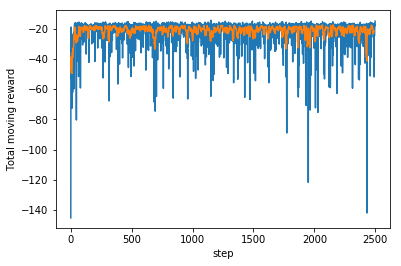

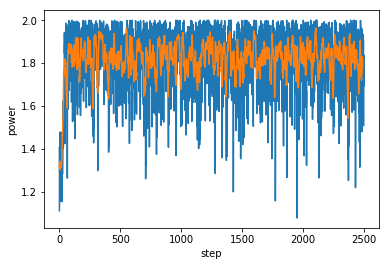

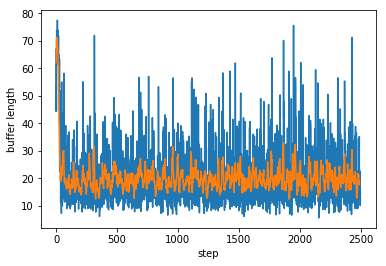

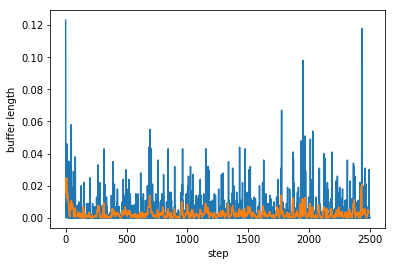

In [3]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

In [1]:
cur_init_ds_ep = env.reset()
    
cur_r_ep = np.zeros(len(user_list))
cur_p_ep = np.zeros(len(user_list))
cur_n_ep = np.zeros(len(user_list))
cur_ts_ep = np.zeros(len(user_list))
cur_rs_ep = np.zeros(len(user_list))
cur_ps_ep = np.zeros(len(user_list))
cur_ds_ep = np.zeros(len(user_list))
cur_ch_ep = np.zeros(len(user_list))
    
for j in range(1000):
    # first try to transmit from current state
    [cur_r, done, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
    cur_r_ep += cur_r
    cur_p_ep += cur_p
    cur_ts_ep += cur_ts
    cur_ps_ep += cur_ps
    cur_rs_ep += cur_rs
    cur_ds_ep += cur_ds
    cur_ch_ep += cur_ch
        
    print('%d:r:%f,p:%s,n:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (j, cur_r, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_init_ds_ep))
        
print('r:%f,p:%s,n:%s,tr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_n_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep))

NameError: name 'env' is not defined

In [3]:
graph = tf.get_default_graph()
inputs = graph.get_tensor_by_name("input_1"+":0")
scaled_out = graph.get_tensor_by_name("output_1"+":0")
print sess.run(scaled_out, feed_dict={inputs: [[7.22254768,2.3384,2.7784888e-05]]})

[[0.78826445 1.        ]]


In [2]:
res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit(False)
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])

0:r:-50.8910,p:1.4033,tr:1.4707,pr:1.3505,rev:2.9594,dbuf:72.5261,ch:0.00002568,ibuf:4
1:r:-57.9454,p:1.3913,tr:1.6529,pr:1.2218,rev:3.0360,dbuf:74.1439,ch:0.00002761,ibuf:30
2:r:-51.0844,p:1.1953,tr:1.5476,pr:1.2320,rev:2.8984,dbuf:73.1955,ch:0.00002990,ibuf:39
3:r:-18.2811,p:1.3469,tr:1.5860,pr:1.3673,rev:2.9762,dbuf:61.5868,ch:0.00002683,ibuf:35
4:r:-17.5547,p:1.2180,tr:1.7657,pr:1.2518,rev:3.0115,dbuf:55.9275,ch:0.00003238,ibuf:63
5:r:-55.6239,p:1.4116,tr:1.4240,pr:1.3390,rev:2.8791,dbuf:69.1011,ch:0.00002492,ibuf:48
6:r:-37.3900,p:1.2706,tr:1.3830,pr:1.5578,rev:3.0240,dbuf:59.5109,ch:0.00002915,ibuf:8
7:r:-32.6223,p:1.4738,tr:1.3452,pr:1.6902,rev:3.0674,dbuf:63.5657,ch:0.00002512,ibuf:71
8:r:-20.8140,p:1.2057,tr:1.4394,pr:1.5456,rev:3.0451,dbuf:49.6221,ch:0.00002902,ibuf:38
9:r:-19.3836,p:1.1973,tr:1.4459,pr:1.4838,rev:2.9358,dbuf:56.0717,ch:0.00002922,ibuf:86


In [3]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import ipdb as pdb
import time

MAX_EPISODE = 50
MAX_EPISODE_LEN = 1000

NUM_T = 1
NUM_R = 1
SIGMA2 = 0.3e-9

config = {'state_dim':3, 'action_dim':2};
train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                 'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                 'random_seed':1234}
user_config = [{'id':'1', 'rate':3, 'dis':100, 'action_bound':1, 
                'data_buf_size':100, 't_factor':0.9, 'penalty':1000}];

print user_config
# 0. initialize the session object
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
    
# 1. include all user in the system according to the user_config
user_list = [];
for info in user_config:
    info.update(config)
    user_list.append(MecTermLD(sess, info, train_config))
    print 'test'

# 2. create the simulation env
env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)
env.init_target_network()

res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])
sess.close()

[{'data_buf_size': 100, 'penalty': 1000, 'rate': 3, 'action_bound': 1, 'id': '1', 't_factor': 0.9, 'dis': 100}]
INFO:tensorflow:Restoring parameters from model/my_test_model
--Return--
None
> <ipython-input-3-a12846566f97>(30)<module>()
     29 graph = tf.get_default_graph()
---> 30 pdb.set_trace()
     31 

ipdb> graph
ipdb> graph.trainable_variables
*** AttributeError: 'Graph' object has no attribute 'trainable_variables'
ipdb> tf.trainable_variables()
[<tf.Variable 'fully_connected/weights:0' shape=(3, 400) dtype=float32_ref>, <tf.Variable 'fully_connected/BatchNorm/beta:0' shape=(400,) dtype=float32_ref>, <tf.Variable 'fully_connected_1/weights:0' shape=(3, 300) dtype=float32_ref>, <tf.Variable 'fully_connected_1/BatchNorm/beta:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'fully_connected_2/weights:0' shape=(300, 2) dtype=float32_ref>, <tf.Variable 'fully_connected_2/biases:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'fully_connected_3/weights:0' shape=(3, 400) dtype=float32

BdbQuit: 

In [9]:
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
variable_names = [v.name for v in tf.trainable_variables()]
values = sess.run(variable_names)
print sess.run('fully_connected_2/weights:0')

INFO:tensorflow:Restoring parameters from model/my_test_model
[[0.1545126  0.15780352]
 [0.15616506 0.15971294]
 [0.06559879 0.09880391]
 [0.06487427 0.10064688]
 [0.15168335 0.16229852]
 [0.06257845 0.09748891]
 [0.06430701 0.09924787]
 [0.06548443 0.10012874]
 [0.15782878 0.15414344]
 [0.15429462 0.17596859]
 [0.05945097 0.0991616 ]
 [0.06383383 0.09632684]
 [0.06522399 0.10438306]
 [0.06095436 0.09916781]
 [0.06635379 0.0955418 ]
 [0.06379106 0.09433711]
 [0.06133086 0.09875894]
 [0.06503102 0.09639146]
 [0.15047684 0.17412661]
 [0.15663381 0.15740666]
 [0.17768952 0.15899988]
 [0.15730077 0.14491995]
 [0.05902164 0.10017106]
 [0.06845198 0.09686822]
 [0.15724926 0.14774598]
 [0.1529071  0.16426612]
 [0.1520101  0.15706535]
 [0.16091335 0.16260217]
 [0.15082897 0.16070077]
 [0.06310375 0.09398151]
 [0.06018374 0.10056869]
 [0.05968894 0.10066012]
 [0.15474424 0.16255529]
 [0.15111688 0.1622602 ]
 [0.0838669  0.18973866]
 [0.06870251 0.24295035]
 [0.06702217 0.10505467]
 [0.1529     

In [3]:
np.save('t_08/1', [1])